In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [8]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
# import Models.model_func as Model_Func
from torch import nn
from Models.multi_models import *

DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]
for r in [0]:
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)

    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
        optimizer = torch.optim.Adam(classifier.parameters(), lr = learning_rate)


        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
    #     model= Multivariate_IEGradient(DEVICE, input_dim, resnet_classifier).to(DEVICE)
        model= EEGNet_Wrapper(DEVICE, classifier)

#         if i in np.array([1,2,9,17,19])-1:
        train_func= eeg_train
        model.training_procedure(iteration=n_epochs,
                                        train_dataloader=train_dataloader,
                                         val_dataloader=val_dataloader,
                                         print_cycle=2,
                                         path=f"./dictionary/intermdiate_dicts",
                                         loss_func=criterion,
                                         optimiser=optimizer, #scheduler=scheduler,
                                         train_func=train_func
                                        )
        if model.epoch == n_epochs+1:
            EPOCH= n_epochs
        else:
            EPOCH= model.epoch

        torch.save(model.state_dict(), 
               os.path.join(
                   saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{EPOCH}.pt"
               )
        )

    # OR
#         else:
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-EEGNet-Baseline-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    print()
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print("b_acc avg:",np.array(b_acc_list).mean())
print("c1_acc avg:",np.array(c1_acc_list).mean())
print("c0_acc avg:",np.array(c0_acc_list).mean())


Iterations:   0%|                                       | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6143364917998221


Iterations:   0%|                               | 1/300 [00:00<04:31,  1.10it/s]

Epoch:  0
t_loss:  0.6143364917998221 , v_loss:  0.6907462875048319
t_acc:  0.6230936819172114 , v_acc:  0.5838509316770186
t_recall:  0.5016435404400159 , v_recall:  0.48936936936936937
t_prec:  0.5022710864928356 , v_prec:  0.48800813008130084
t_f:  0.49290360922118315 , v_f:  0.48684648684648685
////////


Iterations:   1%|▏                              | 2/300 [00:01<03:29,  1.43it/s]

Epoch  1 , loss 0.5905953926198623
Epoch  2 , loss 0.5725368436645059


Iterations:   1%|▎                              | 3/300 [00:02<03:52,  1.28it/s]

Epoch:  2
t_loss:  0.5725368436645059 , v_loss:  0.6832683285077413
t_acc:  0.6604419545596016 , v_acc:  0.639751552795031
t_recall:  0.503761271462099 , v_recall:  0.48045045045045043
t_prec:  0.5090062111801242 , v_prec:  0.44727891156462585
t_f:  0.4718397810807916 , v_f:  0.43447189922480617
////////


Iterations:   1%|▍                              | 4/300 [00:02<03:24,  1.45it/s]

Epoch  3 , loss 0.5571495925678926
Epoch  4 , loss 0.5458284172357297


Iterations:   2%|▌                              | 5/300 [00:03<03:44,  1.31it/s]

Epoch:  4
t_loss:  0.5458284172357297 , v_loss:  0.6693729758262634
t_acc:  0.6716464363523187 , v_acc:  0.6956521739130435
t_recall:  0.49628813768682833 , v_recall:  0.5154954954954954
t_prec:  0.4844025744835462 , v_prec:  0.6814345991561181
t_f:  0.44094303522206574 , v_f:  0.44665778214210566
////////


Iterations:   2%|▌                              | 6/300 [00:04<03:22,  1.45it/s]

Epoch  5 , loss 0.5302487103378072
Epoch  6 , loss 0.5235518696261388


Iterations:   2%|▋                              | 7/300 [00:05<03:38,  1.34it/s]

Epoch:  6
t_loss:  0.5235518696261388 , v_loss:  0.6586185693740845
t_acc:  0.6862745098039216 , v_acc:  0.6894409937888198
t_recall:  0.5027772059126281 , v_recall:  0.5
t_prec:  0.5202869345524543 , v_prec:  0.3447204968944099
t_f:  0.4365558533957963 , v_f:  0.4080882352941176
////////


Iterations:   3%|▊                              | 8/300 [00:05<03:18,  1.47it/s]

Epoch  7 , loss 0.5089041374477685
Epoch  8 , loss 0.5048176909194273


Iterations:   3%|▉                              | 9/300 [00:06<03:34,  1.36it/s]

Epoch:  8
t_loss:  0.5048176909194273 , v_loss:  0.6557660102844238
t_acc:  0.6903205726735139 , v_acc:  0.6894409937888198
t_recall:  0.501660010156325 , v_recall:  0.5
t_prec:  0.5208906672807876 , v_prec:  0.3447204968944099
t_f:  0.426143818068275 , v_f:  0.4080882352941176
////////


Iterations:   3%|█                             | 10/300 [00:07<03:15,  1.49it/s]

Epoch  9 , loss 0.4978541135787964
Epoch  10 , loss 0.4882926660425523


Iterations:   4%|█                             | 11/300 [00:07<03:30,  1.37it/s]

Epoch:  10
t_loss:  0.4882926660425523 , v_loss:  0.6560855110486349
t_acc:  0.6928104575163399 , v_acc:  0.6894409937888198
t_recall:  0.5014369827479721 , v_recall:  0.5
t_prec:  0.5299313893653517 , v_prec:  0.3447204968944099
t_f:  0.42073370212975825 , v_f:  0.4080882352941176
////////


Iterations:   4%|█▏                            | 12/300 [00:08<03:15,  1.47it/s]

Epoch  11 , loss 0.48255697009610193
Epoch  12 , loss 0.4768640667784448


Iterations:   4%|█▎                            | 13/300 [00:09<03:33,  1.35it/s]

Epoch:  12
t_loss:  0.4768640667784448 , v_loss:  0.6561653216679891
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5030667984243972 , v_recall:  0.5
t_prec:  0.5725989863108647 , v_prec:  0.3447204968944099
t_f:  0.42239477743267145 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▍                            | 14/300 [00:09<03:16,  1.46it/s]

Epoch  13 , loss 0.4733686289366554
Epoch  14 , loss 0.4756605099229252


Iterations:   5%|█▌                            | 15/300 [00:10<03:31,  1.35it/s]

Epoch:  14
t_loss:  0.4756605099229252 , v_loss:  0.6557712554931641
t_acc:  0.6937441643323996 , v_acc:  0.6894409937888198
t_recall:  0.5003829209041875 , v_recall:  0.5
t_prec:  0.5145539906103286 , v_prec:  0.3447204968944099
t_f:  0.4154163615789123 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                            | 16/300 [00:11<03:17,  1.43it/s]

Epoch  15 , loss 0.4656386381270839
Epoch  16 , loss 0.46160514857254775


Iterations:   6%|█▋                            | 17/300 [00:12<03:32,  1.33it/s]

Epoch:  16
t_loss:  0.46160514857254775 , v_loss:  0.6553085446357727
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.502108809925749 , v_recall:  0.5
t_prec:  0.7053961322520275 , v_prec:  0.3447204968944099
t_f:  0.41547864167250537 , v_f:  0.4080882352941176
////////


Iterations:   6%|█▊                            | 18/300 [00:12<03:15,  1.44it/s]

Epoch  17 , loss 0.4542684946574417
Epoch  18 , loss 0.4528174914565741


Iterations:   6%|█▉                            | 19/300 [00:13<03:29,  1.34it/s]

Epoch:  18
t_loss:  0.4528174914565741 , v_loss:  0.6543757617473602
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5023325235722814 , v_recall:  0.5
t_prec:  0.7649672591206735 , v_prec:  0.3447204968944099
t_f:  0.4155921424153602 , v_f:  0.4080882352941176
////////


Iterations:   7%|██                            | 20/300 [00:14<03:12,  1.46it/s]

Epoch  19 , loss 0.4554366855060353
Epoch  20 , loss 0.4524424385790731


Iterations:   7%|██                            | 21/300 [00:15<03:26,  1.35it/s]

Epoch:  20
t_loss:  0.4524424385790731 , v_loss:  0.6559841434160868
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▏                           | 22/300 [00:15<03:10,  1.46it/s]

Epoch  21 , loss 0.44776371179842483
Epoch  22 , loss 0.4484166608137243


Iterations:   8%|██▎                           | 23/300 [00:16<03:24,  1.36it/s]

Epoch:  22
t_loss:  0.4484166608137243 , v_loss:  0.654017170270284
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.502172630076447 , v_recall:  0.5
t_prec:  0.6482672494536372 , v_prec:  0.3447204968944099
t_f:  0.4163339999076822 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▍                           | 24/300 [00:17<03:09,  1.46it/s]

Epoch  23 , loss 0.45649763883328903
Epoch  24 , loss 0.4460013689948063


Iterations:   8%|██▌                           | 25/300 [00:18<03:23,  1.35it/s]

Epoch:  24
t_loss:  0.4460013689948063 , v_loss:  0.651417871316274
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5023325235722814 , v_recall:  0.5
t_prec:  0.7649672591206735 , v_prec:  0.3447204968944099
t_f:  0.4155921424153602 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▌                           | 26/300 [00:18<03:08,  1.45it/s]

Epoch  25 , loss 0.4455431162142286
Epoch  26 , loss 0.4410657000307943


Iterations:   9%|██▋                           | 27/300 [00:19<03:22,  1.35it/s]

Epoch:  26
t_loss:  0.4410657000307943 , v_loss:  0.6476714114348093
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5023325235722814 , v_recall:  0.5
t_prec:  0.7649672591206735 , v_prec:  0.3447204968944099
t_f:  0.4155921424153602 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▊                           | 28/300 [00:19<03:05,  1.47it/s]

Epoch  27 , loss 0.4434478481610616
Epoch  28 , loss 0.4418660209459417


Iterations:  10%|██▉                           | 29/300 [00:20<03:20,  1.35it/s]

Epoch:  28
t_loss:  0.4418660209459417 , v_loss:  0.6440614958604177
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5026200573695119 , v_recall:  0.5
t_prec:  0.7233619344773792 , v_prec:  0.3447204968944099
t_f:  0.4165631338742394 , v_f:  0.4080882352941176
////////


Iterations:  10%|███                           | 30/300 [00:21<03:02,  1.48it/s]

Epoch  29 , loss 0.44124628515804515
Epoch  30 , loss 0.44011391027300967


Iterations:  10%|███                           | 31/300 [00:22<03:21,  1.34it/s]

Epoch:  30
t_loss:  0.44011391027300967 , v_loss:  0.6408044497172037
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.50297141131744 , v_recall:  0.5
t_prec:  0.6561298076923077 , v_prec:  0.3447204968944099
t_f:  0.4183762417414505 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▏                          | 32/300 [00:22<03:03,  1.46it/s]

Epoch  31 , loss 0.4429532739461637
Epoch  32 , loss 0.43605201267728616


Iterations:  11%|███▎                          | 33/300 [00:23<03:17,  1.35it/s]

Epoch:  32
t_loss:  0.43605201267728616 , v_loss:  0.6393981774648031
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5034826587612028 , v_recall:  0.5
t_prec:  0.6699749921850578 , v_prec:  0.3447204968944099
t_f:  0.4194516752347822 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▍                          | 34/300 [00:24<03:01,  1.46it/s]

Epoch  33 , loss 0.43986985496446196
Epoch  34 , loss 0.4386204448985119


Iterations:  12%|███▌                          | 35/300 [00:25<03:16,  1.35it/s]

Epoch:  34
t_loss:  0.4386204448985119 , v_loss:  0.636384516954422
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5018528430847778 , v_recall:  0.5
t_prec:  0.5704225352112675 , v_prec:  0.3447204968944099
t_f:  0.41779271783265653 , v_f:  0.4080882352941176
////////


Iterations:  12%|███▌                          | 36/300 [00:25<03:03,  1.44it/s]

Epoch  35 , loss 0.4348132557728711
Epoch  36 , loss 0.43871861228755876


Iterations:  12%|███▋                          | 37/300 [00:26<03:22,  1.30it/s]

Epoch:  36
t_loss:  0.43871861228755876 , v_loss:  0.6347659230232239
t_acc:  0.6953003423591659 , v_acc:  0.6894409937888198
t_recall:  0.5020765567313102 , v_recall:  0.5
t_prec:  0.5835419274092616 , v_prec:  0.3447204968944099
t_f:  0.41790947001625695 , v_f:  0.4080882352941176
////////


Iterations:  13%|███▊                          | 38/300 [00:27<03:05,  1.41it/s]

Epoch  37 , loss 0.44244829988947104
Epoch  38 , loss 0.4334812111714307


Iterations:  13%|███▉                          | 39/300 [00:28<03:16,  1.33it/s]

Epoch:  38
t_loss:  0.4334812111714307 , v_loss:  0.6298530499140421
t_acc:  0.6971677559912854 , v_acc:  0.6894409937888198
t_recall:  0.5039939062049656 , v_recall:  0.5
t_prec:  0.6819887429643527 , v_prec:  0.3447204968944099
t_f:  0.42052512257253005 , v_f:  0.4080882352941176
////////


Iterations:  13%|████                          | 40/300 [00:28<02:58,  1.45it/s]

Epoch  39 , loss 0.435756840542251
Epoch  40 , loss 0.4389600140206954


Iterations:  14%|████                          | 41/300 [00:29<03:12,  1.35it/s]

Epoch:  40
t_loss:  0.4389600140206954 , v_loss:  0.6256481856107712
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5027476976709077 , v_recall:  0.5
t_prec:  0.6341044076273835 , v_prec:  0.3447204968944099
t_f:  0.41825958421883713 , v_f:  0.4080882352941176
////////


Iterations:  14%|████▏                         | 42/300 [00:30<02:59,  1.44it/s]

Epoch  41 , loss 0.43009110350234836
Epoch  42 , loss 0.4316089015965368


Iterations:  14%|████▎                         | 43/300 [00:30<03:11,  1.34it/s]

Epoch:  42
t_loss:  0.4316089015965368 , v_loss:  0.6197143991788229
t_acc:  0.6968565203859322 , v_acc:  0.6894409937888198
t_recall:  0.5043452601528938 , v_recall:  0.5
t_prec:  0.6487316003758221 , v_prec:  0.3447204968944099
t_f:  0.4223040775729794 , v_f:  0.4080882352941176
////////


Iterations:  15%|████▍                         | 44/300 [00:31<03:01,  1.41it/s]

Epoch  43 , loss 0.4332563029784782
Epoch  44 , loss 0.4391843372700261


Iterations:  15%|████▌                         | 45/300 [00:32<03:13,  1.32it/s]

Epoch:  44
t_loss:  0.4391843372700261 , v_loss:  0.6144334723552068
t_acc:  0.6987239340180517 , v_acc:  0.6956521739130435
t_recall:  0.5062626096265492 , v_recall:  0.51
t_prec:  0.7380281690140845 , v_prec:  0.846875
t_f:  0.4249217865938894 , v_f:  0.42920193907821425
////////


Iterations:  15%|████▌                         | 46/300 [00:33<02:57,  1.43it/s]

Epoch  45 , loss 0.430861993747599
Epoch  46 , loss 0.4303740911624011


Iterations:  16%|████▋                         | 47/300 [00:33<03:11,  1.32it/s]

Epoch:  46
t_loss:  0.4303740911624011 , v_loss:  0.6101656307776769
t_acc:  0.6981014628073452 , v_acc:  0.6956521739130435
t_recall:  0.5066777837251754 , v_recall:  0.51
t_prec:  0.6761543288841689 , v_prec:  0.846875
t_f:  0.42748188360537925 , v_f:  0.42920193907821425
////////


Iterations:  16%|████▊                         | 48/300 [00:34<02:54,  1.44it/s]

Epoch  47 , loss 0.4377596910093345
Epoch  48 , loss 0.4296419369239433


Iterations:  16%|████▉                         | 49/300 [00:35<03:08,  1.33it/s]

Epoch:  48
t_loss:  0.4296419369239433 , v_loss:  0.6062542001406351
t_acc:  0.6977902272019919 , v_acc:  0.6956521739130435
t_recall:  0.5067416038758732 , v_recall:  0.51
t_prec:  0.6595910587419858 , v_prec:  0.846875
t_f:  0.42828270019074816 , v_f:  0.42920193907821425
////////


Iterations:  17%|█████                         | 50/300 [00:35<02:52,  1.45it/s]

Epoch  49 , loss 0.4319662101128522
Epoch  50 , loss 0.42972643994817544


Iterations:  17%|█████                         | 51/300 [00:36<03:07,  1.33it/s]

Epoch:  50
t_loss:  0.42972643994817544 , v_loss:  0.6054906994104385
t_acc:  0.6987239340180517 , v_acc:  0.7018633540372671
t_recall:  0.5085628800043919 , v_recall:  0.52
t_prec:  0.67316766278704 , v_prec:  0.8490566037735849
t_f:  0.4323412730280593 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▏                        | 52/300 [00:37<02:51,  1.44it/s]

Epoch  51 , loss 0.43949418208178354
Epoch  52 , loss 0.4316735033895455


Iterations:  18%|█████▎                        | 53/300 [00:38<03:04,  1.34it/s]

Epoch:  52
t_loss:  0.4316735033895455 , v_loss:  0.6031565964221954
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5100328021849824 , v_recall:  0.52
t_prec:  0.7028939918213275 , v_prec:  0.8490566037735849
t_f:  0.4346869702469517 , v_f:  0.44957264957264953
////////


Iterations:  18%|█████▍                        | 54/300 [00:38<02:51,  1.44it/s]

Epoch  53 , loss 0.4299270919725007
Epoch  54 , loss 0.4259278449942084


Iterations:  18%|█████▌                        | 55/300 [00:39<03:05,  1.32it/s]

Epoch:  54
t_loss:  0.4259278449942084 , v_loss:  0.5999123305082321
t_acc:  0.7012138188608776 , v_acc:  0.7018633540372671
t_recall:  0.5106401229738817 , v_recall:  0.52
t_prec:  0.7607927786499216 , v_prec:  0.8490566037735849
t_f:  0.4343019374527742 , v_f:  0.44957264957264953
////////


Iterations:  19%|█████▌                        | 56/300 [00:40<02:50,  1.43it/s]

Epoch  55 , loss 0.4331309006494634
Epoch  56 , loss 0.4314471261174071


Iterations:  19%|█████▋                        | 57/300 [00:41<03:02,  1.33it/s]

Epoch:  56
t_loss:  0.4314471261174071 , v_loss:  0.5989526758591334
t_acc:  0.6971677559912854 , v_acc:  0.7018633540372671
t_recall:  0.5057191089883477 , v_recall:  0.52
t_prec:  0.645323289391086 , v_prec:  0.8490566037735849
t_f:  0.4261768082663605 , v_f:  0.44957264957264953
////////


Iterations:  19%|█████▊                        | 58/300 [00:41<02:47,  1.45it/s]

Epoch  57 , loss 0.4339570397255467
Epoch  58 , loss 0.43049107696495803


Iterations:  20%|█████▉                        | 59/300 [00:42<02:59,  1.34it/s]

Epoch:  58
t_loss:  0.43049107696495803 , v_loss:  0.5974525511264801
t_acc:  0.6968565203859322 , v_acc:  0.7018633540372671
t_recall:  0.5057829291390455 , v_recall:  0.52
t_prec:  0.6323751178133836 , v_prec:  0.8490566037735849
t_f:  0.4269795127353266 , v_f:  0.44957264957264953
////////


Iterations:  20%|██████                        | 60/300 [00:43<02:45,  1.45it/s]

Epoch  59 , loss 0.42816349805570114
Epoch  60 , loss 0.4297527320244733


Iterations:  20%|██████                        | 61/300 [00:43<02:58,  1.34it/s]

Epoch:  60
t_loss:  0.4297527320244733 , v_loss:  0.5973064502080282
t_acc:  0.6968565203859322 , v_acc:  0.7018633540372671
t_recall:  0.5057829291390455 , v_recall:  0.52
t_prec:  0.6323751178133836 , v_prec:  0.8490566037735849
t_f:  0.4269795127353266 , v_f:  0.44957264957264953
////////


Iterations:  21%|██████▏                       | 62/300 [00:44<02:46,  1.43it/s]

Epoch  61 , loss 0.4265771554965599
Epoch  62 , loss 0.42514097924325983


Iterations:  21%|██████▎                       | 63/300 [00:45<02:58,  1.33it/s]

Epoch:  62
t_loss:  0.42514097924325983 , v_loss:  0.5937420527140299
t_acc:  0.6999688764394647 , v_acc:  0.7018633540372671
t_recall:  0.5106078697794431 , v_recall:  0.52
t_prec:  0.692184003315375 , v_prec:  0.8490566037735849
t_f:  0.43649628131049234 , v_f:  0.44957264957264953
////////


Iterations:  21%|██████▍                       | 64/300 [00:45<02:43,  1.45it/s]

Epoch  63 , loss 0.4303094546000163
Epoch  64 , loss 0.4274631323767643


Iterations:  22%|██████▌                       | 65/300 [00:46<02:55,  1.34it/s]

Epoch:  64
t_loss:  0.4274631323767643 , v_loss:  0.5920120030641556
t_acc:  0.6984126984126984 , v_acc:  0.7018633540372671
t_recall:  0.5083391663578595 , v_recall:  0.52
t_prec:  0.6638766519823789 , v_prec:  0.8490566037735849
t_f:  0.43221092726022997 , v_f:  0.44957264957264953
////////


Iterations:  22%|██████▌                       | 66/300 [00:47<02:42,  1.44it/s]

Epoch  65 , loss 0.4313838464372298
Epoch  66 , loss 0.4304621056014416


Iterations:  22%|██████▋                       | 67/300 [00:48<02:54,  1.33it/s]

Epoch:  66
t_loss:  0.4304621056014416 , v_loss:  0.5900790939728419
t_acc:  0.6981014628073452 , v_acc:  0.7018633540372671
t_recall:  0.507252851319636 , v_recall:  0.52
t_prec:  0.6660226201696513 , v_prec:  0.8490566037735849
t_f:  0.4293327796234772 , v_f:  0.44957264957264953
////////


Iterations:  23%|██████▊                       | 68/300 [00:48<02:40,  1.44it/s]

Epoch  67 , loss 0.4305915739022049
Epoch  68 , loss 0.42629992319088356


Iterations:  23%|██████▉                       | 69/300 [00:49<02:51,  1.34it/s]

Epoch:  68
t_loss:  0.42629992319088356 , v_loss:  0.5857430497805277
t_acc:  0.7018362900715842 , v_acc:  0.7018633540372671
t_recall:  0.513100286847559 , v_recall:  0.52
t_prec:  0.7256145603529782 , v_prec:  0.8490566037735849
t_f:  0.44089706292649467 , v_f:  0.44957264957264953
////////


Iterations:  23%|███████                       | 70/300 [00:50<02:39,  1.44it/s]

Epoch  69 , loss 0.42924269215733396
Epoch  70 , loss 0.42083219920887666


Iterations:  24%|███████                       | 71/300 [00:51<02:50,  1.34it/s]

Epoch:  70
t_loss:  0.42083219920887666 , v_loss:  0.5838340769211451
t_acc:  0.7024587612822907 , v_acc:  0.7080745341614907
t_recall:  0.5149853831267757 , v_recall:  0.53
t_prec:  0.7156101895734597 , v_prec:  0.8512658227848101
t_f:  0.44559454191033143 , v_f:  0.4692431787893666
////////


Iterations:  24%|███████▏                      | 72/300 [00:51<02:38,  1.44it/s]

Epoch  71 , loss 0.42369646067712824
Epoch  72 , loss 0.4291116355680952


Iterations:  24%|███████▎                      | 73/300 [00:52<02:52,  1.32it/s]

Epoch:  72
t_loss:  0.4291116355680952 , v_loss:  0.5836008141438166
t_acc:  0.7033924680983504 , v_acc:  0.7080745341614907
t_recall:  0.515656524066373 , v_recall:  0.53
t_prec:  0.7400568181818181 , v_prec:  0.8512658227848101
t_f:  0.44602135340255744 , v_f:  0.4692431787893666
////////


Iterations:  25%|███████▍                      | 74/300 [00:53<02:37,  1.43it/s]

Epoch  73 , loss 0.4276624210909301
Epoch  74 , loss 0.42808740629869346


Iterations:  25%|███████▌                      | 75/300 [00:54<02:49,  1.33it/s]

Epoch:  74
t_loss:  0.42808740629869346 , v_loss:  0.5803866386413574
t_acc:  0.6999688764394647 , v_acc:  0.7142857142857143
t_recall:  0.5117580049683644 , v_recall:  0.54
t_prec:  0.6764185005697341 , v_prec:  0.8535031847133758
t_f:  0.4400706624861162 , v_f:  0.488253178551686
////////


Iterations:  25%|███████▌                      | 76/300 [00:54<02:33,  1.46it/s]

Epoch  75 , loss 0.4223976833563225
Epoch  76 , loss 0.42921051558326273


Iterations:  26%|███████▋                      | 77/300 [00:55<02:46,  1.34it/s]

Epoch:  76
t_loss:  0.42921051558326273 , v_loss:  0.5784887969493866
t_acc:  0.7009025832555245 , v_acc:  0.7142857142857143
t_recall:  0.5135792810968831 , v_recall:  0.54
t_prec:  0.6840607210626186 , v_prec:  0.8535031847133758
t_f:  0.4440108450272827 , v_f:  0.488253178551686
////////


Iterations:  26%|███████▊                      | 78/300 [00:56<02:31,  1.46it/s]

Epoch  77 , loss 0.42724476491703706
Epoch  78 , loss 0.4227428103194517


Iterations:  26%|███████▉                      | 79/300 [00:56<02:42,  1.36it/s]

Epoch:  78
t_loss:  0.4227428103194517 , v_loss:  0.5776371955871582
t_acc:  0.6987239340180517 , v_acc:  0.7204968944099379
t_recall:  0.5088504138016222 , v_recall:  0.55
t_prec:  0.6691454202077431 , v_prec:  0.8557692307692308
t_f:  0.43325155145042576 , v_f:  0.5066394279877425
////////


Iterations:  27%|████████                      | 80/300 [00:57<02:31,  1.46it/s]

Epoch  79 , loss 0.4283338452086729
Epoch  80 , loss 0.4237539429290622


Iterations:  27%|████████                      | 81/300 [00:58<02:41,  1.35it/s]

Epoch:  80
t_loss:  0.4237539429290622 , v_loss:  0.5764436473449072
t_acc:  0.7018362900715842 , v_acc:  0.7204968944099379
t_recall:  0.5139628882392501 , v_recall:  0.55
t_prec:  0.7095008305761865 , v_prec:  0.8557692307692308
t_f:  0.4435556998565346 , v_f:  0.5066394279877425
////////


Iterations:  27%|████████▏                     | 82/300 [00:58<02:30,  1.45it/s]

Epoch  81 , loss 0.42502721793511333
Epoch  82 , loss 0.42258426547050476


Iterations:  28%|████████▎                     | 83/300 [00:59<02:41,  1.35it/s]

Epoch:  82
t_loss:  0.42258426547050476 , v_loss:  0.5748960723479589
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.5113428308697383 , v_recall:  0.55
t_prec:  0.7054993783671778 , v_prec:  0.8557692307692308
t_f:  0.4376653761625453 , v_f:  0.5066394279877425
////////


Iterations:  28%|████████▍                     | 84/300 [01:00<02:28,  1.45it/s]

Epoch  83 , loss 0.425132482659583
Epoch  84 , loss 0.42151525938043405


Iterations:  28%|████████▌                     | 85/300 [01:01<02:40,  1.34it/s]

Epoch:  84
t_loss:  0.42151525938043405 , v_loss:  0.5735352834065756
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.515656524066373 , v_recall:  0.56
t_prec:  0.7400568181818181 , v_prec:  0.8580645161290323
t_f:  0.44602135340255744 , v_f:  0.5244360902255639
////////


Iterations:  29%|████████▌                     | 86/300 [01:01<02:26,  1.46it/s]

Epoch  85 , loss 0.422324689579945
Epoch  86 , loss 0.42241813972884534


Iterations:  29%|████████▋                     | 87/300 [01:02<02:38,  1.34it/s]

Epoch:  86
t_loss:  0.42241813972884534 , v_loss:  0.5750180184841156
t_acc:  0.7005913476501712 , v_acc:  0.7204968944099379
t_recall:  0.5133555674503507 , v_recall:  0.55
t_prec:  0.6776032414279805 , v_prec:  0.8557692307692308
t_f:  0.44386960495728583 , v_f:  0.5066394279877425
////////


Iterations:  29%|████████▊                     | 88/300 [01:03<02:25,  1.46it/s]

Epoch  87 , loss 0.4254111536577636
Epoch  88 , loss 0.42717358528399


Iterations:  30%|████████▉                     | 89/300 [01:04<02:37,  1.34it/s]

Epoch:  88
t_loss:  0.42717358528399 , v_loss:  0.5766647805770239
t_acc:  0.7009025832555245 , v_acc:  0.7204968944099379
t_recall:  0.5135792810968831 , v_recall:  0.55
t_prec:  0.6840607210626186 , v_prec:  0.8557692307692308
t_f:  0.4440108450272827 , v_f:  0.5066394279877425
////////


Iterations:  30%|█████████                     | 90/300 [01:04<02:24,  1.45it/s]

Epoch  89 , loss 0.42112048174820693
Epoch  90 , loss 0.42111803678905263


Iterations:  30%|█████████                     | 91/300 [01:05<02:33,  1.36it/s]

Epoch:  90
t_loss:  0.42111803678905263 , v_loss:  0.5735637446244558
t_acc:  0.7015250544662309 , v_acc:  0.7204968944099379
t_recall:  0.5137391745927177 , v_recall:  0.55
t_prec:  0.7018218841144608 , v_prec:  0.8557692307692308
t_f:  0.44341526636892 , v_f:  0.5066394279877425
////////


Iterations:  31%|█████████▏                    | 92/300 [01:06<02:21,  1.47it/s]

Epoch  91 , loss 0.4181303218299267
Epoch  92 , loss 0.4198987647598865


Iterations:  31%|█████████▎                    | 93/300 [01:06<02:34,  1.34it/s]

Epoch:  92
t_loss:  0.4198987647598865 , v_loss:  0.5719287147124609
t_acc:  0.7046374105197635 , v_acc:  0.7267080745341615
t_recall:  0.5182765814358847 , v_recall:  0.56
t_prec:  0.7385329591593026 , v_prec:  0.8580645161290323
t_f:  0.45181540906594364 , v_f:  0.5244360902255639
////////


Iterations:  31%|█████████▍                    | 94/300 [01:07<02:22,  1.44it/s]

Epoch  93 , loss 0.42228064817540784
Epoch  94 , loss 0.41750553659364287


Iterations:  32%|█████████▌                    | 95/300 [01:08<02:36,  1.31it/s]

Epoch:  94
t_loss:  0.41750553659364287 , v_loss:  0.5701520442962646
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.514026708389948 , v_recall:  0.56
t_prec:  0.6977605201372584 , v_prec:  0.8580645161290323
t_f:  0.44429339127138295 , v_f:  0.5244360902255639
////////


Iterations:  32%|█████████▌                    | 96/300 [01:09<02:24,  1.42it/s]

Epoch  95 , loss 0.41811414968733696
Epoch  96 , loss 0.4267658252342075


Iterations:  32%|█████████▋                    | 97/300 [01:09<02:33,  1.32it/s]

Epoch:  96
t_loss:  0.4267658252342075 , v_loss:  0.5693990786870321
t_acc:  0.7033924680983504 , v_acc:  0.7267080745341615
t_recall:  0.5162315916608337 , v_recall:  0.56
t_prec:  0.7288468484739028 , v_prec:  0.8580645161290323
t_f:  0.44777017923006046 , v_f:  0.5244360902255639
////////


Iterations:  33%|█████████▊                    | 98/300 [01:10<02:20,  1.43it/s]

Epoch  97 , loss 0.42417608406029494
Epoch  98 , loss 0.42318525267582313


Iterations:  33%|█████████▉                    | 99/300 [01:11<02:30,  1.33it/s]

Epoch:  98
t_loss:  0.42318525267582313 , v_loss:  0.5657156060139338
t_acc:  0.7037037037037037 , v_acc:  0.7267080745341615
t_recall:  0.5173179066990571 , v_recall:  0.56
t_prec:  0.7219056663501108 , v_prec:  0.8580645161290323
t_f:  0.4505134904415759 , v_f:  0.5244360902255639
////////


Iterations:  33%|█████████▋                   | 100/300 [01:11<02:18,  1.44it/s]

Epoch  99 , loss 0.41915705391004976
Epoch  100 , loss 0.41668886881248623


Iterations:  34%|█████████▊                   | 101/300 [01:12<02:27,  1.35it/s]

Epoch:  100
t_loss:  0.41668886881248623 , v_loss:  0.5659558276335398
t_acc:  0.7009025832555245 , v_acc:  0.7267080745341615
t_recall:  0.5147294162858045 , v_recall:  0.56
t_prec:  0.6730167771890416 , v_prec:  0.8580645161290323
t_f:  0.44748105582409825 , v_f:  0.5244360902255639
////////


Iterations:  34%|█████████▊                   | 102/300 [01:13<02:16,  1.45it/s]

Epoch  101 , loss 0.4191203970535129
Epoch  102 , loss 0.41816383278837393


Iterations:  34%|█████████▉                   | 103/300 [01:14<02:24,  1.36it/s]

Epoch:  102
t_loss:  0.41816383278837393 , v_loss:  0.5628995895385742
t_acc:  0.702769996887644 , v_acc:  0.7267080745341615
t_recall:  0.5157841643677687 , v_recall:  0.56
t_prec:  0.7139468690702087 , v_prec:  0.8580645161290323
t_f:  0.4474821612914204 , v_f:  0.5244360902255639
////////


Iterations:  35%|██████████                   | 104/300 [01:14<02:15,  1.45it/s]

Epoch  103 , loss 0.42246721363535117
Epoch  104 , loss 0.4207381559353249


Iterations:  35%|██████████▏                  | 105/300 [01:15<02:24,  1.35it/s]

Epoch:  104
t_loss:  0.4207381559353249 , v_loss:  0.5622882942358652
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5168704794059922 , v_recall:  0.56
t_prec:  0.7085840988280012 , v_prec:  0.8580645161290323
t_f:  0.4502203278443887 , v_f:  0.5244360902255639
////////


Iterations:  35%|██████████▏                  | 106/300 [01:16<02:12,  1.46it/s]

Epoch  105 , loss 0.4178175382754382
Epoch  106 , loss 0.423627985458748


Iterations:  36%|██████████▎                  | 107/300 [01:17<02:23,  1.35it/s]

Epoch:  106
t_loss:  0.423627985458748 , v_loss:  0.5649142563343048
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5168704794059922 , v_recall:  0.56
t_prec:  0.7085840988280012 , v_prec:  0.8580645161290323
t_f:  0.4502203278443887 , v_f:  0.5244360902255639
////////


Iterations:  36%|██████████▍                  | 108/300 [01:17<02:11,  1.47it/s]

Epoch  107 , loss 0.4195505333881752
Epoch  108 , loss 0.41952328179396836


Iterations:  36%|██████████▌                  | 109/300 [01:18<02:22,  1.34it/s]

Epoch:  108
t_loss:  0.41952328179396836 , v_loss:  0.5622674723466238
t_acc:  0.6996576408341114 , v_acc:  0.7267080745341615
t_recall:  0.5115342913218319 , v_recall:  0.56
t_prec:  0.6694332065429228 , v_prec:  0.8580645161290323
t_f:  0.43993298440668166 , v_f:  0.5244360902255639
////////


Iterations:  37%|██████████▋                  | 110/300 [01:19<02:11,  1.44it/s]

Epoch  109 , loss 0.42266016672639284
Epoch  110 , loss 0.41890064641541125


Iterations:  37%|██████████▋                  | 111/300 [01:19<02:21,  1.33it/s]

Epoch:  110
t_loss:  0.41890064641541125 , v_loss:  0.5601362983385721
t_acc:  0.704014939309057 , v_acc:  0.7267080745341615
t_recall:  0.5158164175622075 , v_recall:  0.56
t_prec:  0.7658321286869867 , v_prec:  0.8580645161290323
t_f:  0.4454244879016823 , v_f:  0.5244360902255639
////////


Iterations:  37%|██████████▊                  | 112/300 [01:20<02:10,  1.45it/s]

Epoch  111 , loss 0.42346735094107835
Epoch  112 , loss 0.4160499666251388


Iterations:  38%|██████████▉                  | 113/300 [01:21<02:18,  1.35it/s]

Epoch:  112
t_loss:  0.4160499666251388 , v_loss:  0.5597003748019537
t_acc:  0.7030812324929971 , v_acc:  0.7267080745341615
t_recall:  0.5171580132032225 , v_recall:  0.56
t_prec:  0.7049538226132576 , v_prec:  0.8580645161290323
t_f:  0.45107807250664395 , v_f:  0.5244360902255639
////////


Iterations:  38%|███████████                  | 114/300 [01:21<02:06,  1.47it/s]

Epoch  113 , loss 0.41844019585964726
Epoch  114 , loss 0.4222130792982438


Iterations:  38%|███████████                  | 115/300 [01:22<02:17,  1.35it/s]

Epoch:  114
t_loss:  0.4222130792982438 , v_loss:  0.559700166185697
t_acc:  0.7015250544662309 , v_acc:  0.7267080745341615
t_recall:  0.514026708389948 , v_recall:  0.56
t_prec:  0.6977605201372584 , v_prec:  0.8580645161290323
t_f:  0.44429339127138295 , v_f:  0.5244360902255639
////////


Iterations:  39%|███████████▏                 | 116/300 [01:23<02:08,  1.43it/s]

Epoch  115 , loss 0.42437006270184235
Epoch  116 , loss 0.4255959017604005


Iterations:  39%|███████████▎                 | 117/300 [01:24<02:18,  1.32it/s]

Epoch:  116
t_loss:  0.4255959017604005 , v_loss:  0.5597056398789088
t_acc:  0.7009025832555245 , v_acc:  0.7267080745341615
t_recall:  0.5144418824885741 , v_recall:  0.56
t_prec:  0.6754802881729037 , v_prec:  0.8580645161290323
t_f:  0.4466187607364932 , v_f:  0.5244360902255639
////////


Iterations:  39%|███████████▍                 | 118/300 [01:24<02:07,  1.43it/s]

Epoch  117 , loss 0.4174477878738852
Epoch  118 , loss 0.4126850460089889


Iterations:  40%|███████████▌                 | 119/300 [01:25<02:16,  1.32it/s]

Epoch:  118
t_loss:  0.4126850460089889 , v_loss:  0.5575659871101379
t_acc:  0.7071272953625894 , v_acc:  0.7267080745341615
t_recall:  0.5220790271887567 , v_recall:  0.56
t_prec:  0.7593478284234172 , v_prec:  0.8580645161290323
t_f:  0.4589798892096529 , v_f:  0.5244360902255639
////////


Iterations:  40%|███████████▌                 | 120/300 [01:26<02:03,  1.45it/s]

Epoch  119 , loss 0.4160074322831397
Epoch  120 , loss 0.42227617139909784


Iterations:  40%|███████████▋                 | 121/300 [01:27<02:12,  1.35it/s]

Epoch:  120
t_loss:  0.42227617139909784 , v_loss:  0.5560605525970459
t_acc:  0.7021475256769374 , v_acc:  0.7329192546583851
t_recall:  0.5147616694802433 , v_recall:  0.5700000000000001
t_prec:  0.7081226295828066 , v_prec:  0.8603896103896104
t_f:  0.4454523205909422 , v_f:  0.5416749420721615
////////


Iterations:  41%|███████████▊                 | 122/300 [01:27<02:02,  1.46it/s]

Epoch  121 , loss 0.41357287764549255
Epoch  122 , loss 0.414897656323863


Iterations:  41%|███████████▉                 | 123/300 [01:28<02:10,  1.35it/s]

Epoch:  122
t_loss:  0.414897656323863 , v_loss:  0.5549349387486776
t_acc:  0.702769996887644 , v_acc:  0.7329192546583851
t_recall:  0.5169342995566901 , v_recall:  0.5700000000000001
t_prec:  0.6989160925593543 , v_prec:  0.8603896103896104
t_f:  0.45093070583976463 , v_f:  0.5416749420721615
////////


Iterations:  41%|███████████▉                 | 124/300 [01:29<02:03,  1.43it/s]

Epoch  123 , loss 0.41894913771573233
Epoch  124 , loss 0.4151600014929678


Iterations:  42%|████████████                 | 125/300 [01:29<02:11,  1.33it/s]

Epoch:  124
t_loss:  0.4151600014929678 , v_loss:  0.5551668554544449
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5216315998956917 , v_recall:  0.5700000000000001
t_prec:  0.7459172422401598 , v_prec:  0.8603896103896104
t_f:  0.45867274315434814 , v_f:  0.5416749420721615
////////


Iterations:  42%|████████████▏                | 126/300 [01:30<02:00,  1.44it/s]

Epoch  125 , loss 0.4111817204484753
Epoch  126 , loss 0.42375145531168174


Iterations:  42%|████████████▎                | 127/300 [01:31<02:09,  1.33it/s]

Epoch:  126
t_loss:  0.42375145531168174 , v_loss:  0.5554937223593394
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5207689985040008 , v_recall:  0.5700000000000001
t_prec:  0.7613708330934423 , v_prec:  0.8603896103896104
t_f:  0.4561342918978727 , v_f:  0.5416749420721615
////////


Iterations:  43%|████████████▎                | 128/300 [01:31<01:58,  1.45it/s]

Epoch  127 , loss 0.4206133817925173
Epoch  128 , loss 0.42367680633769317


Iterations:  43%|████████████▍                | 129/300 [01:32<02:07,  1.34it/s]

Epoch:  128
t_loss:  0.42367680633769317 , v_loss:  0.556017796198527
t_acc:  0.7030812324929971 , v_acc:  0.7329192546583851
t_recall:  0.5168704794059922 , v_recall:  0.5700000000000001
t_prec:  0.7085840988280012 , v_prec:  0.8603896103896104
t_f:  0.4502203278443887 , v_f:  0.5416749420721615
////////


Iterations:  43%|████████████▌                | 130/300 [01:33<01:56,  1.45it/s]

Epoch  129 , loss 0.41504673572147593
Epoch  130 , loss 0.4163072769548379


Iterations:  44%|████████████▋                | 131/300 [01:34<02:05,  1.34it/s]

Epoch:  130
t_loss:  0.4163072769548379 , v_loss:  0.5561664054791132
t_acc:  0.7018362900715842 , v_acc:  0.7329192546583851
t_recall:  0.5154005572254018 , v_recall:  0.5700000000000001
t_prec:  0.690410199556541 , v_prec:  0.8603896103896104
t_f:  0.4479151719862939 , v_f:  0.5416749420721615
////////


Iterations:  44%|████████████▊                | 132/300 [01:34<01:54,  1.47it/s]

Epoch  131 , loss 0.41176386148321864
Epoch  132 , loss 0.4089614567803402


Iterations:  44%|████████████▊                | 133/300 [01:35<02:02,  1.36it/s]

Epoch:  132
t_loss:  0.4089614567803402 , v_loss:  0.5548485964536667
t_acc:  0.7055711173358232 , v_acc:  0.7391304347826086
t_recall:  0.5186601885782517 , v_recall:  0.58
t_prec:  0.7684834123222749 , v_prec:  0.8627450980392157
t_f:  0.4513937621832359 , v_f:  0.5583855799373041
////////


Iterations:  45%|████████████▉                | 134/300 [01:36<01:52,  1.47it/s]

Epoch  133 , loss 0.41604602161575766
Epoch  134 , loss 0.41557278469497083


Iterations:  45%|█████████████                | 135/300 [01:37<02:02,  1.35it/s]

Epoch:  134
t_loss:  0.41557278469497083 , v_loss:  0.5545365711053213
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.5204492115123317 , v_recall:  0.58
t_prec:  0.7252380952380952 , v_prec:  0.8627450980392157
t_f:  0.4572194616811026 , v_f:  0.5583855799373041
////////


Iterations:  45%|█████████████▏               | 136/300 [01:37<01:54,  1.43it/s]

Epoch  135 , loss 0.4136171031231974
Epoch  136 , loss 0.41689377555660173


Iterations:  46%|█████████████▏               | 137/300 [01:38<02:03,  1.32it/s]

Epoch:  136
t_loss:  0.41689377555660173 , v_loss:  0.5520721971988678
t_acc:  0.6981014628073452 , v_acc:  0.7391304347826086
t_recall:  0.5118533920753215 , v_recall:  0.58
t_prec:  0.6326230280197787 , v_prec:  0.8627450980392157
t_f:  0.44360557285269503 , v_f:  0.5583855799373041
////////


Iterations:  46%|█████████████▎               | 138/300 [01:39<01:53,  1.43it/s]

Epoch  137 , loss 0.4169304055326125
Epoch  138 , loss 0.4145242156935673


Iterations:  46%|█████████████▍               | 139/300 [01:40<02:00,  1.34it/s]

Epoch:  138
t_loss:  0.4145242156935673 , v_loss:  0.55097762743632
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5198418907234322 , v_recall:  0.58
t_prec:  0.6999253235977432 , v_prec:  0.8627450980392157
t_f:  0.4574459414756846 , v_f:  0.5583855799373041
////////


Iterations:  47%|█████████████▌               | 140/300 [01:40<01:48,  1.47it/s]

Epoch  139 , loss 0.41442537950534447
Epoch  140 , loss 0.4168476550018086


Iterations:  47%|█████████████▋               | 141/300 [01:41<01:56,  1.36it/s]

Epoch:  140
t_loss:  0.4168476550018086 , v_loss:  0.5509859174489975
t_acc:  0.7074385309679427 , v_acc:  0.7453416149068323
t_recall:  0.5231653422269801 , v_recall:  0.59
t_prec:  0.7512479160050809 , v_prec:  0.8651315789473684
t_f:  0.4616486468757931 , v_f:  0.5745956048205194
////////


Iterations:  47%|█████████████▋               | 142/300 [01:41<01:48,  1.46it/s]

Epoch  141 , loss 0.4194926356568056
Epoch  142 , loss 0.41449835662748297


Iterations:  48%|█████████████▊               | 143/300 [01:42<01:57,  1.34it/s]

Epoch:  142
t_loss:  0.41449835662748297 , v_loss:  0.5508525123198827
t_acc:  0.7030812324929971 , v_acc:  0.7391304347826086
t_recall:  0.5183081483921439 , v_recall:  0.58
t_prec:  0.6926726752751537 , v_prec:  0.8627450980392157
t_f:  0.454474685734056 , v_f:  0.5583855799373041
////////


Iterations:  48%|█████████████▉               | 144/300 [01:43<01:47,  1.45it/s]

Epoch  143 , loss 0.4166313497459187
Epoch  144 , loss 0.41238174660533083


Iterations:  48%|██████████████               | 145/300 [01:44<01:54,  1.35it/s]

Epoch:  144
t_loss:  0.41238174660533083 , v_loss:  0.5514654417832693
t_acc:  0.7080610021786492 , v_acc:  0.7391304347826086
t_recall:  0.524475370911736 , v_recall:  0.58
t_prec:  0.7501589825119237 , v_prec:  0.8627450980392157
t_f:  0.46445051781614505 , v_f:  0.5583855799373041
////////


Iterations:  49%|██████████████               | 146/300 [01:44<01:46,  1.45it/s]

Epoch  145 , loss 0.4094642342305651
Epoch  146 , loss 0.41344346252142217


Iterations:  49%|██████████████▏              | 147/300 [01:45<01:53,  1.34it/s]

Epoch:  146
t_loss:  0.41344346252142217 , v_loss:  0.5519292602936426
t_acc:  0.7024587612822907 , v_acc:  0.7453416149068323
t_recall:  0.5178607210990791 , v_recall:  0.59
t_prec:  0.6825516693163751 , v_prec:  0.8651315789473684
t_f:  0.4541734488616574 , v_f:  0.5745956048205194
////////


Iterations:  49%|██████████████▎              | 148/300 [01:46<01:44,  1.46it/s]

Epoch  147 , loss 0.42073242746147455
Epoch  148 , loss 0.4174059296355528


Iterations:  50%|██████████████▍              | 149/300 [01:47<01:52,  1.34it/s]

Epoch:  148
t_loss:  0.4174059296355528 , v_loss:  0.553349589308103
t_acc:  0.7086834733893558 , v_acc:  0.7391304347826086
t_recall:  0.5269355347854133 , v_recall:  0.58
t_prec:  0.7349046441110756 , v_prec:  0.8627450980392157
t_f:  0.47047264613659606 , v_f:  0.5583855799373041
////////


Iterations:  50%|██████████████▌              | 150/300 [01:47<01:43,  1.45it/s]

Epoch  149 , loss 0.41274133470712926
Epoch  150 , loss 0.416150277151781


Iterations:  50%|██████████████▌              | 151/300 [01:48<01:50,  1.35it/s]

Epoch:  150
t_loss:  0.416150277151781 , v_loss:  0.5505661716063818
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.521663166851951 , v_recall:  0.58
t_prec:  0.7038521477833362 , v_prec:  0.8627450980392157
t_f:  0.4612272015237427 , v_f:  0.5583855799373041
////////


Iterations:  51%|██████████████▋              | 152/300 [01:49<01:42,  1.45it/s]

Epoch  151 , loss 0.4160737401130153
Epoch  152 , loss 0.41609523284669014


Iterations:  51%|██████████████▊              | 153/300 [01:49<01:48,  1.36it/s]

Epoch:  152
t_loss:  0.41609523284669014 , v_loss:  0.5504559526840845
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5192668231289717 , v_recall:  0.59
t_prec:  0.705815658293422 , v_prec:  0.8651315789473684
t_f:  0.45576990450922433 , v_f:  0.5745956048205194
////////


Iterations:  51%|██████████████▉              | 154/300 [01:50<01:40,  1.46it/s]

Epoch  153 , loss 0.41746928761987123
Epoch  154 , loss 0.4092812006380044


Iterations:  52%|██████████████▉              | 155/300 [01:51<01:48,  1.33it/s]

Epoch:  154
t_loss:  0.4092812006380044 , v_loss:  0.5501570751269659
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5225580214380807 , v_recall:  0.59
t_prec:  0.7241170855870187 , v_prec:  0.8651315789473684
t_f:  0.46185335222095103 , v_f:  0.5745956048205194
////////


Iterations:  52%|███████████████              | 156/300 [01:52<01:40,  1.44it/s]

Epoch  155 , loss 0.41705182253145706
Epoch  156 , loss 0.41040756129751016


Iterations:  52%|███████████████▏             | 157/300 [01:52<01:48,  1.32it/s]

Epoch:  156
t_loss:  0.41040756129751016 , v_loss:  0.5494872132937113
t_acc:  0.706504824151883 , v_acc:  0.7453416149068323
t_recall:  0.5236443364763042 , v_recall:  0.59
t_prec:  0.7195984703632887 , v_prec:  0.8651315789473684
t_f:  0.46447813616992845 , v_f:  0.5745956048205194
////////


Iterations:  53%|███████████████▎             | 158/300 [01:53<01:39,  1.43it/s]

Epoch  157 , loss 0.4154375125380123
Epoch  158 , loss 0.4131366931924633


Iterations:  53%|███████████████▎             | 159/300 [01:54<01:45,  1.34it/s]

Epoch:  158
t_loss:  0.4131366931924633 , v_loss:  0.5504185557365417
t_acc:  0.707749766573296 , v_acc:  0.7453416149068323
t_recall:  0.5248267248596643 , v_recall:  0.59
t_prec:  0.7367463572114126 , v_prec:  0.8651315789473684
t_f:  0.4659337508021153 , v_f:  0.5745956048205194
////////


Iterations:  53%|███████████████▍             | 160/300 [01:54<01:35,  1.46it/s]

Epoch  159 , loss 0.41860241340655907
Epoch  160 , loss 0.4092426685725941


Iterations:  54%|███████████████▌             | 161/300 [01:55<01:42,  1.35it/s]

Epoch:  160
t_loss:  0.4092426685725941 , v_loss:  0.5463445583979288
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5229416285804477 , v_recall:  0.59
t_prec:  0.7450713517740202 , v_prec:  0.8651315789473684
t_f:  0.46149261844708733 , v_f:  0.5745956048205194
////////


Iterations:  54%|███████████████▋             | 162/300 [01:56<01:35,  1.45it/s]

Epoch  161 , loss 0.41062696307313207
Epoch  162 , loss 0.41025685796550676


Iterations:  54%|███████████████▊             | 163/300 [01:57<01:41,  1.34it/s]

Epoch:  162
t_loss:  0.41025685796550676 , v_loss:  0.5470841278632482
t_acc:  0.7071272953625894 , v_acc:  0.7453416149068323
t_recall:  0.5252418989582904 , v_recall:  0.59
t_prec:  0.7174861643252448 , v_prec:  0.8651315789473684
t_f:  0.46804757433291594 , v_f:  0.5745956048205194
////////


Iterations:  55%|███████████████▊             | 164/300 [01:57<01:34,  1.44it/s]

Epoch  163 , loss 0.41777027588264615
Epoch  164 , loss 0.4088965981614356


Iterations:  55%|███████████████▉             | 165/300 [01:58<01:40,  1.34it/s]

Epoch:  164
t_loss:  0.4088965981614356 , v_loss:  0.5470142265160879
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.5201294245206627 , v_recall:  0.59
t_prec:  0.6972346491424678 , v_prec:  0.8651315789473684
t_f:  0.4582789422092793 , v_f:  0.5745956048205194
////////


Iterations:  55%|████████████████             | 166/300 [01:59<01:32,  1.45it/s]

Epoch  165 , loss 0.4107848119501974
Epoch  166 , loss 0.40923527467484566


Iterations:  56%|████████████████▏            | 167/300 [02:00<01:39,  1.34it/s]

Epoch:  166
t_loss:  0.40923527467484566 , v_loss:  0.544441764553388
t_acc:  0.7093059446000622 , v_acc:  0.7391304347826086
t_recall:  0.5270954282812479 , v_recall:  0.5854954954954955
t_prec:  0.7484187037565223 , v_prec:  0.8142384105960265
t_f:  0.4699937549540028 , v_f:  0.5698473282442748
////////


Iterations:  56%|████████████████▏            | 168/300 [02:00<01:30,  1.45it/s]

Epoch  167 , loss 0.41407177845637005
Epoch  168 , loss 0.41049882944892435


Iterations:  56%|████████████████▎            | 169/300 [02:01<01:38,  1.33it/s]

Epoch:  168
t_loss:  0.41049882944892435 , v_loss:  0.5454012999931971
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5234206228297718 , v_recall:  0.59
t_prec:  0.7147270271630624 , v_prec:  0.8651315789473684
t_f:  0.4643191698892706 , v_f:  0.5745956048205194
////////


Iterations:  57%|████████████████▍            | 170/300 [02:02<01:29,  1.46it/s]

Epoch  169 , loss 0.4115818020175485
Epoch  170 , loss 0.41532935114467845


Iterations:  57%|████████████████▌            | 171/300 [02:02<01:37,  1.33it/s]

Epoch:  170
t_loss:  0.41532935114467845 , v_loss:  0.543723851442337
t_acc:  0.7071272953625894 , v_acc:  0.7391304347826086
t_recall:  0.5246668313638297 , v_recall:  0.5854954954954955
t_prec:  0.7232867578849722 , v_prec:  0.8142384105960265
t_f:  0.46642836154493017 , v_f:  0.5698473282442748
////////


Iterations:  57%|████████████████▋            | 172/300 [02:03<01:28,  1.44it/s]

Epoch  171 , loss 0.4129437961999108
Epoch  172 , loss 0.41257565161761117


Iterations:  58%|████████████████▋            | 173/300 [02:04<01:34,  1.35it/s]

Epoch:  172
t_loss:  0.41257565161761117 , v_loss:  0.5431734621524811
t_acc:  0.7096171802054155 , v_acc:  0.7391304347826086
t_recall:  0.5273191419277803 , v_recall:  0.5854954954954955
t_prec:  0.7537284894837477 , v_prec:  0.8142384105960265
t_f:  0.4701570530716259 , v_f:  0.5698473282442748
////////


Iterations:  58%|████████████████▊            | 174/300 [02:04<01:26,  1.45it/s]

Epoch  173 , loss 0.4105829935447842
Epoch  174 , loss 0.41865581390904444


Iterations:  58%|████████████████▉            | 175/300 [02:05<01:32,  1.35it/s]

Epoch:  174
t_loss:  0.41865581390904444 , v_loss:  0.5421748906373978
t_acc:  0.706504824151883 , v_acc:  0.7391304347826086
t_recall:  0.5230692688818436 , v_recall:  0.5854954954954955
t_prec:  0.7260402004644032 , v_prec:  0.8142384105960265
t_f:  0.46283600683843357 , v_f:  0.5698473282442748
////////


Iterations:  59%|█████████████████            | 176/300 [02:06<01:26,  1.44it/s]

Epoch  175 , loss 0.4163060030516456
Epoch  176 , loss 0.4103775813299067


Iterations:  59%|█████████████████            | 177/300 [02:07<01:32,  1.33it/s]

Epoch:  176
t_loss:  0.4103775813299067 , v_loss:  0.5402926951646805
t_acc:  0.7083722377840025 , v_acc:  0.7329192546583851
t_recall:  0.5278619563278022 , v_recall:  0.5864864864864865
t_prec:  0.7190417787624623 , v_prec:  0.7494802494802495
t_f:  0.4734954362962358 , v_f:  0.5757185757185757
////////


Iterations:  59%|█████████████████▏           | 178/300 [02:07<01:25,  1.42it/s]

Epoch  177 , loss 0.4116104776952781
Epoch  178 , loss 0.4109199187334846


Iterations:  60%|█████████████████▎           | 179/300 [02:08<01:30,  1.34it/s]

Epoch:  178
t_loss:  0.4109199187334846 , v_loss:  0.5390440374612808
t_acc:  0.7021475256769374 , v_acc:  0.7267080745341615
t_recall:  0.5184996088442376 , v_recall:  0.5764864864864865
t_prec:  0.6718164435946463 , v_prec:  0.7374161073825503
t_f:  0.456527652507552 , v_f:  0.5605459057071961
////////


Iterations:  60%|█████████████████▍           | 180/300 [02:09<01:23,  1.44it/s]

Epoch  179 , loss 0.4096824906620325
Epoch  180 , loss 0.4176546428717819


Iterations:  60%|█████████████████▍           | 181/300 [02:10<01:28,  1.34it/s]

Epoch:  180
t_loss:  0.4176546428717819 , v_loss:  0.5417822549740473
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5255932529062187 , v_recall:  0.5764864864864865
t_prec:  0.7080250035326229 , v_prec:  0.7374161073825503
t_f:  0.4694904689923241 , v_f:  0.5605459057071961
////////


Iterations:  61%|█████████████████▌           | 182/300 [02:10<01:21,  1.45it/s]

Epoch  181 , loss 0.41085178770271
Epoch  182 , loss 0.4061294396718343


Iterations:  61%|█████████████████▋           | 183/300 [02:11<01:26,  1.36it/s]

Epoch:  182
t_loss:  0.4061294396718343 , v_loss:  0.5403157373269399
t_acc:  0.7117958294428882 , v_acc:  0.7329192546583851
t_recall:  0.5314729416285804 , v_recall:  0.5864864864864865
t_prec:  0.7558158127635523 , v_prec:  0.7494802494802495
t_f:  0.4785012465890575 , v_f:  0.5757185757185757
////////


Iterations:  61%|█████████████████▊           | 184/300 [02:12<01:19,  1.46it/s]

Epoch  183 , loss 0.41183972358703613
Epoch  184 , loss 0.4125352233063941


Iterations:  62%|█████████████████▉           | 185/300 [02:12<01:25,  1.35it/s]

Epoch:  184
t_loss:  0.4125352233063941 , v_loss:  0.5419242630402247
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.526264393845816 , v_recall:  0.5854954954954955
t_prec:  0.7209842565148774 , v_prec:  0.8142384105960265
t_f:  0.4699812816163689 , v_f:  0.5698473282442748
////////


Iterations:  62%|█████████████████▉           | 186/300 [02:13<01:19,  1.43it/s]

Epoch  185 , loss 0.4144239028294881
Epoch  186 , loss 0.4144723111507939


Iterations:  62%|██████████████████           | 187/300 [02:14<01:24,  1.34it/s]

Epoch:  186
t_loss:  0.4144723111507939 , v_loss:  0.5425523767868677
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5233568026790738 , v_recall:  0.5809909909909909
t_prec:  0.7227292557368467 , v_prec:  0.7724242424242425
t_f:  0.46365870820702315 , v_f:  0.5651655046793542
////////


Iterations:  63%|██████████████████▏          | 188/300 [02:15<01:17,  1.45it/s]

Epoch  187 , loss 0.4098791930021024
Epoch  188 , loss 0.41266439358393353


Iterations:  63%|██████████████████▎          | 189/300 [02:15<01:23,  1.33it/s]

Epoch:  188
t_loss:  0.41266439358393353 , v_loss:  0.5416447073221207
t_acc:  0.7080610021786492 , v_acc:  0.7267080745341615
t_recall:  0.5259130398978877 , v_recall:  0.5764864864864865
t_prec:  0.7316341553183658 , v_prec:  0.7374161073825503
t_f:  0.46853415439309287 , v_f:  0.5605459057071961
////////


Iterations:  63%|██████████████████▎          | 190/300 [02:16<01:16,  1.45it/s]

Epoch  189 , loss 0.4092686071115382
Epoch  190 , loss 0.4059900442759196


Iterations:  64%|██████████████████▍          | 191/300 [02:17<01:21,  1.34it/s]

Epoch:  190
t_loss:  0.4059900442759196 , v_loss:  0.5396612187226614
t_acc:  0.7068160597572363 , v_acc:  0.7267080745341615
t_recall:  0.5255932529062187 , v_recall:  0.5764864864864865
t_prec:  0.7080250035326229 , v_prec:  0.7374161073825503
t_f:  0.4694904689923241 , v_f:  0.5605459057071961
////////


Iterations:  64%|██████████████████▌          | 192/300 [02:17<01:13,  1.47it/s]

Epoch  191 , loss 0.4104401247174132
Epoch  192 , loss 0.41142410916440625


Iterations:  64%|██████████████████▋          | 193/300 [02:18<01:19,  1.35it/s]

Epoch:  192
t_loss:  0.41142410916440625 , v_loss:  0.5358603298664093
t_acc:  0.7080610021786492 , v_acc:  0.7329192546583851
t_recall:  0.525337972303427 , v_recall:  0.5864864864864865
t_prec:  0.7384323635518284 , v_prec:  0.7494802494802495
t_f:  0.46691045889163574 , v_f:  0.5757185757185757
////////


Iterations:  65%|██████████████████▊          | 194/300 [02:19<01:12,  1.46it/s]

Epoch  193 , loss 0.40790284030577717
Epoch  194 , loss 0.4098116486680274


Iterations:  65%|██████████████████▊          | 195/300 [02:20<01:17,  1.35it/s]

Epoch:  194
t_loss:  0.4098116486680274 , v_loss:  0.5365764647722244
t_acc:  0.7108621226268285 , v_acc:  0.7267080745341615
t_recall:  0.5305142668917529 , v_recall:  0.5764864864864865
t_prec:  0.745251174796479 , v_prec:  0.7374161073825503
t_f:  0.4772054824751531 , v_f:  0.5605459057071961
////////


Iterations:  65%|██████████████████▉          | 196/300 [02:20<01:11,  1.45it/s]

Epoch  195 , loss 0.41077256027389975
Epoch  196 , loss 0.40593871123650493


Iterations:  66%|███████████████████          | 197/300 [02:21<01:18,  1.32it/s]

Epoch:  196
t_loss:  0.40593871123650493 , v_loss:  0.534532884756724
t_acc:  0.7111733582321818 , v_acc:  0.7453416149068323
t_recall:  0.5316005819299763 , v_recall:  0.6064864864864865
t_prec:  0.7405635735480545 , v_prec:  0.7698630136986302
t_f:  0.4797233253997613 , v_f:  0.604848847650404
////////


Iterations:  66%|███████████████████▏         | 198/300 [02:22<01:11,  1.42it/s]

Epoch  197 , loss 0.4087113285181569
Epoch  198 , loss 0.4110874989453484


Iterations:  66%|███████████████████▏         | 199/300 [02:23<01:16,  1.32it/s]

Epoch:  198
t_loss:  0.4110874989453484 , v_loss:  0.534298375248909
t_acc:  0.7061935885465297 , v_acc:  0.7453416149068323
t_recall:  0.5251458256131538 , v_recall:  0.6064864864864865
t_prec:  0.6998709090909091 , v_prec:  0.7698630136986302
t_f:  0.4691635630478004 , v_f:  0.604848847650404
////////


Iterations:  67%|███████████████████▎         | 200/300 [02:23<01:09,  1.44it/s]

Epoch  199 , loss 0.41293534519625646
Epoch  200 , loss 0.40972214411286745


Iterations:  67%|███████████████████▍         | 201/300 [02:24<01:14,  1.34it/s]

Epoch:  200
t_loss:  0.40972214411286745 , v_loss:  0.5329434076944987
t_acc:  0.710239651416122 , v_acc:  0.7391304347826086
t_recall:  0.53179204238207 , v_recall:  0.5964864864864865
t_prec:  0.721092417725063 , v_prec:  0.7602040816326531
t_f:  0.4815238569331057 , v_f:  0.5904796511627907
////////


Iterations:  67%|███████████████████▌         | 202/300 [02:25<01:07,  1.44it/s]

Epoch  201 , loss 0.41079360655709807
Epoch  202 , loss 0.4075757568957759


Iterations:  68%|███████████████████▌         | 203/300 [02:25<01:12,  1.33it/s]

Epoch:  202
t_loss:  0.4075757568957759 , v_loss:  0.5351502746343613
t_acc:  0.711484593837535 , v_acc:  0.7391304347826086
t_recall:  0.5338370321571211 , v_recall:  0.5964864864864865
t_prec:  0.7266409266409266 , v_prec:  0.7602040816326531
t_f:  0.4852731432588683 , v_f:  0.5904796511627907
////////


Iterations:  68%|███████████████████▋         | 204/300 [02:26<01:07,  1.43it/s]

Epoch  203 , loss 0.40764593990410075
Epoch  204 , loss 0.41065174925561043


Iterations:  68%|███████████████████▊         | 205/300 [02:27<01:11,  1.33it/s]

Epoch:  204
t_loss:  0.41065174925561043 , v_loss:  0.5350275039672852
t_acc:  0.706504824151883 , v_acc:  0.7329192546583851
t_recall:  0.5253695392596862 , v_recall:  0.5864864864864865
t_prec:  0.7039016480243563 , v_prec:  0.7494802494802495
t_f:  0.46932698597854616 , v_f:  0.5757185757185757
////////


Iterations:  69%|███████████████████▉         | 206/300 [02:28<01:06,  1.42it/s]

Epoch  205 , loss 0.4093034092117758
Epoch  206 , loss 0.40631217144283593


Iterations:  69%|████████████████████         | 207/300 [02:28<01:10,  1.32it/s]

Epoch:  206
t_loss:  0.40631217144283593 , v_loss:  0.5355618943770727
t_acc:  0.707749766573296 , v_acc:  0.7391304347826086
t_recall:  0.525401792454125 , v_recall:  0.5964864864864865
t_prec:  0.7299397031539889 , v_prec:  0.7602040816326531
t_f:  0.46756241391146597 , v_f:  0.5904796511627907
////////


Iterations:  69%|████████████████████         | 208/300 [02:29<01:03,  1.44it/s]

Epoch  207 , loss 0.4045463029076071
Epoch  208 , loss 0.41603323934124964


Iterations:  70%|████████████████████▏        | 209/300 [02:30<01:08,  1.32it/s]

Epoch:  208
t_loss:  0.41603323934124964 , v_loss:  0.5363049407800039
t_acc:  0.7068160597572363 , v_acc:  0.7391304347826086
t_recall:  0.5264558542979098 , v_recall:  0.5964864864864865
t_prec:  0.7013986598498252 , v_prec:  0.7602040816326531
t_f:  0.47187432384329214 , v_f:  0.5904796511627907
////////


Iterations:  70%|████████████████████▎        | 210/300 [02:30<01:01,  1.45it/s]

Epoch  209 , loss 0.41046128728810477
Epoch  210 , loss 0.4053584424888386


Iterations:  70%|████████████████████▍        | 211/300 [02:31<01:06,  1.35it/s]

Epoch:  210
t_loss:  0.4053584424888386 , v_loss:  0.5348454664150873
t_acc:  0.7099284158107687 , v_acc:  0.7453416149068323
t_recall:  0.5309932611410768 , v_recall:  0.6064864864864865
t_prec:  0.721921577619812 , v_prec:  0.7698630136986302
t_f:  0.4798116944029462 , v_f:  0.604848847650404
////////


Iterations:  71%|████████████████████▍        | 212/300 [02:32<01:00,  1.45it/s]

Epoch  211 , loss 0.40472153267439676
Epoch  212 , loss 0.4121893322935291


Iterations:  71%|████████████████████▌        | 213/300 [02:33<01:04,  1.35it/s]

Epoch:  212
t_loss:  0.4121893322935291 , v_loss:  0.5355024437109629
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.528437023922263 , v_recall:  0.5964864864864865
t_prec:  0.7142214640198512 , v_prec:  0.7602040816326531
t_f:  0.47507002801120446 , v_f:  0.5904796511627907
////////


Iterations:  71%|████████████████████▋        | 214/300 [02:33<00:59,  1.44it/s]

Epoch  213 , loss 0.40896353067136276
Epoch  214 , loss 0.4136693793184617


Iterations:  72%|████████████████████▊        | 215/300 [02:34<01:03,  1.33it/s]

Epoch:  214
t_loss:  0.4136693793184617 , v_loss:  0.5345028787851334
t_acc:  0.7083722377840025 , v_acc:  0.7391304347826086
t_recall:  0.5281494901250327 , v_recall:  0.5964864864864865
t_prec:  0.7165771448282658 , v_prec:  0.7602040816326531
t_f:  0.47428427838836545 , v_f:  0.5904796511627907
////////


Iterations:  72%|████████████████████▉        | 216/300 [02:35<00:59,  1.42it/s]

Epoch  215 , loss 0.40560729597129075
Epoch  216 , loss 0.410816457341699


Iterations:  72%|████████████████████▉        | 217/300 [02:36<01:03,  1.31it/s]

Epoch:  216
t_loss:  0.410816457341699 , v_loss:  0.5332124133904775
t_acc:  0.708994708994709 , v_acc:  0.7391304347826086
t_recall:  0.5277343160264064 , v_recall:  0.5964864864864865
t_prec:  0.7333519381038531 , v_prec:  0.7602040816326531
t_f:  0.472239082333658 , v_f:  0.5904796511627907
////////


Iterations:  73%|█████████████████████        | 218/300 [02:36<00:57,  1.42it/s]

Epoch  217 , loss 0.40548302379308965
Epoch  218 , loss 0.40650185708906134


Iterations:  73%|█████████████████████▏       | 219/300 [02:37<01:01,  1.33it/s]

Epoch:  218
t_loss:  0.40650185708906134 , v_loss:  0.531913086771965
t_acc:  0.7086834733893558 , v_acc:  0.7391304347826086
t_recall:  0.5292358051632561 , v_recall:  0.5964864864864865
t_prec:  0.7135617179980751 , v_prec:  0.7602040816326531
t_f:  0.4768018638675251 , v_f:  0.5904796511627907
////////


Iterations:  73%|█████████████████████▎       | 220/300 [02:38<00:55,  1.45it/s]

Epoch  219 , loss 0.4043325022155163
Epoch  220 , loss 0.40298411016370733


Iterations:  74%|█████████████████████▎       | 221/300 [02:39<00:58,  1.35it/s]

Epoch:  220
t_loss:  0.40298411016370733 , v_loss:  0.531763290365537
t_acc:  0.7108621226268285 , v_acc:  0.7515527950310559
t_recall:  0.5302267330945225 , v_recall:  0.6164864864864865
t_prec:  0.748497442455243 , v_prec:  0.7786637931034484
t_f:  0.47641719183513953 , v_f:  0.618844696969697
////////


Iterations:  74%|█████████████████████▍       | 222/300 [02:39<00:53,  1.45it/s]

Epoch  221 , loss 0.4080788551592359
Epoch  222 , loss 0.40770407926802543


Iterations:  74%|█████████████████████▌       | 223/300 [02:40<00:57,  1.35it/s]

Epoch:  222
t_loss:  0.40770407926802543 , v_loss:  0.5307228962580363
t_acc:  0.7093059446000622 , v_acc:  0.7391304347826086
t_recall:  0.5305458338480119 , v_recall:  0.5964864864864865
t_prec:  0.7144812078380982 , v_prec:  0.7602040816326531
t_f:  0.47946798900426424 , v_f:  0.5904796511627907
////////


Iterations:  75%|█████████████████████▋       | 224/300 [02:41<00:52,  1.44it/s]

Epoch  223 , loss 0.4052339415339863
Epoch  224 , loss 0.40536943545528487


Iterations:  75%|█████████████████████▊       | 225/300 [02:41<00:56,  1.33it/s]

Epoch:  224
t_loss:  0.40536943545528487 , v_loss:  0.5303865621487299
t_acc:  0.712729536258948 , v_acc:  0.7391304347826086
t_recall:  0.5347318867432509 , v_recall:  0.5964864864864865
t_prec:  0.7415370714449336 , v_prec:  0.7602040816326531
t_f:  0.4859790762075795 , v_f:  0.5904796511627907
////////


Iterations:  75%|█████████████████████▊       | 226/300 [02:42<00:51,  1.44it/s]

Epoch  225 , loss 0.4063588129539116
Epoch  226 , loss 0.4054014706144146


Iterations:  76%|█████████████████████▉       | 227/300 [02:43<00:55,  1.33it/s]

Epoch:  226
t_loss:  0.4054014706144146 , v_loss:  0.5297511716683706
t_acc:  0.7080610021786492 , v_acc:  0.7391304347826086
t_recall:  0.5270631750868091 , v_recall:  0.5964864864864865
t_prec:  0.7199727058403551 , v_prec:  0.7602040816326531
t_f:  0.4717431633915075 , v_f:  0.5904796511627907
////////


Iterations:  76%|██████████████████████       | 228/300 [02:43<00:49,  1.45it/s]

Epoch  227 , loss 0.4079340532714245
Epoch  228 , loss 0.406320264526442


Iterations:  76%|██████████████████████▏      | 229/300 [02:44<00:53,  1.34it/s]

Epoch:  228
t_loss:  0.406320264526442 , v_loss:  0.5277043879032135
t_acc:  0.7124183006535948 , v_acc:  0.7515527950310559
t_recall:  0.532495436516106 , v_recall:  0.6164864864864865
t_prec:  0.7582890909090909 , v_prec:  0.7786637931034484
t_f:  0.48041009772899107 , v_f:  0.618844696969697
////////


Iterations:  77%|██████████████████████▏      | 230/300 [02:45<00:47,  1.46it/s]

Epoch  229 , loss 0.41247961392589644
Epoch  230 , loss 0.3985893007586984


Iterations:  77%|██████████████████████▎      | 231/300 [02:46<00:50,  1.36it/s]

Epoch:  230
t_loss:  0.3985893007586984 , v_loss:  0.5267423093318939
t_acc:  0.7096171802054155 , v_acc:  0.7515527950310559
t_recall:  0.5307695474945444 , v_recall:  0.6164864864864865
t_prec:  0.7181643019793309 , v_prec:  0.7786637931034484
t_f:  0.47963980459211647 , v_f:  0.618844696969697
////////


Iterations:  77%|██████████████████████▍      | 232/300 [02:46<00:45,  1.48it/s]

Epoch  231 , loss 0.40356334927035314
Epoch  232 , loss 0.40770290645898555


Iterations:  78%|██████████████████████▌      | 233/300 [02:47<00:48,  1.37it/s]

Epoch:  232
t_loss:  0.40770290645898555 , v_loss:  0.5269052584966024
t_acc:  0.7121070650482415 , v_acc:  0.7515527950310559
t_recall:  0.533421858058495 , v_recall:  0.6164864864864865
t_prec:  0.7417006339081297 , v_prec:  0.7786637931034484
t_f:  0.48333499932635937 , v_f:  0.618844696969697
////////


Iterations:  78%|██████████████████████▌      | 234/300 [02:48<00:44,  1.48it/s]

Epoch  233 , loss 0.40390627524432016
Epoch  234 , loss 0.4081682521922916


Iterations:  78%|██████████████████████▋      | 235/300 [02:49<00:48,  1.34it/s]

Epoch:  234
t_loss:  0.4081682521922916 , v_loss:  0.52711021900177
t_acc:  0.711484593837535 , v_acc:  0.7577639751552795
t_recall:  0.53297443076543 , v_recall:  0.6264864864864865
t_prec:  0.7337975126992469 , v_prec:  0.7867647058823529
t_f:  0.4829861724082443 , v_f:  0.6324846356453029
////////


Iterations:  79%|██████████████████████▊      | 236/300 [02:49<00:44,  1.44it/s]

Epoch  235 , loss 0.40826962625279145
Epoch  236 , loss 0.40843651838162365


Iterations:  79%|██████████████████████▉      | 237/300 [02:50<00:47,  1.31it/s]

Epoch:  236
t_loss:  0.40843651838162365 , v_loss:  0.5267720967531204
t_acc:  0.7124183006535948 , v_acc:  0.7453416149068323
t_recall:  0.5350832406911791 , v_recall:  0.6064864864864865
t_prec:  0.7328460991917217 , v_prec:  0.7698630136986302
t_f:  0.4873162752593456 , v_f:  0.604848847650404
////////


Iterations:  79%|███████████████████████      | 238/300 [02:51<00:43,  1.43it/s]

Epoch  237 , loss 0.40381161196559084
Epoch  238 , loss 0.4060164415368847


Iterations:  80%|███████████████████████      | 239/300 [02:51<00:46,  1.32it/s]

Epoch:  238
t_loss:  0.4060164415368847 , v_loss:  0.5301519433657328
t_acc:  0.7161531279178338 , v_acc:  0.7391304347826086
t_recall:  0.5392054734357201 , v_recall:  0.5964864864864865
t_prec:  0.7650385357646534 , v_prec:  0.7602040816326531
t_f:  0.4932288841909527 , v_f:  0.5904796511627907
////////


Iterations:  80%|███████████████████████▏     | 240/300 [02:52<00:41,  1.43it/s]

Epoch  239 , loss 0.4041256898758458
Epoch  240 , loss 0.4019906205289504


Iterations:  80%|███████████████████████▎     | 241/300 [02:53<00:44,  1.33it/s]

Epoch:  240
t_loss:  0.4019906205289504 , v_loss:  0.526145135362943
t_acc:  0.7173980703392469 , v_acc:  0.7515527950310559
t_recall:  0.5412504632107712 , v_recall:  0.6164864864864865
t_prec:  0.7688808373590983 , v_prec:  0.7786637931034484
t_f:  0.4969333912719598 , v_f:  0.618844696969697
////////


Iterations:  81%|███████████████████████▍     | 242/300 [02:53<00:40,  1.43it/s]

Epoch  241 , loss 0.4024908647817724
Epoch  242 , loss 0.4114517581229116


Iterations:  81%|███████████████████████▍     | 243/300 [02:54<00:42,  1.33it/s]

Epoch:  242
t_loss:  0.4114517581229116 , v_loss:  0.5237905432780584
t_acc:  0.7083722377840025 , v_acc:  0.7577639751552795
t_recall:  0.5287245577194932 , v_recall:  0.6264864864864865
t_prec:  0.7119678606394113 , v_prec:  0.7867647058823529
t_f:  0.4758527022935637 , v_f:  0.6324846356453029
////////


Iterations:  81%|███████████████████████▌     | 244/300 [02:55<00:38,  1.44it/s]

Epoch  243 , loss 0.39891878939142417
Epoch  244 , loss 0.41168199450361964


Iterations:  82%|███████████████████████▋     | 245/300 [02:56<00:41,  1.32it/s]

Epoch:  244
t_loss:  0.41168199450361964 , v_loss:  0.522663359840711
t_acc:  0.7105508870214753 , v_acc:  0.7577639751552795
t_recall:  0.5323032898258327 , v_recall:  0.6264864864864865
t_prec:  0.7225168756027001 , v_prec:  0.7867647058823529
t_f:  0.4824635241301908 , v_f:  0.6324846356453029
////////


Iterations:  82%|███████████████████████▊     | 246/300 [02:56<00:37,  1.44it/s]

Epoch  245 , loss 0.40036070346832275
Epoch  246 , loss 0.4014674758209902


Iterations:  82%|███████████████████████▉     | 247/300 [02:57<00:39,  1.34it/s]

Epoch:  246
t_loss:  0.4014674758209902 , v_loss:  0.5183504124482473
t_acc:  0.7133520074696545 , v_acc:  0.7639751552795031
t_recall:  0.535466847833546 , v_recall:  0.6364864864864865
t_prec:  0.7466482348749014 , v_prec:  0.7942890442890442
t_f:  0.487092881026198 , v_f:  0.6457850856878184
////////


Iterations:  83%|███████████████████████▉     | 248/300 [02:58<00:35,  1.45it/s]

Epoch  247 , loss 0.4003694060386396
Epoch  248 , loss 0.40753815279287453


Iterations:  83%|████████████████████████     | 249/300 [02:59<00:37,  1.35it/s]

Epoch:  248
t_loss:  0.40753815279287453 , v_loss:  0.5175445427497228
t_acc:  0.7136632430750078 , v_acc:  0.7639751552795031
t_recall:  0.5377032980606908 , v_recall:  0.6364864864864865
t_prec:  0.7332755897488155 , v_prec:  0.7942890442890442
t_f:  0.49251535865709095 , v_f:  0.6457850856878184
////////


Iterations:  83%|████████████████████████▏    | 250/300 [02:59<00:34,  1.46it/s]

Epoch  249 , loss 0.40481750988492776
Epoch  250 , loss 0.4020858792697682


Iterations:  84%|████████████████████████▎    | 251/300 [03:00<00:36,  1.36it/s]

Epoch:  250
t_loss:  0.4020858792697682 , v_loss:  0.5183290938536326
t_acc:  0.7093059446000622 , v_acc:  0.7577639751552795
t_recall:  0.5291081648618603 , v_recall:  0.6264864864864865
t_prec:  0.7263688760806917 , v_prec:  0.7867647058823529
t_f:  0.47557469456572343 , v_f:  0.6324846356453029
////////


Iterations:  84%|████████████████████████▎    | 252/300 [03:01<00:33,  1.44it/s]

Epoch  251 , loss 0.402033516589333
Epoch  252 , loss 0.4041948955433041


Iterations:  84%|████████████████████████▍    | 253/300 [03:02<00:35,  1.33it/s]

Epoch:  252
t_loss:  0.4041948955433041 , v_loss:  0.5170930425326029
t_acc:  0.7158418923124805 , v_acc:  0.7639751552795031
t_recall:  0.5395568273836483 , v_recall:  0.6364864864864865
t_prec:  0.755558084271257 , v_prec:  0.7942890442890442
t_f:  0.4945338953626721 , v_f:  0.6457850856878184
////////


Iterations:  85%|████████████████████████▌    | 254/300 [03:02<00:31,  1.44it/s]

Epoch  253 , loss 0.40706850266924094
Epoch  254 , loss 0.4016646503233442


Iterations:  85%|████████████████████████▋    | 255/300 [03:03<00:33,  1.33it/s]

Epoch:  254
t_loss:  0.4016646503233442 , v_loss:  0.5155438482761383
t_acc:  0.7111733582321818 , v_acc:  0.7701863354037267
t_recall:  0.5310255143355156 , v_recall:  0.6464864864864865
t_prec:  0.7466054545454546 , v_prec:  0.8013343217197924
t_f:  0.4781607907927529 , v_f:  0.6587615283267457
////////


Iterations:  85%|████████████████████████▋    | 256/300 [03:04<00:30,  1.45it/s]

Epoch  255 , loss 0.40465263408773083
Epoch  256 , loss 0.4026367448124231


Iterations:  86%|████████████████████████▊    | 257/300 [03:04<00:32,  1.33it/s]

Epoch:  256
t_loss:  0.4026367448124231 , v_loss:  0.5131839911142985
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5321433963299982 , v_recall:  0.6664864864864866
t_prec:  0.7133344669067413 , v_prec:  0.8142857142857143
t_f:  0.4828774551317209 , v_f:  0.6838000112227147
////////


Iterations:  86%|████████████████████████▉    | 258/300 [03:05<00:29,  1.44it/s]

Epoch  257 , loss 0.400526021917661
Epoch  258 , loss 0.4043216763758192


Iterations:  86%|█████████████████████████    | 259/300 [03:06<00:30,  1.35it/s]

Epoch:  258
t_loss:  0.4043216763758192 , v_loss:  0.5120213627815247
t_acc:  0.7189542483660131 , v_acc:  0.782608695652174
t_recall:  0.5440942342268155 , v_recall:  0.6664864864864866
t_prec:  0.7705321806495073 , v_prec:  0.8142857142857143
t_f:  0.5022552015630894 , v_f:  0.6838000112227147
////////


Iterations:  87%|█████████████████████████▏   | 260/300 [03:06<00:27,  1.45it/s]

Epoch  259 , loss 0.40428565530215993
Epoch  260 , loss 0.4102976433202332


Iterations:  87%|█████████████████████████▏   | 261/300 [03:07<00:29,  1.34it/s]

Epoch:  260
t_loss:  0.4102976433202332 , v_loss:  0.5149772713581721
t_acc:  0.715219421101774 , v_acc:  0.7701863354037267
t_recall:  0.5396844676850442 , v_recall:  0.6464864864864865
t_prec:  0.7434768574395823 , v_prec:  0.8013343217197924
t_f:  0.49564065274665214 , v_f:  0.6587615283267457
////////


Iterations:  87%|█████████████████████████▎   | 262/300 [03:08<00:26,  1.44it/s]

Epoch  261 , loss 0.4074553712910297
Epoch  262 , loss 0.40409588609256


Iterations:  88%|█████████████████████████▍   | 263/300 [03:09<00:27,  1.35it/s]

Epoch:  262
t_loss:  0.40409588609256 , v_loss:  0.5162426630655924
t_acc:  0.7121070650482415 , v_acc:  0.7639751552795031
t_recall:  0.5328467904640343 , v_recall:  0.6364864864864865
t_prec:  0.7474410669975187 , v_prec:  0.7942890442890442
t_f:  0.4817927170868347 , v_f:  0.6457850856878184
////////


Iterations:  88%|█████████████████████████▌   | 264/300 [03:09<00:24,  1.46it/s]

Epoch  263 , loss 0.40239424214643593
Epoch  264 , loss 0.4072243273258209


Iterations:  88%|█████████████████████████▌   | 265/300 [03:10<00:26,  1.34it/s]

Epoch:  264
t_loss:  0.4072243273258209 , v_loss:  0.5159470538298289
t_acc:  0.711484593837535 , v_acc:  0.7701863354037267
t_recall:  0.5344120997515818 , v_recall:  0.6464864864864865
t_prec:  0.7223204152085501 , v_prec:  0.8013343217197924
t_f:  0.48678304600350175 , v_f:  0.6587615283267457
////////


Iterations:  89%|█████████████████████████▋   | 266/300 [03:11<00:23,  1.45it/s]

Epoch  265 , loss 0.40556032984864476
Epoch  266 , loss 0.4012425173731411


Iterations:  89%|█████████████████████████▊   | 267/300 [03:12<00:24,  1.34it/s]

Epoch:  266
t_loss:  0.4012425173731411 , v_loss:  0.5146209051211675
t_acc:  0.7130407718643013 , v_acc:  0.7763975155279503
t_recall:  0.536393269375935 , v_recall:  0.6564864864864866
t_prec:  0.7330574517329271 , v_prec:  0.8079787234042553
t_f:  0.4899248313975272 , v_f:  0.6714285714285715
////////


Iterations:  89%|█████████████████████████▉   | 268/300 [03:12<00:21,  1.46it/s]

Epoch  267 , loss 0.40433189214444626
Epoch  268 , loss 0.4045785747322382


Iterations:  90%|██████████████████████████   | 269/300 [03:13<00:23,  1.34it/s]

Epoch:  268
t_loss:  0.4045785747322382 , v_loss:  0.5147970914840698
t_acc:  0.710239651416122 , v_acc:  0.782608695652174
t_recall:  0.53179204238207 , v_recall:  0.6664864864864866
t_prec:  0.721092417725063 , v_prec:  0.8142857142857143
t_f:  0.4815238569331057 , v_f:  0.6838000112227147
////////


Iterations:  90%|██████████████████████████   | 270/300 [03:14<00:20,  1.44it/s]

Epoch  269 , loss 0.40461674157310934
Epoch  270 , loss 0.40482862089194505


Iterations:  90%|██████████████████████████▏  | 271/300 [03:14<00:21,  1.33it/s]

Epoch:  270
t_loss:  0.40482862089194505 , v_loss:  0.5125861366589864
t_acc:  0.7145969498910676 , v_acc:  0.7763975155279503
t_recall:  0.5375118376085972 , v_recall:  0.6564864864864866
t_prec:  0.7512548262548262 , v_prec:  0.8079787234042553
t_f:  0.4908257522852019 , v_f:  0.6714285714285715
////////


Iterations:  91%|██████████████████████████▎  | 272/300 [03:15<00:19,  1.42it/s]

Epoch  271 , loss 0.4042168516738742
Epoch  272 , loss 0.3970164884539211


Iterations:  91%|██████████████████████████▍  | 273/300 [03:16<00:20,  1.32it/s]

Epoch:  272
t_loss:  0.3970164884539211 , v_loss:  0.5150512705246607
t_acc:  0.713974478680361 , v_acc:  0.7763975155279503
t_recall:  0.5382145455044537 , v_recall:  0.6564864864864866
t_prec:  0.7344584163696073 , v_prec:  0.8079787234042553
t_f:  0.49343580314117297 , v_f:  0.6714285714285715
////////


Iterations:  91%|██████████████████████████▍  | 274/300 [03:17<00:18,  1.43it/s]

Epoch  273 , loss 0.40440963237893346
Epoch  274 , loss 0.4013146232156193


Iterations:  92%|██████████████████████████▌  | 275/300 [03:17<00:18,  1.34it/s]

Epoch:  274
t_loss:  0.4013146232156193 , v_loss:  0.511376698811849
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5321433963299982 , v_recall:  0.6664864864864866
t_prec:  0.7133344669067413 , v_prec:  0.8142857142857143
t_f:  0.4828774551317209 , v_f:  0.6838000112227147
////////


Iterations:  92%|██████████████████████████▋  | 276/300 [03:18<00:16,  1.46it/s]

Epoch  275 , loss 0.4073157170239617
Epoch  276 , loss 0.40831438232870665


Iterations:  92%|██████████████████████████▊  | 277/300 [03:19<00:16,  1.35it/s]

Epoch:  276
t_loss:  0.40831438232870665 , v_loss:  0.5094586461782455
t_acc:  0.7124183006535948 , v_acc:  0.782608695652174
t_recall:  0.5362333758801004 , v_recall:  0.6664864864864866
t_prec:  0.7241809751872421 , v_prec:  0.8142857142857143
t_f:  0.4903089036947305 , v_f:  0.6838000112227147
////////


Iterations:  93%|██████████████████████████▊  | 278/300 [03:19<00:15,  1.45it/s]

Epoch  277 , loss 0.40989671384587006
Epoch  278 , loss 0.4045349330294366


Iterations:  93%|██████████████████████████▉  | 279/300 [03:20<00:15,  1.35it/s]

Epoch:  278
t_loss:  0.4045349330294366 , v_loss:  0.5088579853375753
t_acc:  0.7149081854964208 , v_acc:  0.782608695652174
t_recall:  0.539748287835742 , v_recall:  0.6664864864864866
t_prec:  0.7378987431888502 , v_prec:  0.8142857142857143
t_f:  0.49618808288026733 , v_f:  0.6838000112227147
////////


Iterations:  93%|███████████████████████████  | 280/300 [03:21<00:13,  1.45it/s]

Epoch  279 , loss 0.40235649078500035
Epoch  280 , loss 0.40714341343617905


Iterations:  94%|███████████████████████████▏ | 281/300 [03:22<00:14,  1.34it/s]

Epoch:  280
t_loss:  0.40714341343617905 , v_loss:  0.508320207397143
t_acc:  0.7080610021786492 , v_acc:  0.782608695652174
t_recall:  0.5282133102757305 , v_recall:  0.6664864864864866
t_prec:  0.7103425811600826 , v_prec:  0.8142857142857143
t_f:  0.4749019424729174 , v_f:  0.6838000112227147
////////


Iterations:  94%|███████████████████████████▎ | 282/300 [03:22<00:12,  1.46it/s]

Epoch  281 , loss 0.4063669443130493
Epoch  282 , loss 0.40777552040184245


Iterations:  94%|███████████████████████████▎ | 283/300 [03:23<00:12,  1.34it/s]

Epoch:  282
t_loss:  0.40777552040184245 , v_loss:  0.507991428176562
t_acc:  0.7155306567071273 , v_acc:  0.782608695652174
t_recall:  0.5413458503177283 , v_recall:  0.6664864864864866
t_prec:  0.7359438799486211 , v_prec:  0.8142857142857143
t_f:  0.49946173953238493 , v_f:  0.6838000112227147
////////


Iterations:  95%|███████████████████████████▍ | 284/300 [03:24<00:11,  1.45it/s]

Epoch  283 , loss 0.3976568287494136
Epoch  284 , loss 0.4031138209735646


Iterations:  95%|███████████████████████████▌ | 285/300 [03:25<00:11,  1.34it/s]

Epoch:  284
t_loss:  0.4031138209735646 , v_loss:  0.5090209891398748
t_acc:  0.7142857142857143 , v_acc:  0.7763975155279503
t_recall:  0.536713056367604 , v_recall:  0.6564864864864866
t_prec:  0.7528929604628736 , v_prec:  0.8079787234042553
t_f:  0.4891414141414141 , v_f:  0.6714285714285715
////////


Iterations:  95%|███████████████████████████▋ | 286/300 [03:25<00:09,  1.45it/s]

Epoch  285 , loss 0.4051806920883702
Epoch  286 , loss 0.4073069656596464


Iterations:  96%|███████████████████████████▋ | 287/300 [03:26<00:09,  1.35it/s]

Epoch:  286
t_loss:  0.4073069656596464 , v_loss:  0.5118420670429865
t_acc:  0.7105508870214753 , v_acc:  0.7763975155279503
t_recall:  0.5334534250147541 , v_recall:  0.6564864864864866
t_prec:  0.7142310960067969 , v_prec:  0.8079787234042553
t_f:  0.48549901648557514 , v_f:  0.6714285714285715
////////


Iterations:  96%|███████████████████████████▊ | 288/300 [03:27<00:08,  1.44it/s]

Epoch  287 , loss 0.40132898618193236
Epoch  288 , loss 0.40194915556440164


Iterations:  96%|███████████████████████████▉ | 289/300 [03:27<00:08,  1.33it/s]

Epoch:  288
t_loss:  0.40194915556440164 , v_loss:  0.5092291633288065
t_acc:  0.7142857142857143 , v_acc:  0.7763975155279503
t_recall:  0.5381507253537557 , v_recall:  0.6564864864864866
t_prec:  0.7401039987100935 , v_prec:  0.8079787234042553
t_f:  0.4928795923139348 , v_f:  0.6714285714285715
////////


Iterations:  97%|████████████████████████████ | 290/300 [03:28<00:07,  1.42it/s]

Epoch  289 , loss 0.400765119230046
Epoch  290 , loss 0.40055084286951553


Iterations:  97%|████████████████████████████▏| 291/300 [03:29<00:06,  1.31it/s]

Epoch:  290
t_loss:  0.40055084286951553 , v_loss:  0.5083805869023005
t_acc:  0.7130407718643013 , v_acc:  0.782608695652174
t_recall:  0.5361057355787047 , v_recall:  0.6664864864864866
t_prec:  0.7353462157809985 , v_prec:  0.8142857142857143
t_f:  0.48917685765721025 , v_f:  0.6838000112227147
////////


Iterations:  97%|████████████████████████████▏| 292/300 [03:29<00:05,  1.42it/s]

Epoch  291 , loss 0.4065846923519583
Epoch  292 , loss 0.40329183842621597


Iterations:  98%|████████████████████████████▎| 293/300 [03:30<00:05,  1.33it/s]

Epoch:  292
t_loss:  0.40329183842621597 , v_loss:  0.5101347068945566
t_acc:  0.7105508870214753 , v_acc:  0.782608695652174
t_recall:  0.5340284926092148 , v_recall:  0.6664864864864866
t_prec:  0.7105390533448821 , v_prec:  0.8142857142857143
t_f:  0.48699922125118983 , v_f:  0.6838000112227147
////////


Iterations:  98%|████████████████████████████▍| 294/300 [03:31<00:04,  1.45it/s]

Epoch  293 , loss 0.4074224531650543
Epoch  294 , loss 0.40763309539533127


Iterations:  98%|████████████████████████████▌| 295/300 [03:32<00:03,  1.35it/s]

Epoch:  294
t_loss:  0.40763309539533127 , v_loss:  0.5097081164518992
t_acc:  0.7142857142857143 , v_acc:  0.7763975155279503
t_recall:  0.536713056367604 , v_recall:  0.6564864864864866
t_prec:  0.7528929604628736 , v_prec:  0.8079787234042553
t_f:  0.4891414141414141 , v_f:  0.6714285714285715
////////


Iterations:  99%|████████████████████████████▌| 296/300 [03:32<00:02,  1.47it/s]

Epoch  295 , loss 0.39836622511639314
Epoch  296 , loss 0.3982575851328233


Iterations:  99%|████████████████████████████▋| 297/300 [03:33<00:02,  1.35it/s]

Epoch:  296
t_loss:  0.3982575851328233 , v_loss:  0.5076475491126379
t_acc:  0.7108621226268285 , v_acc:  0.7763975155279503
t_recall:  0.5325270034723653 , v_recall:  0.6564864864864866
t_prec:  0.7262035811550307 , v_prec:  0.8079787234042553
t_f:  0.4826376617517241 , v_f:  0.6714285714285715
////////


Iterations:  99%|████████████████████████████▊| 298/300 [03:34<00:01,  1.43it/s]

Epoch  297 , loss 0.4000607331593831
Epoch  298 , loss 0.39751069744427997


Iterations: 100%|████████████████████████████▉| 299/300 [03:35<00:00,  1.32it/s]

Epoch:  298
t_loss:  0.39751069744427997 , v_loss:  0.5066503683725992
t_acc:  0.7189542483660131 , v_acc:  0.7763975155279503
t_recall:  0.5466820384018886 , v_recall:  0.6564864864864866
t_prec:  0.7490943267259056 , v_prec:  0.8079787234042553
t_f:  0.5086611012935724 , v_f:  0.6714285714285715
////////


Iterations: 100%|█████████████████████████████| 300/300 [03:35<00:00,  1.39it/s]

Epoch  299 , loss 0.4028696382746977


108 17

c0_acc 0.972972972972973 , c1_acc 0.34 , b_acc 0.6564864864864866


Iterations:   0%|                                       | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.690268431224075


Iterations:   0%|                               | 1/300 [00:00<04:31,  1.10it/s]

Epoch:  0
t_loss:  0.690268431224075 , v_loss:  0.69228595495224
t_acc:  0.5171553337492202 , v_acc:  0.5357142857142857
t_recall:  0.49428220069188245 , v_recall:  0.47776866283839214
t_prec:  0.49509796000250667 , v_prec:  0.4789301819312704
t_f:  0.4844059137472557 , v_f:  0.4776785714285714
////////


Iterations:   1%|▏                              | 2/300 [00:01<03:26,  1.44it/s]

Epoch  1 , loss 0.665359682896558
Epoch  2 , loss 0.6402740046089771


Iterations:   1%|▎                              | 3/300 [00:02<03:48,  1.30it/s]

Epoch:  2
t_loss:  0.6402740046089771 , v_loss:  0.6873129407564799
t_acc:  0.595134123518403 , v_acc:  0.6130952380952381
t_recall:  0.49949867255111535 , v_recall:  0.5037735849056604
t_prec:  0.4994430783137606 , v_prec:  0.5050482879719052
t_f:  0.49804350511245865 , v_f:  0.49591469325578175
////////


Iterations:   1%|▍                              | 4/300 [00:02<03:22,  1.46it/s]

Epoch  3 , loss 0.6163528397971508
Epoch  4 , loss 0.599043068932552


Iterations:   2%|▌                              | 5/300 [00:03<03:40,  1.34it/s]

Epoch:  4
t_loss:  0.599043068932552 , v_loss:  0.6770047545433044
t_acc:  0.6487835308796007 , v_acc:  0.6726190476190477
t_recall:  0.5135064188762082 , v_recall:  0.5116488925348647
t_prec:  0.5224917759695246 , v_prec:  0.5449367088607595
t_f:  0.4992384447515943 , v_f:  0.4627594627594627
////////


Iterations:   2%|▌                              | 6/300 [00:04<03:22,  1.45it/s]

Epoch  5 , loss 0.579744346001569
Epoch  6 , loss 0.5683942121617934


Iterations:   2%|▋                              | 7/300 [00:05<03:40,  1.33it/s]

Epoch:  6
t_loss:  0.5683942121617934 , v_loss:  0.6660454273223877
t_acc:  0.669369931378665 , v_acc:  0.6845238095238095
t_recall:  0.5075111770046777 , v_recall:  0.5050861361771944
t_prec:  0.5206802581598956 , v_prec:  0.5933734939759037
t_f:  0.4714008043562661 , v_f:  0.4238757683597541
////////


Iterations:   3%|▊                              | 8/300 [00:05<03:24,  1.43it/s]

Epoch  7 , loss 0.554432262392605
Epoch  8 , loss 0.5412152298525268


Iterations:   3%|▉                              | 9/300 [00:06<03:38,  1.33it/s]

Epoch:  8
t_loss:  0.5412152298525268 , v_loss:  0.6599358121554056
t_acc:  0.6874610106051154 , v_acc:  0.6785714285714286
t_recall:  0.5109825420358813 , v_recall:  0.4956521739130435
t_prec:  0.5538239700796449 , v_prec:  0.3413173652694611
t_f:  0.45800736961451244 , v_f:  0.4042553191489362
////////


Iterations:   3%|█                             | 10/300 [00:07<03:20,  1.44it/s]

Epoch  9 , loss 0.5301877967282838
Epoch  10 , loss 0.5211329629608229


Iterations:   4%|█                             | 11/300 [00:08<03:39,  1.31it/s]

Epoch:  10
t_loss:  0.5211329629608229 , v_loss:  0.6579963068167368
t_acc:  0.6943231441048034 , v_acc:  0.6845238095238095
t_recall:  0.5121598915054765 , v_recall:  0.5
t_prec:  0.5877084487006463 , v_prec:  0.34226190476190477
t_f:  0.4511501481357258 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▏                            | 12/300 [00:08<03:20,  1.43it/s]

Epoch  11 , loss 0.5062239958959467
Epoch  12 , loss 0.5025106323700325


Iterations:   4%|█▎                            | 13/300 [00:09<03:36,  1.32it/s]

Epoch:  12
t_loss:  0.5025106323700325 , v_loss:  0.6588376760482788
t_acc:  0.6915159076731129 , v_acc:  0.6845238095238095
t_recall:  0.5009042742704778 , v_recall:  0.5
t_prec:  0.5148019384745048 , v_prec:  0.34226190476190477
t_f:  0.42210703490157586 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▍                            | 14/300 [00:10<03:19,  1.44it/s]

Epoch  13 , loss 0.4896400208566703
Epoch  14 , loss 0.48555774197858925


Iterations:   5%|█▌                            | 15/300 [00:10<03:33,  1.34it/s]

Epoch:  14
t_loss:  0.48555774197858925 , v_loss:  0.6605361700057983
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5035290602121619 , v_recall:  0.5
t_prec:  0.5894352987778593 , v_prec:  0.34226190476190477
t_f:  0.4227707247243037 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                            | 16/300 [00:11<03:16,  1.44it/s]

Epoch  15 , loss 0.48638538577977347
Epoch  16 , loss 0.47271504296975975


Iterations:   6%|█▋                            | 17/300 [00:12<03:31,  1.34it/s]

Epoch:  16
t_loss:  0.47271504296975975 , v_loss:  0.6625558237234751
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5036885839395925 , v_recall:  0.5
t_prec:  0.6095971806745073 , v_prec:  0.34226190476190477
t_f:  0.42207207173860095 , v_f:  0.40636042402826855
////////


Iterations:   6%|█▊                            | 18/300 [00:12<03:14,  1.45it/s]

Epoch  17 , loss 0.4688350061575572
Epoch  18 , loss 0.4692954193143284


Iterations:   6%|█▉                            | 19/300 [00:13<03:30,  1.34it/s]

Epoch:  18
t_loss:  0.4692954193143284 , v_loss:  0.6662797033786774
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5035594019009528 , v_recall:  0.5
t_prec:  0.6428162986737498 , v_prec:  0.34226190476190477
t_f:  0.4204127484823236 , v_f:  0.40636042402826855
////////


Iterations:   7%|██                            | 20/300 [00:14<03:14,  1.44it/s]

Epoch  19 , loss 0.46738217975579055
Epoch  20 , loss 0.462442266590455


Iterations:   7%|██                            | 21/300 [00:15<03:29,  1.33it/s]

Epoch:  20
t_loss:  0.462442266590455 , v_loss:  0.6689534584681193
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5012194140836006 , v_recall:  0.5
t_prec:  0.5754730402617726 , v_prec:  0.34226190476190477
t_f:  0.4151336551754044 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▏                           | 22/300 [00:15<03:12,  1.45it/s]

Epoch  21 , loss 0.46204208860210344
Epoch  22 , loss 0.45711860352871464


Iterations:   8%|██▎                           | 23/300 [00:16<03:25,  1.35it/s]

Epoch:  22
t_loss:  0.45711860352871464 , v_loss:  0.671776682138443
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5020209403624912 , v_recall:  0.5
t_prec:  0.5983709273182958 , v_prec:  0.34226190476190477
t_f:  0.4171829642944974 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▍                           | 24/300 [00:17<03:08,  1.47it/s]

Epoch  23 , loss 0.4585593085662991
Epoch  24 , loss 0.4522102662161285


Iterations:   8%|██▌                           | 25/300 [00:18<03:21,  1.37it/s]

Epoch:  24
t_loss:  0.4522102662161285 , v_loss:  0.6762166619300842
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5041671551218839 , v_recall:  0.5
t_prec:  0.7579172001707213 , v_prec:  0.34226190476190477
t_f:  0.4199276416083929 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▌                           | 26/300 [00:18<03:06,  1.47it/s]

Epoch  25 , loss 0.45289115111033124
Epoch  26 , loss 0.44237809964254793


Iterations:   9%|██▋                           | 27/300 [00:19<03:20,  1.36it/s]

Epoch:  26
t_loss:  0.44237809964254793 , v_loss:  0.6783139804999033
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5008661172982105 , v_recall:  0.5
t_prec:  0.598125 , v_prec:  0.34226190476190477
t_f:  0.4132956292931562 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▊                           | 28/300 [00:20<03:07,  1.45it/s]

Epoch  27 , loss 0.44320281668036593
Epoch  28 , loss 0.44663147540653453


Iterations:  10%|██▉                           | 29/300 [00:20<03:21,  1.35it/s]

Epoch:  28
t_loss:  0.44663147540653453 , v_loss:  0.6805536945660909
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5018917583238516 , v_recall:  0.5
t_prec:  0.6608427141963727 , v_prec:  0.34226190476190477
t_f:  0.41547512351718013 , v_f:  0.40636042402826855
////////


Iterations:  10%|███                           | 30/300 [00:21<03:04,  1.46it/s]

Epoch  29 , loss 0.4399987722144407
Epoch  30 , loss 0.4429190182218365


Iterations:  10%|███                           | 31/300 [00:22<03:19,  1.35it/s]

Epoch:  30
t_loss:  0.4429190182218365 , v_loss:  0.6826832393805186
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.502051282051282 , v_recall:  0.5
t_prec:  0.8483760149906309 , v_prec:  0.34226190476190477
t_f:  0.4147244913287636 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▏                          | 32/300 [00:22<03:02,  1.46it/s]

Epoch  31 , loss 0.4423334434920666
Epoch  32 , loss 0.44206952055295307


Iterations:  11%|███▎                          | 33/300 [00:23<03:20,  1.33it/s]

Epoch:  32
t_loss:  0.44206952055295307 , v_loss:  0.6825060248374939
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5021804640899217 , v_recall:  0.5
t_prec:  0.6484042553191489 , v_prec:  0.34226190476190477
t_f:  0.41644699981947747 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▍                          | 34/300 [00:24<03:02,  1.46it/s]

Epoch  33 , loss 0.43995894404018626
Epoch  34 , loss 0.43666385435590555


Iterations:  12%|███▌                          | 35/300 [00:25<03:15,  1.36it/s]

Epoch:  34
t_loss:  0.43666385435590555 , v_loss:  0.6830819348494211
t_acc:  0.6955708047411104 , v_acc:  0.6845238095238095
t_recall:  0.5012194140836006 , v_recall:  0.5
t_prec:  0.5754730402617726 , v_prec:  0.34226190476190477
t_f:  0.4151336551754044 , v_f:  0.40636042402826855
////////


Iterations:  12%|███▌                          | 36/300 [00:25<02:59,  1.47it/s]

Epoch  35 , loss 0.43486442110117746
Epoch  36 , loss 0.43578587793836404


Iterations:  12%|███▋                          | 37/300 [00:26<03:14,  1.35it/s]

Epoch:  36
t_loss:  0.43578587793836404 , v_loss:  0.6834196448326111
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5034302198623131 , v_recall:  0.5
t_prec:  0.7123061601934841 , v_prec:  0.34226190476190477
t_f:  0.41872914500014585 , v_f:  0.40636042402826855
////////


Iterations:  13%|███▊                          | 38/300 [00:27<03:00,  1.45it/s]

Epoch  37 , loss 0.43224629000121473
Epoch  38 , loss 0.44346210594270746


Iterations:  13%|███▉                          | 39/300 [00:28<03:15,  1.33it/s]

Epoch:  38
t_loss:  0.44346210594270746 , v_loss:  0.6833078662554423
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5016030525577814 , v_recall:  0.5
t_prec:  0.6816145833333334 , v_prec:  0.34226190476190477
t_f:  0.41449912543819595 , v_f:  0.40636042402826855
////////


Iterations:  13%|████                          | 40/300 [00:28<03:03,  1.42it/s]

Epoch  39 , loss 0.4311988943932103
Epoch  40 , loss 0.4361518107208551


Iterations:  14%|████                          | 41/300 [00:29<03:19,  1.30it/s]

Epoch:  40
t_loss:  0.4361518107208551 , v_loss:  0.6833666662375132
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5059943224264156 , v_recall:  0.5
t_prec:  0.7554663009404389 , v_prec:  0.34226190476190477
t_f:  0.4241123440609462 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▏                         | 42/300 [00:30<03:02,  1.41it/s]

Epoch  41 , loss 0.43059898065585717
Epoch  42 , loss 0.4321670070582745


Iterations:  14%|████▎                         | 43/300 [00:31<03:13,  1.33it/s]

Epoch:  42
t_loss:  0.4321670070582745 , v_loss:  0.6839427848656973
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5036543346090635 , v_recall:  0.5
t_prec:  0.7487171464330413 , v_prec:  0.34226190476190477
t_f:  0.41884598440398124 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▍                         | 44/300 [00:31<02:56,  1.45it/s]

Epoch  43 , loss 0.43081417153863344
Epoch  44 , loss 0.4364907034471923


Iterations:  15%|████▌                         | 45/300 [00:32<03:09,  1.35it/s]

Epoch:  44
t_loss:  0.4364907034471923 , v_loss:  0.6842185258865356
t_acc:  0.6946350592638803 , v_acc:  0.6845238095238095
t_recall:  0.5008357756094197 , v_recall:  0.5
t_prec:  0.5356191222570532 , v_prec:  0.34226190476190477
t_f:  0.41575749723903244 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▌                         | 46/300 [00:33<02:56,  1.44it/s]

Epoch  45 , loss 0.4371684275421442
Epoch  46 , loss 0.43066024575747697


Iterations:  16%|████▋                         | 47/300 [00:33<03:09,  1.34it/s]

Epoch:  46
t_loss:  0.43066024575747697 , v_loss:  0.6821934481461843
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5068604397246262 , v_recall:  0.5
t_prec:  0.713039629968022 , v_prec:  0.34226190476190477
t_f:  0.42694380463643933 , v_f:  0.40636042402826855
////////


Iterations:  16%|████▊                         | 48/300 [00:34<02:53,  1.45it/s]

Epoch  47 , loss 0.4275627007671431
Epoch  48 , loss 0.4332782304754444


Iterations:  16%|████▉                         | 49/300 [00:35<03:07,  1.34it/s]

Epoch:  48
t_loss:  0.4332782304754444 , v_loss:  0.684400886297226
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5075327839648772 , v_recall:  0.5
t_prec:  0.7705976582497978 , v_prec:  0.34226190476190477
t_f:  0.42731843255917934 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████                         | 50/300 [00:35<02:53,  1.44it/s]

Epoch  49 , loss 0.43204211954976995
Epoch  50 , loss 0.43917997619685006


Iterations:  17%|█████                         | 51/300 [00:36<03:09,  1.31it/s]

Epoch:  50
t_loss:  0.43917997619685006 , v_loss:  0.6850597957770029
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5031111724074521 , v_recall:  0.5
t_prec:  0.6117615972784172 , v_prec:  0.34226190476190477
t_f:  0.4201747955432856 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▏                        | 52/300 [00:37<02:52,  1.44it/s]

Epoch  51 , loss 0.4260709624664456
Epoch  52 , loss 0.4312749516730215


Iterations:  18%|█████▎                        | 53/300 [00:38<03:05,  1.33it/s]

Epoch:  52
t_loss:  0.4312749516730215 , v_loss:  0.6842585504055023
t_acc:  0.6974422956955708 , v_acc:  0.6845238095238095
t_recall:  0.5051624544587341 , v_recall:  0.5
t_prec:  0.6533896105670067 , v_prec:  0.34226190476190477
t_f:  0.424445492388545 , v_f:  0.40636042402826855
////////


Iterations:  18%|█████▍                        | 54/300 [00:38<02:50,  1.45it/s]

Epoch  53 , loss 0.4259459905180277
Epoch  54 , loss 0.43011915274694856


Iterations:  18%|█████▌                        | 55/300 [00:39<03:01,  1.35it/s]

Epoch:  54
t_loss:  0.43011915274694856 , v_loss:  0.6831494371096293
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5102260685676194 , v_recall:  0.5
t_prec:  0.7334592779177163 , v_prec:  0.34226190476190477
t_f:  0.43420423313430995 , v_f:  0.40636042402826855
////////


Iterations:  19%|█████▌                        | 56/300 [00:40<02:46,  1.46it/s]

Epoch  55 , loss 0.431112222811755
Epoch  56 , loss 0.4233202382045634


Iterations:  19%|█████▋                        | 57/300 [00:41<03:00,  1.35it/s]

Epoch:  56
t_loss:  0.4233202382045634 , v_loss:  0.6841052969296774
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5094891333080486 , v_recall:  0.5
t_prec:  0.7166351805205708 , v_prec:  0.34226190476190477
t_f:  0.4330242628175932 , v_f:  0.40636042402826855
////////


Iterations:  19%|█████▊                        | 58/300 [00:41<02:48,  1.44it/s]

Epoch  57 , loss 0.42394210252107356
Epoch  58 , loss 0.4306558499149248


Iterations:  20%|█████▉                        | 59/300 [00:42<03:05,  1.30it/s]

Epoch:  58
t_loss:  0.4306558499149248 , v_loss:  0.6850114464759827
t_acc:  0.6977542108546475 , v_acc:  0.6845238095238095
t_recall:  0.5068300980358355 , v_recall:  0.5
t_prec:  0.64627638626339 , v_prec:  0.34226190476190477
t_f:  0.4292287015865813 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████                        | 60/300 [00:43<02:50,  1.41it/s]

Epoch  59 , loss 0.436544291529001
Epoch  60 , loss 0.42289361065509273


Iterations:  20%|██████                        | 61/300 [00:44<03:01,  1.31it/s]

Epoch:  60
t_loss:  0.42289361065509273 , v_loss:  0.6861797968546549
t_acc:  0.7011852776044916 , v_acc:  0.6904761904761905
t_recall:  0.5113163006125803 , v_recall:  0.5094339622641509
t_prec:  0.7217912330495112 , v_prec:  0.844311377245509
t_f:  0.43707171161396036 , v_f:  0.4263199369582348
////////


Iterations:  21%|██████▏                       | 62/300 [00:44<02:46,  1.43it/s]

Epoch  61 , loss 0.4268885605475482
Epoch  62 , loss 0.420760634190896


Iterations:  21%|██████▎                       | 63/300 [00:45<02:56,  1.34it/s]

Epoch:  62
t_loss:  0.420760634190896 , v_loss:  0.6870488623778025
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5149060442023239 , v_recall:  0.5094339622641509
t_prec:  0.7439949431099874 , v_prec:  0.844311377245509
t_f:  0.4443112135403425 , v_f:  0.4263199369582348
////////


Iterations:  21%|██████▍                       | 64/300 [00:46<02:42,  1.46it/s]

Epoch  63 , loss 0.4250716006054598
Epoch  64 , loss 0.42175518531425327


Iterations:  22%|██████▌                       | 65/300 [00:46<02:53,  1.36it/s]

Epoch:  64
t_loss:  0.42175518531425327 , v_loss:  0.6883429984251658
t_acc:  0.7018091079226451 , v_acc:  0.6904761904761905
t_recall:  0.5120532358721511 , v_recall:  0.5094339622641509
t_prec:  0.7362346263008515 , v_prec:  0.844311377245509
t_f:  0.43824692724733416 , v_f:  0.4263199369582348
////////


Iterations:  22%|██████▌                       | 66/300 [00:47<02:42,  1.44it/s]

Epoch  65 , loss 0.4225342682763642
Epoch  66 , loss 0.4284744379567165


Iterations:  22%|██████▋                       | 67/300 [00:48<02:53,  1.34it/s]

Epoch:  66
t_loss:  0.4284744379567165 , v_loss:  0.6888537009557089
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5091700858531876 , v_recall:  0.5
t_prec:  0.6656947767145136 , v_prec:  0.34226190476190477
t_f:  0.43432360239282364 , v_f:  0.40636042402826855
////////


Iterations:  23%|██████▊                       | 68/300 [00:48<02:39,  1.46it/s]

Epoch  67 , loss 0.4267446907127605
Epoch  68 , loss 0.4257258270301071


Iterations:  23%|██████▉                       | 69/300 [00:49<02:52,  1.34it/s]

Epoch:  68
t_loss:  0.4257258270301071 , v_loss:  0.6900268693765005
t_acc:  0.6986899563318777 , v_acc:  0.6904761904761905
t_recall:  0.508657265340367 , v_recall:  0.5094339622641509
t_prec:  0.6606056987880907 , v_prec:  0.844311377245509
t_f:  0.43328282828282827 , v_f:  0.4263199369582348
////////


Iterations:  23%|███████                       | 70/300 [00:50<02:38,  1.45it/s]

Epoch  69 , loss 0.41925061085060533
Epoch  70 , loss 0.4157805138943242


Iterations:  24%|███████                       | 71/300 [00:51<02:51,  1.34it/s]

Epoch:  70
t_loss:  0.4157805138943242 , v_loss:  0.6908387740453085
t_acc:  0.7049282595134123 , v_acc:  0.6904761904761905
t_recall:  0.5177588525324966 , v_recall:  0.5094339622641509
t_prec:  0.7497171817729309 , v_prec:  0.844311377245509
t_f:  0.45029826118225685 , v_f:  0.4263199369582348
////////


Iterations:  24%|███████▏                      | 72/300 [00:51<02:37,  1.44it/s]

Epoch  71 , loss 0.42217977958567005
Epoch  72 , loss 0.42883448916323047


Iterations:  24%|███████▎                      | 73/300 [00:52<02:48,  1.35it/s]

Epoch:  72
t_loss:  0.42883448916323047 , v_loss:  0.6911835968494415
t_acc:  0.6993137866500312 , v_acc:  0.6904761904761905
t_recall:  0.5091054948338678 , v_recall:  0.5094339622641509
t_prec:  0.6784610532954904 , v_prec:  0.844311377245509
t_f:  0.43354606471383905 , v_f:  0.4263199369582348
////////


Iterations:  25%|███████▍                      | 74/300 [00:53<02:34,  1.46it/s]

Epoch  73 , loss 0.4289282326604806
Epoch  74 , loss 0.4333178576301126


Iterations:  25%|███████▌                      | 75/300 [00:54<02:46,  1.35it/s]

Epoch:  74
t_loss:  0.4333178576301126 , v_loss:  0.6895231604576111
t_acc:  0.698378041172801 , v_acc:  0.6964285714285714
t_recall:  0.5081444448275465 , v_recall:  0.5188679245283019
t_prec:  0.6552400981423063 , v_prec:  0.8463855421686747
t_f:  0.4322401738623704 , v_f:  0.44561630540278224
////////


Iterations:  25%|███████▌                      | 76/300 [00:54<02:34,  1.45it/s]

Epoch  75 , loss 0.4214046457234551
Epoch  76 , loss 0.41942358016967773


Iterations:  26%|███████▋                      | 77/300 [00:55<02:47,  1.33it/s]

Epoch:  76
t_loss:  0.41942358016967773 , v_loss:  0.6902492741743723
t_acc:  0.7014971927635683 , v_acc:  0.6964285714285714
t_recall:  0.5132726499557517 , v_recall:  0.5188679245283019
t_prec:  0.698617226197028 , v_prec:  0.8463855421686747
t_f:  0.4425827788941957 , v_f:  0.44561630540278224
////////


Iterations:  26%|███████▊                      | 78/300 [00:56<02:34,  1.43it/s]

Epoch  77 , loss 0.42577189966744067
Epoch  78 , loss 0.4195788870839512


Iterations:  26%|███████▉                      | 79/300 [00:57<02:48,  1.31it/s]

Epoch:  78
t_loss:  0.4195788870839512 , v_loss:  0.6926101942857107
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5140095852153226 , v_recall:  0.5188679245283019
t_prec:  0.7096450192625205 , v_prec:  0.8463855421686747
t_f:  0.44374770516609924 , v_f:  0.44561630540278224
////////


Iterations:  27%|████████                      | 80/300 [00:57<02:33,  1.43it/s]

Epoch  79 , loss 0.41937744208410677
Epoch  80 , loss 0.4170631371876773


Iterations:  27%|████████                      | 81/300 [00:58<02:44,  1.33it/s]

Epoch:  80
t_loss:  0.4170631371876773 , v_loss:  0.6914859414100647
t_acc:  0.7008733624454149 , v_acc:  0.6964285714285714
t_recall:  0.5119583031640406 , v_recall:  0.5188679245283019
t_prec:  0.6957437842393595 , v_prec:  0.8463855421686747
t_f:  0.4396366496163916 , v_f:  0.44561630540278224
////////


Iterations:  27%|████████▏                     | 82/300 [00:59<02:30,  1.45it/s]

Epoch  81 , loss 0.42128009013101164
Epoch  82 , loss 0.41615304643032597


Iterations:  28%|████████▎                     | 83/300 [00:59<02:40,  1.35it/s]

Epoch:  82
t_loss:  0.41615304643032597 , v_loss:  0.6920975347359976
t_acc:  0.7021210230817218 , v_acc:  0.6964285714285714
t_recall:  0.5142982909813927 , v_recall:  0.5188679245283019
t_prec:  0.7051799662233481 , v_prec:  0.8463855421686747
t_f:  0.44462916113650286 , v_f:  0.44561630540278224
////////


Iterations:  28%|████████▍                     | 84/300 [01:00<02:28,  1.46it/s]

Epoch  83 , loss 0.4237823053902271
Epoch  84 , loss 0.4265495112129286


Iterations:  28%|████████▌                     | 85/300 [01:01<02:38,  1.36it/s]

Epoch:  84
t_loss:  0.4265495112129286 , v_loss:  0.6917811433474222
t_acc:  0.6996257018091079 , v_acc:  0.6964285714285714
t_recall:  0.5119279614752497 , v_recall:  0.5188679245283019
t_prec:  0.6581996000195113 , v_prec:  0.8463855421686747
t_f:  0.4417436729202887 , v_f:  0.44561630540278224
////////


Iterations:  29%|████████▌                     | 86/300 [01:01<02:26,  1.46it/s]

Epoch  85 , loss 0.422563923924577
Epoch  86 , loss 0.4136218013716679


Iterations:  29%|████████▋                     | 87/300 [01:02<02:36,  1.36it/s]

Epoch:  86
t_loss:  0.4136218013716679 , v_loss:  0.6920443971951803
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5162849820133549 , v_recall:  0.5188679245283019
t_prec:  0.7289922620933074 , v_prec:  0.8463855421686747
t_f:  0.4479739409335561 , v_f:  0.44561630540278224
////////


Iterations:  29%|████████▊                     | 88/300 [01:03<02:25,  1.46it/s]

Epoch  87 , loss 0.4190061822825787
Epoch  88 , loss 0.42147139766637015


Iterations:  30%|████████▉                     | 89/300 [01:04<02:37,  1.34it/s]

Epoch:  88
t_loss:  0.42147139766637015 , v_loss:  0.6928739150365194
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5166382787987449 , v_recall:  0.5188679245283019
t_prec:  0.712633953750705 , v_prec:  0.8463855421686747
t_f:  0.44956723168554064 , v_f:  0.44561630540278224
////////


Iterations:  30%|█████████                     | 90/300 [01:04<02:24,  1.45it/s]

Epoch  89 , loss 0.42327817397959094
Epoch  90 , loss 0.4176531948295294


Iterations:  30%|█████████                     | 91/300 [01:05<02:36,  1.34it/s]

Epoch:  90
t_loss:  0.4176531948295294 , v_loss:  0.6913246810436249
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.517663919824386 , v_recall:  0.5188679245283019
t_prec:  0.7178174603174603 , v_prec:  0.8463855421686747
t_f:  0.45158658072526264 , v_f:  0.44561630540278224
////////


Iterations:  31%|█████████▏                    | 92/300 [01:06<02:23,  1.45it/s]

Epoch  91 , loss 0.4172223008730832
Epoch  92 , loss 0.4202798844552508


Iterations:  31%|█████████▎                    | 93/300 [01:07<02:35,  1.33it/s]

Epoch:  92
t_loss:  0.4202798844552508 , v_loss:  0.6922371983528137
t_acc:  0.7005614472863381 , v_acc:  0.6964285714285714
t_recall:  0.5117341884172901 , v_recall:  0.5188679245283019
t_prec:  0.6876677278709498 , v_prec:  0.8463855421686747
t_f:  0.43949946568005044 , v_f:  0.44561630540278224
////////


Iterations:  31%|█████████▍                    | 94/300 [01:07<02:22,  1.45it/s]

Epoch  93 , loss 0.42132654669238073
Epoch  94 , loss 0.4259938510025249


Iterations:  32%|█████████▌                    | 95/300 [01:08<02:30,  1.36it/s]

Epoch:  94
t_loss:  0.4259938510025249 , v_loss:  0.6924772262573242
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.522856715971911 , v_recall:  0.5188679245283019
t_prec:  0.729696516102803 , v_prec:  0.8463855421686747
t_f:  0.4622525423825594 , v_f:  0.44561630540278224
////////


Iterations:  32%|█████████▌                    | 96/300 [01:08<02:18,  1.47it/s]

Epoch  95 , loss 0.4136320779136583
Epoch  96 , loss 0.42311543985909106


Iterations:  32%|█████████▋                    | 97/300 [01:09<02:29,  1.36it/s]

Epoch:  96
t_loss:  0.42311543985909106 , v_loss:  0.6933708488941193
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.52289096530244 , v_recall:  0.5188679245283019
t_prec:  0.6943763467724307 , v_prec:  0.8463855421686747
t_f:  0.46474483833268404 , v_f:  0.44561630540278224
////////


Iterations:  33%|█████████▊                    | 98/300 [01:10<02:18,  1.45it/s]

Epoch  97 , loss 0.4253371334543415
Epoch  98 , loss 0.4123622406931484


Iterations:  33%|█████████▉                    | 99/300 [01:11<02:30,  1.33it/s]

Epoch:  98
t_loss:  0.4123622406931484 , v_loss:  0.6918780505657196
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5189136755967774 , v_recall:  0.5188679245283019
t_prec:  0.7292094956349273 , v_prec:  0.8463855421686747
t_f:  0.45374845105328376 , v_f:  0.44561630540278224
////////


Iterations:  33%|█████████▋                   | 100/300 [01:11<02:19,  1.43it/s]

Epoch  99 , loss 0.4146985499297871
Epoch  100 , loss 0.43698439820140017


Iterations:  34%|█████████▊                   | 101/300 [01:12<02:29,  1.33it/s]

Epoch:  100
t_loss:  0.43698439820140017 , v_loss:  0.6931317249933878
t_acc:  0.7096069868995634 , v_acc:  0.6964285714285714
t_recall:  0.5268946890551552 , v_recall:  0.5188679245283019
t_prec:  0.7524162093127611 , v_prec:  0.8463855421686747
t_f:  0.4694456082322349 , v_f:  0.44561630540278224
////////


Iterations:  34%|█████████▊                   | 102/300 [01:13<02:17,  1.44it/s]

Epoch  101 , loss 0.4239947994550069
Epoch  102 , loss 0.4152038576556187


Iterations:  34%|█████████▉                   | 103/300 [01:14<02:27,  1.34it/s]

Epoch:  102
t_loss:  0.4152038576556187 , v_loss:  0.6925753057003021
t_acc:  0.7043044291952589 , v_acc:  0.6964285714285714
t_recall:  0.5181767403372065 , v_recall:  0.5188679245283019
t_prec:  0.720278785245107 , v_prec:  0.8463855421686747
t_f:  0.45259358519927384 , v_f:  0.44561630540278224
////////


Iterations:  35%|██████████                   | 104/300 [01:14<02:14,  1.46it/s]

Epoch  103 , loss 0.41494863290412753
Epoch  104 , loss 0.412641002851374


Iterations:  35%|██████████▏                  | 105/300 [01:15<02:25,  1.34it/s]

Epoch:  104
t_loss:  0.412641002851374 , v_loss:  0.6938328146934509
t_acc:  0.7046163443543356 , v_acc:  0.6964285714285714
t_recall:  0.5204217954464481 , v_recall:  0.5188679245283019
t_prec:  0.7023596938775509 , v_prec:  0.8463855421686747
t_f:  0.4586656182608052 , v_f:  0.44561630540278224
////////


Iterations:  35%|██████████▏                  | 106/300 [01:16<02:17,  1.41it/s]

Epoch  105 , loss 0.41658661032424255
Epoch  106 , loss 0.41388847255239297


Iterations:  36%|██████████▎                  | 107/300 [01:17<02:25,  1.33it/s]

Epoch:  106
t_loss:  0.41388847255239297 , v_loss:  0.6932692130406698
t_acc:  0.7039925140361821 , v_acc:  0.6964285714285714
t_recall:  0.5196848601868772 , v_recall:  0.5188679245283019
t_prec:  0.6950573979591836 , v_prec:  0.8463855421686747
t_f:  0.4575223566309442 , v_f:  0.44561630540278224
////////


Iterations:  36%|██████████▍                  | 108/300 [01:17<02:14,  1.43it/s]

Epoch  107 , loss 0.413907458969191
Epoch  108 , loss 0.4154452488702886


Iterations:  36%|██████████▌                  | 109/300 [01:18<02:25,  1.32it/s]

Epoch:  108
t_loss:  0.4154452488702886 , v_loss:  0.693925937016805
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5262223448149043 , v_recall:  0.5188679245283019
t_prec:  0.7367442400999449 , v_prec:  0.8463855421686747
t_f:  0.46895678451847234 , v_f:  0.44561630540278224
////////


Iterations:  37%|██████████▋                  | 110/300 [01:19<02:12,  1.44it/s]

Epoch  109 , loss 0.41555745972722186
Epoch  110 , loss 0.4107029812008727


Iterations:  37%|██████████▋                  | 111/300 [01:20<02:22,  1.32it/s]

Epoch:  110
t_loss:  0.4107029812008727 , v_loss:  0.6938897967338562
t_acc:  0.7071116656269495 , v_acc:  0.6964285714285714
t_recall:  0.5227921249525911 , v_recall:  0.5188679245283019
t_prec:  0.739229878401853 , v_prec:  0.8463855421686747
t_f:  0.4615774650607891 , v_f:  0.44561630540278224
////////


Iterations:  37%|██████████▊                  | 112/300 [01:20<02:10,  1.44it/s]

Epoch  111 , loss 0.4174397827363482
Epoch  112 , loss 0.41137131990170944


Iterations:  38%|██████████▉                  | 113/300 [01:21<02:21,  1.32it/s]

Epoch:  112
t_loss:  0.41137131990170944 , v_loss:  0.6944804191589355
t_acc:  0.7077354959451029 , v_acc:  0.6964285714285714
t_recall:  0.5258387063407234 , v_recall:  0.5188679245283019
t_prec:  0.7194067955404266 , v_prec:  0.8463855421686747
t_f:  0.46927609896055555 , v_f:  0.44561630540278224
////////


Iterations:  38%|███████████                  | 114/300 [01:22<02:08,  1.44it/s]

Epoch  113 , loss 0.41031621484195485
Epoch  114 , loss 0.4136941222583546


Iterations:  38%|███████████                  | 115/300 [01:22<02:17,  1.35it/s]

Epoch:  114
t_loss:  0.4136941222583546 , v_loss:  0.6954070925712585
t_acc:  0.7036805988771054 , v_acc:  0.6964285714285714
t_recall:  0.5177285108437059 , v_recall:  0.5188679245283019
t_prec:  0.7076957877558934 , v_prec:  0.8463855421686747
t_f:  0.4522961589339187 , v_f:  0.44561630540278224
////////


Iterations:  39%|███████████▏                 | 116/300 [01:23<02:07,  1.45it/s]

Epoch  115 , loss 0.41879365432496163
Epoch  116 , loss 0.41094577078725775


Iterations:  39%|███████████▎                 | 117/300 [01:24<02:18,  1.32it/s]

Epoch:  116
t_loss:  0.41094577078725775 , v_loss:  0.6959812243779501
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5266705743084049 , v_recall:  0.5283018867924528
t_prec:  0.7470541892898968 , v_prec:  0.8484848484848485
t_f:  0.46928260599278876 , v_f:  0.4642857142857143
////////


Iterations:  39%|███████████▍                 | 118/300 [01:24<02:07,  1.43it/s]

Epoch  117 , loss 0.4118836516258763
Epoch  118 , loss 0.41251236229550603


Iterations:  40%|███████████▌                 | 119/300 [01:25<02:16,  1.33it/s]

Epoch:  118
t_loss:  0.41251236229550603 , v_loss:  0.6949587464332581
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5210295486673793 , v_recall:  0.5283018867924528
t_prec:  0.7274824952259706 , v_prec:  0.8484848484848485
t_f:  0.4584446848365092 , v_f:  0.4642857142857143
////////


Iterations:  40%|███████████▌                 | 120/300 [01:26<02:04,  1.45it/s]

Epoch  119 , loss 0.4184863164144404
Epoch  120 , loss 0.41157765335896435


Iterations:  40%|███████████▋                 | 121/300 [01:27<02:12,  1.35it/s]

Epoch:  120
t_loss:  0.41157765335896435 , v_loss:  0.6949882209300995
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5175043960969555 , v_recall:  0.5283018867924528
t_prec:  0.7017164653528289 , v_prec:  0.8484848484848485
t_f:  0.45214749887470246 , v_f:  0.4642857142857143
////////


Iterations:  41%|███████████▊                 | 122/300 [01:27<02:02,  1.45it/s]

Epoch  121 , loss 0.4128254085194831
Epoch  122 , loss 0.40989135760886997


Iterations:  41%|███████████▉                 | 123/300 [01:28<02:11,  1.35it/s]

Epoch:  122
t_loss:  0.40989135760886997 , v_loss:  0.6964987019697825
t_acc:  0.7049282595134123 , v_acc:  0.7023809523809523
t_recall:  0.5209346159592686 , v_recall:  0.5283018867924528
t_prec:  0.7045847653705326 , v_prec:  0.8484848484848485
t_f:  0.45965355125287827 , v_f:  0.4642857142857143
////////


Iterations:  41%|███████████▉                 | 124/300 [01:29<02:00,  1.46it/s]

Epoch  123 , loss 0.41893278208433415
Epoch  124 , loss 0.41748809989760904


Iterations:  42%|████████████                 | 125/300 [01:30<02:10,  1.34it/s]

Epoch:  124
t_loss:  0.41748809989760904 , v_loss:  0.6940057178338369
t_acc:  0.7030567685589519 , v_acc:  0.7023809523809523
t_recall:  0.5184351044144859 , v_recall:  0.5283018867924528
t_prec:  0.6852619275316119 , v_prec:  0.8484848484848485
t_f:  0.4553876812214856 , v_f:  0.4642857142857143
////////


Iterations:  42%|████████████▏                | 126/300 [01:30<02:00,  1.45it/s]

Epoch  125 , loss 0.40979691288050485
Epoch  126 , loss 0.41229678894959243


Iterations:  42%|████████████▎                | 127/300 [01:31<02:08,  1.34it/s]

Epoch:  126
t_loss:  0.41229678894959243 , v_loss:  0.693711926539739
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5238177659782322 , v_recall:  0.5283018867924528
t_prec:  0.7427970232069883 , v_prec:  0.8484848484848485
t_f:  0.4635547594255363 , v_f:  0.4642857142857143
////////


Iterations:  43%|████████████▎                | 128/300 [01:32<01:58,  1.45it/s]

Epoch  127 , loss 0.41583064958161
Epoch  128 , loss 0.415051176851871


Iterations:  43%|████████████▍                | 129/300 [01:32<02:08,  1.33it/s]

Epoch:  128
t_loss:  0.415051176851871 , v_loss:  0.6953958670298258
t_acc:  0.7099189020586401 , v_acc:  0.7023809523809523
t_recall:  0.5285623326322564 , v_recall:  0.5283018867924528
t_prec:  0.7396888225331683 , v_prec:  0.8484848484848485
t_f:  0.4736405408249084 , v_f:  0.4642857142857143
////////


Iterations:  43%|████████████▌                | 130/300 [01:33<01:56,  1.46it/s]

Epoch  129 , loss 0.41380255888490114
Epoch  130 , loss 0.41510003162365333


Iterations:  44%|████████████▋                | 131/300 [01:34<02:06,  1.33it/s]

Epoch:  130
t_loss:  0.41510003162365333 , v_loss:  0.6951236228148142
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5248434070038731 , v_recall:  0.5283018867924528
t_prec:  0.7461734693877551 , v_prec:  0.8484848484848485
t_f:  0.46552518803997134 , v_f:  0.4642857142857143
////////


Iterations:  44%|████████████▊                | 132/300 [01:34<01:55,  1.45it/s]

Epoch  131 , loss 0.41418929953201145
Epoch  132 , loss 0.41088485893081217


Iterations:  44%|████████████▊                | 133/300 [01:35<02:04,  1.35it/s]

Epoch:  132
t_loss:  0.41088485893081217 , v_loss:  0.6958070695400238
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5258387063407234 , v_recall:  0.5283018867924528
t_prec:  0.7194067955404266 , v_prec:  0.8484848484848485
t_f:  0.46927609896055555 , v_f:  0.4642857142857143
////////


Iterations:  45%|████████████▉                | 134/300 [01:36<01:53,  1.46it/s]

Epoch  133 , loss 0.41348473523177354
Epoch  134 , loss 0.4302361110846202


Iterations:  45%|█████████████                | 135/300 [01:37<02:01,  1.36it/s]

Epoch:  134
t_loss:  0.4302361110846202 , v_loss:  0.6958954731623331
t_acc:  0.7058640049906425 , v_acc:  0.7023809523809523
t_recall:  0.5224730774977301 , v_recall:  0.5283018867924528
t_prec:  0.7109178143660903 , v_prec:  0.8484848484848485
t_f:  0.46260709834908437 , v_f:  0.4642857142857143
////////


Iterations:  45%|█████████████▏               | 136/300 [01:37<01:52,  1.45it/s]

Epoch  135 , loss 0.41542012901867137
Epoch  136 , loss 0.40937574237000707


Iterations:  46%|█████████████▏               | 137/300 [01:38<02:01,  1.34it/s]

Epoch:  136
t_loss:  0.40937574237000707 , v_loss:  0.69537686308225
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.527730464664575 , v_recall:  0.5283018867924528
t_prec:  0.7150905719583511 , v_prec:  0.8484848484848485
t_f:  0.47360065887501307 , v_f:  0.4642857142857143
////////


Iterations:  46%|█████████████▎               | 138/300 [01:39<01:53,  1.43it/s]

Epoch  137 , loss 0.4121935034499449
Epoch  138 , loss 0.4096108195828457


Iterations:  46%|█████████████▍               | 139/300 [01:40<02:02,  1.32it/s]

Epoch:  138
t_loss:  0.4096108195828457 , v_loss:  0.6957976520061493
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5305490236642186 , v_recall:  0.5239540607054963
t_prec:  0.7533899209908179 , v_prec:  0.7225609756097561
t_f:  0.4768670837899974 , v_f:  0.46123372948500285
////////


Iterations:  47%|█████████████▌               | 140/300 [01:40<01:51,  1.43it/s]

Epoch  139 , loss 0.4190637358263427
Epoch  140 , loss 0.4070947520873126


Iterations:  47%|█████████████▋               | 141/300 [01:41<02:00,  1.32it/s]

Epoch:  140
t_loss:  0.4070947520873126 , v_loss:  0.6970130403836569
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5220248480042294 , v_recall:  0.5239540607054963
t_prec:  0.7013998654783924 , v_prec:  0.7225609756097561
t_f:  0.4622916219636799 , v_f:  0.46123372948500285
////////


Iterations:  47%|█████████████▋               | 142/300 [01:42<01:49,  1.44it/s]

Epoch  141 , loss 0.41485026186587765
Epoch  142 , loss 0.4116670588652293


Iterations:  48%|█████████████▊               | 143/300 [01:43<01:57,  1.34it/s]

Epoch:  142
t_loss:  0.4116670588652293 , v_loss:  0.6970500648021698
t_acc:  0.7030567685589519 , v_acc:  0.7023809523809523
t_recall:  0.5195899274787665 , v_recall:  0.5283018867924528
t_prec:  0.6768645225021064 , v_prec:  0.8484848484848485
t_f:  0.45872254696101245 , v_f:  0.4642857142857143
////////


Iterations:  48%|█████████████▉               | 144/300 [01:43<01:48,  1.43it/s]

Epoch  143 , loss 0.4033394181260876
Epoch  144 , loss 0.4259973448865554


Iterations:  48%|██████████████               | 145/300 [01:44<01:55,  1.34it/s]

Epoch:  144
t_loss:  0.4259973448865554 , v_loss:  0.696416993935903
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5278253973726855 , v_recall:  0.5239540607054963
t_prec:  0.733504623682048 , v_prec:  0.7225609756097561
t_f:  0.47250858499872533 , v_f:  0.46123372948500285
////////


Iterations:  49%|██████████████               | 146/300 [01:45<01:47,  1.43it/s]

Epoch  145 , loss 0.4144568735477971
Epoch  146 , loss 0.4198929533070209


Iterations:  49%|██████████████▏              | 147/300 [01:45<01:54,  1.34it/s]

Epoch:  146
t_loss:  0.4198929533070209 , v_loss:  0.6944596171379089
t_acc:  0.7083593262632564 , v_acc:  0.6964285714285714
t_recall:  0.5265756416002942 , v_recall:  0.5239540607054963
t_prec:  0.7256644077324256 , v_prec:  0.7225609756097561
t_f:  0.4704089141175234 , v_f:  0.46123372948500285
////////


Iterations:  49%|██████████████▎              | 148/300 [01:46<01:44,  1.46it/s]

Epoch  147 , loss 0.4145677177345051
Epoch  148 , loss 0.4093780581857644


Iterations:  50%|██████████████▍              | 149/300 [01:47<01:53,  1.33it/s]

Epoch:  148
t_loss:  0.4093780581857644 , v_loss:  0.6937930881977081
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5302603178981484 , v_recall:  0.5239540607054963
t_prec:  0.7569524686924206 , v_prec:  0.7225609756097561
t_f:  0.47607298990236274 , v_f:  0.46123372948500285
////////


Iterations:  50%|██████████████▌              | 150/300 [01:47<01:43,  1.45it/s]

Epoch  149 , loss 0.40764959419474883
Epoch  150 , loss 0.42093681295712787


Iterations:  50%|██████████████▌              | 151/300 [01:48<01:51,  1.33it/s]

Epoch:  150
t_loss:  0.42093681295712787 , v_loss:  0.6933619976043701
t_acc:  0.7114784778540237 , v_acc:  0.7023809523809523
t_recall:  0.5328586697927801 , v_recall:  0.5333880229696473
t_prec:  0.7301191242755956 , v_prec:  0.7496932515337423
t_f:  0.4831082700410909 , v_f:  0.4790374596874225
////////


Iterations:  51%|██████████████▋              | 152/300 [01:49<01:41,  1.46it/s]

Epoch  151 , loss 0.41748668282639745
Epoch  152 , loss 0.41077133370380775


Iterations:  51%|██████████████▊              | 153/300 [01:50<01:48,  1.35it/s]

Epoch:  152
t_loss:  0.41077133370380775 , v_loss:  0.6941813131173452
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5275709409371444 , v_recall:  0.5333880229696473
t_prec:  0.7050162719466171 , v_prec:  0.7496932515337423
t_f:  0.4740551226113147 , v_f:  0.4790374596874225
////////


Iterations:  51%|██████████████▉              | 154/300 [01:50<01:39,  1.46it/s]

Epoch  153 , loss 0.411303031093934
Epoch  154 , loss 0.40899890982637216


Iterations:  52%|██████████████▉              | 155/300 [01:51<01:48,  1.34it/s]

Epoch:  154
t_loss:  0.40899890982637216 , v_loss:  0.6968470613161722
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5300704524819272 , v_recall:  0.5333880229696473
t_prec:  0.7190849410503751 , v_prec:  0.7496932515337423
t_f:  0.4782035138214307 , v_f:  0.4790374596874225
////////


Iterations:  52%|███████████████              | 156/300 [01:52<01:41,  1.42it/s]

Epoch  155 , loss 0.40892298753355066
Epoch  156 , loss 0.4060676448485431


Iterations:  52%|███████████████▏             | 157/300 [01:53<01:48,  1.32it/s]

Epoch:  156
t_loss:  0.4060676448485431 , v_loss:  0.697011798620224
t_acc:  0.7092950717404866 , v_acc:  0.7083333333333334
t_recall:  0.5292689262030364 , v_recall:  0.5428219852337982
t_prec:  0.7199119889191701 , v_prec:  0.7685185185185186
t_f:  0.47646981318262355 , v_f:  0.49629810928226153
////////


Iterations:  53%|███████████████▎             | 158/300 [01:53<01:38,  1.44it/s]

Epoch  157 , loss 0.4151487519928053
Epoch  158 , loss 0.41033318054442314


Iterations:  53%|███████████████▎             | 159/300 [01:54<01:45,  1.34it/s]

Epoch:  158
t_loss:  0.41033318054442314 , v_loss:  0.6984975735346476
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.536254640324564 , v_recall:  0.5333880229696473
t_prec:  0.7589170803456518 , v_prec:  0.7496932515337423
t_f:  0.4879351453293364 , v_f:  0.4790374596874225
////////


Iterations:  53%|███████████████▍             | 160/300 [01:55<01:35,  1.46it/s]

Epoch  159 , loss 0.4100578807148279
Epoch  160 , loss 0.41040579770125596


Iterations:  54%|███████████████▌             | 161/300 [01:55<01:42,  1.36it/s]

Epoch:  160
t_loss:  0.41040579770125596 , v_loss:  0.6985510389010111
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5295233826385777 , v_recall:  0.5333880229696473
t_prec:  0.7506948565004217 , v_prec:  0.7496932515337423
t_f:  0.47494017474539485 , v_f:  0.4790374596874225
////////


Iterations:  54%|███████████████▋             | 162/300 [01:56<01:34,  1.46it/s]

Epoch  161 , loss 0.4096820792731117
Epoch  162 , loss 0.4074352406987957


Iterations:  54%|███████████████▊             | 163/300 [01:57<01:41,  1.36it/s]

Epoch:  162
t_loss:  0.4074352406987957 , v_loss:  0.6972480962673823
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5273125768598651 , v_recall:  0.5333880229696473
t_prec:  0.7319220199244245 , v_prec:  0.7496932515337423
t_f:  0.47154172927449123 , v_f:  0.4790374596874225
////////


Iterations:  55%|███████████████▊             | 164/300 [01:57<01:33,  1.46it/s]

Epoch  163 , loss 0.41787050284591376
Epoch  164 , loss 0.41416652003924054


Iterations:  55%|███████████████▉             | 165/300 [01:58<01:39,  1.35it/s]

Epoch:  164
t_loss:  0.41416652003924054 , v_loss:  0.6941894292831421
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5311910262156788 , v_recall:  0.5428219852337982
t_prec:  0.7393505371033462 , v_prec:  0.7685185185185186
t_f:  0.4790592324467664 , v_f:  0.49629810928226153
////////


Iterations:  55%|████████████████             | 166/300 [01:59<01:32,  1.44it/s]

Epoch  165 , loss 0.4120969585343903
Epoch  166 , loss 0.4133993661871143


Iterations:  56%|████████████████▏            | 167/300 [02:00<01:39,  1.34it/s]

Epoch:  166
t_loss:  0.4133993661871143 , v_loss:  0.6961101740598679
t_acc:  0.7089831565814099 , v_acc:  0.7083333333333334
t_recall:  0.5296222229884265 , v_recall:  0.5428219852337982
t_prec:  0.7115508365508365 , v_prec:  0.7685185185185186
t_f:  0.4778617383522087 , v_f:  0.49629810928226153
////////


Iterations:  56%|████████████████▏            | 168/300 [02:00<01:30,  1.45it/s]

Epoch  167 , loss 0.41047221305323583
Epoch  168 , loss 0.41135333858284295


Iterations:  56%|████████████████▎            | 169/300 [02:01<01:38,  1.33it/s]

Epoch:  168
t_loss:  0.41135333858284295 , v_loss:  0.6965407878160477
t_acc:  0.7071116656269495 , v_acc:  0.7083333333333334
t_recall:  0.5245243595490122 , v_recall:  0.5428219852337982
t_prec:  0.7186454849498327 , v_prec:  0.7685185185185186
t_f:  0.46652142546899034 , v_f:  0.49629810928226153
////////


Iterations:  57%|████████████████▍            | 170/300 [02:02<01:30,  1.44it/s]

Epoch  169 , loss 0.4077332615852356
Epoch  170 , loss 0.41323914422708397


Iterations:  57%|████████████████▌            | 171/300 [02:03<01:36,  1.34it/s]

Epoch:  170
t_loss:  0.41323914422708397 , v_loss:  0.6961635947227478
t_acc:  0.7102308172177167 , v_acc:  0.7083333333333334
t_recall:  0.5302299762093576 , v_recall:  0.5428219852337982
t_prec:  0.7295279383429673 , v_prec:  0.7685185185185186
t_f:  0.47776364320200454 , v_f:  0.49629810928226153
////////


Iterations:  57%|████████████████▋            | 172/300 [02:03<01:28,  1.45it/s]

Epoch  171 , loss 0.41476355580722585
Epoch  172 , loss 0.41260967885746674


Iterations:  58%|████████████████▋            | 173/300 [02:04<01:34,  1.35it/s]

Epoch:  172
t_loss:  0.41260967885746674 , v_loss:  0.6931939919789633
t_acc:  0.7102308172177167 , v_acc:  0.7142857142857143
t_recall:  0.5293638589111471 , v_recall:  0.5522559474979492
t_prec:  0.7380478533094812 , v_prec:  0.7826086956521738
t_f:  0.47539926209323236 , v_f:  0.5130434782608696
////////


Iterations:  58%|████████████████▊            | 174/300 [02:05<01:27,  1.44it/s]

Epoch  173 , loss 0.40960339880457114
Epoch  174 , loss 0.40808797525424584


Iterations:  58%|████████████████▉            | 175/300 [02:06<01:33,  1.34it/s]

Epoch:  174
t_loss:  0.40808797525424584 , v_loss:  0.6948560327291489
t_acc:  0.7117903930131004 , v_acc:  0.7083333333333334
t_recall:  0.5325053730073901 , v_recall:  0.5428219852337982
t_prec:  0.7392410631206754 , v_prec:  0.7685185185185186
t_f:  0.48173983631738615 , v_f:  0.49629810928226153
////////


Iterations:  59%|█████████████████            | 176/300 [02:06<01:26,  1.44it/s]

Epoch  175 , loss 0.40867869000808865
Epoch  176 , loss 0.4125106258719575


Iterations:  59%|█████████████████            | 177/300 [02:07<01:34,  1.31it/s]

Epoch:  176
t_loss:  0.4125106258719575 , v_loss:  0.6950368583202362
t_acc:  0.7092950717404866 , v_acc:  0.7142857142857143
t_recall:  0.5278253973726855 , v_recall:  0.5522559474979492
t_prec:  0.733504623682048 , v_prec:  0.7826086956521738
t_f:  0.47250858499872533 , v_f:  0.5130434782608696
////////


Iterations:  59%|█████████████████▏           | 178/300 [02:08<01:25,  1.43it/s]

Epoch  177 , loss 0.4066235399713703
Epoch  178 , loss 0.4025644174977845


Iterations:  60%|█████████████████▎           | 179/300 [02:08<01:30,  1.34it/s]

Epoch:  178
t_loss:  0.4025644174977845 , v_loss:  0.69492440422376
t_acc:  0.7089831565814099 , v_acc:  0.7083333333333334
t_recall:  0.5273125768598651 , v_recall:  0.5428219852337982
t_prec:  0.7319220199244245 , v_prec:  0.7685185185185186
t_f:  0.47154172927449123 , v_f:  0.49629810928226153
////////


Iterations:  60%|█████████████████▍           | 180/300 [02:09<01:22,  1.46it/s]

Epoch  179 , loss 0.4118279329701966
Epoch  180 , loss 0.40468114965102253


Iterations:  60%|█████████████████▍           | 181/300 [02:10<01:27,  1.37it/s]

Epoch:  180
t_loss:  0.40468114965102253 , v_loss:  0.6944376329580942
t_acc:  0.7136618839675608 , v_acc:  0.7142857142857143
t_recall:  0.5376032364468044 , v_recall:  0.5522559474979492
t_prec:  0.730108449495731 , v_prec:  0.7826086956521738
t_f:  0.49265331030274195 , v_f:  0.5130434782608696
////////


Iterations:  61%|█████████████████▌           | 182/300 [02:10<01:20,  1.47it/s]

Epoch  181 , loss 0.40660672766320843
Epoch  182 , loss 0.41181911031405133


Iterations:  61%|█████████████████▋           | 183/300 [02:11<01:26,  1.36it/s]

Epoch:  182
t_loss:  0.41181911031405133 , v_loss:  0.6966797113418579
t_acc:  0.7117903930131004 , v_acc:  0.7142857142857143
t_recall:  0.5310618441770392 , v_recall:  0.5522559474979492
t_prec:  0.7546940083306632 , v_prec:  0.7826086956521738
t_f:  0.4778280734410694 , v_f:  0.5130434782608696
////////


Iterations:  61%|█████████████████▊           | 184/300 [02:12<01:19,  1.45it/s]

Epoch  183 , loss 0.40908602610522626
Epoch  184 , loss 0.4104320477036869


Iterations:  62%|█████████████████▉           | 185/300 [02:13<01:24,  1.35it/s]

Epoch:  184
t_loss:  0.4104320477036869 , v_loss:  0.6964873373508453
t_acc:  0.7096069868995634 , v_acc:  0.7142857142857143
t_recall:  0.5283382178855061 , v_recall:  0.5522559474979492
t_prec:  0.7350523168908819 , v_prec:  0.7826086956521738
t_f:  0.4734737891983651 , v_f:  0.5130434782608696
////////


Iterations:  62%|█████████████████▉           | 186/300 [02:13<01:17,  1.46it/s]

Epoch  185 , loss 0.40341173229264277
Epoch  186 , loss 0.417860534845614


Iterations:  62%|██████████████████           | 187/300 [02:14<01:24,  1.34it/s]

Epoch:  186
t_loss:  0.417860534845614 , v_loss:  0.6964300026496252
t_acc:  0.7105427323767936 , v_acc:  0.7083333333333334
t_recall:  0.5298766794239677 , v_recall:  0.5428219852337982
t_prec:  0.7394979970739222 , v_prec:  0.7685185185185186
t_f:  0.4763595402784378 , v_f:  0.49629810928226153
////////


Iterations:  63%|██████████████████▏          | 188/300 [02:15<01:16,  1.46it/s]

Epoch  187 , loss 0.3981168647022808
Epoch  188 , loss 0.4071560665672901


Iterations:  63%|██████████████████▎          | 189/300 [02:16<01:24,  1.32it/s]

Epoch:  188
t_loss:  0.4071560665672901 , v_loss:  0.6962236513694128
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.5390125159466261 , v_recall:  0.5522559474979492
t_prec:  0.744889301874596 , v_prec:  0.7826086956521738
t_f:  0.4943090989975425 , v_f:  0.5130434782608696
////////


Iterations:  63%|██████████████████▎          | 190/300 [02:16<01:16,  1.44it/s]

Epoch  189 , loss 0.4115940811587315
Epoch  190 , loss 0.4040733979028814


Iterations:  64%|██████████████████▍          | 191/300 [02:17<01:21,  1.33it/s]

Epoch:  190
t_loss:  0.4040733979028814 , v_loss:  0.6950826098521551
t_acc:  0.7105427323767936 , v_acc:  0.7142857142857143
t_recall:  0.5310315024882483 , v_recall:  0.5522559474979492
t_prec:  0.7283933072797713 , v_prec:  0.7826086956521738
t_f:  0.4794962858252535 , v_f:  0.5130434782608696
////////


Iterations:  64%|██████████████████▌          | 192/300 [02:18<01:14,  1.45it/s]

Epoch  191 , loss 0.4176641293600494
Epoch  192 , loss 0.410285412680869


Iterations:  64%|██████████████████▋          | 193/300 [02:18<01:20,  1.34it/s]

Epoch:  192
t_loss:  0.410285412680869 , v_loss:  0.694885457555453
t_acc:  0.714597629444791 , v_acc:  0.7142857142857143
t_recall:  0.536254640324564 , v_recall:  0.5522559474979492
t_prec:  0.7589170803456518 , v_prec:  0.7826086956521738
t_f:  0.4879351453293364 , v_f:  0.5130434782608696
////////


Iterations:  65%|██████████████████▊          | 194/300 [02:19<01:13,  1.44it/s]

Epoch  193 , loss 0.4049274264013066
Epoch  194 , loss 0.4163098808597116


Iterations:  65%|██████████████████▊          | 195/300 [02:20<01:19,  1.32it/s]

Epoch:  194
t_loss:  0.4163098808597116 , v_loss:  0.6949200729529063
t_acc:  0.7114784778540237 , v_acc:  0.7142857142857143
t_recall:  0.5354570216874117 , v_recall:  0.5522559474979492
t_prec:  0.7116640686748046 , v_prec:  0.7826086956521738
t_f:  0.4899002643254249 , v_f:  0.5130434782608696
////////


Iterations:  65%|██████████████████▉          | 196/300 [02:21<01:12,  1.43it/s]

Epoch  195 , loss 0.40763790817821727
Epoch  196 , loss 0.40349045746466694


Iterations:  66%|███████████████████          | 197/300 [02:21<01:17,  1.33it/s]

Epoch:  196
t_loss:  0.40349045746466694 , v_loss:  0.6936838875214258
t_acc:  0.7096069868995634 , v_acc:  0.7142857142857143
t_recall:  0.5289156294176465 , v_recall:  0.5522559474979492
t_prec:  0.7292334830019243 , v_prec:  0.7826086956521738
t_f:  0.47506281671062567 , v_f:  0.5130434782608696
////////


Iterations:  66%|███████████████████▏         | 198/300 [02:22<01:11,  1.42it/s]

Epoch  197 , loss 0.4032664509380565
Epoch  198 , loss 0.40568016089645087


Iterations:  66%|███████████████████▏         | 199/300 [02:23<01:16,  1.32it/s]

Epoch:  198
t_loss:  0.40568016089645087 , v_loss:  0.6945551832516988
t_acc:  0.7130380536494073 , v_acc:  0.7142857142857143
t_recall:  0.5342679492926019 , v_recall:  0.5522559474979492
t_prec:  0.7471723264350588 , v_prec:  0.7826086956521738
t_f:  0.4847532002906814 , v_f:  0.5130434782608696
////////


Iterations:  67%|███████████████████▎         | 200/300 [02:23<01:08,  1.45it/s]

Epoch  199 , loss 0.405718841973473
Epoch  200 , loss 0.41008179269584955


Iterations:  67%|███████████████████▍         | 201/300 [02:24<01:13,  1.34it/s]

Epoch:  200
t_loss:  0.41008179269584955 , v_loss:  0.6952037513256073
t_acc:  0.7121023081721771 , v_acc:  0.7142857142857143
t_recall:  0.533884310818421 , v_recall:  0.5522559474979492
t_prec:  0.7327989185364867 , v_prec:  0.7826086956521738
t_f:  0.4849906757898602 , v_f:  0.5130434782608696
////////


Iterations:  67%|███████████████████▌         | 202/300 [02:25<01:08,  1.44it/s]

Epoch  201 , loss 0.4057200897265883
Epoch  202 , loss 0.40503909541111366


Iterations:  68%|███████████████████▌         | 203/300 [02:26<01:12,  1.33it/s]

Epoch:  202
t_loss:  0.40503909541111366 , v_loss:  0.6958029866218567
t_acc:  0.7136618839675608 , v_acc:  0.7142857142857143
t_recall:  0.5364484133825236 , v_recall:  0.5522559474979492
t_prec:  0.7390988350176271 , v_prec:  0.7826086956521738
t_f:  0.4896692595533947 , v_f:  0.5130434782608696
////////


Iterations:  68%|███████████████████▋         | 204/300 [02:26<01:06,  1.44it/s]

Epoch  203 , loss 0.4019489387671153
Epoch  204 , loss 0.4117923752934325


Iterations:  68%|███████████████████▊         | 205/300 [02:27<01:10,  1.34it/s]

Epoch:  204
t_loss:  0.4117923752934325 , v_loss:  0.6952411532402039
t_acc:  0.7089831565814099 , v_acc:  0.7142857142857143
t_recall:  0.5313544575848476 , v_recall:  0.5522559474979492
t_prec:  0.7002672069532534 , v_prec:  0.7826086956521738
t_f:  0.4824733403174334 , v_f:  0.5130434782608696
////////


Iterations:  69%|███████████████████▉         | 206/300 [02:28<01:04,  1.46it/s]

Epoch  205 , loss 0.4058762116759431
Epoch  206 , loss 0.4053296522766936


Iterations:  69%|████████████████████         | 207/300 [02:29<01:09,  1.34it/s]

Epoch:  206
t_loss:  0.4053296522766936 , v_loss:  0.6960073312123617
t_acc:  0.7083593262632564 , v_acc:  0.7142857142857143
t_recall:  0.529462699260996 , v_recall:  0.5522559474979492
t_prec:  0.7024206589852435 , v_prec:  0.7826086956521738
t_f:  0.4782949966018628 , v_f:  0.5130434782608696
////////


Iterations:  69%|████████████████████         | 208/300 [02:29<01:02,  1.46it/s]

Epoch  207 , loss 0.40982042515979095
Epoch  208 , loss 0.40734902900807995


Iterations:  70%|████████████████████▏        | 209/300 [02:30<01:07,  1.35it/s]

Epoch:  208
t_loss:  0.40734902900807995 , v_loss:  0.6951867987712225
t_acc:  0.7052401746724891 , v_acc:  0.7142857142857143
t_recall:  0.5246231998988611 , v_recall:  0.5522559474979492
t_prec:  0.6830970026800853 , v_prec:  0.7826086956521738
t_f:  0.46956466474673686 , v_f:  0.5130434782608696
////////


Iterations:  70%|████████████████████▎        | 210/300 [02:31<01:01,  1.47it/s]

Epoch  209 , loss 0.4115345688427196
Epoch  210 , loss 0.42365539190815943


Iterations:  70%|████████████████████▍        | 211/300 [02:31<01:04,  1.37it/s]

Epoch:  210
t_loss:  0.42365539190815943 , v_loss:  0.6943485935529073
t_acc:  0.7099189020586401 , v_acc:  0.7142857142857143
t_recall:  0.5320268018250985 , v_recall:  0.5522559474979492
t_prec:  0.7100933976290211 , v_prec:  0.7826086956521738
t_f:  0.48299826948219715 , v_f:  0.5130434782608696
////////


Iterations:  71%|████████████████████▍        | 212/300 [02:32<00:59,  1.49it/s]

Epoch  211 , loss 0.4110070881890316
Epoch  212 , loss 0.4031071025951236


Iterations:  71%|████████████████████▌        | 213/300 [02:33<01:03,  1.37it/s]

Epoch:  212
t_loss:  0.4031071025951236 , v_loss:  0.6916101078192393
t_acc:  0.7089831565814099 , v_acc:  0.7202380952380952
t_recall:  0.5296222229884265 , v_recall:  0.5616899097621001
t_prec:  0.7115508365508365 , v_prec:  0.79375
t_f:  0.4778617383522087 , v_f:  0.5292995529061103
////////


Iterations:  71%|████████████████████▋        | 214/300 [02:33<00:58,  1.48it/s]

Epoch  213 , loss 0.4110625631668988
Epoch  214 , loss 0.40479352310592054


Iterations:  72%|████████████████████▊        | 215/300 [02:34<01:01,  1.38it/s]

Epoch:  214
t_loss:  0.40479352310592054 , v_loss:  0.6932394156853358
t_acc:  0.7111665626949469 , v_acc:  0.7142857142857143
t_recall:  0.5329232608121 , v_recall:  0.5522559474979492
t_prec:  0.7240722257508393 , v_prec:  0.7826086956521738
t_f:  0.48369927785000905 , v_f:  0.5130434782608696
////////


Iterations:  72%|████████████████████▉        | 216/300 [02:35<00:56,  1.49it/s]

Epoch  215 , loss 0.4067990569507374
Epoch  216 , loss 0.4067658595010346


Iterations:  72%|████████████████████▉        | 217/300 [02:36<01:01,  1.36it/s]

Epoch:  216
t_loss:  0.4067658595010346 , v_loss:  0.6947789589564005
t_acc:  0.7152214597629445 , v_acc:  0.7142857142857143
t_recall:  0.5407447505430473 , v_recall:  0.5522559474979492
t_prec:  0.7319110966904607 , v_prec:  0.7826086956521738
t_f:  0.4987010589336815 , v_f:  0.5130434782608696
////////


Iterations:  73%|█████████████████████        | 218/300 [02:36<00:56,  1.46it/s]

Epoch  217 , loss 0.404438374673619
Epoch  218 , loss 0.409375085550196


Iterations:  73%|█████████████████████▏       | 219/300 [02:37<01:00,  1.35it/s]

Epoch:  218
t_loss:  0.409375085550196 , v_loss:  0.695380354921023
t_acc:  0.7130380536494073 , v_acc:  0.7142857142857143
t_recall:  0.5362888896550931 , v_recall:  0.5522559474979492
t_prec:  0.7297704813052148 , v_prec:  0.7826086956521738
t_f:  0.49005849894433584 , v_f:  0.5130434782608696
////////


Iterations:  73%|█████████████████████▎       | 220/300 [02:38<00:54,  1.46it/s]

Epoch  219 , loss 0.40388859487047385
Epoch  220 , loss 0.4006379118152693


Iterations:  74%|█████████████████████▎       | 221/300 [02:38<00:57,  1.36it/s]

Epoch:  220
t_loss:  0.4006379118152693 , v_loss:  0.6950659404198328
t_acc:  0.7099189020586401 , v_acc:  0.7202380952380952
t_recall:  0.5308719787608178 , v_recall:  0.5616899097621001
t_prec:  0.7183193375661995 , v_prec:  0.79375
t_f:  0.4799278285131794 , v_f:  0.5292995529061103
////////


Iterations:  74%|█████████████████████▍       | 222/300 [02:39<00:52,  1.47it/s]

Epoch  221 , loss 0.3995395039810854
Epoch  222 , loss 0.4040231266442467


Iterations:  74%|█████████████████████▌       | 223/300 [02:40<00:56,  1.36it/s]

Epoch:  222
t_loss:  0.4040231266442467 , v_loss:  0.6965748021999995
t_acc:  0.7121023081721771 , v_acc:  0.7202380952380952
t_recall:  0.5341730165844912 , v_recall:  0.5616899097621001
t_prec:  0.7304158607350097 , v_prec:  0.79375
t_f:  0.48575249808534726 , v_f:  0.5292995529061103
////////


Iterations:  75%|█████████████████████▋       | 224/300 [02:40<00:52,  1.46it/s]

Epoch  223 , loss 0.39988084955542696
Epoch  224 , loss 0.3980723210409576


Iterations:  75%|█████████████████████▊       | 225/300 [02:41<00:55,  1.34it/s]

Epoch:  224
t_loss:  0.3980723210409576 , v_loss:  0.6971658964951833
t_acc:  0.7136618839675608 , v_acc:  0.7142857142857143
t_recall:  0.537025824914664 , v_recall:  0.5522559474979492
t_prec:  0.7344365366982492 , v_prec:  0.7826086956521738
t_f:  0.49116706742489147 , v_f:  0.5130434782608696
////////


Iterations:  75%|█████████████████████▊       | 226/300 [02:42<00:51,  1.45it/s]

Epoch  225 , loss 0.4024391267813888
Epoch  226 , loss 0.41354094095089855


Iterations:  76%|█████████████████████▉       | 227/300 [02:43<00:55,  1.33it/s]

Epoch:  226
t_loss:  0.41354094095089855 , v_loss:  0.6972042868534724
t_acc:  0.7121023081721771 , v_acc:  0.7142857142857143
t_recall:  0.533884310818421 , v_recall:  0.5522559474979492
t_prec:  0.7327989185364867 , v_prec:  0.7826086956521738
t_f:  0.4849906757898602 , v_f:  0.5130434782608696
////////


Iterations:  76%|██████████████████████       | 228/300 [02:43<00:50,  1.43it/s]

Epoch  227 , loss 0.40100739048976525
Epoch  228 , loss 0.40785225933673336


Iterations:  76%|██████████████████████▏      | 229/300 [02:44<00:53,  1.33it/s]

Epoch:  228
t_loss:  0.40785225933673336 , v_loss:  0.6986092080672582
t_acc:  0.7133499688084841 , v_acc:  0.7142857142857143
t_recall:  0.537379121700054 , v_recall:  0.5522559474979492
t_prec:  0.7268385224863296 , v_prec:  0.7826086956521738
t_f:  0.49247081630624634 , v_f:  0.5130434782608696
////////


Iterations:  77%|██████████████████████▏      | 230/300 [02:45<00:48,  1.45it/s]

Epoch  229 , loss 0.403372830619999
Epoch  230 , loss 0.4118577177618064


Iterations:  77%|██████████████████████▎      | 231/300 [02:46<00:50,  1.35it/s]

Epoch:  230
t_loss:  0.4118577177618064 , v_loss:  0.6980364223321279
t_acc:  0.7139737991266376 , v_acc:  0.7202380952380952
t_recall:  0.5375386454274845 , v_recall:  0.5616899097621001
t_prec:  0.7356375242404654 , v_prec:  0.79375
t_f:  0.4920935857401384 , v_f:  0.5292995529061103
////////


Iterations:  77%|██████████████████████▍      | 232/300 [02:46<00:46,  1.47it/s]

Epoch  231 , loss 0.40288986937672483
Epoch  232 , loss 0.4081680535101423


Iterations:  78%|██████████████████████▌      | 233/300 [02:47<00:49,  1.35it/s]

Epoch:  232
t_loss:  0.4081680535101423 , v_loss:  0.6977284004290899
t_acc:  0.714597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5379868749209852 , v_recall:  0.5522559474979492
t_prec:  0.7426297862344373 , v_prec:  0.7826086956521738
t_f:  0.49245777748172725 , v_f:  0.5130434782608696
////////


Iterations:  78%|██████████████████████▌      | 234/300 [02:48<00:46,  1.43it/s]

Epoch  233 , loss 0.4096505431567921
Epoch  234 , loss 0.4023437313005036


Iterations:  78%|██████████████████████▋      | 235/300 [02:49<00:48,  1.33it/s]

Epoch:  234
t_loss:  0.4023437313005036 , v_loss:  0.6974662443002065
t_acc:  0.7121023081721771 , v_acc:  0.7202380952380952
t_recall:  0.5361939569469825 , v_recall:  0.5616899097621001
t_prec:  0.7160632739088434 , v_prec:  0.79375
t_f:  0.49100318267282933 , v_f:  0.5292995529061103
////////


Iterations:  79%|██████████████████████▊      | 236/300 [02:49<00:44,  1.44it/s]

Epoch  235 , loss 0.41862258665701924
Epoch  236 , loss 0.40622808360585977


Iterations:  79%|██████████████████████▉      | 237/300 [02:50<00:46,  1.35it/s]

Epoch:  236
t_loss:  0.40622808360585977 , v_loss:  0.6974093367656072
t_acc:  0.7124142233312539 , v_acc:  0.7202380952380952
t_recall:  0.534974542863382 , v_recall:  0.5616899097621001
t_prec:  0.7294303558880917 , v_prec:  0.79375
t_f:  0.48744559619632877 , v_f:  0.5292995529061103
////////


Iterations:  79%|███████████████████████      | 238/300 [02:50<00:42,  1.47it/s]

Epoch  237 , loss 0.40694230502726986
Epoch  238 , loss 0.404985683221443


Iterations:  80%|███████████████████████      | 239/300 [02:51<00:44,  1.38it/s]

Epoch:  238
t_loss:  0.404985683221443 , v_loss:  0.6958816200494766
t_acc:  0.7136618839675608 , v_acc:  0.7202380952380952
t_recall:  0.537025824914664 , v_recall:  0.5616899097621001
t_prec:  0.7344365366982492 , v_prec:  0.79375
t_f:  0.49116706742489147 , v_f:  0.5292995529061103
////////


Iterations:  80%|███████████████████████▏     | 240/300 [02:52<00:40,  1.49it/s]

Epoch  239 , loss 0.39885739806820364
Epoch  240 , loss 0.4055413451849246


Iterations:  80%|███████████████████████▎     | 241/300 [02:53<00:43,  1.37it/s]

Epoch:  240
t_loss:  0.4055413451849246 , v_loss:  0.6974894652764002
t_acc:  0.7124142233312539 , v_acc:  0.7202380952380952
t_recall:  0.534974542863382 , v_recall:  0.5616899097621001
t_prec:  0.7294303558880917 , v_prec:  0.79375
t_f:  0.48744559619632877 , v_f:  0.5292995529061103
////////


Iterations:  81%|███████████████████████▍     | 242/300 [02:53<00:39,  1.45it/s]

Epoch  241 , loss 0.4063187492828743
Epoch  242 , loss 0.4119800562952079


Iterations:  81%|███████████████████████▍     | 243/300 [02:54<00:41,  1.36it/s]

Epoch:  242
t_loss:  0.4119800562952079 , v_loss:  0.6978189398845037
t_acc:  0.7111665626949469 , v_acc:  0.7202380952380952
t_recall:  0.5335006723442403 , v_recall:  0.5616899097621001
t_prec:  0.7197618767585564 , v_prec:  0.79375
t_f:  0.48522193283926307 , v_f:  0.5292995529061103
////////


Iterations:  81%|███████████████████████▌     | 244/300 [02:55<00:38,  1.46it/s]

Epoch  243 , loss 0.4075101736713858
Epoch  244 , loss 0.39702455494918076


Iterations:  82%|███████████████████████▋     | 245/300 [02:56<00:41,  1.34it/s]

Epoch:  244
t_loss:  0.39702455494918076 , v_loss:  0.6981354653835297
t_acc:  0.7164691203992514 , v_acc:  0.7202380952380952
t_recall:  0.5413525037639785 , v_recall:  0.5616899097621001
t_prec:  0.7468577105471151 , v_prec:  0.79375
t_f:  0.4987236111046608 , v_f:  0.5292995529061103
////////


Iterations:  82%|███████████████████████▊     | 246/300 [02:56<00:37,  1.44it/s]

Epoch  245 , loss 0.4027912605042551
Epoch  246 , loss 0.4076641798019409


Iterations:  82%|███████████████████████▉     | 247/300 [02:57<00:39,  1.33it/s]

Epoch:  246
t_loss:  0.4076641798019409 , v_loss:  0.6960794379313787
t_acc:  0.7142857142857143 , v_acc:  0.7202380952380952
t_recall:  0.5380514659403051 , v_recall:  0.5616899097621001
t_prec:  0.7368193665971405 , v_prec:  0.79375
t_f:  0.49301857294382817 , v_f:  0.5292995529061103
////////


Iterations:  83%|███████████████████████▉     | 248/300 [02:58<00:35,  1.44it/s]

Epoch  247 , loss 0.4018068331129411
Epoch  248 , loss 0.4013899687458487


Iterations:  83%|████████████████████████     | 249/300 [02:59<00:38,  1.34it/s]

Epoch:  248
t_loss:  0.4013899687458487 , v_loss:  0.6957883189121882
t_acc:  0.7195882719900187 , v_acc:  0.7202380952380952
t_recall:  0.5447484742957625 , v_recall:  0.5616899097621001
t_prec:  0.7715600937395379 , v_prec:  0.79375
t_f:  0.5035160651352724 , v_f:  0.5292995529061103
////////


Iterations:  83%|████████████████████████▏    | 250/300 [02:59<00:34,  1.46it/s]

Epoch  249 , loss 0.4033181345930286
Epoch  250 , loss 0.40308277279722926


Iterations:  84%|████████████████████████▎    | 251/300 [03:00<00:36,  1.35it/s]

Epoch:  250
t_loss:  0.40308277279722926 , v_loss:  0.697097713748614
t_acc:  0.7192763568309419 , v_acc:  0.7202380952380952
t_recall:  0.5448130653150823 , v_recall:  0.5616899097621001
t_prec:  0.7653537605518398 , v_prec:  0.79375
t_f:  0.5040471703496731 , v_f:  0.5292995529061103
////////


Iterations:  84%|████████████████████████▎    | 252/300 [03:00<00:33,  1.45it/s]

Epoch  251 , loss 0.39760632316271466
Epoch  252 , loss 0.39976182229378643


Iterations:  84%|████████████████████████▍    | 253/300 [03:01<00:35,  1.34it/s]

Epoch:  252
t_loss:  0.39976182229378643 , v_loss:  0.6973873674869537
t_acc:  0.7192763568309419 , v_acc:  0.7202380952380952
t_recall:  0.5439469480168718 , v_recall:  0.5616899097621001
t_prec:  0.773510839491973 , v_prec:  0.79375
t_f:  0.5018741437221019 , v_f:  0.5292995529061103
////////


Iterations:  85%|████████████████████████▌    | 254/300 [03:02<00:31,  1.45it/s]

Epoch  253 , loss 0.3955868102756201
Epoch  254 , loss 0.41440678168745604


Iterations:  85%|████████████████████████▋    | 255/300 [03:03<00:33,  1.33it/s]

Epoch:  254
t_loss:  0.41440678168745604 , v_loss:  0.6977745642264684
t_acc:  0.7089831565814099 , v_acc:  0.7202380952380952
t_recall:  0.5327979864151985 , v_recall:  0.5616899097621001
t_prec:  0.692652300712897 , v_prec:  0.79375
t_f:  0.48623515681157103 , v_f:  0.5292995529061103
////////


Iterations:  85%|████████████████████████▋    | 256/300 [03:03<00:30,  1.45it/s]

Epoch  255 , loss 0.40391403144481136
Epoch  256 , loss 0.3972420254174401


Iterations:  86%|████████████████████████▊    | 257/300 [03:04<00:31,  1.37it/s]

Epoch:  256
t_loss:  0.3972420254174401 , v_loss:  0.6964824746052424
t_acc:  0.7114784778540237 , v_acc:  0.7202380952380952
t_recall:  0.5337247870909906 , v_recall:  0.5616899097621001
t_prec:  0.723247108947048 , v_prec:  0.79375
t_f:  0.48539870559697346 , v_f:  0.5292995529061103
////////


Iterations:  86%|████████████████████████▉    | 258/300 [03:05<00:28,  1.49it/s]

Epoch  257 , loss 0.40200578698924944
Epoch  258 , loss 0.40264735677663016


Iterations:  86%|█████████████████████████    | 259/300 [03:06<00:29,  1.38it/s]

Epoch:  258
t_loss:  0.40264735677663016 , v_loss:  0.6977758854627609
t_acc:  0.7139737991266376 , v_acc:  0.7202380952380952
t_recall:  0.5381160569596248 , v_recall:  0.5616899097621001
t_prec:  0.7313106796116504 , v_prec:  0.79375
t_f:  0.49357534118914886 , v_f:  0.5292995529061103
////////


Iterations:  87%|█████████████████████████▏   | 260/300 [03:06<00:27,  1.46it/s]

Epoch  259 , loss 0.4072195133742164
Epoch  260 , loss 0.4035646965106328


Iterations:  87%|█████████████████████████▏   | 261/300 [03:07<00:28,  1.36it/s]

Epoch:  260
t_loss:  0.4035646965106328 , v_loss:  0.6966773321231207
t_acc:  0.7121023081721771 , v_acc:  0.7202380952380952
t_recall:  0.535327839648772 , v_recall:  0.5616899097621001
t_prec:  0.7217598577892695 , v_prec:  0.79375
t_f:  0.4887703158540325 , v_f:  0.5292995529061103
////////


Iterations:  87%|█████████████████████████▎   | 262/300 [03:08<00:26,  1.46it/s]

Epoch  261 , loss 0.40604155437619077
Epoch  262 , loss 0.3974752618986018


Iterations:  88%|█████████████████████████▍   | 263/300 [03:08<00:27,  1.37it/s]

Epoch:  262
t_loss:  0.3974752618986018 , v_loss:  0.693157230814298
t_acc:  0.7177167810355584 , v_acc:  0.7202380952380952
t_recall:  0.544269903113471 , v_recall:  0.5616899097621001
t_prec:  0.7444185550682261 , v_prec:  0.79375
t_f:  0.504522589209005 , v_f:  0.5292995529061103
////////


Iterations:  88%|█████████████████████████▌   | 264/300 [03:09<00:24,  1.47it/s]

Epoch  263 , loss 0.4041980580956328
Epoch  264 , loss 0.40403838309587214


Iterations:  88%|█████████████████████████▌   | 265/300 [03:10<00:25,  1.36it/s]

Epoch:  264
t_loss:  0.40403838309587214 , v_loss:  0.6953318268060684
t_acc:  0.718028696194635 , v_acc:  0.7202380952380952
t_recall:  0.5433391947959406 , v_recall:  0.5616899097621001
t_prec:  0.7566264601078527 , v_prec:  0.79375
t_f:  0.5018429355512272 , v_f:  0.5292995529061103
////////


Iterations:  89%|█████████████████████████▋   | 266/300 [03:10<00:23,  1.45it/s]

Epoch  265 , loss 0.3983789600578009
Epoch  266 , loss 0.41067463510176716


Iterations:  89%|█████████████████████████▊   | 267/300 [03:11<00:24,  1.34it/s]

Epoch:  266
t_loss:  0.41067463510176716 , v_loss:  0.6974606414635977
t_acc:  0.7167810355583282 , v_acc:  0.7202380952380952
t_recall:  0.5421540300428691 , v_recall:  0.5616899097621001
t_prec:  0.7456420697322421 , v_prec:  0.79375
t_f:  0.500363865043142 , v_f:  0.5292995529061103
////////


Iterations:  89%|█████████████████████████▉   | 268/300 [03:12<00:21,  1.47it/s]

Epoch  267 , loss 0.39718448356086133
Epoch  268 , loss 0.40068724751472473


Iterations:  90%|██████████████████████████   | 269/300 [03:13<00:22,  1.36it/s]

Epoch:  268
t_loss:  0.40068724751472473 , v_loss:  0.6965104639530182
t_acc:  0.718028696194635 , v_acc:  0.7202380952380952
t_recall:  0.5436279005620108 , v_recall:  0.5616899097621001
t_prec:  0.7542306816507494 , v_prec:  0.79375
t_f:  0.5025649052852427 , v_f:  0.5292995529061103
////////


Iterations:  90%|██████████████████████████   | 270/300 [03:13<00:20,  1.48it/s]

Epoch  269 , loss 0.3994592685325473
Epoch  270 , loss 0.399157582544813


Iterations:  90%|██████████████████████████▏  | 271/300 [03:14<00:21,  1.37it/s]

Epoch:  270
t_loss:  0.399157582544813 , v_loss:  0.696451356013616
t_acc:  0.718028696194635 , v_acc:  0.7202380952380952
t_recall:  0.5462262524566425 , v_recall:  0.5616899097621001
t_prec:  0.7358654322059144 , v_prec:  0.79375
t_f:  0.508939723875342 , v_f:  0.5292995529061103
////////


Iterations:  91%|██████████████████████████▎  | 272/300 [03:15<00:18,  1.49it/s]

Epoch  271 , loss 0.40638001759847003
Epoch  272 , loss 0.39539916141360415


Iterations:  91%|██████████████████████████▍  | 273/300 [03:16<00:19,  1.35it/s]

Epoch:  272
t_loss:  0.39539916141360415 , v_loss:  0.6965668747822443
t_acc:  0.7195882719900187 , v_acc:  0.7202380952380952
t_recall:  0.5441710627636221 , v_recall:  0.5616899097621001
t_prec:  0.777270523594053 , v_prec:  0.79375
t_f:  0.5020633953984563 , v_f:  0.5292995529061103
////////


Iterations:  91%|██████████████████████████▍  | 274/300 [03:16<00:17,  1.45it/s]

Epoch  273 , loss 0.39505402948342117
Epoch  274 , loss 0.4024713647131826


Iterations:  92%|██████████████████████████▌  | 275/300 [03:17<00:18,  1.33it/s]

Epoch:  274
t_loss:  0.4024713647131826 , v_loss:  0.6978391855955124
t_acc:  0.7139737991266376 , v_acc:  0.7202380952380952
t_recall:  0.5369612338953441 , v_recall:  0.5616899097621001
t_prec:  0.7402954116156182 , v_prec:  0.79375
t_f:  0.4906003094273099 , v_f:  0.5292995529061103
////////


Iterations:  92%|██████████████████████████▋  | 276/300 [03:18<00:16,  1.45it/s]

Epoch  275 , loss 0.40027271649416757
Epoch  276 , loss 0.39948614146195205


Iterations:  92%|██████████████████████████▊  | 277/300 [03:18<00:17,  1.34it/s]

Epoch:  276
t_loss:  0.39948614146195205 , v_loss:  0.6971885065237681
t_acc:  0.7174048658764816 , v_acc:  0.7202380952380952
t_recall:  0.5437570826006506 , v_recall:  0.5616899097621001
t_prec:  0.7434104027025852 , v_prec:  0.79375
t_f:  0.5036184851374491 , v_f:  0.5292995529061103
////////


Iterations:  93%|██████████████████████████▊  | 278/300 [03:19<00:15,  1.45it/s]

Epoch  277 , loss 0.40430108939900117
Epoch  278 , loss 0.3928070021610634


Iterations:  93%|██████████████████████████▉  | 279/300 [03:20<00:15,  1.36it/s]

Epoch:  278
t_loss:  0.3928070021610634 , v_loss:  0.698654368519783
t_acc:  0.714597629444791 , v_acc:  0.7202380952380952
t_recall:  0.5417400498798974 , v_recall:  0.5616899097621001
t_prec:  0.7174602414255604 , v_prec:  0.79375
t_f:  0.5019043500275325 , v_f:  0.5292995529061103
////////


Iterations:  93%|███████████████████████████  | 280/300 [03:20<00:13,  1.49it/s]

Epoch  279 , loss 0.40304453933940215
Epoch  280 , loss 0.3994148174921672


Iterations:  94%|███████████████████████████▏ | 281/300 [03:21<00:13,  1.39it/s]

Epoch:  280
t_loss:  0.3994148174921672 , v_loss:  0.6997590760389963
t_acc:  0.7174048658764816 , v_acc:  0.7202380952380952
t_recall:  0.5420248480042295 , v_recall:  0.5616899097621001
t_prec:  0.757165965706891 , v_prec:  0.79375
t_f:  0.4992852931746015 , v_f:  0.5292995529061103
////////


Iterations:  94%|███████████████████████████▎ | 282/300 [03:22<00:12,  1.48it/s]

Epoch  281 , loss 0.3951016293436873
Epoch  282 , loss 0.407208918356428


Iterations:  94%|███████████████████████████▎ | 283/300 [03:23<00:12,  1.37it/s]

Epoch:  282
t_loss:  0.407208918356428 , v_loss:  0.6998338749011358
t_acc:  0.7149095446038678 , v_acc:  0.7202380952380952
t_recall:  0.539077106965946 , v_recall:  0.5616899097621001
t_prec:  0.7391276215661176 , v_prec:  0.79375
t_f:  0.49486397126002846 , v_f:  0.5292995529061103
////////


Iterations:  95%|███████████████████████████▍ | 284/300 [03:23<00:11,  1.45it/s]

Epoch  283 , loss 0.39910860213578914
Epoch  284 , loss 0.4002756084881577


Iterations:  95%|███████████████████████████▌ | 285/300 [03:24<00:11,  1.34it/s]

Epoch:  284
t_loss:  0.4002756084881577 , v_loss:  0.6989576617876688
t_acc:  0.7152214597629445 , v_acc:  0.7202380952380952
t_recall:  0.5393012217126963 , v_recall:  0.5616899097621001
t_prec:  0.7425302421642722 , v_prec:  0.79375
t_f:  0.4950481709827943 , v_f:  0.5292995529061103
////////


Iterations:  95%|███████████████████████████▋ | 286/300 [03:25<00:09,  1.46it/s]

Epoch  285 , loss 0.40315383789586084
Epoch  286 , loss 0.39375214424787786


Iterations:  96%|███████████████████████████▋ | 287/300 [03:25<00:09,  1.34it/s]

Epoch:  286
t_loss:  0.39375214424787786 , v_loss:  0.697134792804718
t_acc:  0.7149095446038678 , v_acc:  0.7202380952380952
t_recall:  0.5402319300302267 , v_recall:  0.5616899097621001
t_prec:  0.7307790690621794 , v_prec:  0.79375
t_f:  0.49778945946816777 , v_f:  0.5292995529061103
////////


Iterations:  96%|███████████████████████████▊ | 288/300 [03:26<00:08,  1.46it/s]

Epoch  287 , loss 0.3999066183380052
Epoch  288 , loss 0.40568530501103867


Iterations:  96%|███████████████████████████▉ | 289/300 [03:27<00:08,  1.35it/s]

Epoch:  288
t_loss:  0.40568530501103867 , v_loss:  0.6979434937238693
t_acc:  0.7170929507174049 , v_acc:  0.7202380952380952
t_recall:  0.5441103793860406 , v_recall:  0.5616899097621001
t_prec:  0.7364651722166361 , v_prec:  0.79375
t_f:  0.5048488455352665 , v_f:  0.5292995529061103
////////


Iterations:  97%|████████████████████████████ | 290/300 [03:27<00:06,  1.47it/s]

Epoch  289 , loss 0.4001708793289521
Epoch  290 , loss 0.3987181630789065


Iterations:  97%|████████████████████████████▏| 291/300 [03:28<00:06,  1.35it/s]

Epoch:  290
t_loss:  0.3987181630789065 , v_loss:  0.6982016960779825
t_acc:  0.7164691203992514 , v_acc:  0.7202380952380952
t_recall:  0.5433734441264697 , v_recall:  0.5616899097621001
t_prec:  0.7325146389069617 , v_prec:  0.79375
t_f:  0.5037570017547489 , v_f:  0.5292995529061103
////////


Iterations:  97%|████████████████████████████▏| 292/300 [03:29<00:05,  1.46it/s]

Epoch  291 , loss 0.40205807896221385
Epoch  292 , loss 0.398176693741013


Iterations:  98%|████████████████████████████▎| 293/300 [03:30<00:05,  1.35it/s]

Epoch:  292
t_loss:  0.398176693741013 , v_loss:  0.6993803630272547
t_acc:  0.7174048658764816 , v_acc:  0.7202380952380952
t_recall:  0.5437570826006506 , v_recall:  0.5616899097621001
t_prec:  0.7434104027025852 , v_prec:  0.79375
t_f:  0.5036184851374491 , v_f:  0.5292995529061103
////////


Iterations:  98%|████████████████████████████▍| 294/300 [03:30<00:04,  1.44it/s]

Epoch  293 , loss 0.39381231864293414
Epoch  294 , loss 0.3974611903814709


Iterations:  98%|████████████████████████████▌| 295/300 [03:31<00:03,  1.33it/s]

Epoch:  294
t_loss:  0.3974611903814709 , v_loss:  0.6993655860424042
t_acc:  0.7202121023081722 , v_acc:  0.7202380952380952
t_recall:  0.5477950556838947 , v_recall:  0.5616899097621001
t_prec:  0.7562178387650085 , v_prec:  0.79375
t_f:  0.5103080644378546 , v_f:  0.5292995529061103
////////


Iterations:  99%|████████████████████████████▌| 296/300 [03:32<00:02,  1.43it/s]

Epoch  295 , loss 0.39737991725697236
Epoch  296 , loss 0.39760856943971973


Iterations:  99%|████████████████████████████▋| 297/300 [03:33<00:02,  1.33it/s]

Epoch:  296
t_loss:  0.39760856943971973 , v_loss:  0.7013412515322367
t_acc:  0.7208359326263256 , v_acc:  0.7202380952380952
t_recall:  0.5482432851773954 , v_recall:  0.5616899097621001
t_prec:  0.7624287286185856 , v_prec:  0.79375
t_f:  0.5107000316324295 , v_f:  0.5292995529061103
////////


Iterations:  99%|████████████████████████████▊| 298/300 [03:33<00:01,  1.44it/s]

Epoch  297 , loss 0.3961363031583674
Epoch  298 , loss 0.4009341591713475


Iterations: 100%|████████████████████████████▉| 299/300 [03:34<00:00,  1.34it/s]

Epoch:  298
t_loss:  0.4009341591713475 , v_loss:  0.7009477068980535
t_acc:  0.7167810355583282 , v_acc:  0.7202380952380952
t_recall:  0.5415766185107288 , v_recall:  0.5616899097621001
t_prec:  0.7502358797276246 , v_prec:  0.79375
t_f:  0.49891073838442257 , v_f:  0.5292995529061103
////////


Iterations: 100%|█████████████████████████████| 300/300 [03:35<00:00,  1.39it/s]

Epoch  299 , loss 0.40511587086845846


114 7

c0_acc 0.991304347826087 , c1_acc 0.1320754716981132 , b_acc 0.5616899097621001
116 8

c0_acc 0.943089430894309 , c1_acc 0.1509433962264151 , b_acc 0.547016413560362
124 8

c0_acc 0.9465648854961832 , c1_acc 0.14285714285714285 , b_acc 0.544711014176663
112 3

c0_acc 0.9572649572649573 , c1_acc 0.061224489795918366 , b_acc 0.5092447235304378
125 5

c0_acc 1.0 , c1_acc 0.1 , b_acc 0.55
112 14

c0_acc 0.896 , c1_acc 0.25 , b_acc 0.573
125 1

c0_acc 0.9920634920634921 , c1_acc 0.01694915254237288 , b_acc 0.5045063223029325


Iterations:   0%|                                       | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6686986398696899


Iterations:   0%|                               | 1/300 [00:00<04:19,  1.15it/s]

Epoch:  0
t_loss:  0.6686986398696899 , v_loss:  0.6854715347290039
t_acc:  0.5608913998744507 , v_acc:  0.648936170212766
t_recall:  0.5275634633987987 , v_recall:  0.5759398496240602
t_prec:  0.5242903331423426 , v_prec:  0.5759398496240602
t_f:  0.5202792041171564 , v_f:  0.5759398496240602
////////


Iterations:   1%|▏                              | 2/300 [00:01<03:26,  1.44it/s]

Epoch  1 , loss 0.6424249505996704
Epoch  2 , loss 0.6214970302581787


Iterations:   1%|▎                              | 3/300 [00:02<03:50,  1.29it/s]

Epoch:  2
t_loss:  0.6214970302581787 , v_loss:  0.6686436732610067
t_acc:  0.6180163214061519 , v_acc:  0.7180851063829787
t_recall:  0.5280850008522006 , v_recall:  0.592822966507177
t_prec:  0.5311207034964862 , v_prec:  0.6432489451476793
t_f:  0.5280554400925543 , v_f:  0.597170002021427
////////


Iterations:   1%|▍                              | 4/300 [00:02<03:26,  1.43it/s]

Epoch  3 , loss 0.5939439606666564
Epoch  4 , loss 0.5803157091140747


Iterations:   2%|▌                              | 5/300 [00:03<03:49,  1.29it/s]

Epoch:  4
t_loss:  0.5803157091140747 , v_loss:  0.640934944152832
t_acc:  0.6550533584431889 , v_acc:  0.7446808510638298
t_recall:  0.521057016629289 , v_recall:  0.579630895420369
t_prec:  0.5355192241406324 , v_prec:  0.756043956043956
t_f:  0.5077130597520129 , v_f:  0.5691367456073338
////////


Iterations:   2%|▌                              | 6/300 [00:04<03:25,  1.43it/s]

Epoch  5 , loss 0.5652725601196289
Epoch  6 , loss 0.5476665008068085


Iterations:   2%|▋                              | 7/300 [00:05<03:39,  1.33it/s]

Epoch:  6
t_loss:  0.5476665008068085 , v_loss:  0.6120973825454712
t_acc:  0.6682360326428123 , v_acc:  0.7127659574468085
t_recall:  0.5031923850887658 , v_recall:  0.5144224196855776
t_prec:  0.5097972703328278 , v_prec:  0.6900900900900901
t_f:  0.46118117988067464 , v_f:  0.44957709824333114
////////


Iterations:   3%|▊                              | 8/300 [00:05<03:19,  1.47it/s]

Epoch  7 , loss 0.5364563298225403
Epoch  8 , loss 0.5183115553855896


Iterations:   3%|▉                              | 9/300 [00:06<03:33,  1.36it/s]

Epoch:  8
t_loss:  0.5183115553855896 , v_loss:  0.5929033756256104
t_acc:  0.6870684243565599 , v_acc:  0.7127659574468085
t_recall:  0.5101260931736181 , v_recall:  0.509090909090909
t_prec:  0.5540870393522653 , v_prec:  0.8556149732620321
t_f:  0.45422286979373827 , v_f:  0.4334821428571428
////////


Iterations:   3%|█                             | 10/300 [00:07<03:17,  1.47it/s]

Epoch  9 , loss 0.5068104183673858
Epoch  10 , loss 0.5011743313074112


Iterations:   4%|█                             | 11/300 [00:08<03:34,  1.35it/s]

Epoch:  10
t_loss:  0.5011743313074112 , v_loss:  0.5818358858426412
t_acc:  0.6930320150659134 , v_acc:  0.7074468085106383
t_recall:  0.5077963579688183 , v_recall:  0.5
t_prec:  0.5803333444990502 , v_prec:  0.3537234042553192
t_f:  0.43809726470079063 , v_f:  0.4143302180685358
////////


Iterations:   4%|█▏                            | 12/300 [00:08<03:22,  1.42it/s]

Epoch  11 , loss 0.493300341963768
Epoch  12 , loss 0.482739839553833


Iterations:   4%|█▎                            | 13/300 [00:09<03:34,  1.34it/s]

Epoch:  12
t_loss:  0.482739839553833 , v_loss:  0.5751599272092184
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5088419871552244 , v_recall:  0.5
t_prec:  0.6318125173082249 , v_prec:  0.3537234042553192
t_f:  0.43519202772944543 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▍                            | 14/300 [00:10<03:18,  1.44it/s]

Epoch  13 , loss 0.4778965187072754
Epoch  14 , loss 0.47011289894580843


Iterations:   5%|█▌                            | 15/300 [00:10<03:34,  1.33it/s]

Epoch:  14
t_loss:  0.47011289894580843 , v_loss:  0.5715241432189941
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5055727414711443 , v_recall:  0.5
t_prec:  0.6226880016359082 , v_prec:  0.3537234042553192
t_f:  0.42658204736938976 , v_f:  0.4143302180685358
////////


Iterations:   5%|█▌                            | 16/300 [00:11<03:17,  1.44it/s]

Epoch  15 , loss 0.47051290214061736
Epoch  16 , loss 0.46434054732322694


Iterations:   6%|█▋                            | 17/300 [00:12<03:35,  1.31it/s]

Epoch:  16
t_loss:  0.46434054732322694 , v_loss:  0.5698209702968597
t_acc:  0.6924042686754551 , v_acc:  0.7074468085106383
t_recall:  0.50100986927197 , v_recall:  0.5
t_prec:  0.527516608668143 , v_prec:  0.3537234042553192
t_f:  0.41783828169923776 , v_f:  0.4143302180685358
////////


Iterations:   6%|█▊                            | 18/300 [00:13<03:20,  1.41it/s]

Epoch  17 , loss 0.45829607129096983
Epoch  18 , loss 0.45781777799129486


Iterations:   6%|█▉                            | 19/300 [00:13<03:32,  1.32it/s]

Epoch:  18
t_loss:  0.45781777799129486 , v_loss:  0.5694757699966431
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5031673067072131 , v_recall:  0.5
t_prec:  0.5979772439949431 , v_prec:  0.3537234042553192
t_f:  0.4205773146932356 , v_f:  0.4143302180685358
////////


Iterations:   7%|██                            | 20/300 [00:14<03:14,  1.44it/s]

Epoch  19 , loss 0.45143590450286863
Epoch  20 , loss 0.4506570106744766


Iterations:   7%|██                            | 21/300 [00:15<03:30,  1.33it/s]

Epoch:  20
t_loss:  0.4506570106744766 , v_loss:  0.5704113245010376
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.501275746557876 , v_recall:  0.5
t_prec:  0.5618582237434696 , v_prec:  0.3537234042553192
t_f:  0.41554977944475957 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▏                           | 22/300 [00:15<03:15,  1.42it/s]

Epoch  21 , loss 0.4533026129007339
Epoch  22 , loss 0.4487789469957352


Iterations:   8%|██▎                           | 23/300 [00:16<03:29,  1.32it/s]

Epoch:  22
t_loss:  0.4487789469957352 , v_loss:  0.5699719587961832
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5018295608171651 , v_recall:  0.5
t_prec:  0.7476894058472179 , v_prec:  0.3537234042553192
t_f:  0.4141752594907771 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▍                           | 24/300 [00:17<03:14,  1.42it/s]

Epoch  23 , loss 0.44713294506073
Epoch  24 , loss 0.4521947336196899


Iterations:   8%|██▌                           | 25/300 [00:18<03:27,  1.32it/s]

Epoch:  24
t_loss:  0.4521947336196899 , v_loss:  0.5692165295282999
t_acc:  0.6933458882611425 , v_acc:  0.7074468085106383
t_recall:  0.49996006035530494 , v_recall:  0.5
t_prec:  0.4972921914357683 , v_prec:  0.3537234042553192
t_f:  0.412404266480814 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▌                           | 26/300 [00:18<03:10,  1.44it/s]

Epoch  25 , loss 0.4507884418964386
Epoch  26 , loss 0.44789871633052825


Iterations:   9%|██▋                           | 27/300 [00:19<03:24,  1.34it/s]

Epoch:  26
t_loss:  0.44789871633052825 , v_loss:  0.5691314737002054
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5023034957870641 , v_recall:  0.5
t_prec:  0.5977917981072556 , v_prec:  0.3537234042553192
t_f:  0.4177118656324906 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▊                           | 28/300 [00:20<03:05,  1.47it/s]

Epoch  27 , loss 0.4446791106462479
Epoch  28 , loss 0.4446790987253189


Iterations:  10%|██▉                           | 29/300 [00:21<03:17,  1.37it/s]

Epoch:  28
t_loss:  0.4446790987253189 , v_loss:  0.568615605433782
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5021174977905482 , v_recall:  0.5
t_prec:  0.7048937221947602 , v_prec:  0.3537234042553192
t_f:  0.4151539695997093 , v_f:  0.4143302180685358
////////


Iterations:  10%|███                           | 30/300 [00:21<03:02,  1.48it/s]

Epoch  29 , loss 0.4481928330659866
Epoch  30 , loss 0.43681341886520386


Iterations:  10%|███                           | 31/300 [00:22<03:15,  1.38it/s]

Epoch:  30
t_loss:  0.43681341886520386 , v_loss:  0.5678242743015289
t_acc:  0.6942875078468299 , v_acc:  0.7074468085106383
t_recall:  0.501501684199087 , v_recall:  0.5
t_prec:  0.5783897791461612 , v_prec:  0.3537234042553192
t_f:  0.4156655863108397 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▏                          | 32/300 [00:23<03:03,  1.46it/s]

Epoch  31 , loss 0.4431389045715332
Epoch  32 , loss 0.43961002707481384


Iterations:  11%|███▎                          | 33/300 [00:23<03:16,  1.36it/s]

Epoch:  32
t_loss:  0.43961002707481384 , v_loss:  0.5666632056236267
t_acc:  0.6961707470182047 , v_acc:  0.7074468085106383
t_recall:  0.5037211209665022 , v_recall:  0.5
t_prec:  0.6942471332638367 , v_prec:  0.3537234042553192
t_f:  0.41926518228839094 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▍                          | 34/300 [00:24<03:02,  1.46it/s]

Epoch  33 , loss 0.44314093232154844
Epoch  34 , loss 0.43851899802684785


Iterations:  12%|███▌                          | 35/300 [00:25<03:16,  1.35it/s]

Epoch:  34
t_loss:  0.43851899802684785 , v_loss:  0.5671985050042471
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5021794971227201 , v_recall:  0.5
t_prec:  0.6477644836272041 , v_prec:  0.3537234042553192
t_f:  0.41601283802750305 , v_f:  0.4143302180685358
////////


Iterations:  12%|███▌                          | 36/300 [00:25<02:59,  1.47it/s]

Epoch  35 , loss 0.444045889377594
Epoch  36 , loss 0.43796575367450713


Iterations:  12%|███▋                          | 37/300 [00:26<03:15,  1.34it/s]

Epoch:  36
t_loss:  0.43796575367450713 , v_loss:  0.568115438024203
t_acc:  0.6964846202134338 , v_acc:  0.7074468085106383
t_recall:  0.5071143653149264 , v_recall:  0.5
t_prec:  0.6429437891908032 , v_prec:  0.3537234042553192
t_f:  0.42973981754928925 , v_f:  0.4143302180685358
////////


Iterations:  13%|███▊                          | 38/300 [00:27<03:00,  1.45it/s]

Epoch  37 , loss 0.44012530863285065
Epoch  38 , loss 0.43956720411777495


Iterations:  13%|███▉                          | 39/300 [00:28<03:15,  1.33it/s]

Epoch:  38
t_loss:  0.43956720411777495 , v_loss:  0.5670631378889084
t_acc:  0.6942875078468299 , v_acc:  0.7127659574468085
t_recall:  0.5017896211724701 , v_recall:  0.509090909090909
t_prec:  0.5810154525386313 , v_prec:  0.8556149732620321
t_f:  0.4166318255920977 , v_f:  0.4334821428571428
////////


Iterations:  13%|████                          | 40/300 [00:28<02:58,  1.46it/s]

Epoch  39 , loss 0.4371103352308273
Epoch  40 , loss 0.4379008883237839


Iterations:  14%|████                          | 41/300 [00:29<03:11,  1.35it/s]

Epoch:  40
t_loss:  0.4379008883237839 , v_loss:  0.5672288338343302
t_acc:  0.6952291274325173 , v_acc:  0.7127659574468085
t_recall:  0.5030433080428692 , v_recall:  0.509090909090909
t_prec:  0.6291995268138801 , v_prec:  0.8556149732620321
t_f:  0.4189087579950137 , v_f:  0.4334821428571428
////////


Iterations:  14%|████▏                         | 42/300 [00:30<02:56,  1.46it/s]

Epoch  41 , loss 0.43521427154541015
Epoch  42 , loss 0.434389368891716


Iterations:  14%|████▎                         | 43/300 [00:31<03:08,  1.36it/s]

Epoch:  42
t_loss:  0.434389368891716 , v_loss:  0.5678320427735647
t_acc:  0.6955430006277464 , v_acc:  0.7127659574468085
t_recall:  0.5035571826574632 , v_recall:  0.509090909090909
t_prec:  0.6421769717669333 , v_prec:  0.8556149732620321
t_f:  0.41998581129015916 , v_f:  0.4334821428571428
////////


Iterations:  15%|████▍                         | 44/300 [00:31<02:53,  1.47it/s]

Epoch  43 , loss 0.43602674186229706
Epoch  44 , loss 0.4281395119428635


Iterations:  15%|████▌                         | 45/300 [00:32<03:08,  1.35it/s]

Epoch:  44
t_loss:  0.4281395119428635 , v_loss:  0.5675765872001648
t_acc:  0.6983678593848085 , v_acc:  0.7127659574468085
t_recall:  0.5070303062952776 , v_recall:  0.509090909090909
t_prec:  0.7654671717171717 , v_prec:  0.8556149732620321
t_f:  0.4258405560844853 , v_f:  0.4334821428571428
////////


Iterations:  15%|████▌                         | 46/300 [00:33<02:55,  1.45it/s]

Epoch  45 , loss 0.43656797885894777
Epoch  46 , loss 0.4328134149312973


Iterations:  16%|████▋                         | 47/300 [00:33<03:09,  1.33it/s]

Epoch:  46
t_loss:  0.4328134149312973 , v_loss:  0.5678897152344385
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5072163042917934 , v_recall:  0.509090909090909
t_prec:  0.6821779044001266 , v_prec:  0.8556149732620321
t_f:  0.4282755026061058 , v_f:  0.4334821428571428
////////


Iterations:  16%|████▊                         | 48/300 [00:34<02:55,  1.43it/s]

Epoch  47 , loss 0.43654213964939115
Epoch  48 , loss 0.427822071313858


Iterations:  16%|████▉                         | 49/300 [00:35<03:09,  1.32it/s]

Epoch:  48
t_loss:  0.427822071313858 , v_loss:  0.5669584274291992
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5067644290093714 , v_recall:  0.509090909090909
t_prec:  0.6590936397496532 , v_prec:  0.8556149732620321
t_f:  0.4280199377780751 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████                         | 50/300 [00:35<02:53,  1.44it/s]

Epoch  49 , loss 0.43560439825057984
Epoch  50 , loss 0.43065536916255953


Iterations:  17%|█████                         | 51/300 [00:36<03:04,  1.35it/s]

Epoch:  50
t_loss:  0.43065536916255953 , v_loss:  0.5659184952576956
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5089838657767867 , v_recall:  0.509090909090909
t_prec:  0.7112929123021638 , v_prec:  0.8556149732620321
t_f:  0.43157260897200017 , v_f:  0.4334821428571428
////////


Iterations:  17%|█████▏                        | 52/300 [00:37<02:48,  1.47it/s]

Epoch  51 , loss 0.42741921424865725
Epoch  52 , loss 0.43471299946308134


Iterations:  18%|█████▎                        | 53/300 [00:38<03:01,  1.36it/s]

Epoch:  52
t_loss:  0.43471299946308134 , v_loss:  0.5639880547920862
t_acc:  0.6961707470182047 , v_acc:  0.7127659574468085
t_recall:  0.5071763646470985 , v_recall:  0.509090909090909
t_prec:  0.6326246856573945 , v_prec:  0.8556149732620321
t_f:  0.430527252650666 , v_f:  0.4334821428571428
////////


Iterations:  18%|█████▍                        | 54/300 [00:38<02:48,  1.46it/s]

Epoch  53 , loss 0.4346305048465729
Epoch  54 , loss 0.42613791704177856


Iterations:  18%|█████▌                        | 55/300 [00:39<03:01,  1.35it/s]

Epoch:  54
t_loss:  0.42613791704177856 , v_loss:  0.5635470747947693
t_acc:  0.6974262397991211 , v_acc:  0.7127659574468085
t_recall:  0.5095198000788576 , v_recall:  0.509090909090909
t_prec:  0.6516733383154888 , v_prec:  0.8556149732620321
t_f:  0.4355980194409978 , v_f:  0.4334821428571428
////////


Iterations:  19%|█████▌                        | 56/300 [00:40<02:47,  1.46it/s]

Epoch  55 , loss 0.4330636525154114
Epoch  56 , loss 0.4282508373260498


Iterations:  19%|█████▋                        | 57/300 [00:41<03:00,  1.35it/s]

Epoch:  56
t_loss:  0.4282508373260498 , v_loss:  0.5608565310637156
t_acc:  0.6999372253609542 , v_acc:  0.7127659574468085
t_recall:  0.5101755533150137 , v_recall:  0.509090909090909
t_prec:  0.7568850902184235 , v_prec:  0.8556149732620321
t_f:  0.4330201042442294 , v_f:  0.4334821428571428
////////


Iterations:  19%|█████▊                        | 58/300 [00:41<02:45,  1.46it/s]

Epoch  57 , loss 0.4287391847372055
Epoch  58 , loss 0.4319326466321945


Iterations:  20%|█████▉                        | 59/300 [00:42<03:00,  1.33it/s]

Epoch:  58
t_loss:  0.4319326466321945 , v_loss:  0.5588615387678146
t_acc:  0.6961707470182047 , v_acc:  0.7127659574468085
t_recall:  0.5071763646470985 , v_recall:  0.509090909090909
t_prec:  0.6326246856573945 , v_prec:  0.8556149732620321
t_f:  0.430527252650666 , v_f:  0.4334821428571428
////////


Iterations:  20%|██████                        | 60/300 [00:43<02:44,  1.46it/s]

Epoch  59 , loss 0.43148140609264374
Epoch  60 , loss 0.42797091603279114


Iterations:  20%|██████                        | 61/300 [00:43<02:56,  1.35it/s]

Epoch:  60
t_loss:  0.42797091603279114 , v_loss:  0.5570521454016367
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5097856773647637 , v_recall:  0.509090909090909
t_prec:  0.7087725903614458 , v_prec:  0.8556149732620321
t_f:  0.4335432952620909 , v_f:  0.4334821428571428
////////


Iterations:  21%|██████▏                       | 62/300 [00:44<02:42,  1.46it/s]

Epoch  61 , loss 0.4310626304149628
Epoch  62 , loss 0.4269553178548813


Iterations:  21%|██████▎                       | 63/300 [00:45<02:54,  1.36it/s]

Epoch:  62
t_loss:  0.4269553178548813 , v_loss:  0.556514322757721
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5101356136703187 , v_recall:  0.5181818181818182
t_prec:  0.6873138619724837 , v_prec:  0.8575268817204301
t_f:  0.4352336389923961 , v_f:  0.452015618984766
////////


Iterations:  21%|██████▍                       | 64/300 [00:45<02:40,  1.47it/s]

Epoch  63 , loss 0.43047497153282166
Epoch  64 , loss 0.42248017847537994


Iterations:  22%|██████▌                       | 65/300 [00:46<02:54,  1.35it/s]

Epoch:  64
t_loss:  0.42248017847537994 , v_loss:  0.5564877341190974
t_acc:  0.6999372253609542 , v_acc:  0.7180851063829787
t_recall:  0.5113273012085457 , v_recall:  0.5181818181818182
t_prec:  0.7211588157954392 , v_prec:  0.8575268817204301
t_f:  0.43668104825822956 , v_f:  0.452015618984766
////////


Iterations:  22%|██████▌                       | 66/300 [00:47<02:40,  1.46it/s]

Epoch  65 , loss 0.424151217341423
Epoch  66 , loss 0.4243582057952881


Iterations:  22%|██████▋                       | 67/300 [00:48<02:54,  1.34it/s]

Epoch:  66
t_loss:  0.4243582057952881 , v_loss:  0.5548275709152222
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5112253622316787 , v_recall:  0.5144224196855776
t_prec:  0.6830470737913485 , v_prec:  0.6900900900900901
t_f:  0.4380771533217897 , v_f:  0.44957709824333114
////////


Iterations:  23%|██████▊                       | 68/300 [00:48<02:39,  1.45it/s]

Epoch  67 , loss 0.42699197232723235
Epoch  68 , loss 0.42433983862400054


Iterations:  23%|██████▉                       | 69/300 [00:49<02:53,  1.33it/s]

Epoch:  68
t_loss:  0.42433983862400054 , v_loss:  0.5547907551129659
t_acc:  0.7002510985561833 , v_acc:  0.7127659574468085
t_recall:  0.5124170497699059 , v_recall:  0.5144224196855776
t_prec:  0.7124682136045772 , v_prec:  0.6900900900900901
t_f:  0.4395253936187281 , v_f:  0.44957709824333114
////////


Iterations:  23%|███████                       | 70/300 [00:50<02:39,  1.44it/s]

Epoch  69 , loss 0.4258000338077545
Epoch  70 , loss 0.42460626900196075


Iterations:  24%|███████                       | 71/300 [00:51<02:50,  1.34it/s]

Epoch:  70
t_loss:  0.42460626900196075 , v_loss:  0.55406986673673
t_acc:  0.6986817325800376 , v_acc:  0.7127659574468085
t_recall:  0.5115752985372337 , v_recall:  0.5144224196855776
t_prec:  0.6689418638541886 , v_prec:  0.6900900900900901
t_f:  0.4397256660511739 , v_f:  0.44957709824333114
////////


Iterations:  24%|███████▏                      | 72/300 [00:51<02:37,  1.45it/s]

Epoch  71 , loss 0.4300522553920746
Epoch  72 , loss 0.42577687978744505


Iterations:  24%|███████▎                      | 73/300 [00:52<02:48,  1.35it/s]

Epoch:  72
t_loss:  0.42577687978744505 , v_loss:  0.5540390213330587
t_acc:  0.7005649717514124 , v_acc:  0.7127659574468085
t_recall:  0.514658546224798 , v_recall:  0.5144224196855776
t_prec:  0.6900854567025396 , v_prec:  0.6900900900900901
t_f:  0.44586213007265635 , v_f:  0.44957709824333114
////////


Iterations:  25%|███████▍                      | 74/300 [00:53<02:36,  1.44it/s]

Epoch  73 , loss 0.42398969948291776
Epoch  74 , loss 0.42376299560070035


Iterations:  25%|███████▌                      | 75/300 [00:53<02:47,  1.35it/s]

Epoch:  74
t_loss:  0.42376299560070035 , v_loss:  0.5547841837008795
t_acc:  0.7033898305084746 , v_acc:  0.7180851063829787
t_recall:  0.5172678589424632 , v_recall:  0.5181818181818182
t_prec:  0.746853091140854 , v_prec:  0.8575268817204301
t_f:  0.44891716121786346 , v_f:  0.452015618984766
////////


Iterations:  25%|███████▌                      | 76/300 [00:54<02:34,  1.45it/s]

Epoch  75 , loss 0.4283680307865143
Epoch  76 , loss 0.422728995680809


Iterations:  26%|███████▋                      | 77/300 [00:55<02:46,  1.34it/s]

Epoch:  76
t_loss:  0.422728995680809 , v_loss:  0.5533536871274313
t_acc:  0.7027620841180163 , v_acc:  0.7180851063829787
t_recall:  0.5171039206334241 , v_recall:  0.5235133287764866
t_prec:  0.7259891512444161 , v_prec:  0.7336956521739131
t_f:  0.44949445095722695 , v_f:  0.46725124311607763
////////


Iterations:  26%|███████▊                      | 78/300 [00:55<02:31,  1.46it/s]

Epoch  77 , loss 0.425038982629776
Epoch  78 , loss 0.42120095014572145


Iterations:  26%|███████▉                      | 79/300 [00:56<02:45,  1.34it/s]

Epoch:  78
t_loss:  0.42120095014572145 , v_loss:  0.5517339110374451
t_acc:  0.7015065913370998 , v_acc:  0.723404255319149
t_recall:  0.515624296121814 , v_recall:  0.5326042378673957
t_prec:  0.7064393009670611 , v_prec:  0.7606557377049181
t_f:  0.4471691899264233 , v_f:  0.4843881856540084
////////


Iterations:  27%|████████                      | 80/300 [00:57<02:31,  1.45it/s]

Epoch  79 , loss 0.4208604955673218
Epoch  80 , loss 0.4232532972097397


Iterations:  27%|████████                      | 81/300 [00:58<02:42,  1.35it/s]

Epoch:  80
t_loss:  0.4232532972097397 , v_loss:  0.5523087332646052
t_acc:  0.7015065913370998 , v_acc:  0.723404255319149
t_recall:  0.5159122330951971 , v_recall:  0.5326042378673957
t_prec:  0.7025862068965517 , v_prec:  0.7606557377049181
t_f:  0.44803932731133117 , v_f:  0.4843881856540084
////////


Iterations:  27%|████████▏                     | 82/300 [00:58<02:28,  1.47it/s]

Epoch  81 , loss 0.4185455471277237
Epoch  82 , loss 0.4247106772661209


Iterations:  28%|████████▎                     | 83/300 [00:59<02:40,  1.35it/s]

Epoch:  82
t_loss:  0.4247106772661209 , v_loss:  0.5505994558334351
t_acc:  0.6993094789704959 , v_acc:  0.7180851063829787
t_recall:  0.5137547956599539 , v_recall:  0.5235133287764866
t_prec:  0.6660611259692857 , v_prec:  0.7336956521739131
t_f:  0.44528466484680834 , v_f:  0.46725124311607763
////////


Iterations:  28%|████████▍                     | 84/300 [01:00<02:26,  1.47it/s]

Epoch  83 , loss 0.4259184068441391
Epoch  84 , loss 0.42032737255096436


Iterations:  28%|████████▌                     | 85/300 [01:01<02:37,  1.37it/s]

Epoch:  84
t_loss:  0.42032737255096436 , v_loss:  0.54819322625796
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5221806674471926 , v_recall:  0.5326042378673957
t_prec:  0.7588743204349218 , v_prec:  0.7606557377049181
t_f:  0.45887117846877457 , v_f:  0.4843881856540084
////////


Iterations:  29%|████████▌                     | 86/300 [01:01<02:26,  1.46it/s]

Epoch  85 , loss 0.41951512813568115
Epoch  86 , loss 0.42550301790237427


Iterations:  29%|████████▋                     | 87/300 [01:02<02:38,  1.34it/s]

Epoch:  86
t_loss:  0.42550301790237427 , v_loss:  0.5478675266106924
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5220167291381536 , v_recall:  0.5326042378673957
t_prec:  0.7409542106948447 , v_prec:  0.7606557377049181
t_f:  0.459403744073909 , v_f:  0.4843881856540084
////////


Iterations:  29%|████████▊                     | 88/300 [01:03<02:26,  1.44it/s]

Epoch  87 , loss 0.41866299271583557
Epoch  88 , loss 0.42459058344364164


Iterations:  30%|████████▉                     | 89/300 [01:03<02:37,  1.34it/s]

Epoch:  88
t_loss:  0.42459058344364164 , v_loss:  0.5473407159248987
t_acc:  0.7024482109227872 , v_acc:  0.723404255319149
t_recall:  0.5188935418058943 , v_recall:  0.5326042378673957
t_prec:  0.6946782598708924 , v_prec:  0.7606557377049181
t_f:  0.4553335449246927 , v_f:  0.4843881856540084
////////


Iterations:  30%|█████████                     | 90/300 [01:04<02:25,  1.45it/s]

Epoch  89 , loss 0.4256204503774643
Epoch  90 , loss 0.4212467783689499


Iterations:  30%|█████████                     | 91/300 [01:05<02:36,  1.34it/s]

Epoch:  90
t_loss:  0.4212467783689499 , v_loss:  0.5468142380317053
t_acc:  0.7027620841180163 , v_acc:  0.723404255319149
t_recall:  0.5168159836600412 , v_recall:  0.5326042378673957
t_prec:  0.7309247448979592 , v_prec:  0.7606557377049181
t_f:  0.4486244311294517 , v_f:  0.4843881856540084
////////


Iterations:  31%|█████████▏                    | 92/300 [01:05<02:21,  1.47it/s]

Epoch  91 , loss 0.4219417238235474
Epoch  92 , loss 0.4209177887439728


Iterations:  31%|█████████▎                    | 93/300 [01:06<02:32,  1.36it/s]

Epoch:  92
t_loss:  0.4209177887439728 , v_loss:  0.5468876709540685
t_acc:  0.7002510985561833 , v_acc:  0.723404255319149
t_recall:  0.5129929237166719 , v_recall:  0.5326042378673957
t_prec:  0.7023682078583415 , v_prec:  0.7606557377049181
t_f:  0.44131280830916436 , v_f:  0.4843881856540084
////////


Iterations:  31%|█████████▍                    | 94/300 [01:07<02:20,  1.46it/s]

Epoch  93 , loss 0.4196528857946396
Epoch  94 , loss 0.4185685479640961


Iterations:  32%|█████████▌                    | 95/300 [01:08<02:31,  1.35it/s]

Epoch:  94
t_loss:  0.4185685479640961 , v_loss:  0.5469075739383698
t_acc:  0.7062146892655368 , v_acc:  0.723404255319149
t_recall:  0.5224686044205756 , v_recall:  0.5326042378673957
t_prec:  0.753799344262295 , v_prec:  0.7606557377049181
t_f:  0.4597154955564752 , v_f:  0.4843881856540084
////////


Iterations:  32%|█████████▌                    | 96/300 [01:08<02:20,  1.46it/s]

Epoch  95 , loss 0.41494315445423124
Epoch  96 , loss 0.41749979436397555


Iterations:  32%|█████████▋                    | 97/300 [01:09<02:31,  1.34it/s]

Epoch:  96
t_loss:  0.41749979436397555 , v_loss:  0.5473633458216985
t_acc:  0.7018204645323289 , v_acc:  0.723404255319149
t_recall:  0.5164261077097911 , v_recall:  0.5326042378673957
t_prec:  0.7053918295055313 , v_prec:  0.7606557377049181
t_f:  0.4490530126517393 , v_f:  0.4843881856540084
////////


Iterations:  33%|█████████▊                    | 98/300 [01:10<02:20,  1.44it/s]

Epoch  97 , loss 0.41432284891605375
Epoch  98 , loss 0.41900316655635833


Iterations:  33%|█████████▉                    | 99/300 [01:11<02:32,  1.31it/s]

Epoch:  98
t_loss:  0.41900316655635833 , v_loss:  0.5459247976541519
t_acc:  0.7027620841180163 , v_acc:  0.723404255319149
t_recall:  0.5182556685269563 , v_recall:  0.5326042378673957
t_prec:  0.7095809341010877 , v_prec:  0.7606557377049181
t_f:  0.45293931103333396 , v_f:  0.4843881856540084
////////


Iterations:  33%|█████████▋                   | 100/300 [01:11<02:21,  1.42it/s]

Epoch  99 , loss 0.4166692841053009
Epoch  100 , loss 0.41764269173145296


Iterations:  34%|█████████▊                   | 101/300 [01:12<02:33,  1.29it/s]

Epoch:  100
t_loss:  0.41764269173145296 , v_loss:  0.5458149413267771
t_acc:  0.7033898305084746 , v_acc:  0.723404255319149
t_recall:  0.5189954807827614 , v_recall:  0.5326042378673957
t_prec:  0.7180742162507997 , v_prec:  0.7606557377049181
t_f:  0.45409466623706496 , v_f:  0.4843881856540084
////////


Iterations:  34%|█████████▊                   | 102/300 [01:13<02:22,  1.39it/s]

Epoch  101 , loss 0.41790531516075136
Epoch  102 , loss 0.42161702692508696


Iterations:  34%|█████████▉                   | 103/300 [01:14<02:33,  1.28it/s]

Epoch:  102
t_loss:  0.42161702692508696 , v_loss:  0.5448772509892782
t_acc:  0.7024482109227872 , v_acc:  0.7287234042553191
t_recall:  0.5177417939123622 , v_recall:  0.5416951469583048
t_prec:  0.7070674768148385 , v_prec:  0.7793040293040293
t_f:  0.4519336294747845 , v_f:  0.5010148321623732
////////


Iterations:  35%|██████████                   | 104/300 [01:14<02:18,  1.42it/s]

Epoch  103 , loss 0.42068470060825347
Epoch  104 , loss 0.41748974084854124


Iterations:  35%|██████████▏                  | 105/300 [01:15<02:26,  1.33it/s]

Epoch:  104
t_loss:  0.41748974084854124 , v_loss:  0.5436232288678488
t_acc:  0.7027620841180163 , v_acc:  0.7287234042553191
t_recall:  0.5188315424737222 , v_recall:  0.5416951469583048
t_prec:  0.7029398222293401 , v_prec:  0.7793040293040293
t_f:  0.45464089241639466 , v_f:  0.5010148321623732
////////


Iterations:  35%|██████████▏                  | 106/300 [01:16<02:16,  1.42it/s]

Epoch  105 , loss 0.42300436735153196
Epoch  106 , loss 0.41665542781353


Iterations:  36%|██████████▎                  | 107/300 [01:17<02:26,  1.31it/s]

Epoch:  106
t_loss:  0.41665542781353 , v_loss:  0.5423663010199865
t_acc:  0.7037037037037037 , v_acc:  0.7340425531914894
t_recall:  0.5200852293441214 , v_recall:  0.5507860560492139
t_prec:  0.7131885736820053 , v_prec:  0.7932123125493291
t_f:  0.45679044454703277 , v_f:  0.5171563591534827
////////


Iterations:  36%|██████████▍                  | 108/300 [01:17<02:17,  1.39it/s]

Epoch  107 , loss 0.4156424558162689
Epoch  108 , loss 0.4175847059488296


Iterations:  36%|██████████▌                  | 109/300 [01:18<02:31,  1.26it/s]

Epoch:  108
t_loss:  0.4175847059488296 , v_loss:  0.5428065558274587
t_acc:  0.7024482109227872 , v_acc:  0.7340425531914894
t_recall:  0.5171659199655961 , v_recall:  0.5507860560492139
t_prec:  0.714642431985134 , v_prec:  0.7932123125493291
t_f:  0.45021290104615663 , v_f:  0.5171563591534827
////////


Iterations:  37%|██████████▋                  | 110/300 [01:19<02:19,  1.36it/s]

Epoch  109 , loss 0.4136816793680191
Epoch  110 , loss 0.4205619430541992


Iterations:  37%|██████████▋                  | 111/300 [01:20<02:31,  1.24it/s]

Epoch:  110
t_loss:  0.4205619430541992 , v_loss:  0.5432872970898946
t_acc:  0.7024482109227872 , v_acc:  0.7287234042553191
t_recall:  0.5186056048325112 , v_recall:  0.5416951469583048
t_prec:  0.69748354817243 , v_prec:  0.7793040293040293
t_f:  0.45448870914257106 , v_f:  0.5010148321623732
////////


Iterations:  37%|██████████▊                  | 112/300 [01:20<02:16,  1.37it/s]

Epoch  111 , loss 0.4202195054292679
Epoch  112 , loss 0.41631389915943146


Iterations:  38%|██████████▉                  | 113/300 [01:21<02:25,  1.28it/s]

Epoch:  112
t_loss:  0.41631389915943146 , v_loss:  0.5430410454670588
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5253879137991008 , v_recall:  0.5416951469583048
t_prec:  0.7471751859471435 , v_prec:  0.7793040293040293
t_f:  0.46617738428083255 , v_f:  0.5010148321623732
////////


Iterations:  38%|███████████                  | 114/300 [01:22<02:12,  1.41it/s]

Epoch  113 , loss 0.4175832962989807
Epoch  114 , loss 0.4201460444927216


Iterations:  38%|███████████                  | 115/300 [01:23<02:21,  1.30it/s]

Epoch:  114
t_loss:  0.4201460444927216 , v_loss:  0.543648382027944
t_acc:  0.7040175768989329 , v_acc:  0.7287234042553191
t_recall:  0.5214629148788644 , v_recall:  0.5416951469583048
t_prec:  0.7061255619781632 , v_prec:  0.7793040293040293
t_f:  0.46029247051447764 , v_f:  0.5010148321623732
////////


Iterations:  39%|███████████▏                 | 116/300 [01:23<02:10,  1.41it/s]

Epoch  115 , loss 0.41515336513519285
Epoch  116 , loss 0.4191939443349838


Iterations:  39%|███████████▎                 | 117/300 [01:24<02:19,  1.31it/s]

Epoch:  116
t_loss:  0.4191939443349838 , v_loss:  0.5419126202662786
t_acc:  0.7024482109227872 , v_acc:  0.7287234042553191
t_recall:  0.5180297308857452 , v_recall:  0.5416951469583048
t_prec:  0.7036590163934426 , v_prec:  0.7793040293040293
t_f:  0.45278877114053256 , v_f:  0.5010148321623732
////////


Iterations:  39%|███████████▍                 | 118/300 [01:25<02:08,  1.42it/s]

Epoch  117 , loss 0.41774798214435577
Epoch  118 , loss 0.4213844805955887


Iterations:  40%|███████████▌                 | 119/300 [01:26<02:17,  1.32it/s]

Epoch:  118
t_loss:  0.4213844805955887 , v_loss:  0.5410994042952856
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5170019816565571 , v_recall:  0.5416951469583048
t_prec:  0.698433002878158 , v_prec:  0.7793040293040293
t_f:  0.45077737130911943 , v_f:  0.5010148321623732
////////


Iterations:  40%|███████████▌                 | 120/300 [01:26<02:07,  1.41it/s]

Epoch  119 , loss 0.4177967119216919
Epoch  120 , loss 0.41768436670303344


Iterations:  40%|███████████▋                 | 121/300 [01:27<02:15,  1.32it/s]

Epoch:  120
t_loss:  0.41768436670303344 , v_loss:  0.5410670638084412
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5235184133372406 , v_recall:  0.5507860560492139
t_prec:  0.7142536808258588 , v_prec:  0.7932123125493291
t_f:  0.4642287449091814 , v_f:  0.5171563591534827
////////


Iterations:  41%|███████████▊                 | 122/300 [01:28<02:06,  1.41it/s]

Epoch  121 , loss 0.41389805257320406
Epoch  122 , loss 0.4179674053192139


Iterations:  41%|███████████▉                 | 123/300 [01:29<02:19,  1.27it/s]

Epoch:  122
t_loss:  0.4179674053192139 , v_loss:  0.5402712573607763
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5227565413939587 , v_recall:  0.5416951469583048
t_prec:  0.7490508210969307 , v_prec:  0.7793040293040293
t_f:  0.4605564013360116 , v_f:  0.5010148321623732
////////


Iterations:  41%|███████████▉                 | 124/300 [01:29<02:07,  1.38it/s]

Epoch  123 , loss 0.4158767104148865
Epoch  124 , loss 0.41863958179950717


Iterations:  42%|████████████                 | 125/300 [01:30<02:18,  1.26it/s]

Epoch:  124
t_loss:  0.41863958179950717 , v_loss:  0.5408760905265808
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5220787284703255 , v_recall:  0.5507860560492139
t_prec:  0.7308712121212122 , v_prec:  0.7932123125493291
t_f:  0.4600864430831547 , v_f:  0.5171563591534827
////////


Iterations:  42%|████████████▏                | 126/300 [01:31<02:06,  1.38it/s]

Epoch  125 , loss 0.41856266915798185
Epoch  126 , loss 0.4152848720550537


Iterations:  42%|████████████▎                | 127/300 [01:32<02:14,  1.29it/s]

Epoch:  126
t_loss:  0.4152848720550537 , v_loss:  0.5403440246979395
t_acc:  0.6999372253609542 , v_acc:  0.7340425531914894
t_recall:  0.514782544889142 , v_recall:  0.5507860560492139
t_prec:  0.6725295810681164 , v_prec:  0.7932123125493291
t_f:  0.4473085968121244 , v_f:  0.5171563591534827
////////


Iterations:  43%|████████████▎                | 128/300 [01:32<02:03,  1.39it/s]

Epoch  127 , loss 0.4173433703184128
Epoch  128 , loss 0.41607133209705355


Iterations:  43%|████████████▍                | 129/300 [01:33<02:12,  1.29it/s]

Epoch:  128
t_loss:  0.41607133209705355 , v_loss:  0.5401991705099741
t_acc:  0.7055869428750785 , v_acc:  0.7340425531914894
t_recall:  0.5225926030849196 , v_recall:  0.5507860560492139
t_prec:  0.7327932316615065 , v_prec:  0.7932123125493291
t_f:  0.46107897166599343 , v_f:  0.5171563591534827
////////


Iterations:  43%|████████████▌                | 130/300 [01:34<02:00,  1.41it/s]

Epoch  129 , loss 0.4154652321338654
Epoch  130 , loss 0.4182187449932098


Iterations:  44%|████████████▋                | 131/300 [01:35<02:11,  1.28it/s]

Epoch:  130
t_loss:  0.4182187449932098 , v_loss:  0.5381753693024317
t_acc:  0.7030759573132455 , v_acc:  0.7287234042553191
t_recall:  0.5219368498487634 , v_recall:  0.5416951469583048
t_prec:  0.6834039347852254 , v_prec:  0.7793040293040293
t_f:  0.46310665914221216 , v_f:  0.5010148321623732
////////


Iterations:  44%|████████████▊                | 132/300 [01:35<02:03,  1.36it/s]

Epoch  131 , loss 0.41647186517715457
Epoch  132 , loss 0.41777356564998624


Iterations:  44%|████████████▊                | 133/300 [01:36<02:12,  1.26it/s]

Epoch:  132
t_loss:  0.41777356564998624 , v_loss:  0.5363252659638723
t_acc:  0.7062146892655368 , v_acc:  0.7287234042553191
t_recall:  0.5253479741544057 , v_recall:  0.5416951469583048
t_prec:  0.7170155662909286 , v_prec:  0.7793040293040293
t_f:  0.46797422095164964 , v_f:  0.5010148321623732
////////


Iterations:  45%|████████████▉                | 134/300 [01:37<02:00,  1.38it/s]

Epoch  133 , loss 0.41476058661937715
Epoch  134 , loss 0.4160247659683228


Iterations:  45%|█████████████                | 135/300 [01:38<02:07,  1.30it/s]

Epoch:  134
t_loss:  0.4160247659683228 , v_loss:  0.5380224833885828
t_acc:  0.7052730696798494 , v_acc:  0.7340425531914894
t_recall:  0.5232304763638576 , v_recall:  0.5507860560492139
t_prec:  0.7172106232196207 , v_prec:  0.7932123125493291
t_f:  0.4634069171475847 , v_f:  0.5171563591534827
////////


Iterations:  45%|█████████████▏               | 136/300 [01:38<01:56,  1.40it/s]

Epoch  135 , loss 0.41635985791683194
Epoch  136 , loss 0.41880274772644044


Iterations:  46%|█████████████▏               | 137/300 [01:39<02:05,  1.30it/s]

Epoch:  136
t_loss:  0.41880274772644044 , v_loss:  0.5368660191694895
t_acc:  0.7002510985561833 , v_acc:  0.7340425531914894
t_recall:  0.517024041344034 , v_recall:  0.5507860560492139
t_prec:  0.6634955041746949 , v_prec:  0.7932123125493291
t_f:  0.4534245061944073 , v_f:  0.5171563591534827
////////


Iterations:  46%|█████████████▎               | 138/300 [01:40<01:56,  1.39it/s]

Epoch  137 , loss 0.4122338056564331
Epoch  138 , loss 0.41639930725097657


Iterations:  46%|█████████████▍               | 139/300 [01:40<02:04,  1.30it/s]

Epoch:  138
t_loss:  0.41639930725097657 , v_loss:  0.5365427335103353
t_acc:  0.7021343377275581 , v_acc:  0.7340425531914894
t_recall:  0.5198193520582153 , v_recall:  0.5507860560492139
t_prec:  0.6805550854628533 , v_prec:  0.7932123125493291
t_f:  0.45852298074421 , v_f:  0.5171563591534827
////////


Iterations:  47%|█████████████▌               | 140/300 [01:41<01:55,  1.38it/s]

Epoch  139 , loss 0.4093732559680939
Epoch  140 , loss 0.411033673286438


Iterations:  47%|█████████████▋               | 141/300 [01:42<02:03,  1.28it/s]

Epoch:  140
t_loss:  0.411033673286438 , v_loss:  0.5355990578730901
t_acc:  0.7037037037037037 , v_acc:  0.7287234042553191
t_recall:  0.5197972923707384 , v_recall:  0.5416951469583048
t_prec:  0.716664379488587 , v_prec:  0.7793040293040293
t_f:  0.45594577228760147 , v_f:  0.5010148321623732
////////


Iterations:  47%|█████████████▋               | 142/300 [01:43<01:53,  1.40it/s]

Epoch  141 , loss 0.41016368329524994
Epoch  142 , loss 0.41422682762145996


Iterations:  48%|█████████████▊               | 143/300 [01:44<02:03,  1.27it/s]

Epoch:  142
t_loss:  0.41422682762145996 , v_loss:  0.5366428742806116
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5255339721509217 , v_recall:  0.5416951469583048
t_prec:  0.6973191214470285 , v_prec:  0.7793040293040293
t_f:  0.4698907604137669 , v_f:  0.5010148321623732
////////


Iterations:  48%|█████████████▉               | 144/300 [01:44<01:52,  1.38it/s]

Epoch  143 , loss 0.4119302523136139
Epoch  144 , loss 0.4100016051530838


Iterations:  48%|██████████████               | 145/300 [01:45<02:02,  1.26it/s]

Epoch:  144
t_loss:  0.4100016051530838 , v_loss:  0.5360601097345352
t_acc:  0.7109227871939736 , v_acc:  0.7287234042553191
t_recall:  0.5304646606128692 , v_recall:  0.5416951469583048
t_prec:  0.7705920205920206 , v_prec:  0.7793040293040293
t_f:  0.47530197835587085 , v_f:  0.5010148321623732
////////


Iterations:  49%|██████████████               | 146/300 [01:46<01:51,  1.38it/s]

Epoch  145 , loss 0.4146777927875519
Epoch  146 , loss 0.41165170013904573


Iterations:  49%|██████████████▏              | 147/300 [01:47<02:00,  1.27it/s]

Epoch:  146
t_loss:  0.41165170013904573 , v_loss:  0.5349141210317612
t_acc:  0.7084118016321406 , v_acc:  0.7287234042553191
t_recall:  0.528081285536415 , v_recall:  0.5416951469583048
t_prec:  0.737561289917023 , v_prec:  0.7793040293040293
t_f:  0.4723543458476656 , v_f:  0.5010148321623732
////////


Iterations:  49%|██████████████▎              | 148/300 [01:47<01:50,  1.38it/s]

Epoch  147 , loss 0.4154620051383972
Epoch  148 , loss 0.4108107089996338


Iterations:  50%|██████████████▍              | 149/300 [01:48<01:59,  1.26it/s]

Epoch:  148
t_loss:  0.4108107089996338 , v_loss:  0.5347618659337362
t_acc:  0.7062146892655368 , v_acc:  0.7393617021276596
t_recall:  0.5259238481011718 , v_recall:  0.559876965140123
t_prec:  0.7117741904888366 , v_prec:  0.8041666666666667
t_f:  0.46958670359637805 , v_f:  0.5328363507277245
////////


Iterations:  50%|██████████████▌              | 150/300 [01:49<01:49,  1.38it/s]

Epoch  149 , loss 0.4102343428134918
Epoch  150 , loss 0.4117724245786667


Iterations:  50%|██████████████▌              | 151/300 [01:50<01:56,  1.27it/s]

Epoch:  150
t_loss:  0.4117724245786667 , v_loss:  0.5349327921867371
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.5300348450179241 , v_recall:  0.5416951469583048
t_prec:  0.7248313048194153 , v_prec:  0.7793040293040293
t_f:  0.4772797830909678 , v_f:  0.5010148321623732
////////


Iterations:  51%|██████████████▋              | 152/300 [01:50<01:46,  1.38it/s]

Epoch  151 , loss 0.4092022979259491
Epoch  152 , loss 0.41448471903800965


Iterations:  51%|██████████████▊              | 153/300 [01:51<01:55,  1.28it/s]

Epoch:  152
t_loss:  0.41448471903800965 , v_loss:  0.5344042430321375
t_acc:  0.706842435655995 , v_acc:  0.7340425531914894
t_recall:  0.5266636603569769 , v_recall:  0.5507860560492139
t_prec:  0.7178177817402356 , v_prec:  0.7932123125493291
t_f:  0.4707200653408303 , v_f:  0.5171563591534827
////////


Iterations:  51%|██████████████▉              | 154/300 [01:52<01:44,  1.39it/s]

Epoch  153 , loss 0.4118423247337341
Epoch  154 , loss 0.4122526961565018


Iterations:  52%|██████████████▉              | 155/300 [01:53<01:54,  1.27it/s]

Epoch:  154
t_loss:  0.4122526961565018 , v_loss:  0.5334745248158773
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5247721002076396 , v_recall:  0.5507860560492139
t_prec:  0.7228156211752224 , v_prec:  0.7932123125493291
t_f:  0.46634884844580443 , v_f:  0.5171563591534827
////////


Iterations:  52%|███████████████              | 156/300 [01:53<01:46,  1.35it/s]

Epoch  155 , loss 0.4065627288818359
Epoch  156 , loss 0.4085385137796402


Iterations:  52%|███████████████▏             | 157/300 [01:54<01:56,  1.23it/s]

Epoch:  156
t_loss:  0.4085385137796402 , v_loss:  0.5336876660585403
t_acc:  0.7128060263653484 , v_acc:  0.7340425531914894
t_recall:  0.5332599713270505 , v_recall:  0.5507860560492139
t_prec:  0.7813717940658789 , v_prec:  0.7932123125493291
t_f:  0.48030594881659205 , v_f:  0.5171563591534827
////////


Iterations:  53%|███████████████▎             | 158/300 [01:55<01:48,  1.31it/s]

Epoch  157 , loss 0.4121945112943649
Epoch  158 , loss 0.40797836244106295


Iterations:  53%|███████████████▎             | 159/300 [01:56<01:56,  1.21it/s]

Epoch:  158
t_loss:  0.40797836244106295 , v_loss:  0.5342364758253098
t_acc:  0.7080979284369114 , v_acc:  0.7340425531914894
t_recall:  0.5275674109218209 , v_recall:  0.5507860560492139
t_prec:  0.7360171765968867 , v_prec:  0.7932123125493291
t_f:  0.471384642612216 , v_f:  0.5171563591534827
////////


Iterations:  53%|███████████████▍             | 160/300 [01:56<01:47,  1.30it/s]

Epoch  159 , loss 0.4101244533061981
Epoch  160 , loss 0.414035952091217


Iterations:  54%|███████████████▌             | 161/300 [01:57<01:53,  1.22it/s]

Epoch:  160
t_loss:  0.414035952091217 , v_loss:  0.5320533861716589
t_acc:  0.7071563088512242 , v_acc:  0.7340425531914894
t_recall:  0.5274654719449539 , v_recall:  0.5507860560492139
t_prec:  0.7169288103761957 , v_prec:  0.7932123125493291
t_f:  0.4724838867848654 , v_f:  0.5171563591534827
////////


Iterations:  54%|███████████████▋             | 162/300 [01:58<01:43,  1.33it/s]

Epoch  161 , loss 0.4107346540689468
Epoch  162 , loss 0.4100532352924347


Iterations:  54%|███████████████▊             | 163/300 [01:59<01:51,  1.23it/s]

Epoch:  162
t_loss:  0.4100532352924347 , v_loss:  0.5334349473317465
t_acc:  0.7084118016321406 , v_acc:  0.7340425531914894
t_recall:  0.52952097040333 , v_recall:  0.5507860560492139
t_prec:  0.7233144093757904 , v_prec:  0.7932123125493291
t_f:  0.47632385608165667 , v_f:  0.5171563591534827
////////


Iterations:  55%|███████████████▊             | 164/300 [02:00<01:42,  1.33it/s]

Epoch  163 , loss 0.4135254454612732
Epoch  164 , loss 0.4130861413478851


Iterations:  55%|███████████████▉             | 165/300 [02:01<01:50,  1.22it/s]

Epoch:  164
t_loss:  0.4130861413478851 , v_loss:  0.5335070838530859
t_acc:  0.7062146892655368 , v_acc:  0.7340425531914894
t_recall:  0.5264997220479378 , v_recall:  0.5507860560492139
t_prec:  0.7070162135883584 , v_prec:  0.7932123125493291
t_f:  0.4711864406779661 , v_f:  0.5171563591534827
////////


Iterations:  55%|████████████████             | 166/300 [02:01<01:41,  1.31it/s]

Epoch  165 , loss 0.4132140254974365
Epoch  166 , loss 0.4129882049560547


Iterations:  56%|████████████████▏            | 167/300 [02:02<01:48,  1.23it/s]

Epoch:  166
t_loss:  0.4129882049560547 , v_loss:  0.532086451848348
t_acc:  0.7146892655367232 , v_acc:  0.7446808510638298
t_recall:  0.5380708408549127 , v_recall:  0.5689678742310321
t_prec:  0.7656383668178872 , v_prec:  0.813159528243327
t_f:  0.4906503486651985 , v_f:  0.548076923076923
////////


Iterations:  56%|████████████████▏            | 168/300 [02:03<01:39,  1.32it/s]

Epoch  167 , loss 0.4113167119026184
Epoch  168 , loss 0.41145359933376313


Iterations:  56%|████████████████▎            | 169/300 [02:04<01:46,  1.23it/s]

Epoch:  168
t_loss:  0.41145359933376313 , v_loss:  0.5319361239671707
t_acc:  0.7096672944130571 , v_acc:  0.7446808510638298
t_recall:  0.5327282167552383 , v_recall:  0.5689678742310321
t_prec:  0.7198622273249139 , v_prec:  0.813159528243327
t_f:  0.48321983476291563 , v_f:  0.548076923076923
////////


Iterations:  57%|████████████████▍            | 170/300 [02:04<01:37,  1.33it/s]

Epoch  169 , loss 0.4115147686004639
Epoch  170 , loss 0.4074014860391617


Iterations:  57%|████████████████▌            | 171/300 [02:05<01:45,  1.23it/s]

Epoch:  170
t_loss:  0.4074014860391617 , v_loss:  0.5311299165089926
t_acc:  0.7128060263653484 , v_acc:  0.7446808510638298
t_recall:  0.5361393410608806 , v_recall:  0.5689678742310321
t_prec:  0.7473773556115053 , v_prec:  0.813159528243327
t_f:  0.4880489614569019 , v_f:  0.548076923076923
////////


Iterations:  57%|████████████████▋            | 172/300 [02:06<01:37,  1.32it/s]

Epoch  171 , loss 0.4128553289175034
Epoch  172 , loss 0.41123370885849


Iterations:  58%|████████████████▋            | 173/300 [02:07<01:47,  1.19it/s]

Epoch:  172
t_loss:  0.41123370885849 , v_loss:  0.5305317093928655
t_acc:  0.7159447583176397 , v_acc:  0.7446808510638298
t_recall:  0.5398384023399059 , v_recall:  0.5689678742310321
t_prec:  0.772697795071336 , v_prec:  0.813159528243327
t_f:  0.49364405477431283 , v_f:  0.548076923076923
////////


Iterations:  58%|████████████████▊            | 174/300 [02:08<01:37,  1.29it/s]

Epoch  173 , loss 0.40790092170238496
Epoch  174 , loss 0.4096252104640007


Iterations:  58%|████████████████▉            | 175/300 [02:09<01:46,  1.17it/s]

Epoch:  174
t_loss:  0.4096252104640007 , v_loss:  0.530590703090032
t_acc:  0.7065285624607659 , v_acc:  0.7446808510638298
t_recall:  0.5270135966625319 , v_recall:  0.5689678742310321
t_prec:  0.7087532299741602 , v_prec:  0.813159528243327
t_f:  0.47214894673788294 , v_f:  0.548076923076923
////////


Iterations:  59%|█████████████████            | 176/300 [02:09<01:35,  1.29it/s]

Epoch  175 , loss 0.40842823386192323
Epoch  176 , loss 0.41127469480037687


Iterations:  59%|█████████████████            | 177/300 [02:10<01:43,  1.19it/s]

Epoch:  176
t_loss:  0.41127469480037687 , v_loss:  0.5303343882163366
t_acc:  0.709353421217828 , v_acc:  0.7446808510638298
t_recall:  0.5322143421406442 , v_recall:  0.5689678742310321
t_prec:  0.7184403037011611 , v_prec:  0.813159528243327
t_f:  0.4822781309313896 , v_f:  0.548076923076923
////////


Iterations:  59%|█████████████████▏           | 178/300 [02:11<01:34,  1.29it/s]

Epoch  177 , loss 0.4115130978822708
Epoch  178 , loss 0.40931126832962034


Iterations:  60%|█████████████████▎           | 179/300 [02:12<01:39,  1.21it/s]

Epoch:  178
t_loss:  0.40931126832962034 , v_loss:  0.5320547173420588
t_acc:  0.7080979284369114 , v_acc:  0.7446808510638298
t_recall:  0.529582969735502 , v_recall:  0.5689678742310321
t_prec:  0.71692690153076 , v_prec:  0.813159528243327
t_f:  0.4769370583151152 , v_f:  0.548076923076923
////////


Iterations:  60%|█████████████████▍           | 180/300 [02:12<01:31,  1.32it/s]

Epoch  179 , loss 0.40756273418664934
Epoch  180 , loss 0.40924099981784823


Iterations:  60%|█████████████████▍           | 181/300 [02:13<01:37,  1.23it/s]

Epoch:  180
t_loss:  0.40924099981784823 , v_loss:  0.5291621039311091
t_acc:  0.7090395480225988 , v_acc:  0.7446808510638298
t_recall:  0.530548719632518 , v_recall:  0.5689678742310321
t_prec:  0.7263184332938812 , v_prec:  0.813159528243327
t_f:  0.4782340933161497 , v_f:  0.548076923076923
////////


Iterations:  61%|█████████████████▌           | 182/300 [02:14<01:30,  1.31it/s]

Epoch  181 , loss 0.4073495453596115
Epoch  182 , loss 0.4105879801511765


Iterations:  61%|█████████████████▋           | 183/300 [02:15<01:35,  1.23it/s]

Epoch:  182
t_loss:  0.4105879801511765 , v_loss:  0.529361809293429
t_acc:  0.7099811676082862 , v_acc:  0.75
t_recall:  0.5309385955827681 , v_recall:  0.5727272727272728
t_prec:  0.7416927581240272 , v_prec:  0.8694444444444445
t_f:  0.47796610169491527 , v_f:  0.5519042547796542
////////


Iterations:  61%|█████████████████▊           | 184/300 [02:15<01:27,  1.32it/s]

Epoch  183 , loss 0.41041079461574553
Epoch  184 , loss 0.41132743656635284


Iterations:  62%|█████████████████▉           | 185/300 [02:16<01:34,  1.21it/s]

Epoch:  184
t_loss:  0.41132743656635284 , v_loss:  0.5293517708778381
t_acc:  0.7090395480225988 , v_acc:  0.75
t_recall:  0.5311245935792841 , v_recall:  0.5727272727272728
t_prec:  0.7214596330760283 , v_prec:  0.8694444444444445
t_f:  0.47979055798890013 , v_f:  0.5519042547796542
////////


Iterations:  62%|█████████████████▉           | 186/300 [02:17<01:28,  1.29it/s]

Epoch  185 , loss 0.41116043984889983
Epoch  186 , loss 0.41159392535686495


Iterations:  62%|██████████████████           | 187/300 [02:18<01:34,  1.20it/s]

Epoch:  186
t_loss:  0.41159392535686495 , v_loss:  0.5298843135436376
t_acc:  0.7112366603892027 , v_acc:  0.7446808510638298
t_recall:  0.5344337789080594 , v_recall:  0.5689678742310321
t_prec:  0.7334899495825842 , v_prec:  0.813159528243327
t_f:  0.4856327002774065 , v_f:  0.548076923076923
////////


Iterations:  63%|██████████████████▏          | 188/300 [02:19<01:28,  1.27it/s]

Epoch  187 , loss 0.4085118812322617
Epoch  188 , loss 0.4079090392589569


Iterations:  63%|██████████████████▎          | 189/300 [02:20<01:33,  1.18it/s]

Epoch:  188
t_loss:  0.4079090392589569 , v_loss:  0.5317362497250239
t_acc:  0.7096672944130571 , v_acc:  0.75
t_recall:  0.5301367839947911 , v_recall:  0.5727272727272728
t_prec:  0.7434058514628658 , v_prec:  0.8694444444444445
t_f:  0.4762166027100132 , v_f:  0.5519042547796542
////////


Iterations:  63%|██████████████████▎          | 190/300 [02:20<01:26,  1.28it/s]

Epoch  189 , loss 0.4051312685012817
Epoch  190 , loss 0.4108058559894562


Iterations:  64%|██████████████████▍          | 191/300 [02:21<01:31,  1.19it/s]

Epoch:  190
t_loss:  0.4108058559894562 , v_loss:  0.5306888371706009
t_acc:  0.709353421217828 , v_acc:  0.75
t_recall:  0.5304867203003462 , v_recall:  0.5727272727272728
t_prec:  0.7330788758898613 , v_prec:  0.8694444444444445
t_f:  0.4776227966298564 , v_f:  0.5519042547796542
////////


Iterations:  64%|██████████████████▌          | 192/300 [02:22<01:23,  1.29it/s]

Epoch  191 , loss 0.4119346332550049
Epoch  192 , loss 0.41085134029388426


Iterations:  64%|██████████████████▋          | 193/300 [02:23<01:28,  1.20it/s]

Epoch:  192
t_loss:  0.41085134029388426 , v_loss:  0.5301943967739741
t_acc:  0.7102950408035154 , v_acc:  0.7446808510638298
t_recall:  0.5323162811175113 , v_recall:  0.5689678742310321
t_prec:  0.7345772653721683 , v_prec:  0.813159528243327
t_f:  0.4812619081597211 , v_f:  0.548076923076923
////////


Iterations:  65%|██████████████████▊          | 194/300 [02:24<01:20,  1.32it/s]

Epoch  193 , loss 0.4070532006025314
Epoch  194 , loss 0.4075408321619034


Iterations:  65%|██████████████████▊          | 195/300 [02:24<01:25,  1.23it/s]

Epoch:  194
t_loss:  0.4075408321619034 , v_loss:  0.5295940091212591
t_acc:  0.7080979284369114 , v_acc:  0.7446808510638298
t_recall:  0.5301588436822681 , v_recall:  0.5689678742310321
t_prec:  0.7124893247342227 , v_prec:  0.813159528243327
t_f:  0.47849549422697835 , v_f:  0.548076923076923
////////


Iterations:  65%|██████████████████▉          | 196/300 [02:25<01:17,  1.34it/s]

Epoch  195 , loss 0.4037642878293991
Epoch  196 , loss 0.40544851958751676


Iterations:  66%|███████████████████          | 197/300 [02:26<01:24,  1.22it/s]

Epoch:  196
t_loss:  0.40544851958751676 , v_loss:  0.5296705812215805
t_acc:  0.7131198995605775 , v_acc:  0.7446808510638298
t_recall:  0.5355014677819425 , v_recall:  0.5689678742310321
t_prec:  0.7603262442745492 , v_prec:  0.813159528243327
t_f:  0.4859359906451778 , v_f:  0.548076923076923
////////


Iterations:  66%|███████████████████▏         | 198/300 [02:27<01:17,  1.31it/s]

Epoch  197 , loss 0.40959457457065584
Epoch  198 , loss 0.40780874133110045


Iterations:  66%|███████████████████▏         | 199/300 [02:28<01:26,  1.17it/s]

Epoch:  198
t_loss:  0.40780874133110045 , v_loss:  0.5277176002661387
t_acc:  0.7112366603892027 , v_acc:  0.7446808510638298
t_recall:  0.5338579049612934 , v_recall:  0.5689678742310321
t_prec:  0.7385516977353712 , v_prec:  0.813159528243327
t_f:  0.4841030695578711 , v_f:  0.548076923076923
////////


Iterations:  67%|███████████████████▎         | 200/300 [02:28<01:18,  1.27it/s]

Epoch  199 , loss 0.4057121878862381
Epoch  200 , loss 0.40416444957256314


Iterations:  67%|███████████████████▍         | 201/300 [02:29<01:25,  1.16it/s]

Epoch:  200
t_loss:  0.40416444957256314 , v_loss:  0.5260289261738459
t_acc:  0.7109227871939736 , v_acc:  0.75
t_recall:  0.5342078412668484 , v_recall:  0.5727272727272728
t_prec:  0.7298020765736535 , v_prec:  0.8694444444444445
t_f:  0.48545455980177854 , v_f:  0.5519042547796542
////////


Iterations:  67%|███████████████████▌         | 202/300 [02:30<01:17,  1.27it/s]

Epoch  201 , loss 0.406331290602684
Epoch  202 , loss 0.40752203643321994


Iterations:  68%|███████████████████▌         | 203/300 [02:31<01:22,  1.18it/s]

Epoch:  202
t_loss:  0.40752203643321994 , v_loss:  0.5284688621759415
t_acc:  0.7102950408035154 , v_acc:  0.75
t_recall:  0.5328921550642773 , v_recall:  0.5727272727272728
t_prec:  0.7295042125729099 , v_prec:  0.8694444444444445
t_f:  0.48280557955773185 , v_f:  0.5519042547796542
////////


Iterations:  68%|███████████████████▋         | 204/300 [02:32<01:14,  1.29it/s]

Epoch  203 , loss 0.4063454872369766
Epoch  204 , loss 0.4045050525665283


Iterations:  68%|███████████████████▊         | 205/300 [02:33<01:18,  1.20it/s]

Epoch:  204
t_loss:  0.4045050525665283 , v_loss:  0.526947612563769
t_acc:  0.7115505335844319 , v_acc:  0.7446808510638298
t_recall:  0.5358114644428025 , v_recall:  0.5689678742310321
t_prec:  0.7278963234424873 , v_prec:  0.813159528243327
t_f:  0.4888371778776732 , v_f:  0.548076923076923
////////


Iterations:  69%|███████████████████▉         | 206/300 [02:33<01:11,  1.32it/s]

Epoch  205 , loss 0.4073665392398834
Epoch  206 , loss 0.4063665795326233


Iterations:  69%|████████████████████         | 207/300 [02:34<01:14,  1.24it/s]

Epoch:  206
t_loss:  0.4063665795326233 , v_loss:  0.5267942200104395
t_acc:  0.7055869428750785 , v_acc:  0.75
t_recall:  0.5269116576856648 , v_recall:  0.5727272727272728
t_prec:  0.6933949197852038 , v_prec:  0.8694444444444445
t_f:  0.4732250570230948 , v_f:  0.5519042547796542
////////


Iterations:  69%|████████████████████         | 208/300 [02:35<01:08,  1.35it/s]

Epoch  207 , loss 0.4037744498252869
Epoch  208 , loss 0.4092209005355835


Iterations:  70%|████████████████████▏        | 209/300 [02:36<01:13,  1.25it/s]

Epoch:  208
t_loss:  0.4092209005355835 , v_loss:  0.5270211845636368
t_acc:  0.7112366603892027 , v_acc:  0.75
t_recall:  0.5350096528548254 , v_recall:  0.5780587833219412
t_prec:  0.7288171605661505 , v_prec:  0.8207865168539326
t_f:  0.4871504157218443 , v_f:  0.5628988374969082
////////


Iterations:  70%|████████████████████▎        | 210/300 [02:36<01:07,  1.33it/s]

Epoch  209 , loss 0.40814453184604643
Epoch  210 , loss 0.40759735345840453


Iterations:  70%|████████████████████▍        | 211/300 [02:37<01:11,  1.24it/s]

Epoch:  210
t_loss:  0.40759735345840453 , v_loss:  0.526502345999082
t_acc:  0.7090395480225988 , v_acc:  0.7553191489361702
t_recall:  0.5314125305526671 , v_recall:  0.5818181818181818
t_prec:  0.7191801685029164 , v_prec:  0.8715083798882681
t_f:  0.48056421695559853 , v_f:  0.5669070512820513
////////


Iterations:  71%|████████████████████▍        | 212/300 [02:38<01:07,  1.31it/s]

Epoch  211 , loss 0.40456734597682953
Epoch  212 , loss 0.40929424643516543


Iterations:  71%|████████████████████▌        | 213/300 [02:39<01:12,  1.21it/s]

Epoch:  212
t_loss:  0.40929424643516543 , v_loss:  0.5271361072858175
t_acc:  0.7106089139987445 , v_acc:  0.75
t_recall:  0.5336939666522543 , v_recall:  0.5727272727272728
t_prec:  0.7284734009554431 , v_prec:  0.8694444444444445
t_f:  0.4845145104954009 , v_f:  0.5519042547796542
////////


Iterations:  71%|████████████████████▋        | 214/300 [02:40<01:08,  1.25it/s]

Epoch  213 , loss 0.40456242859363556
Epoch  214 , loss 0.4079603642225266


Iterations:  72%|████████████████████▊        | 215/300 [02:41<01:14,  1.13it/s]

Epoch:  214
t_loss:  0.4079603642225266 , v_loss:  0.5264606575171152
t_acc:  0.7121782799748901 , v_acc:  0.7446808510638298
t_recall:  0.5371271506453735 , v_recall:  0.5689678742310321
t_prec:  0.7282757675438596 , v_prec:  0.813159528243327
t_f:  0.4914419052376978 , v_f:  0.548076923076923
////////


Iterations:  72%|████████████████████▉        | 216/300 [02:41<01:08,  1.22it/s]

Epoch  215 , loss 0.40861103534698484
Epoch  216 , loss 0.4044430768489838


Iterations:  72%|████████████████████▉        | 217/300 [02:42<01:13,  1.14it/s]

Epoch:  216
t_loss:  0.4044430768489838 , v_loss:  0.5268027484416962
t_acc:  0.711864406779661 , v_acc:  0.75
t_recall:  0.5345977172170985 , v_recall:  0.5780587833219412
t_prec:  0.743764172335601 , v_prec:  0.8207865168539326
t_f:  0.48522458462404955 , v_f:  0.5628988374969082
////////


Iterations:  73%|█████████████████████        | 218/300 [02:43<01:05,  1.25it/s]

Epoch  217 , loss 0.40774533033370974
Epoch  218 , loss 0.40547443151474


Iterations:  73%|█████████████████████▏       | 219/300 [02:44<01:10,  1.15it/s]

Epoch:  218
t_loss:  0.40547443151474 , v_loss:  0.5270101428031921
t_acc:  0.7150031387319523 , v_acc:  0.75
t_recall:  0.5411761482299539 , v_recall:  0.5780587833219412
t_prec:  0.7429289289892678 , v_prec:  0.8207865168539326
t_f:  0.49826423576423573 , v_f:  0.5628988374969082
////////


Iterations:  73%|█████████████████████▎       | 220/300 [02:45<01:03,  1.26it/s]

Epoch  219 , loss 0.4072890776395798
Epoch  220 , loss 0.40536338031291963


Iterations:  74%|█████████████████████▎       | 221/300 [02:46<01:07,  1.17it/s]

Epoch:  220
t_loss:  0.40536338031291963 , v_loss:  0.5262089322010676
t_acc:  0.7046453232893911 , v_acc:  0.75
t_recall:  0.5262338447620317 , v_recall:  0.5780587833219412
t_prec:  0.6830460142579391 , v_prec:  0.8207865168539326
t_f:  0.4727194478481319 , v_f:  0.5628988374969082
////////


Iterations:  74%|█████████████████████▍       | 222/300 [02:46<01:00,  1.29it/s]

Epoch  221 , loss 0.4076350373029709
Epoch  222 , loss 0.409123500585556


Iterations:  74%|█████████████████████▌       | 223/300 [02:47<01:05,  1.17it/s]

Epoch:  222
t_loss:  0.409123500585556 , v_loss:  0.527796467145284
t_acc:  0.7096672944130571 , v_acc:  0.75
t_recall:  0.5333040907020042 , v_recall:  0.5780587833219412
t_prec:  0.7157244964262508 , v_prec:  0.8207865168539326
t_f:  0.4847428242432868 , v_f:  0.5628988374969082
////////


Iterations:  75%|█████████████████████▋       | 224/300 [02:48<01:00,  1.25it/s]

Epoch  223 , loss 0.404432510137558
Epoch  224 , loss 0.40916478872299195


Iterations:  75%|█████████████████████▊       | 225/300 [02:49<01:06,  1.13it/s]

Epoch:  224
t_loss:  0.40916478872299195 , v_loss:  0.528761183222135
t_acc:  0.7124921531701193 , v_acc:  0.75
t_recall:  0.5376410252599676 , v_recall:  0.5780587833219412
t_prec:  0.7294975436410742 , v_prec:  0.8207865168539326
t_f:  0.49236735761677874 , v_f:  0.5628988374969082
////////


Iterations:  75%|█████████████████████▊       | 226/300 [02:50<01:01,  1.21it/s]

Epoch  225 , loss 0.40741030395030975
Epoch  226 , loss 0.40827828884124756


Iterations:  76%|█████████████████████▉       | 227/300 [02:51<01:04,  1.13it/s]

Epoch:  226
t_loss:  0.40827828884124756 , v_loss:  0.5282953182856241
t_acc:  0.711864406779661 , v_acc:  0.75
t_recall:  0.5343097802437154 , v_recall:  0.5780587833219412
t_prec:  0.746559958349047 , v_prec:  0.8207865168539326
t_f:  0.4844569321398732 , v_f:  0.5628988374969082
////////


Iterations:  76%|██████████████████████       | 228/300 [02:51<00:59,  1.21it/s]

Epoch  227 , loss 0.4028619235754013
Epoch  228 , loss 0.4029037207365036


Iterations:  76%|██████████████████████▏      | 229/300 [02:52<01:03,  1.11it/s]

Epoch:  228
t_loss:  0.4029037207365036 , v_loss:  0.5245373745759329
t_acc:  0.7134337727558067 , v_acc:  0.75
t_recall:  0.5383188381836007 , v_recall:  0.5780587833219412
t_prec:  0.7396540105957803 , v_prec:  0.8207865168539326
t_f:  0.492918810507296 , v_f:  0.5628988374969082
////////


Iterations:  77%|██████████████████████▏      | 230/300 [02:53<00:59,  1.17it/s]

Epoch  229 , loss 0.4100980520248413
Epoch  230 , loss 0.40408739566802976


Iterations:  77%|██████████████████████▎      | 231/300 [02:54<01:03,  1.09it/s]

Epoch:  230
t_loss:  0.40408739566802976 , v_loss:  0.5241873810688654
t_acc:  0.7140615191462649 , v_acc:  0.75
t_recall:  0.5381948395192567 , v_recall:  0.5780587833219412
t_prec:  0.7519082332761577 , v_prec:  0.8207865168539326
t_f:  0.4917928044926877 , v_f:  0.5628988374969082
////////


Iterations:  77%|██████████████████████▍      | 232/300 [02:55<00:58,  1.16it/s]

Epoch  231 , loss 0.40550954699516295
Epoch  232 , loss 0.40515582978725434


Iterations:  78%|██████████████████████▌      | 233/300 [02:56<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.40515582978725434 , v_loss:  0.523261601726214
t_acc:  0.7109227871939736 , v_acc:  0.7553191489361702
t_recall:  0.5353595891603804 , v_recall:  0.5818181818181818
t_prec:  0.7211462496514546 , v_prec:  0.8715083798882681
t_f:  0.4884756018370423 , v_f:  0.5669070512820513
////////


Iterations:  78%|██████████████████████▌      | 234/300 [02:57<00:58,  1.13it/s]

Epoch  233 , loss 0.40761558651924135
Epoch  234 , loss 0.4029758667945862


Iterations:  78%|██████████████████████▋      | 235/300 [02:58<01:01,  1.06it/s]

Epoch:  234
t_loss:  0.4029758667945862 , v_loss:  0.5231050401926041
t_acc:  0.7146892655367232 , v_acc:  0.75
t_recall:  0.5377829038815297 , v_recall:  0.5780587833219412
t_prec:  0.7688352543089775 , v_prec:  0.8207865168539326
t_f:  0.48989171220270794 , v_f:  0.5628988374969082
////////


Iterations:  79%|██████████████████████▊      | 236/300 [02:59<00:55,  1.15it/s]

Epoch  235 , loss 0.40845137894153594
Epoch  236 , loss 0.4067120724916458


Iterations:  79%|██████████████████████▉      | 237/300 [03:00<00:58,  1.07it/s]

Epoch:  236
t_loss:  0.4067120724916458 , v_loss:  0.5268274048964182
t_acc:  0.7087256748273697 , v_acc:  0.75
t_recall:  0.5311865929114561 , v_recall:  0.5780587833219412
t_prec:  0.7155190397483833 , v_prec:  0.8207865168539326
t_f:  0.4803899858911658 , v_f:  0.5628988374969082
////////


Iterations:  79%|███████████████████████      | 238/300 [03:00<00:53,  1.15it/s]

Epoch  237 , loss 0.40181839823722837
Epoch  238 , loss 0.40803027093410493


Iterations:  80%|███████████████████████      | 239/300 [03:01<00:55,  1.09it/s]

Epoch:  238
t_loss:  0.40803027093410493 , v_loss:  0.5245226621627808
t_acc:  0.7080979284369114 , v_acc:  0.75
t_recall:  0.531022654602417 , v_recall:  0.5780587833219412
t_prec:  0.7064867621829647 , v_prec:  0.8207865168539326
t_f:  0.48081035484565093 , v_f:  0.5628988374969082
////////


Iterations:  80%|███████████████████████▏     | 240/300 [03:02<00:51,  1.16it/s]

Epoch  239 , loss 0.40798355400562286
Epoch  240 , loss 0.40559287428855895


Iterations:  80%|███████████████████████▎     | 241/300 [03:03<00:52,  1.12it/s]

Epoch:  240
t_loss:  0.40559287428855895 , v_loss:  0.5264189889033636
t_acc:  0.7137476459510358 , v_acc:  0.75
t_recall:  0.5388327127981948 , v_recall:  0.5780587833219412
t_prec:  0.7407969497392362 , v_prec:  0.8207865168539326
t_f:  0.4938448899730969 , v_f:  0.5628988374969082
////////


Iterations:  81%|███████████████████████▍     | 242/300 [03:04<00:49,  1.16it/s]

Epoch  241 , loss 0.40135421812534333
Epoch  242 , loss 0.40486290216445925


Iterations:  81%|███████████████████████▍     | 243/300 [03:05<00:52,  1.09it/s]

Epoch:  242
t_loss:  0.40486290216445925 , v_loss:  0.5253697435061137
t_acc:  0.7096672944130571 , v_acc:  0.75
t_recall:  0.5341679016221533 , v_recall:  0.5780587833219412
t_prec:  0.7100808662280702 , v_prec:  0.8207865168539326
t_f:  0.48700519339680526 , v_f:  0.5628988374969082
////////


Iterations:  81%|███████████████████████▌     | 244/300 [03:06<00:48,  1.16it/s]

Epoch  243 , loss 0.40759620547294617
Epoch  244 , loss 0.4039998692274094


Iterations:  82%|███████████████████████▋     | 245/300 [03:07<00:50,  1.09it/s]

Epoch:  244
t_loss:  0.4039998692274094 , v_loss:  0.5281707098086675
t_acc:  0.7156308851224106 , v_acc:  0.7553191489361702
t_recall:  0.540764212592227 , v_recall:  0.5818181818181818
t_prec:  0.757161063502527 , v_prec:  0.8715083798882681
t_f:  0.49643766293941305 , v_f:  0.5669070512820513
////////


Iterations:  82%|███████████████████████▊     | 246/300 [03:08<00:46,  1.16it/s]

Epoch  245 , loss 0.40377741038799286
Epoch  246 , loss 0.4089716279506683


Iterations:  82%|███████████████████████▉     | 247/300 [03:09<00:48,  1.09it/s]

Epoch:  246
t_loss:  0.4089716279506683 , v_loss:  0.5258859544992447
t_acc:  0.7102950408035154 , v_acc:  0.75
t_recall:  0.5354835878247244 , v_recall:  0.5780587833219412
t_prec:  0.7110495436766624 , v_prec:  0.8207865168539326
t_f:  0.4896048317377327 , v_f:  0.5628988374969082
////////


Iterations:  83%|███████████████████████▉     | 248/300 [03:09<00:44,  1.18it/s]

Epoch  247 , loss 0.40285227239131927
Epoch  248 , loss 0.4056998652219772


Iterations:  83%|████████████████████████     | 249/300 [03:10<00:47,  1.08it/s]

Epoch:  248
t_loss:  0.4056998652219772 , v_loss:  0.5242599050203959
t_acc:  0.7112366603892027 , v_acc:  0.75
t_recall:  0.5344337789080594 , v_recall:  0.5780587833219412
t_prec:  0.7334899495825842 , v_prec:  0.8207865168539326
t_f:  0.4856327002774065 , v_f:  0.5628988374969082
////////


Iterations:  83%|████████████████████████▏    | 250/300 [03:11<00:41,  1.19it/s]

Epoch  249 , loss 0.405854629278183
Epoch  250 , loss 0.4062370228767395


Iterations:  84%|████████████████████████▎    | 251/300 [03:12<00:44,  1.09it/s]

Epoch:  250
t_loss:  0.4062370228767395 , v_loss:  0.5208992312351862
t_acc:  0.7084118016321406 , v_acc:  0.75
t_recall:  0.5338400250040752 , v_recall:  0.5780587833219412
t_prec:  0.6949289474810598 , v_prec:  0.8207865168539326
t_f:  0.4877755885582562 , v_f:  0.5628988374969082
////////


Iterations:  84%|████████████████████████▎    | 252/300 [03:13<00:39,  1.21it/s]

Epoch  251 , loss 0.40663047015666964
Epoch  252 , loss 0.40445045709609984


Iterations:  84%|████████████████████████▍    | 253/300 [03:14<00:42,  1.09it/s]

Epoch:  252
t_loss:  0.40445045709609984 , v_loss:  0.5224103381236395
t_acc:  0.7156308851224106 , v_acc:  0.7553191489361702
t_recall:  0.5401883386454609 , v_recall:  0.5818181818181818
t_prec:  0.7626641736454062 , v_prec:  0.8715083798882681
t_f:  0.49495464852607707 , v_f:  0.5669070512820513
////////


Iterations:  85%|████████████████████████▌    | 254/300 [03:14<00:38,  1.21it/s]

Epoch  253 , loss 0.4025176894664764
Epoch  254 , loss 0.4043709272146225


Iterations:  85%|████████████████████████▋    | 255/300 [03:16<00:41,  1.08it/s]

Epoch:  254
t_loss:  0.4043709272146225 , v_loss:  0.5211941450834274
t_acc:  0.716572504708098 , v_acc:  0.75
t_recall:  0.541729962489243 , v_recall:  0.5780587833219412
t_prec:  0.7655603499231588 , v_prec:  0.8207865168539326
t_f:  0.4977366394162556 , v_f:  0.5628988374969082
////////


Iterations:  85%|████████████████████████▋    | 256/300 [03:16<00:37,  1.18it/s]

Epoch  255 , loss 0.40230912148952486
Epoch  256 , loss 0.40694251537323


Iterations:  86%|████████████████████████▊    | 257/300 [03:17<00:39,  1.09it/s]

Epoch:  256
t_loss:  0.40694251537323 , v_loss:  0.5207051634788513
t_acc:  0.7134337727558067 , v_acc:  0.75
t_recall:  0.5388947121303667 , v_recall:  0.5780587833219412
t_prec:  0.7351735370099965 , v_prec:  0.8207865168539326
t_f:  0.49439884363223374 , v_f:  0.5628988374969082
////////


Iterations:  86%|████████████████████████▉    | 258/300 [03:18<00:35,  1.20it/s]

Epoch  257 , loss 0.4031048434972763
Epoch  258 , loss 0.40085343420505526


Iterations:  86%|█████████████████████████    | 259/300 [03:19<00:36,  1.11it/s]

Epoch:  258
t_loss:  0.40085343420505526 , v_loss:  0.5219401369492213
t_acc:  0.7153170119271814 , v_acc:  0.75
t_recall:  0.5416900228445479 , v_recall:  0.5780587833219412
t_prec:  0.7439905414220482 , v_prec:  0.8207865168539326
t_f:  0.49918049507213846 , v_f:  0.5628988374969082
////////


Iterations:  87%|█████████████████████████▏   | 260/300 [03:20<00:34,  1.18it/s]

Epoch  259 , loss 0.40405648171901704
Epoch  260 , loss 0.4073973774909973


Iterations:  87%|█████████████████████████▏   | 261/300 [03:21<00:35,  1.09it/s]

Epoch:  260
t_loss:  0.4073973774909973 , v_loss:  0.5224153449138006
t_acc:  0.7175141242937854 , v_acc:  0.75
t_recall:  0.5452871451467062 , v_recall:  0.5780587833219412
t_prec:  0.7510070966529642 , v_prec:  0.8207865168539326
t_f:  0.5055524899986205 , v_f:  0.5628988374969082
////////


Iterations:  87%|█████████████████████████▎   | 262/300 [03:22<00:33,  1.13it/s]

Epoch  261 , loss 0.40065080404281617
Epoch  262 , loss 0.40292948424816133


Iterations:  88%|█████████████████████████▍   | 263/300 [03:23<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.40292948424816133 , v_loss:  0.5225541740655899
t_acc:  0.7131198995605775 , v_acc:  0.75
t_recall:  0.5375170265956236 , v_recall:  0.5780587833219412
t_prec:  0.7408622123896444 , v_prec:  0.8207865168539326
t_f:  0.49124459710191515 , v_f:  0.5628988374969082
////////


Iterations:  88%|█████████████████████████▌   | 264/300 [03:24<00:31,  1.14it/s]

Epoch  263 , loss 0.407845898270607
Epoch  264 , loss 0.3997787880897522


Iterations:  88%|█████████████████████████▌   | 265/300 [03:25<00:33,  1.05it/s]

Epoch:  264
t_loss:  0.3997787880897522 , v_loss:  0.5233532190322876
t_acc:  0.7156308851224106 , v_acc:  0.75
t_recall:  0.540764212592227 , v_recall:  0.5780587833219412
t_prec:  0.757161063502527 , v_prec:  0.8207865168539326
t_f:  0.49643766293941305 , v_f:  0.5628988374969082
////////


Iterations:  89%|█████████████████████████▋   | 266/300 [03:25<00:29,  1.16it/s]

Epoch  265 , loss 0.4039947336912155
Epoch  266 , loss 0.4012767368555069


Iterations:  89%|█████████████████████████▊   | 267/300 [03:26<00:30,  1.09it/s]

Epoch:  266
t_loss:  0.4012767368555069 , v_loss:  0.5217178612947464
t_acc:  0.7134337727558067 , v_acc:  0.75
t_recall:  0.5388947121303667 , v_recall:  0.5780587833219412
t_prec:  0.7351735370099965 , v_prec:  0.8207865168539326
t_f:  0.49439884363223374 , v_f:  0.5628988374969082
////////


Iterations:  89%|█████████████████████████▉   | 268/300 [03:27<00:26,  1.19it/s]

Epoch  267 , loss 0.4013886934518814
Epoch  268 , loss 0.4035941696166992


Iterations:  90%|██████████████████████████   | 269/300 [03:28<00:28,  1.10it/s]

Epoch:  268
t_loss:  0.4035941696166992 , v_loss:  0.5218074123064677
t_acc:  0.7162586315128688 , v_acc:  0.75
t_recall:  0.5443833945818621 , v_recall:  0.5780587833219412
t_prec:  0.7387988655813895 , v_prec:  0.8207865168539326
t_f:  0.5047786471229078 , v_f:  0.5628988374969082
////////


Iterations:  90%|██████████████████████████   | 270/300 [03:29<00:25,  1.19it/s]

Epoch  269 , loss 0.4033065938949585
Epoch  270 , loss 0.4023897647857666


Iterations:  90%|██████████████████████████▏  | 271/300 [03:30<00:26,  1.10it/s]

Epoch:  270
t_loss:  0.4023897647857666 , v_loss:  0.5225717822710673
t_acc:  0.7134337727558067 , v_acc:  0.75
t_recall:  0.5391826491037497 , v_recall:  0.5780587833219412
t_prec:  0.7330508474576272 , v_prec:  0.8207865168539326
t_f:  0.4951345735390573 , v_f:  0.5628988374969082
////////


Iterations:  91%|██████████████████████████▎  | 272/300 [03:30<00:23,  1.19it/s]

Epoch  271 , loss 0.40366350173950194
Epoch  272 , loss 0.4032686191797257


Iterations:  91%|██████████████████████████▍  | 273/300 [03:32<00:24,  1.11it/s]

Epoch:  272
t_loss:  0.4032686191797257 , v_loss:  0.5209617267052332
t_acc:  0.7134337727558067 , v_acc:  0.75
t_recall:  0.5386067751569837 , v_recall:  0.5780587833219412
t_prec:  0.7373732182017544 , v_prec:  0.8207865168539326
t_f:  0.493660261158144 , v_f:  0.5628988374969082
////////


Iterations:  91%|██████████████████████████▍  | 274/300 [03:32<00:21,  1.21it/s]

Epoch  273 , loss 0.40340826272964475
Epoch  274 , loss 0.3983469808101654


Iterations:  92%|██████████████████████████▌  | 275/300 [03:33<00:22,  1.11it/s]

Epoch:  274
t_loss:  0.3983469808101654 , v_loss:  0.5229804217815399
t_acc:  0.7137476459510358 , v_acc:  0.75
t_recall:  0.5396965237183438 , v_recall:  0.5780587833219412
t_prec:  0.7341995161285904 , v_prec:  0.8207865168539326
t_f:  0.49605394605394604 , v_f:  0.5628988374969082
////////


Iterations:  92%|██████████████████████████▋  | 276/300 [03:34<00:20,  1.18it/s]

Epoch  275 , loss 0.402642520070076
Epoch  276 , loss 0.4004492610692978


Iterations:  92%|██████████████████████████▊  | 277/300 [03:35<00:20,  1.10it/s]

Epoch:  276
t_loss:  0.4004492610692978 , v_loss:  0.5200632264216741
t_acc:  0.7137476459510358 , v_acc:  0.75
t_recall:  0.5411362085852589 , v_recall:  0.5780587833219412
t_prec:  0.7246122129158393 , v_prec:  0.8207865168539326
t_f:  0.4996793823202251 , v_f:  0.5628988374969082
////////


Iterations:  93%|██████████████████████████▊  | 278/300 [03:36<00:18,  1.19it/s]

Epoch  277 , loss 0.40051369190216063
Epoch  278 , loss 0.4039191937446594


Iterations:  93%|██████████████████████████▉  | 279/300 [03:37<00:18,  1.12it/s]

Epoch:  278
t_loss:  0.4039191937446594 , v_loss:  0.5171760469675064
t_acc:  0.7102950408035154 , v_acc:  0.75
t_recall:  0.5351956508513414 , v_recall:  0.5780587833219412
t_prec:  0.7128074806245086 , v_prec:  0.8207865168539326
t_f:  0.4888610434529592 , v_f:  0.5628988374969082
////////


Iterations:  93%|███████████████████████████  | 280/300 [03:37<00:16,  1.19it/s]

Epoch  279 , loss 0.40398537427186965
Epoch  280 , loss 0.4009373512864113


Iterations:  94%|███████████████████████████▏ | 281/300 [03:39<00:17,  1.11it/s]

Epoch:  280
t_loss:  0.4009373512864113 , v_loss:  0.5166701724131902
t_acc:  0.7187696170747018 , v_acc:  0.75
t_recall:  0.5476305805784654 , v_recall:  0.5780587833219412
t_prec:  0.752581584981123 , v_prec:  0.8207865168539326
t_f:  0.5098626488531636 , v_f:  0.5628988374969082
////////


Iterations:  94%|███████████████████████████▎ | 282/300 [03:39<00:15,  1.19it/s]

Epoch  281 , loss 0.40677505671978
Epoch  282 , loss 0.400500602722168


Iterations:  94%|███████████████████████████▎ | 283/300 [03:40<00:15,  1.09it/s]

Epoch:  282
t_loss:  0.400500602722168 , v_loss:  0.5175748666127523
t_acc:  0.7140615191462649 , v_acc:  0.75
t_recall:  0.5387707134660227 , v_recall:  0.5780587833219412
t_prec:  0.746728336682823 , v_prec:  0.8207865168539326
t_f:  0.49328690864696445 , v_f:  0.5628988374969082
////////


Iterations:  95%|███████████████████████████▍ | 284/300 [03:41<00:13,  1.20it/s]

Epoch  283 , loss 0.3996685564517975
Epoch  284 , loss 0.40233192801475526


Iterations:  95%|███████████████████████████▌ | 285/300 [03:42<00:13,  1.10it/s]

Epoch:  284
t_loss:  0.40233192801475526 , v_loss:  0.5194443066914877
t_acc:  0.7124921531701193 , v_acc:  0.75
t_recall:  0.5362013403930526 , v_recall:  0.5780587833219412
t_prec:  0.7409560903231789 , v_prec:  0.8207865168539326
t_f:  0.48862611294474867 , v_f:  0.5628988374969082
////////


Iterations:  95%|███████████████████████████▋ | 286/300 [03:43<00:11,  1.22it/s]

Epoch  285 , loss 0.40404886156320574
Epoch  286 , loss 0.39837016284465787


Iterations:  96%|███████████████████████████▋ | 287/300 [03:44<00:11,  1.12it/s]

Epoch:  286
t_loss:  0.39837016284465787 , v_loss:  0.5197791854540507
t_acc:  0.7172002510985562 , v_acc:  0.75
t_recall:  0.5441973965853462 , v_recall:  0.5780587833219412
t_prec:  0.7545905919616487 , v_prec:  0.8207865168539326
t_f:  0.5032139992368017 , v_f:  0.5628988374969082
////////


Iterations:  96%|███████████████████████████▊ | 288/300 [03:44<00:09,  1.21it/s]

Epoch  287 , loss 0.40647578597068784
Epoch  288 , loss 0.40070810079574587


Iterations:  96%|███████████████████████████▉ | 289/300 [03:45<00:09,  1.12it/s]

Epoch:  288
t_loss:  0.40070810079574587 , v_loss:  0.5163063208262125
t_acc:  0.7162586315128688 , v_acc:  0.75
t_recall:  0.54323164668833 , v_recall:  0.5780587833219412
t_prec:  0.7470836020798994 , v_prec:  0.8207865168539326
t_f:  0.501920278025268 , v_f:  0.5628988374969082
////////


Iterations:  97%|████████████████████████████ | 290/300 [03:46<00:08,  1.23it/s]

Epoch  289 , loss 0.40468197226524355
Epoch  290 , loss 0.40215161204338074


Iterations:  97%|████████████████████████████▏| 291/300 [03:47<00:07,  1.15it/s]

Epoch:  290
t_loss:  0.40215161204338074 , v_loss:  0.5179162323474884
t_acc:  0.7087256748273697 , v_acc:  0.75
t_recall:  0.5329142147517543 , v_recall:  0.5780587833219412
t_prec:  0.70409706003473 , v_prec:  0.8207865168539326
t_f:  0.48496497576209857 , v_f:  0.5628988374969082
////////


Iterations:  97%|████████████████████████████▏| 292/300 [03:48<00:06,  1.25it/s]

Epoch  291 , loss 0.4074942201375961
Epoch  292 , loss 0.40344230592250824


Iterations:  98%|████████████████████████████▎| 293/300 [03:49<00:06,  1.16it/s]

Epoch:  292
t_loss:  0.40344230592250824 , v_loss:  0.5167189389467239
t_acc:  0.7219083490269931 , v_acc:  0.7553191489361702
t_recall:  0.5507537679107247 , v_recall:  0.5818181818181818
t_prec:  0.7771260773976615 , v_prec:  0.8715083798882681
t_f:  0.5139429087014467 , v_f:  0.5669070512820513
////////


Iterations:  98%|████████████████████████████▍| 294/300 [03:49<00:04,  1.23it/s]

Epoch  293 , loss 0.3976511567831039
Epoch  294 , loss 0.40002197265625


Iterations:  98%|████████████████████████████▌| 295/300 [03:50<00:04,  1.14it/s]

Epoch:  294
t_loss:  0.40002197265625 , v_loss:  0.5156479179859161
t_acc:  0.716572504708098 , v_acc:  0.75
t_recall:  0.5448972691964562 , v_recall:  0.5780587833219412
t_prec:  0.7398121688396737 , v_prec:  0.8207865168539326
t_f:  0.5056802923006477 , v_f:  0.5628988374969082
////////


Iterations:  99%|████████████████████████████▌| 296/300 [03:51<00:03,  1.22it/s]

Epoch  295 , loss 0.39743906795978545
Epoch  296 , loss 0.40132910311222075


Iterations:  99%|████████████████████████████▋| 297/300 [03:52<00:02,  1.10it/s]

Epoch:  296
t_loss:  0.40132910311222075 , v_loss:  0.5155412207047144
t_acc:  0.7178279974890145 , v_acc:  0.7553191489361702
t_recall:  0.5455130827879172 , v_recall:  0.5818181818181818
t_prec:  0.7541783380018674 , v_prec:  0.8715083798882681
t_f:  0.5057462199917275 , v_f:  0.5669070512820513
////////


Iterations:  99%|████████████████████████████▊| 298/300 [03:53<00:01,  1.17it/s]

Epoch  297 , loss 0.3992992317676544
Epoch  298 , loss 0.4039683875441551


Iterations: 100%|████████████████████████████▉| 299/300 [03:54<00:00,  1.08it/s]

Epoch:  298
t_loss:  0.4039683875441551 , v_loss:  0.5175675253073374
t_acc:  0.7178279974890145 , v_acc:  0.75
t_recall:  0.5452251458145343 , v_recall:  0.5780587833219412
t_prec:  0.7564763700722699 , v_prec:  0.8207865168539326
t_f:  0.5050328556554499 , v_f:  0.5628988374969082
////////


Iterations: 100%|█████████████████████████████| 300/300 [03:55<00:00,  1.28it/s]

Epoch  299 , loss 0.39775133252143857


133 9

c0_acc 1.0 , c1_acc 0.16363636363636364 , b_acc 0.5818181818181818
128 7

c0_acc 0.9922480620155039 , c1_acc 0.11864406779661017 , b_acc 0.555446064906057
115 9

c0_acc 0.9663865546218487 , c1_acc 0.1875 , b_acc 0.5769432773109244
117 19

c0_acc 0.9590163934426229 , c1_acc 0.35185185185185186 , b_acc 0.6554341226472373
117 13

c0_acc 0.9512195121951219 , c1_acc 0.23214285714285715 , b_acc 0.5916811846689896
122 5

c0_acc 0.976 , c1_acc 0.08928571428571429 , b_acc 0.5326428571428571
126 6

c0_acc 0.9921259842519685 , c1_acc 0.10714285714285714 , b_acc 0.5496344206974129
126 2

c0_acc 0.984375 , c1_acc 0.03636363636363636 , b_acc 0.5103693181818182


Iterations:   0%|                                       | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7362298100602394


Iterations:   0%|                               | 1/300 [00:01<05:17,  1.06s/it]

Epoch:  0
t_loss:  0.7362298100602394 , v_loss:  0.6968744198481241
t_acc:  0.45012468827930174 , v_acc:  0.41566265060240964
t_recall:  0.4575238200042184 , v_recall:  0.43396551724137933
t_prec:  0.4638107366924237 , v_prec:  0.44321719792438846
t_f:  0.4357518904948789 , v_f:  0.40615895260925683
////////


Iterations:   1%|▏                              | 2/300 [00:01<04:10,  1.19it/s]

Epoch  1 , loss 0.7030999391686683
Epoch  2 , loss 0.6745799814953524


Iterations:   1%|▎                              | 3/300 [00:02<04:31,  1.09it/s]

Epoch:  2
t_loss:  0.6745799814953524 , v_loss:  0.6958209077517191
t_acc:  0.5417705735660848 , v_acc:  0.4759036144578313
t_recall:  0.48899923886030794 , v_recall:  0.44862068965517243
t_prec:  0.48998838265142614 , v_prec:  0.4563369963369963
t_f:  0.48725844142118835 , v_f:  0.44185507246376815
////////


Iterations:   1%|▍                              | 4/300 [00:03<04:06,  1.20it/s]

Epoch  3 , loss 0.6425222193493563
Epoch  4 , loss 0.6246515115102133


Iterations:   2%|▌                              | 5/300 [00:04<04:23,  1.12it/s]

Epoch:  4
t_loss:  0.6246515115102133 , v_loss:  0.6862426002820333
t_acc:  0.6106608478802993 , v_acc:  0.5963855421686747
t_recall:  0.4934867534182508 , v_recall:  0.5120689655172413
t_prec:  0.49144684671340344 , v_prec:  0.5125156445556946
t_f:  0.48576171345340036 , v_f:  0.5120859837683702
////////


Iterations:   2%|▌                              | 6/300 [00:05<04:11,  1.17it/s]

Epoch  5 , loss 0.6007769364936679
Epoch  6 , loss 0.5808591614751255


Iterations:   2%|▋                              | 7/300 [00:06<04:26,  1.10it/s]

Epoch:  6
t_loss:  0.5808591614751255 , v_loss:  0.6703913410504659
t_acc:  0.6543017456359103 , v_acc:  0.6867469879518072
t_recall:  0.5042105697543261 , v_recall:  0.559655172413793
t_prec:  0.5088494210726658 , v_prec:  0.595054945054945
t_f:  0.4778142323858707 , v_f:  0.5563322368421053
////////


Iterations:   3%|▊                              | 8/300 [00:07<04:15,  1.14it/s]

Epoch  7 , loss 0.5665576107361737
Epoch  8 , loss 0.5457356537089628


Iterations:   3%|▉                              | 9/300 [00:08<04:28,  1.08it/s]

Epoch:  8
t_loss:  0.5457356537089628 , v_loss:  0.656485120455424
t_acc:  0.6783042394014963 , v_acc:  0.6987951807228916
t_recall:  0.5033921153264188 , v_recall:  0.528448275862069
t_prec:  0.5149923396804552 , v_prec:  0.6057692307692308
t_f:  0.4495670563824269 , v_f:  0.491421568627451
////////


Iterations:   3%|█                             | 10/300 [00:08<04:11,  1.15it/s]

Epoch  9 , loss 0.5348330064147127
Epoch  10 , loss 0.5233790553083607


Iterations:   4%|█                             | 11/300 [00:09<04:24,  1.09it/s]

Epoch:  10
t_loss:  0.5233790553083607 , v_loss:  0.6468735337257385
t_acc:  0.6904613466334164 , v_acc:  0.6927710843373494
t_recall:  0.5058218016084808 , v_recall:  0.5070689655172413
t_prec:  0.5513651386984154 , v_prec:  0.5509316770186335
t_f:  0.4376264793326393 , v_f:  0.44430587463078436
////////


Iterations:   4%|█▏                            | 12/300 [00:10<04:03,  1.18it/s]

Epoch  11 , loss 0.5067970226792728
Epoch  12 , loss 0.5014527352417216


Iterations:   4%|█▎                            | 13/300 [00:11<04:23,  1.09it/s]

Epoch:  12
t_loss:  0.5014527352417216 , v_loss:  0.6409632662932078
t_acc:  0.6898379052369077 , v_acc:  0.6987951807228916
t_recall:  0.5036511779324512 , v_recall:  0.5056896551724138
t_prec:  0.5367651472129498 , v_prec:  0.600609756097561
t_f:  0.43217128006599137 , v_f:  0.42994505494505497
////////


Iterations:   5%|█▍                            | 14/300 [00:12<03:56,  1.21it/s]

Epoch  13 , loss 0.48962756757642706
Epoch  14 , loss 0.48727772282619103


Iterations:   5%|█▌                            | 15/300 [00:13<04:17,  1.11it/s]

Epoch:  14
t_loss:  0.48727772282619103 , v_loss:  0.6376355787118276
t_acc:  0.6920199501246883 , v_acc:  0.6987951807228916
t_recall:  0.5012022338991444 , v_recall:  0.5
t_prec:  0.5242966751918159 , v_prec:  0.3493975903614458
t_f:  0.42044393993031065 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                            | 16/300 [00:13<03:54,  1.21it/s]

Epoch  15 , loss 0.4801928921073091
Epoch  16 , loss 0.4757347492610707


Iterations:   6%|█▋                            | 17/300 [00:15<04:15,  1.11it/s]

Epoch:  16
t_loss:  0.4757347492610707 , v_loss:  0.6374941766262054
t_acc:  0.6932668329177057 , v_acc:  0.6987951807228916
t_recall:  0.5006639339000615 , v_recall:  0.5
t_prec:  0.5227101631116687 , v_prec:  0.3493975903614458
t_f:  0.4162056116663005 , v_f:  0.41134751773049644
////////


Iterations:   6%|█▊                            | 18/300 [00:15<03:51,  1.22it/s]

Epoch  17 , loss 0.4658205193631789
Epoch  18 , loss 0.463790449441648


Iterations:   6%|█▉                            | 19/300 [00:16<04:10,  1.12it/s]

Epoch:  18
t_loss:  0.463790449441648 , v_loss:  0.6384016871452332
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.5025475253789651 , v_recall:  0.5
t_prec:  0.5623989218328841 , v_prec:  0.3493975903614458
t_f:  0.42117057360090837 , v_f:  0.41134751773049644
////////


Iterations:   7%|██                            | 20/300 [00:17<03:48,  1.22it/s]

Epoch  19 , loss 0.4582338146134919
Epoch  20 , loss 0.4607771734396617


Iterations:   7%|██                            | 21/300 [00:18<04:14,  1.10it/s]

Epoch:  20
t_loss:  0.4607771734396617 , v_loss:  0.6392788986365
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.500251267801957 , v_recall:  0.5
t_prec:  0.5142886942010847 , v_prec:  0.3493975903614458
t_f:  0.4135501718251442 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▏                           | 22/300 [00:19<03:53,  1.19it/s]

Epoch  21 , loss 0.45023200967732596
Epoch  22 , loss 0.4522584594932257


Iterations:   8%|██▎                           | 23/300 [00:20<04:17,  1.08it/s]

Epoch:  22
t_loss:  0.4522584594932257 , v_loss:  0.640808125336965
t_acc:  0.6963840399002493 , v_acc:  0.6987951807228916
t_recall:  0.5026190541693032 , v_recall:  0.5
t_prec:  0.723125 , v_prec:  0.3493975903614458
t_f:  0.4163982682042144 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▍                           | 24/300 [00:20<03:51,  1.19it/s]

Epoch  23 , loss 0.4569740534997454
Epoch  24 , loss 0.44703963165189703


Iterations:   8%|██▌                           | 25/300 [00:22<04:09,  1.10it/s]

Epoch:  24
t_loss:  0.44703963165189703 , v_loss:  0.6412182748317719
t_acc:  0.6951371571072319 , v_acc:  0.6927710843373494
t_recall:  0.5028703219712601 , v_recall:  0.4956896551724138
t_prec:  0.5981806775407779 , v_prec:  0.3484848484848485
t_f:  0.419765333546384 , v_f:  0.409252669039146
////////


Iterations:   9%|██▌                           | 26/300 [00:22<03:46,  1.21it/s]

Epoch  25 , loss 0.44833967966191907
Epoch  26 , loss 0.4491418185187321


Iterations:   9%|██▋                           | 27/300 [00:23<04:03,  1.12it/s]

Epoch:  26
t_loss:  0.4491418185187321 , v_loss:  0.6440214415391287
t_acc:  0.6957605985037406 , v_acc:  0.6927710843373494
t_recall:  0.5021706236760296 , v_recall:  0.4956896551724138
t_prec:  0.6480300187617261 , v_prec:  0.3484848484848485
t_f:  0.41616867405177527 , v_f:  0.409252669039146
////////


Iterations:   9%|██▊                           | 28/300 [00:24<03:40,  1.23it/s]

Epoch  27 , loss 0.445209787756789
Epoch  28 , loss 0.4426119234047684


Iterations:  10%|██▉                           | 29/300 [00:25<03:58,  1.13it/s]

Epoch:  28
t_loss:  0.4426119234047684 , v_loss:  0.6457992891470591
t_acc:  0.6966957605985037 , v_acc:  0.6927710843373494
t_recall:  0.5037043660073179 , v_recall:  0.4956896551724138
t_prec:  0.6945106536655832 , v_prec:  0.3484848484848485
t_f:  0.4194043162657466 , v_f:  0.409252669039146
////////


Iterations:  10%|███                           | 30/300 [00:25<03:36,  1.25it/s]

Epoch  29 , loss 0.444006448282915
Epoch  30 , loss 0.4401927403375214


Iterations:  10%|███                           | 31/300 [00:27<03:54,  1.15it/s]

Epoch:  30
t_loss:  0.4401927403375214 , v_loss:  0.6471447944641113
t_acc:  0.6923316708229427 , v_acc:  0.6927710843373494
t_recall:  0.4997042559630251 , v_recall:  0.5013793103448275
t_prec:  0.49036263391456364 , v_prec:  0.5163599182004089
t_f:  0.41490391998053067 , v_f:  0.4274700750659362
////////


Iterations:  11%|███▏                          | 32/300 [00:27<03:34,  1.25it/s]

Epoch  31 , loss 0.4428274684092578
Epoch  32 , loss 0.44149667199920206


Iterations:  11%|███▎                          | 33/300 [00:28<03:53,  1.14it/s]

Epoch:  32
t_loss:  0.44149667199920206 , v_loss:  0.6493305067221323
t_acc:  0.6970074812967582 , v_acc:  0.6927710843373494
t_recall:  0.5042156134510808 , v_recall:  0.5013793103448275
t_prec:  0.7056087306556937 , v_prec:  0.5163599182004089
t_f:  0.4204788752497859 , v_f:  0.4274700750659362
////////


Iterations:  11%|███▍                          | 34/300 [00:29<03:30,  1.27it/s]

Epoch  33 , loss 0.4342876199413748
Epoch  34 , loss 0.4352143389337203


Iterations:  12%|███▌                          | 35/300 [00:30<03:48,  1.16it/s]

Epoch:  34
t_loss:  0.4352143389337203 , v_loss:  0.6521048744519552
t_acc:  0.6988778054862843 , v_acc:  0.6987951807228916
t_recall:  0.5075701303107835 , v_recall:  0.5113793103448275
t_prec:  0.7355475660560407 , v_prec:  0.6018518518518519
t_f:  0.42781979320531754 , v_f:  0.44710897948308015
////////


Iterations:  12%|███▌                          | 36/300 [00:30<03:28,  1.27it/s]

Epoch  35 , loss 0.44522622052360983
Epoch  36 , loss 0.44102175621425405


Iterations:  12%|███▋                          | 37/300 [00:32<03:51,  1.14it/s]

Epoch:  36
t_loss:  0.44102175621425405 , v_loss:  0.6507663329442342
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5038928168587856 , v_recall:  0.5170689655172414
t_prec:  0.6211265194316042 , v_prec:  0.603125
t_f:  0.4218966026587888 , v_f:  0.462991718426501
////////


Iterations:  13%|███▊                          | 38/300 [00:32<03:35,  1.22it/s]

Epoch  37 , loss 0.4321866175707649
Epoch  38 , loss 0.43417691015729715


Iterations:  13%|███▉                          | 39/300 [00:33<03:53,  1.12it/s]

Epoch:  38
t_loss:  0.43417691015729715 , v_loss:  0.6531378924846649
t_acc:  0.6957605985037406 , v_acc:  0.6987951807228916
t_recall:  0.5036057846616596 , v_recall:  0.5170689655172414
t_prec:  0.6233375156838143 , v_prec:  0.603125
t_f:  0.4209519075064119 , v_f:  0.462991718426501
////////


Iterations:  13%|████                          | 40/300 [00:34<03:34,  1.21it/s]

Epoch  39 , loss 0.43991179033821703
Epoch  40 , loss 0.4301298102911781


Iterations:  14%|████                          | 41/300 [00:35<03:55,  1.10it/s]

Epoch:  40
t_loss:  0.4301298102911781 , v_loss:  0.6521035929520925
t_acc:  0.6966957605985037 , v_acc:  0.6927710843373494
t_recall:  0.505426559190074 , v_recall:  0.5127586206896552
t_prec:  0.648727615457116 , v_prec:  0.5664869721473494
t_f:  0.42507891069079845 , v_f:  0.4599043062200957
////////


Iterations:  14%|████▏                         | 42/300 [00:36<03:35,  1.19it/s]

Epoch  41 , loss 0.4300796442172107
Epoch  42 , loss 0.43376563401783214


Iterations:  14%|████▎                         | 43/300 [00:37<03:57,  1.08it/s]

Epoch:  42
t_loss:  0.43376563401783214 , v_loss:  0.6546808878580729
t_acc:  0.699501246882793 , v_acc:  0.6927710843373494
t_recall:  0.509453721789687 , v_recall:  0.5127586206896552
t_prec:  0.7162576043633312 , v_prec:  0.5664869721473494
t_f:  0.43269817789048554 , v_f:  0.4599043062200957
////////


Iterations:  15%|████▍                         | 44/300 [00:37<03:33,  1.20it/s]

Epoch  43 , loss 0.435156956022861
Epoch  44 , loss 0.43916596384609446


Iterations:  15%|████▌                         | 45/300 [00:39<03:49,  1.11it/s]

Epoch:  44
t_loss:  0.43916596384609446 , v_loss:  0.6532769004503886
t_acc:  0.6982543640897756 , v_acc:  0.6987951807228916
t_recall:  0.5085568608031399 , v_recall:  0.528448275862069
t_prec:  0.672930798028096 , v_prec:  0.6057692307692308
t_f:  0.43217584398030445 , v_f:  0.491421568627451
////////


Iterations:  15%|████▌                         | 46/300 [00:39<03:26,  1.23it/s]

Epoch  45 , loss 0.434436452739379
Epoch  46 , loss 0.44532962815434324


Iterations:  16%|████▋                         | 47/300 [00:40<03:44,  1.13it/s]

Epoch:  46
t_loss:  0.44532962815434324 , v_loss:  0.6529360314210256
t_acc:  0.6979426433915212 , v_acc:  0.6927710843373494
t_recall:  0.5086196777536292 , v_recall:  0.5241379310344828
t_prec:  0.6602273986379947 , v_prec:  0.5821114369501467
t_f:  0.43295448844995865 , v_f:  0.48787127215534454
////////


Iterations:  16%|████▊                         | 48/300 [00:41<03:23,  1.24it/s]

Epoch  47 , loss 0.42666564794147716
Epoch  48 , loss 0.42476263934490727


Iterations:  16%|████▉                         | 49/300 [00:42<03:43,  1.13it/s]

Epoch:  48
t_loss:  0.42476263934490727 , v_loss:  0.6505228281021118
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5122341742551377 , v_recall:  0.5241379310344828
t_prec:  0.747247859446236 , v_prec:  0.5821114369501467
t_f:  0.4380417960053013 , v_f:  0.48787127215534454
////////


Iterations:  17%|█████                         | 50/300 [00:43<03:20,  1.24it/s]

Epoch  49 , loss 0.4254586433663088
Epoch  50 , loss 0.4284276611664716


Iterations:  17%|█████                         | 51/300 [00:44<03:38,  1.14it/s]

Epoch:  50
t_loss:  0.4284276611664716 , v_loss:  0.6507836977640787
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5070859354223408 , v_recall:  0.5341379310344827
t_prec:  0.6432039734608399 , v_prec:  0.6071428571428572
t_f:  0.42982946317030574 , v_f:  0.5041816009557946
////////


Iterations:  17%|█████▏                        | 52/300 [00:44<03:18,  1.25it/s]

Epoch  51 , loss 0.4244349715756435
Epoch  52 , loss 0.42769478933483945


Iterations:  18%|█████▎                        | 53/300 [00:45<03:34,  1.15it/s]

Epoch:  52
t_loss:  0.42769478933483945 , v_loss:  0.6501676142215729
t_acc:  0.7004364089775561 , v_acc:  0.6987951807228916
t_recall:  0.5112744963181014 , v_recall:  0.5341379310344827
t_prec:  0.7214128134708028 , v_prec:  0.6071428571428572
t_f:  0.43673426283778216 , v_f:  0.5041816009557946
////////


Iterations:  18%|█████▍                        | 54/300 [00:46<03:16,  1.25it/s]

Epoch  53 , loss 0.4321470231402154
Epoch  54 , loss 0.42281126829923366


Iterations:  18%|█████▌                        | 55/300 [00:47<03:32,  1.15it/s]

Epoch:  54
t_loss:  0.42281126829923366 , v_loss:  0.6503308117389679
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5125482590075839 , v_recall:  0.5341379310344827
t_prec:  0.6767996847361926 , v_prec:  0.6071428571428572
t_f:  0.441810041479786 , v_f:  0.5041816009557946
////////


Iterations:  19%|█████▌                        | 56/300 [00:47<03:15,  1.25it/s]

Epoch  55 , loss 0.42551391557151197
Epoch  56 , loss 0.43120378080536337


Iterations:  19%|█████▋                        | 57/300 [00:48<03:28,  1.17it/s]

Epoch:  56
t_loss:  0.43120378080536337 , v_loss:  0.6506960093975067
t_acc:  0.7007481296758105 , v_acc:  0.6987951807228916
t_recall:  0.5114987115647381 , v_recall:  0.5341379310344827
t_prec:  0.732384447162608 , v_prec:  0.6071428571428572
t_f:  0.43686860560030194 , v_f:  0.5041816009557946
////////


Iterations:  19%|█████▊                        | 58/300 [00:49<03:11,  1.27it/s]

Epoch  57 , loss 0.42272015880135927
Epoch  58 , loss 0.42238455397241254


Iterations:  20%|█████▉                        | 59/300 [00:50<03:26,  1.17it/s]

Epoch:  58
t_loss:  0.42238455397241254 , v_loss:  0.6520510911941528
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.5136065182902785 , v_recall:  0.5341379310344827
t_prec:  0.7285382026538927 , v_prec:  0.6071428571428572
t_f:  0.44176161546513953 , v_f:  0.5041816009557946
////////


Iterations:  20%|██████                        | 60/300 [00:51<03:08,  1.27it/s]

Epoch  59 , loss 0.42801426614032073
Epoch  60 , loss 0.4242344644724154


Iterations:  20%|██████                        | 61/300 [00:52<03:25,  1.16it/s]

Epoch:  60
t_loss:  0.4242344644724154 , v_loss:  0.6508804857730865
t_acc:  0.6988778054862843 , v_acc:  0.6927710843373494
t_recall:  0.5118756132676736 , v_recall:  0.5298275862068966
t_prec:  0.6578190504046018 , v_prec:  0.5869783810960282
t_f:  0.44139102094967536 , v_f:  0.500442556204638
////////


Iterations:  21%|██████▏                       | 62/300 [00:52<03:09,  1.26it/s]

Epoch  61 , loss 0.4271680993192336
Epoch  62 , loss 0.43392735602808935


Iterations:  21%|██████▎                       | 63/300 [00:53<03:26,  1.15it/s]

Epoch:  62
t_loss:  0.43392735602808935 , v_loss:  0.6495763063430786
t_acc:  0.7013715710723192 , v_acc:  0.6927710843373494
t_recall:  0.5142433996350197 , v_recall:  0.5298275862068966
t_prec:  0.7047995780590717 , v_prec:  0.5869783810960282
t_f:  0.4442701269768939 , v_f:  0.500442556204638
////////


Iterations:  21%|██████▍                       | 64/300 [00:54<03:12,  1.23it/s]

Epoch  63 , loss 0.42361446689156923
Epoch  64 , loss 0.4240144000333898


Iterations:  22%|██████▌                       | 65/300 [00:55<03:25,  1.15it/s]

Epoch:  64
t_loss:  0.4240144000333898 , v_loss:  0.6491343478361765
t_acc:  0.6998129675810474 , v_acc:  0.6927710843373494
t_recall:  0.5108260658248278 , v_recall:  0.5298275862068966
t_prec:  0.7012409760754132 , v_prec:  0.5869783810960282
t_f:  0.4364656061685347 , v_f:  0.500442556204638
////////


Iterations:  22%|██████▌                       | 66/300 [00:56<03:14,  1.20it/s]

Epoch  65 , loss 0.43550579863436084
Epoch  66 , loss 0.42589089566586064


Iterations:  22%|██████▋                       | 67/300 [00:57<03:27,  1.13it/s]

Epoch:  66
t_loss:  0.42589089566586064 , v_loss:  0.6487188041210175
t_acc:  0.7004364089775561 , v_acc:  0.6927710843373494
t_recall:  0.5144318504864874 , v_recall:  0.5298275862068966
t_prec:  0.6752437265808126 , v_prec:  0.5869783810960282
t_f:  0.44645312232070794 , v_f:  0.500442556204638
////////


Iterations:  23%|██████▊                       | 68/300 [00:58<03:13,  1.20it/s]

Epoch  67 , loss 0.42689129943941156
Epoch  68 , loss 0.4254023871001075


Iterations:  23%|██████▉                       | 69/300 [00:59<03:33,  1.08it/s]

Epoch:  68
t_loss:  0.4254023871001075 , v_loss:  0.648764173189799
t_acc:  0.7016832917705735 , v_acc:  0.6987951807228916
t_recall:  0.5136065182902785 , v_recall:  0.5398275862068966
t_prec:  0.7285382026538927 , v_prec:  0.6085526315789473
t_f:  0.44176161546513953 , v_f:  0.5160914179104478
////////


Iterations:  23%|███████                       | 70/300 [00:59<03:17,  1.17it/s]

Epoch  69 , loss 0.43179428869602726
Epoch  70 , loss 0.42865143628681407


Iterations:  24%|███████                       | 71/300 [01:01<03:34,  1.07it/s]

Epoch:  70
t_loss:  0.42865143628681407 , v_loss:  0.6460840006669363
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5147188826836135 , v_recall:  0.5598275862068965
t_prec:  0.6727801669618012 , v_prec:  0.6445833333333333
t_f:  0.4473152943256061 , v_f:  0.546138072453862
////////


Iterations:  24%|███████▏                      | 72/300 [01:01<03:13,  1.18it/s]

Epoch  71 , loss 0.4216903611725452
Epoch  72 , loss 0.4180472744446175


Iterations:  24%|███████▎                      | 73/300 [01:02<03:26,  1.10it/s]

Epoch:  72
t_loss:  0.4180472744446175 , v_loss:  0.6463063458601633
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5151044962263978 , v_recall:  0.5698275862068966
t_prec:  0.6934169426242984 , v_prec:  0.6598894591393605
t_f:  0.44688540262851745 , v_f:  0.5605744860602648
////////


Iterations:  25%|███████▍                      | 74/300 [01:03<03:07,  1.20it/s]

Epoch  73 , loss 0.42743974222856407
Epoch  74 , loss 0.42012474233028935


Iterations:  25%|███████▌                      | 75/300 [01:04<03:18,  1.13it/s]

Epoch:  74
t_loss:  0.42012474233028935 , v_loss:  0.6481422583262125
t_acc:  0.7016832917705735 , v_acc:  0.7168674698795181
t_recall:  0.5159027758672866 , v_recall:  0.5698275862068966
t_prec:  0.6931049457983264 , v_prec:  0.6598894591393605
t_f:  0.4487571675972087 , v_f:  0.5605744860602648
////////


Iterations:  25%|███████▌                      | 76/300 [01:05<03:04,  1.21it/s]

Epoch  75 , loss 0.4223041505205865
Epoch  76 , loss 0.4215227575863109


Iterations:  26%|███████▋                      | 77/300 [01:06<03:15,  1.14it/s]

Epoch:  76
t_loss:  0.4215227575863109 , v_loss:  0.6456236143906912
t_acc:  0.7004364089775561 , v_acc:  0.7228915662650602
t_recall:  0.5141448182893614 , v_recall:  0.5798275862068966
t_prec:  0.6778911858835741 , v_prec:  0.6737987987987988
t_f:  0.4455874585636651 , v_f:  0.5746434937611409
////////


Iterations:  26%|███████▊                      | 78/300 [01:06<03:06,  1.19it/s]

Epoch  77 , loss 0.4193137142003751
Epoch  78 , loss 0.4183058408545513


Iterations:  26%|███████▉                      | 79/300 [01:08<03:25,  1.08it/s]

Epoch:  78
t_loss:  0.4183058408545513 , v_loss:  0.6472958624362946
t_acc:  0.7041770573566085 , v_acc:  0.7228915662650602
t_recall:  0.5197057232202629 , v_recall:  0.5798275862068966
t_prec:  0.7169076639664875 , v_prec:  0.6737987987987988
t_f:  0.4559092107320778 , v_f:  0.5746434937611409
////////


Iterations:  27%|████████                      | 80/300 [01:08<03:08,  1.17it/s]

Epoch  79 , loss 0.41904351874893786
Epoch  80 , loss 0.420970770073872


Iterations:  27%|████████                      | 81/300 [01:09<03:19,  1.10it/s]

Epoch:  80
t_loss:  0.420970770073872 , v_loss:  0.6476126114527384
t_acc:  0.7007481296758105 , v_acc:  0.7228915662650602
t_recall:  0.5143690335359982 , v_recall:  0.5798275862068966
t_prec:  0.6839991545127879 , v_prec:  0.6737987987987988
t_f:  0.44573067486782547 , v_f:  0.5746434937611409
////////


Iterations:  27%|████████▏                     | 82/300 [01:10<03:03,  1.19it/s]

Epoch  81 , loss 0.4194427249478359
Epoch  82 , loss 0.4233790992521772


Iterations:  28%|████████▎                     | 83/300 [01:11<03:11,  1.13it/s]

Epoch:  82
t_loss:  0.4233790992521772 , v_loss:  0.6470073958237966
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.518333379185122 , v_recall:  0.5798275862068966
t_prec:  0.726522842639594 , v_prec:  0.6737987987987988
t_f:  0.4523618020380278 , v_f:  0.5746434937611409
////////


Iterations:  28%|████████▍                     | 84/300 [01:12<02:56,  1.22it/s]

Epoch  83 , loss 0.41863512057884067
Epoch  84 , loss 0.42035428682963055


Iterations:  28%|████████▌                     | 85/300 [01:13<03:06,  1.15it/s]

Epoch:  84
t_loss:  0.42035428682963055 , v_loss:  0.6468042731285095
t_acc:  0.7038653366583542 , v_acc:  0.7228915662650602
t_recall:  0.519768540170752 , v_recall:  0.5798275862068966
t_prec:  0.7079065640491484 , v_prec:  0.6737987987987988
t_f:  0.4565977125609446 , v_f:  0.5746434937611409
////////


Iterations:  29%|████████▌                     | 86/300 [01:13<02:54,  1.22it/s]

Epoch  85 , loss 0.424178773281621
Epoch  86 , loss 0.4184037470350079


Iterations:  29%|████████▋                     | 87/300 [01:14<03:11,  1.11it/s]

Epoch:  86
t_loss:  0.4184037470350079 , v_loss:  0.6462201575438181
t_acc:  0.7032418952618454 , v_acc:  0.7289156626506024
t_recall:  0.5161627555090924 , v_recall:  0.5898275862068966
t_prec:  0.7423479910898441 , v_prec:  0.6865377730039384
t_f:  0.44687731824925814 , v_f:  0.5883617126797818
////////


Iterations:  29%|████████▊                     | 88/300 [01:15<02:58,  1.19it/s]

Epoch  87 , loss 0.4172602479948717
Epoch  88 , loss 0.4283895241279228


Iterations:  30%|████████▉                     | 89/300 [01:16<03:08,  1.12it/s]

Epoch:  88
t_loss:  0.4283895241279228 , v_loss:  0.6466739376386007
t_acc:  0.7048004987531172 , v_acc:  0.7289156626506024
t_recall:  0.5198671215164103 , v_recall:  0.5898275862068966
t_prec:  0.7332136648169179 , v_prec:  0.6865377730039384
t_f:  0.45536689253522256 , v_f:  0.5883617126797818
////////


Iterations:  30%|█████████                     | 90/300 [01:17<02:51,  1.22it/s]

Epoch  89 , loss 0.41884426042145373
Epoch  90 , loss 0.4204479315701653


Iterations:  30%|█████████                     | 91/300 [01:18<02:59,  1.17it/s]

Epoch:  90
t_loss:  0.4204479315701653 , v_loss:  0.6461199522018433
t_acc:  0.7044887780548629 , v_acc:  0.7289156626506024
t_recall:  0.5202169706640256 , v_recall:  0.5898275862068966
t_prec:  0.7191277035623409 , v_prec:  0.6865377730039384
t_f:  0.45690310994787575 , v_f:  0.5883617126797818
////////


Iterations:  31%|█████████▏                    | 92/300 [01:18<02:43,  1.27it/s]

Epoch  91 , loss 0.4167754667646745
Epoch  92 , loss 0.42041954339719284


Iterations:  31%|█████████▎                    | 93/300 [01:19<02:55,  1.18it/s]

Epoch:  92
t_loss:  0.42041954339719284 , v_loss:  0.6473443706830343
t_acc:  0.7082294264339152 , v_acc:  0.7289156626506024
t_recall:  0.526638972186305 , v_recall:  0.5898275862068966
t_prec:  0.7379700172032441 , v_prec:  0.6865377730039384
t_f:  0.46950474898236094 , v_f:  0.5883617126797818
////////


Iterations:  31%|█████████▍                    | 94/300 [01:20<02:41,  1.28it/s]

Epoch  93 , loss 0.41921692677572664
Epoch  94 , loss 0.4121464742164986


Iterations:  32%|█████████▌                    | 95/300 [01:21<02:54,  1.17it/s]

Epoch:  94
t_loss:  0.4121464742164986 , v_loss:  0.6463169753551483
t_acc:  0.7094763092269327 , v_acc:  0.7289156626506024
t_recall:  0.527822865369978 , v_recall:  0.5898275862068966
t_prec:  0.754923707736775 , v_prec:  0.6865377730039384
t_f:  0.4709668926106617 , v_f:  0.5883617126797818
////////


Iterations:  32%|█████████▌                    | 96/300 [01:22<02:39,  1.28it/s]

Epoch  95 , loss 0.4225584362067428
Epoch  96 , loss 0.4172546778823815


Iterations:  32%|█████████▋                    | 97/300 [01:23<02:53,  1.17it/s]

Epoch:  96
t_loss:  0.4172546778823815 , v_loss:  0.6466034154097239
t_acc:  0.7041770573566085 , v_acc:  0.7349397590361446
t_recall:  0.5202797876145149 , v_recall:  0.5998275862068966
t_prec:  0.7101669303910247 , v_prec:  0.6982876712328767
t_f:  0.4575881996082096 , v_f:  0.6017448200654307
////////


Iterations:  33%|█████████▊                    | 98/300 [01:23<02:38,  1.27it/s]

Epoch  97 , loss 0.4259710674192391
Epoch  98 , loss 0.4290030645389183


Iterations:  33%|█████████▉                    | 99/300 [01:24<02:53,  1.16it/s]

Epoch:  98
t_loss:  0.4290030645389183 , v_loss:  0.6466358403364817
t_acc:  0.7051122194513716 , v_acc:  0.7349397590361446
t_recall:  0.5232486909314332 , v_recall:  0.5998275862068966
t_prec:  0.702621483375959 , v_prec:  0.6982876712328767
t_f:  0.46465084805082735 , v_f:  0.6017448200654307
////////


Iterations:  33%|█████████▋                   | 100/300 [01:25<02:36,  1.28it/s]

Epoch  99 , loss 0.41975099724881787
Epoch  100 , loss 0.4217289832292819


Iterations:  34%|█████████▊                   | 101/300 [01:26<02:51,  1.16it/s]

Epoch:  100
t_loss:  0.4217289832292819 , v_loss:  0.6467772722244263
t_acc:  0.7082294264339152 , v_acc:  0.7349397590361446
t_recall:  0.5289352297633131 , v_recall:  0.5998275862068966
t_prec:  0.715587805244674 , v_prec:  0.6982876712328767
t_f:  0.47585798552149433 , v_f:  0.6017448200654307
////////


Iterations:  34%|█████████▊                   | 102/300 [01:26<02:35,  1.27it/s]

Epoch  101 , loss 0.4160373976417616
Epoch  102 , loss 0.42470622822350146


Iterations:  34%|█████████▉                   | 103/300 [01:28<02:51,  1.15it/s]

Epoch:  102
t_loss:  0.42470622822350146 , v_loss:  0.6457182268301646
t_acc:  0.7001246882793017 , v_acc:  0.7349397590361446
t_recall:  0.5139206030427247 , v_recall:  0.5998275862068966
t_prec:  0.6719996374184192 , v_prec:  0.6982876712328767
t_f:  0.44544426690587646 , v_f:  0.6017448200654307
////////


Iterations:  35%|██████████                   | 104/300 [01:28<02:33,  1.28it/s]

Epoch  103 , loss 0.4202339018092436
Epoch  104 , loss 0.41416311497781794


Iterations:  35%|██████████▏                  | 105/300 [01:29<02:45,  1.18it/s]

Epoch:  104
t_loss:  0.41416311497781794 , v_loss:  0.6469417611757914
t_acc:  0.7044887780548629 , v_acc:  0.7409638554216867
t_recall:  0.5196429062697736 , v_recall:  0.6098275862068966
t_prec:  0.7268106734434562 , v_prec:  0.7091954022988505
t_f:  0.45521574730705494 , v_f:  0.6148076196643462
////////


Iterations:  35%|██████████▏                  | 106/300 [01:30<02:30,  1.29it/s]

Epoch  105 , loss 0.4232647716999054
Epoch  106 , loss 0.41700424925953733


Iterations:  36%|██████████▎                  | 107/300 [01:31<02:43,  1.18it/s]

Epoch:  106
t_loss:  0.41700424925953733 , v_loss:  0.6466933290163676
t_acc:  0.7032418952618454 , v_acc:  0.7409638554216867
t_recall:  0.5193201096774785 , v_recall:  0.6098275862068966
t_prec:  0.6973398276508056 , v_prec:  0.7091954022988505
t_f:  0.45629248249071575 , v_f:  0.6148076196643462
////////


Iterations:  36%|██████████▍                  | 108/300 [01:31<02:30,  1.28it/s]

Epoch  107 , loss 0.41344234990138634
Epoch  108 , loss 0.4224335539574717


Iterations:  36%|██████████▌                  | 109/300 [01:32<02:42,  1.17it/s]

Epoch:  108
t_loss:  0.4224335539574717 , v_loss:  0.6448421974976858
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5185218300365897 , v_recall:  0.6098275862068966
t_prec:  0.6977287745661911 , v_prec:  0.7091954022988505
t_f:  0.4544606131399157 , v_f:  0.6148076196643462
////////


Iterations:  37%|██████████▋                  | 110/300 [01:33<02:28,  1.28it/s]

Epoch  109 , loss 0.41264607801156883
Epoch  110 , loss 0.4121805797604954


Iterations:  37%|██████████▋                  | 111/300 [01:34<02:40,  1.18it/s]

Epoch:  110
t_loss:  0.4121805797604954 , v_loss:  0.6411848763624827
t_acc:  0.702930174563591 , v_acc:  0.7409638554216867
t_recall:  0.5190958944308417 , v_recall:  0.6098275862068966
t_prec:  0.6922840745922038 , v_prec:  0.7091954022988505
t_f:  0.456139929550643 , v_f:  0.6148076196643462
////////


Iterations:  37%|██████████▊                  | 112/300 [01:35<02:25,  1.29it/s]

Epoch  111 , loss 0.42209795760173424
Epoch  112 , loss 0.41282228920973985


Iterations:  38%|██████████▉                  | 113/300 [01:36<02:37,  1.19it/s]

Epoch:  112
t_loss:  0.41282228920973985 , v_loss:  0.6421479980150858
t_acc:  0.7069825436408977 , v_acc:  0.7409638554216867
t_recall:  0.5257421111997579 , v_recall:  0.6098275862068966
t_prec:  0.7190206451008847 , v_prec:  0.7091954022988505
t_f:  0.46885171981343443 , v_f:  0.6148076196643462
////////


Iterations:  38%|███████████                  | 114/300 [01:36<02:24,  1.29it/s]

Epoch  113 , loss 0.4234246611595154
Epoch  114 , loss 0.4155070822612912


Iterations:  38%|███████████                  | 115/300 [01:37<02:32,  1.21it/s]

Epoch:  114
t_loss:  0.4155070822612912 , v_loss:  0.6417035559813181
t_acc:  0.7097880299251871 , v_acc:  0.7409638554216867
t_recall:  0.5303433381936229 , v_recall:  0.6098275862068966
t_prec:  0.7333075971189542 , v_prec:  0.7091954022988505
t_f:  0.4774881415017609 , v_f:  0.6148076196643462
////////


Iterations:  39%|███████████▏                 | 116/300 [01:38<02:19,  1.32it/s]

Epoch  115 , loss 0.42237815903682335
Epoch  116 , loss 0.4134554413019442


Iterations:  39%|███████████▎                 | 117/300 [01:39<02:28,  1.24it/s]

Epoch:  116
t_loss:  0.4134554413019442 , v_loss:  0.6388209958871206
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.5203426045650041 , v_recall:  0.6098275862068966
t_prec:  0.7019757807520713 , v_prec:  0.7091954022988505
t_f:  0.45826839285104837 , v_f:  0.6148076196643462
////////


Iterations:  39%|███████████▍                 | 118/300 [01:39<02:18,  1.31it/s]

Epoch  117 , loss 0.4206561884459327
Epoch  118 , loss 0.4159782452910554


Iterations:  40%|███████████▌                 | 119/300 [01:40<02:26,  1.24it/s]

Epoch:  118
t_loss:  0.4159782452910554 , v_loss:  0.6399898032347361
t_acc:  0.7035536159600998 , v_acc:  0.7409638554216867
t_recall:  0.5215535503039973 , v_recall:  0.6098275862068966
t_prec:  0.6855878904167999 , v_prec:  0.7091954022988505
t_f:  0.46222913441997737 , v_f:  0.6148076196643462
////////


Iterations:  40%|███████████▌                 | 120/300 [01:41<02:14,  1.34it/s]

Epoch  119 , loss 0.4134923646263048
Epoch  120 , loss 0.41308509836009905


Iterations:  40%|███████████▋                 | 121/300 [01:42<02:27,  1.22it/s]

Epoch:  120
t_loss:  0.41308509836009905 , v_loss:  0.6402890682220459
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.524082734967491 , v_recall:  0.6098275862068966
t_prec:  0.7295033973476656 , v_prec:  0.7091954022988505
t_f:  0.46463307035504287 , v_f:  0.6148076196643462
////////


Iterations:  41%|███████████▊                 | 122/300 [01:42<02:15,  1.32it/s]

Epoch  121 , loss 0.4121416550056607
Epoch  122 , loss 0.4151960024062325


Iterations:  41%|███████████▉                 | 123/300 [01:43<02:27,  1.20it/s]

Epoch:  122
t_loss:  0.4151960024062325 , v_loss:  0.640060563882192
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5253922620521426 , v_recall:  0.6098275862068966
t_prec:  0.7297054590251653 , v_prec:  0.7091954022988505
t_f:  0.46739935871764743 , v_f:  0.6148076196643462
////////


Iterations:  41%|███████████▉                 | 124/300 [01:44<02:16,  1.29it/s]

Epoch  123 , loss 0.4246334696517271
Epoch  124 , loss 0.4099434085336386


Iterations:  42%|████████████                 | 125/300 [01:45<02:23,  1.22it/s]

Epoch:  124
t_loss:  0.4099434085336386 , v_loss:  0.6397602359453837
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5233115078819225 , v_recall:  0.6098275862068966
t_prec:  0.6960134939759036 , v_prec:  0.7091954022988505
t_f:  0.46530086744091287 , v_f:  0.6148076196643462
////////


Iterations:  42%|████████████▏                | 126/300 [01:46<02:15,  1.28it/s]

Epoch  125 , loss 0.4182175532275555
Epoch  126 , loss 0.41243499049953386


Iterations:  42%|████████████▎                | 127/300 [01:47<02:26,  1.18it/s]

Epoch:  126
t_loss:  0.41243499049953386 , v_loss:  0.6381175915400187
t_acc:  0.7035536159600998 , v_acc:  0.7409638554216867
t_recall:  0.5198313571212413 , v_recall:  0.6098275862068966
t_prec:  0.6996897378007396 , v_prec:  0.7091954022988505
t_f:  0.4572812938118168 , v_f:  0.6148076196643462
////////


Iterations:  43%|████████████▎                | 128/300 [01:47<02:19,  1.23it/s]

Epoch  127 , loss 0.4149841344824024
Epoch  128 , loss 0.4154166848051782


Iterations:  43%|████████████▍                | 129/300 [01:49<02:32,  1.12it/s]

Epoch:  128
t_loss:  0.4154166848051782 , v_loss:  0.6386450827121735
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.526926004383431 , v_recall:  0.6098275862068966
t_prec:  0.7346707161125319 , v_prec:  0.7091954022988505
t_f:  0.4703099299953217 , v_f:  0.6148076196643462
////////


Iterations:  43%|████████████▌                | 130/300 [01:49<02:18,  1.23it/s]

Epoch  129 , loss 0.4113024105043972
Epoch  130 , loss 0.4192432100866355


Iterations:  44%|████████████▋                | 131/300 [01:50<02:28,  1.14it/s]

Epoch:  130
t_loss:  0.4192432100866355 , v_loss:  0.6363545954227448
t_acc:  0.7032418952618454 , v_acc:  0.7409638554216867
t_recall:  0.5201812062688566 , v_recall:  0.6098275862068966
t_prec:  0.6897842322220114 , v_prec:  0.7091954022988505
t_f:  0.4587887706523989 , v_f:  0.6148076196643462
////////


Iterations:  44%|████████████▊                | 132/300 [01:51<02:12,  1.26it/s]

Epoch  131 , loss 0.4110691436365539
Epoch  132 , loss 0.40642545941997976


Iterations:  44%|████████████▊                | 133/300 [01:52<02:21,  1.18it/s]

Epoch:  132
t_loss:  0.40642545941997976 , v_loss:  0.6374644041061401
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.5246210349665741 , v_recall:  0.6098275862068966
t_prec:  0.6977593388502801 , v_prec:  0.7091954022988505
t_f:  0.4680367760666034 , v_f:  0.6148076196643462
////////


Iterations:  45%|████████████▉                | 134/300 [01:52<02:10,  1.27it/s]

Epoch  133 , loss 0.40967140127630797
Epoch  134 , loss 0.4177264781559215


Iterations:  45%|█████████████                | 135/300 [01:53<02:19,  1.19it/s]

Epoch:  134
t_loss:  0.4177264781559215 , v_loss:  0.639172375202179
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.5237599383751961 , v_recall:  0.6098275862068966
t_prec:  0.7045861019318007 , v_prec:  0.7091954022988505
t_f:  0.46562201054351066 , v_f:  0.6148076196643462
////////


Iterations:  45%|█████████████▏               | 136/300 [01:54<02:07,  1.28it/s]

Epoch  135 , loss 0.41300900338911545
Epoch  136 , loss 0.4190811608351913


Iterations:  46%|█████████████▏               | 137/300 [01:55<02:16,  1.20it/s]

Epoch:  136
t_loss:  0.4190811608351913 , v_loss:  0.6366431713104248
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.5246210349665741 , v_recall:  0.6098275862068966
t_prec:  0.6977593388502801 , v_prec:  0.7091954022988505
t_f:  0.4680367760666034 , v_f:  0.6148076196643462
////////


Iterations:  46%|█████████████▎               | 138/300 [01:56<02:04,  1.31it/s]

Epoch  137 , loss 0.41271266282773483
Epoch  138 , loss 0.4118120050897785


Iterations:  46%|█████████████▍               | 139/300 [01:57<02:15,  1.19it/s]

Epoch:  138
t_loss:  0.4118120050897785 , v_loss:  0.6374419430891672
t_acc:  0.7079177057356608 , v_acc:  0.7409638554216867
t_recall:  0.5281369501224242 , v_recall:  0.6098275862068966
t_prec:  0.7163428486816359 , v_prec:  0.7091954022988505
t_f:  0.4741207181387218 , v_f:  0.6148076196643462
////////


Iterations:  47%|█████████████▌               | 140/300 [01:57<02:05,  1.28it/s]

Epoch  139 , loss 0.4140740586262123
Epoch  140 , loss 0.4059336015991136


Iterations:  47%|█████████████▋               | 141/300 [01:58<02:12,  1.20it/s]

Epoch:  140
t_loss:  0.4059336015991136 , v_loss:  0.6360436280568441
t_acc:  0.7100997506234414 , v_acc:  0.7409638554216867
t_recall:  0.5302805212431336 , v_recall:  0.6098275862068966
t_prec:  0.740530303030303 , v_prec:  0.7091954022988505
t_f:  0.4768739808174502 , v_f:  0.6148076196643462
////////


Iterations:  47%|█████████████▋               | 142/300 [01:59<01:59,  1.32it/s]

Epoch  141 , loss 0.40983495496067346
Epoch  142 , loss 0.41428281396043065


Iterations:  48%|█████████████▊               | 143/300 [02:00<02:10,  1.21it/s]

Epoch:  142
t_loss:  0.41428281396043065 , v_loss:  0.636067122220993
t_acc:  0.705423940149626 , v_acc:  0.7409638554216867
t_recall:  0.524046970572322 , v_recall:  0.6098275862068966
t_prec:  0.7021975903614458 , v_prec:  0.7091954022988505
t_f:  0.46643011587292793 , v_f:  0.6148076196643462
////////


Iterations:  48%|█████████████▉               | 144/300 [02:00<01:58,  1.31it/s]

Epoch  143 , loss 0.40965404726710974
Epoch  144 , loss 0.4129849719066246


Iterations:  48%|██████████████               | 145/300 [02:01<02:09,  1.20it/s]

Epoch:  144
t_loss:  0.4129849719066246 , v_loss:  0.6357705990473429
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5235985400790485 , v_recall:  0.6098275862068966
t_prec:  0.693882202256503 , v_prec:  0.7091954022988505
t_f:  0.4661074868735742 , v_f:  0.6148076196643462
////////


Iterations:  49%|██████████████               | 146/300 [02:02<01:58,  1.30it/s]

Epoch  145 , loss 0.41110774874687195
Epoch  146 , loss 0.41078362979140937


Iterations:  49%|██████████████▏              | 147/300 [02:03<02:07,  1.20it/s]

Epoch:  146
t_loss:  0.41078362979140937 , v_loss:  0.635241707166036
t_acc:  0.7107231920199502 , v_acc:  0.7409638554216867
t_recall:  0.5321641127220372 , v_recall:  0.6098275862068966
t_prec:  0.7348034490145672 , v_prec:  0.7091954022988505
t_f:  0.4811113504800509 , v_f:  0.6148076196643462
////////


Iterations:  49%|██████████████▎              | 148/300 [02:04<01:56,  1.31it/s]

Epoch  147 , loss 0.4102011042482713
Epoch  148 , loss 0.4161178247601378


Iterations:  50%|██████████████▍              | 149/300 [02:05<02:05,  1.20it/s]

Epoch:  148
t_loss:  0.4161178247601378 , v_loss:  0.6357956826686859
t_acc:  0.7104114713216958 , v_acc:  0.7409638554216867
t_recall:  0.5330880262639046 , v_recall:  0.6098275862068966
t_prec:  0.7214845848103986 , v_prec:  0.7091954022988505
t_f:  0.4839996059310494 , v_f:  0.6148076196643462
////////


Iterations:  50%|██████████████▌              | 150/300 [02:05<01:55,  1.30it/s]

Epoch  149 , loss 0.4056546910136354
Epoch  150 , loss 0.4152183667117474


Iterations:  50%|██████████████▌              | 151/300 [02:06<02:02,  1.21it/s]

Epoch:  150
t_loss:  0.4152183667117474 , v_loss:  0.6355351607004801
t_acc:  0.7082294264339152 , v_acc:  0.7409638554216867
t_recall:  0.5283611653690611 , v_recall:  0.6098275862068966
t_prec:  0.7204190720547359 , v_prec:  0.7091954022988505
t_f:  0.4742884035195348 , v_f:  0.6148076196643462
////////


Iterations:  51%|██████████████▋              | 152/300 [02:07<01:52,  1.31it/s]

Epoch  151 , loss 0.40464215009820226
Epoch  152 , loss 0.4118059224942151


Iterations:  51%|██████████████▊              | 153/300 [02:08<02:01,  1.21it/s]

Epoch:  152
t_loss:  0.4118059224942151 , v_loss:  0.6349504788716634
t_acc:  0.7072942643391521 , v_acc:  0.7409638554216867
t_recall:  0.5276885196291508 , v_recall:  0.6098275862068966
t_prec:  0.7084502666597629 , v_prec:  0.7091954022988505
t_f:  0.4737855478954912 , v_f:  0.6148076196643462
////////


Iterations:  51%|██████████████▉              | 154/300 [02:08<01:51,  1.31it/s]

Epoch  153 , loss 0.4136071514849569
Epoch  154 , loss 0.4174942175547282


Iterations:  52%|██████████████▉              | 155/300 [02:09<02:00,  1.20it/s]

Epoch:  154
t_loss:  0.4174942175547282 , v_loss:  0.634373128414154
t_acc:  0.7044887780548629 , v_acc:  0.7409638554216867
t_recall:  0.5233743248324118 , v_recall:  0.6098275862068966
t_prec:  0.6898678545357031 , v_prec:  0.7091954022988505
t_f:  0.4659462557739641 , v_f:  0.6148076196643462
////////


Iterations:  52%|███████████████              | 156/300 [02:10<01:54,  1.26it/s]

Epoch  155 , loss 0.4131292770890629
Epoch  156 , loss 0.40685879716686174


Iterations:  52%|███████████████▏             | 157/300 [02:11<02:01,  1.18it/s]

Epoch:  156
t_loss:  0.40685879716686174 , v_loss:  0.6351389487584432
t_acc:  0.7057356608478803 , v_acc:  0.7409638554216867
t_recall:  0.5265674433959668 , v_recall:  0.6098275862068966
t_prec:  0.6901108996653323 , v_prec:  0.7091954022988505
t_f:  0.472948776854211 , v_f:  0.6148076196643462
////////


Iterations:  53%|███████████████▎             | 158/300 [02:12<01:50,  1.29it/s]

Epoch  157 , loss 0.4128912617178524
Epoch  158 , loss 0.4118913382876153


Iterations:  53%|███████████████▎             | 159/300 [02:13<01:58,  1.19it/s]

Epoch:  158
t_loss:  0.4118913382876153 , v_loss:  0.6340584655602773
t_acc:  0.712281795511222 , v_acc:  0.7409638554216867
t_recall:  0.5347203499408512 , v_recall:  0.6098275862068966
t_prec:  0.7413043686087308 , v_prec:  0.7091954022988505
t_f:  0.485817355989444 , v_f:  0.6148076196643462
////////


Iterations:  53%|███████████████▍             | 160/300 [02:13<01:47,  1.30it/s]

Epoch  159 , loss 0.4114231782801011
Epoch  160 , loss 0.4200294830051123


Iterations:  54%|███████████████▌             | 161/300 [02:14<01:54,  1.21it/s]

Epoch:  160
t_loss:  0.4200294830051123 , v_loss:  0.6340452233950297
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5299219602556696 , v_recall:  0.6198275862068966
t_prec:  0.6984659927253263 , v_prec:  0.7193813131313131
t_f:  0.4793836835592662 , v_f:  0.6275641025641026
////////


Iterations:  54%|███████████████▋             | 162/300 [02:15<01:44,  1.32it/s]

Epoch  161 , loss 0.40830709478434396
Epoch  162 , loss 0.4121284099186168


Iterations:  54%|███████████████▊             | 163/300 [02:16<01:51,  1.23it/s]

Epoch:  162
t_loss:  0.4121284099186168 , v_loss:  0.6323129832744598
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5253564976569736 , v_recall:  0.6098275862068966
t_prec:  0.7036666703495417 , v_prec:  0.7091954022988505
t_f:  0.4691626241595841 , v_f:  0.6148076196643462
////////


Iterations:  55%|███████████████▊             | 164/300 [02:16<01:42,  1.33it/s]

Epoch  163 , loss 0.4087264797851151
Epoch  164 , loss 0.4112337395256641


Iterations:  55%|███████████████▉             | 165/300 [02:17<01:48,  1.24it/s]

Epoch:  164
t_loss:  0.4112337395256641 , v_loss:  0.6331350107987722
t_acc:  0.7041770573566085 , v_acc:  0.7409638554216867
t_recall:  0.525446367162783 , v_recall:  0.6098275862068966
t_prec:  0.6735284461329206 , v_prec:  0.7091954022988505
t_f:  0.47211362314216687 , v_f:  0.6148076196643462
////////


Iterations:  55%|████████████████             | 166/300 [02:18<01:38,  1.36it/s]

Epoch  165 , loss 0.4136403705559525
Epoch  166 , loss 0.4081236708397959


Iterations:  56%|████████████████▏            | 167/300 [02:19<01:46,  1.25it/s]

Epoch:  166
t_loss:  0.4081236708397959 , v_loss:  0.6314076582590739
t_acc:  0.7091645885286783 , v_acc:  0.7469879518072289
t_recall:  0.5301819398974754 , v_recall:  0.6198275862068966
t_prec:  0.722581026932896 , v_prec:  0.7193813131313131
t_f:  0.4779271517252892 , v_f:  0.6275641025641026
////////


Iterations:  56%|████████████████▏            | 168/300 [02:19<01:38,  1.34it/s]

Epoch  167 , loss 0.4056099197443794
Epoch  168 , loss 0.41406521084261877


Iterations:  56%|████████████████▎            | 169/300 [02:20<01:46,  1.23it/s]

Epoch:  168
t_loss:  0.41406521084261877 , v_loss:  0.6288003226121267
t_acc:  0.7082294264339152 , v_acc:  0.7469879518072289
t_recall:  0.5292222619604391 , v_recall:  0.6198275862068966
t_prec:  0.713327442159383 , v_prec:  0.7193813131313131
t_f:  0.47663817246694795 , v_f:  0.6275641025641026
////////


Iterations:  57%|████████████████▍            | 170/300 [02:21<01:40,  1.30it/s]

Epoch  169 , loss 0.4084228668727127
Epoch  170 , loss 0.40612748966497536


Iterations:  57%|████████████████▌            | 171/300 [02:22<01:46,  1.21it/s]

Epoch:  170
t_loss:  0.40612748966497536 , v_loss:  0.630483994881312
t_acc:  0.7116583541147132 , v_acc:  0.7469879518072289
t_recall:  0.5339848872504517 , v_recall:  0.6198275862068966
t_prec:  0.7361929466200563 , v_prec:  0.7193813131313131
t_f:  0.48470320074781764 , v_f:  0.6275641025641026
////////


Iterations:  57%|████████████████▋            | 172/300 [02:23<01:38,  1.29it/s]

Epoch  171 , loss 0.41647638818796945
Epoch  172 , loss 0.40518611143617067


Iterations:  58%|████████████████▋            | 173/300 [02:24<01:44,  1.22it/s]

Epoch:  172
t_loss:  0.40518611143617067 , v_loss:  0.6278787354628245
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5316528652782745 , v_recall:  0.6198275862068966
t_prec:  0.7334285762591509 , v_prec:  0.7193813131313131
t_f:  0.4801654061659095 , v_f:  0.6275641025641026
////////


Iterations:  58%|████████████████▊            | 174/300 [02:24<01:38,  1.28it/s]

Epoch  173 , loss 0.40387805302937824
Epoch  174 , loss 0.4137862289653105


Iterations:  58%|████████████████▉            | 175/300 [02:25<01:43,  1.20it/s]

Epoch:  174
t_loss:  0.4137862289653105 , v_loss:  0.6294769446055094
t_acc:  0.7119700748129676 , v_acc:  0.7469879518072289
t_recall:  0.5342091024970884 , v_recall:  0.6198275862068966
t_prec:  0.7400514800514801 , v_prec:  0.7193813131313131
t_f:  0.4848793020392871 , v_f:  0.6275641025641026
////////


Iterations:  59%|█████████████████            | 176/300 [02:26<01:37,  1.27it/s]

Epoch  175 , loss 0.41154420317388046
Epoch  176 , loss 0.414359123099084


Iterations:  59%|█████████████████            | 177/300 [02:27<01:42,  1.20it/s]

Epoch:  176
t_loss:  0.414359123099084 , v_loss:  0.6282839775085449
t_acc:  0.7076059850374065 , v_acc:  0.7469879518072289
t_recall:  0.5273386704815355 , v_recall:  0.6198275862068966
t_prec:  0.7171620046620046 , v_prec:  0.7193813131313131
t_f:  0.4723739720502885 , v_f:  0.6275641025641026
////////


Iterations:  59%|█████████████████▏           | 178/300 [02:28<01:37,  1.25it/s]

Epoch  177 , loss 0.40802864292088675
Epoch  178 , loss 0.4146736141513376


Iterations:  60%|█████████████████▎           | 179/300 [02:29<01:42,  1.18it/s]

Epoch:  178
t_loss:  0.4146736141513376 , v_loss:  0.6265547176202139
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5311058534393427 , v_recall:  0.6198275862068966
t_prec:  0.7101506740681999 , v_prec:  0.7193813131313131
t_f:  0.4808403108576308 , v_f:  0.6275641025641026
////////


Iterations:  60%|█████████████████▍           | 180/300 [02:29<01:36,  1.24it/s]

Epoch  179 , loss 0.4074460793943966
Epoch  180 , loss 0.4023445298274358


Iterations:  60%|█████████████████▍           | 181/300 [02:30<01:42,  1.16it/s]

Epoch:  180
t_loss:  0.4023445298274358 , v_loss:  0.6266294519106547
t_acc:  0.7104114713216958 , v_acc:  0.7469879518072289
t_recall:  0.5330880262639046 , v_recall:  0.6198275862068966
t_prec:  0.7214845848103986 , v_prec:  0.7193813131313131
t_f:  0.4839996059310494 , v_f:  0.6275641025641026
////////


Iterations:  61%|█████████████████▌           | 182/300 [02:31<01:33,  1.26it/s]

Epoch  181 , loss 0.40647358695665997
Epoch  182 , loss 0.4088480086887584


Iterations:  61%|█████████████████▋           | 183/300 [02:32<01:38,  1.18it/s]

Epoch:  182
t_loss:  0.4088480086887584 , v_loss:  0.6260954638322195
t_acc:  0.713216957605985 , v_acc:  0.7469879518072289
t_recall:  0.5348189312865095 , v_recall:  0.6198275862068966
t_prec:  0.7594255182497711 , v_prec:  0.7193813131313131
t_f:  0.4848176780766825 , v_f:  0.6275641025641026
////////


Iterations:  61%|█████████████████▊           | 184/300 [02:32<01:30,  1.29it/s]

Epoch  183 , loss 0.40704528958189723
Epoch  184 , loss 0.414883542878955


Iterations:  62%|█████████████████▉           | 185/300 [02:33<01:35,  1.21it/s]

Epoch:  184
t_loss:  0.414883542878955 , v_loss:  0.6262387136618296
t_acc:  0.7097880299251871 , v_acc:  0.7469879518072289
t_recall:  0.5300563059964969 , v_recall:  0.6198275862068966
t_prec:  0.7361423821377494 , v_prec:  0.7193813131313131
t_f:  0.4767044720846665 , v_f:  0.6275641025641026
////////


Iterations:  62%|█████████████████▉           | 186/300 [02:34<01:26,  1.31it/s]

Epoch  185 , loss 0.4108721491168527
Epoch  186 , loss 0.40112650102260067


Iterations:  62%|██████████████████           | 187/300 [02:35<01:34,  1.20it/s]

Epoch:  186
t_loss:  0.40112650102260067 , v_loss:  0.6258721152941386
t_acc:  0.7144638403990025 , v_acc:  0.7469879518072289
t_recall:  0.5380120498500647 , v_recall:  0.6198275862068966
t_prec:  0.7521258348235467 , v_prec:  0.7193813131313131
t_f:  0.49159430078921945 , v_f:  0.6275641025641026
////////


Iterations:  63%|██████████████████▏          | 188/300 [02:36<01:25,  1.30it/s]

Epoch  187 , loss 0.40528615549498914
Epoch  188 , loss 0.4072357410309361


Iterations:  63%|██████████████████▎          | 189/300 [02:37<01:33,  1.19it/s]

Epoch:  188
t_loss:  0.4072357410309361 , v_loss:  0.6245805621147156
t_acc:  0.7119700748129676 , v_acc:  0.7469879518072289
t_recall:  0.5350701990884664 , v_recall:  0.6198275862068966
t_prec:  0.7326131649696483 , v_prec:  0.7193813131313131
t_f:  0.48715407634196367 , v_f:  0.6275641025641026
////////


Iterations:  63%|██████████████████▎          | 190/300 [02:37<01:25,  1.29it/s]

Epoch  189 , loss 0.4059689769557878
Epoch  190 , loss 0.40490273985208247


Iterations:  64%|██████████████████▍          | 191/300 [02:38<01:32,  1.18it/s]

Epoch:  190
t_loss:  0.40490273985208247 , v_loss:  0.6249748369057974
t_acc:  0.7107231920199502 , v_acc:  0.7469879518072289
t_recall:  0.5338863059047934 , v_recall:  0.6198275862068966
t_prec:  0.7207407407407407 , v_prec:  0.7193813131313131
t_f:  0.48568960572733644 , v_f:  0.6275641025641026
////////


Iterations:  64%|██████████████████▌          | 192/300 [02:39<01:22,  1.31it/s]

Epoch  191 , loss 0.40822386040407066
Epoch  192 , loss 0.4084988966876385


Iterations:  64%|██████████████████▋          | 193/300 [02:40<01:28,  1.21it/s]

Epoch:  192
t_loss:  0.4084988966876385 , v_loss:  0.6246780951817831
t_acc:  0.7129052369077307 , v_acc:  0.7469879518072289
t_recall:  0.5380391024053849 , v_recall:  0.6198275862068966
t_prec:  0.7256883329570093 , v_prec:  0.7193813131313131
t_f:  0.4936423543469063 , v_f:  0.6275641025641026
////////


Iterations:  65%|██████████████████▊          | 194/300 [02:40<01:20,  1.32it/s]

Epoch  193 , loss 0.40770884296473336
Epoch  194 , loss 0.40403663644603655


Iterations:  65%|██████████████████▊          | 195/300 [02:41<01:26,  1.21it/s]

Epoch:  194
t_loss:  0.40403663644603655 , v_loss:  0.6245259741942087
t_acc:  0.7135286783042394 , v_acc:  0.7469879518072289
t_recall:  0.5376264363072804 , v_recall:  0.6198275862068966
t_prec:  0.7387111037417786 , v_prec:  0.7193813131313131
t_f:  0.4917945776863469 , v_f:  0.6275641025641026
////////


Iterations:  65%|██████████████████▉          | 196/300 [02:42<01:19,  1.31it/s]

Epoch  195 , loss 0.4069194472303577
Epoch  196 , loss 0.40397174510301326


Iterations:  66%|███████████████████          | 197/300 [02:43<01:25,  1.20it/s]

Epoch:  196
t_loss:  0.40397174510301326 , v_loss:  0.6224907338619232
t_acc:  0.7091645885286783 , v_acc:  0.7530120481927711
t_recall:  0.5296078755032234 , v_recall:  0.6298275862068966
t_prec:  0.7276526809731815 , v_prec:  0.7289449680754028
t_f:  0.4763656670474146 , v_f:  0.6400275030412017
////////


Iterations:  66%|███████████████████▏         | 198/300 [02:44<01:18,  1.29it/s]

Epoch  197 , loss 0.4097525413129844
Epoch  198 , loss 0.4066660223053951


Iterations:  66%|███████████████████▏         | 199/300 [02:45<01:24,  1.20it/s]

Epoch:  198
t_loss:  0.4066660223053951 , v_loss:  0.6226417322953542
t_acc:  0.7147755610972568 , v_acc:  0.7469879518072289
t_recall:  0.5396714260823315 , v_recall:  0.6198275862068966
t_prec:  0.7432449148849436 , v_prec:  0.7193813131313131
t_f:  0.4954794905981208 , v_f:  0.6275641025641026
////////


Iterations:  67%|███████████████████▎         | 200/300 [02:45<01:16,  1.31it/s]

Epoch  199 , loss 0.41030123537661983
Epoch  200 , loss 0.4078970101534152


Iterations:  67%|███████████████████▍         | 201/300 [02:46<01:22,  1.20it/s]

Epoch:  200
t_loss:  0.4078970101534152 , v_loss:  0.6216666996479034
t_acc:  0.7066708229426434 , v_acc:  0.7469879518072289
t_recall:  0.5298233789100113 , v_recall:  0.6198275862068966
t_prec:  0.6859779547371582 , v_prec:  0.7193813131313131
t_f:  0.480387463798987 , v_f:  0.6275641025641026
////////


Iterations:  67%|███████████████████▌         | 202/300 [02:47<01:14,  1.31it/s]

Epoch  201 , loss 0.41270387523314533
Epoch  202 , loss 0.4070589302801618


Iterations:  68%|███████████████████▌         | 203/300 [02:48<01:20,  1.21it/s]

Epoch:  202
t_loss:  0.4070589302801618 , v_loss:  0.6212425529956818
t_acc:  0.7069825436408977 , v_acc:  0.7469879518072289
t_recall:  0.5271772721853879 , v_recall:  0.6198275862068966
t_prec:  0.7067589440196462 , v_prec:  0.7193813131313131
t_f:  0.47283146452409175 , v_f:  0.6275641025641026
////////


Iterations:  68%|███████████████████▋         | 204/300 [02:48<01:12,  1.33it/s]

Epoch  203 , loss 0.4012761197838129
Epoch  204 , loss 0.3952968579296972


Iterations:  68%|███████████████████▊         | 205/300 [02:49<01:17,  1.23it/s]

Epoch:  204
t_loss:  0.3952968579296972 , v_loss:  0.6213067571322123
t_acc:  0.7141521197007481 , v_acc:  0.7469879518072289
t_recall:  0.538648931194806 , v_recall:  0.6198275862068966
t_prec:  0.7410139105322602 , v_prec:  0.7193813131313131
t_f:  0.4936400683354635 , v_f:  0.6275641025641026
////////


Iterations:  69%|███████████████████▉         | 206/300 [02:50<01:10,  1.34it/s]

Epoch  205 , loss 0.4037494747077717
Epoch  206 , loss 0.40174703855140537


Iterations:  69%|████████████████████         | 207/300 [02:51<01:14,  1.24it/s]

Epoch:  206
t_loss:  0.40174703855140537 , v_loss:  0.6216479142506918
t_acc:  0.7116583541147132 , v_acc:  0.7469879518072289
t_recall:  0.5354200482360817 , v_recall:  0.6198275862068966
t_prec:  0.7247132505447003 , v_prec:  0.7193813131313131
t_f:  0.4884765879868018 , v_f:  0.6275641025641026
////////


Iterations:  69%|████████████████████         | 208/300 [02:51<01:08,  1.35it/s]

Epoch  207 , loss 0.4096466542459002
Epoch  208 , loss 0.39963193120909674


Iterations:  70%|████████████████████▏        | 209/300 [02:52<01:13,  1.24it/s]

Epoch:  208
t_loss:  0.39963193120909674 , v_loss:  0.6210427085558573
t_acc:  0.7088528678304239 , v_acc:  0.7469879518072289
t_recall:  0.5302447568479647 , v_recall:  0.6198275862068966
t_prec:  0.7164249622678653 , v_prec:  0.7193813131313131
t_f:  0.4785319465909249 , v_f:  0.6275641025641026
////////


Iterations:  70%|████████████████████▎        | 210/300 [02:53<01:07,  1.33it/s]

Epoch  209 , loss 0.4046284533014484
Epoch  210 , loss 0.40254369670269535


Iterations:  70%|████████████████████▍        | 211/300 [02:54<01:12,  1.24it/s]

Epoch:  210
t_loss:  0.40254369670269535 , v_loss:  0.6192020575205485
t_acc:  0.7079177057356608 , v_acc:  0.7530120481927711
t_recall:  0.5312943042908104 , v_recall:  0.6298275862068966
t_prec:  0.6951506140363417 , v_prec:  0.7289449680754028
t_f:  0.482596231221733 , v_f:  0.6400275030412017
////////


Iterations:  71%|████████████████████▍        | 212/300 [02:55<01:05,  1.33it/s]

Epoch  211 , loss 0.407545045894735
Epoch  212 , loss 0.4083411863037184


Iterations:  71%|████████████████████▌        | 213/300 [02:56<01:09,  1.25it/s]

Epoch:  212
t_loss:  0.4083411863037184 , v_loss:  0.6192858219146729
t_acc:  0.7135286783042394 , v_acc:  0.7469879518072289
t_recall:  0.5364783075187763 , v_recall:  0.6198275862068966
t_prec:  0.7487594390507012 , v_prec:  0.7193813131313131
t_f:  0.48880128521354194 , v_f:  0.6275641025641026
////////


Iterations:  71%|████████████████████▋        | 214/300 [02:56<01:04,  1.33it/s]

Epoch  213 , loss 0.40699084307633193
Epoch  214 , loss 0.40733524514179603


Iterations:  72%|████████████████████▊        | 215/300 [02:57<01:08,  1.25it/s]

Epoch:  214
t_loss:  0.40733524514179603 , v_loss:  0.6167763868967692
t_acc:  0.7138403990024937 , v_acc:  0.7469879518072289
t_recall:  0.5392858125395471 , v_recall:  0.6198275862068966
t_prec:  0.7312176165803108 , v_prec:  0.7193813131313131
t_f:  0.4956565700158447 , v_f:  0.6275641025641026
////////


Iterations:  72%|████████████████████▉        | 216/300 [02:58<01:04,  1.31it/s]

Epoch  215 , loss 0.40452999694674624
Epoch  216 , loss 0.40876823254660066


Iterations:  72%|████████████████████▉        | 217/300 [02:59<01:07,  1.22it/s]

Epoch:  216
t_loss:  0.40876823254660066 , v_loss:  0.6189542810122172
t_acc:  0.7160224438902744 , v_acc:  0.7469879518072289
t_recall:  0.5417164158573826 , v_recall:  0.6198275862068966
t_prec:  0.7475060597239866 , v_prec:  0.7193813131313131
t_f:  0.49914026580893767 , v_f:  0.6275641025641026
////////


Iterations:  73%|█████████████████████        | 218/300 [02:59<01:03,  1.29it/s]

Epoch  217 , loss 0.40619462144141105
Epoch  218 , loss 0.4049874713607863


Iterations:  73%|█████████████████████▏       | 219/300 [03:00<01:08,  1.19it/s]

Epoch:  218
t_loss:  0.4049874713607863 , v_loss:  0.6192515095074972
t_acc:  0.7169576059850374 , v_acc:  0.7409638554216867
t_recall:  0.543824222582923 , v_recall:  0.6155172413793103
t_prec:  0.7461244502127047 , v_prec:  0.7037093341441167
t_f:  0.5033012484721494 , v_f:  0.6224678690432115
////////


Iterations:  73%|█████████████████████▎       | 220/300 [03:01<01:02,  1.28it/s]

Epoch  219 , loss 0.41146570151927425
Epoch  220 , loss 0.403987879262251


Iterations:  74%|█████████████████████▎       | 221/300 [03:02<01:08,  1.15it/s]

Epoch:  220
t_loss:  0.403987879262251 , v_loss:  0.6174948612848917
t_acc:  0.7100997506234414 , v_acc:  0.7409638554216867
t_recall:  0.5334378754115198 , v_recall:  0.6155172413793103
t_prec:  0.7139973003110511 , v_prec:  0.7037093341441167
t_f:  0.4853355193428722 , v_f:  0.6224678690432115
////////


Iterations:  74%|█████████████████████▍       | 222/300 [03:03<01:01,  1.27it/s]

Epoch  221 , loss 0.40509937499083726
Epoch  222 , loss 0.40096498529116315


Iterations:  74%|█████████████████████▌       | 223/300 [03:04<01:06,  1.16it/s]

Epoch:  222
t_loss:  0.40096498529116315 , v_loss:  0.6174135506153107
t_acc:  0.7163341645885287 , v_acc:  0.7409638554216867
t_recall:  0.5433757920896494 , v_recall:  0.6155172413793103
t_prec:  0.7399553571428572 , v_prec:  0.7037093341441167
t_f:  0.5029202126391571 , v_f:  0.6224678690432115
////////


Iterations:  75%|█████████████████████▋       | 224/300 [03:04<00:59,  1.28it/s]

Epoch  223 , loss 0.4003428822638942
Epoch  224 , loss 0.4054710391689749


Iterations:  75%|█████████████████████▊       | 225/300 [03:05<01:03,  1.18it/s]

Epoch:  224
t_loss:  0.4054710391689749 , v_loss:  0.617866724729538
t_acc:  0.7141521197007481 , v_acc:  0.7409638554216867
t_recall:  0.539510027786184 , v_recall:  0.6155172413793103
t_prec:  0.7344154236638003 , v_prec:  0.7037093341441167
t_f:  0.4958415189317188 , v_f:  0.6224678690432115
////////


Iterations:  75%|█████████████████████▊       | 226/300 [03:06<00:58,  1.27it/s]

Epoch  225 , loss 0.40061067249260696
Epoch  226 , loss 0.40272492111897934


Iterations:  76%|█████████████████████▉       | 227/300 [03:07<01:01,  1.19it/s]

Epoch:  226
t_loss:  0.40272492111897934 , v_loss:  0.6174464325110117
t_acc:  0.7144638403990025 , v_acc:  0.7409638554216867
t_recall:  0.5400212752299467 , v_recall:  0.6155172413793103
t_prec:  0.7355462003454232 , v_prec:  0.7037093341441167
t_f:  0.49675535744500415 , v_f:  0.6224678690432115
////////


Iterations:  76%|██████████████████████       | 228/300 [03:08<00:55,  1.30it/s]

Epoch  227 , loss 0.40054818461923036
Epoch  228 , loss 0.40284495114111435


Iterations:  76%|██████████████████████▏      | 229/300 [03:09<00:59,  1.19it/s]

Epoch:  228
t_loss:  0.40284495114111435 , v_loss:  0.6149349212646484
t_acc:  0.7163341645885287 , v_acc:  0.7409638554216867
t_recall:  0.5430887598925234 , v_recall:  0.6155172413793103
t_prec:  0.7419939639277732 , v_prec:  0.7037093341441167
t_f:  0.502207198358652 , v_f:  0.6224678690432115
////////


Iterations:  77%|██████████████████████▏      | 230/300 [03:09<00:54,  1.28it/s]

Epoch  229 , loss 0.40128907736609964
Epoch  230 , loss 0.4082113808276607


Iterations:  77%|██████████████████████▎      | 231/300 [03:10<00:57,  1.20it/s]

Epoch:  230
t_loss:  0.4082113808276607 , v_loss:  0.6141808728377024
t_acc:  0.7144638403990025 , v_acc:  0.7409638554216867
t_recall:  0.5403083074270727 , v_recall:  0.6155172413793103
t_prec:  0.7334976573207399 , v_prec:  0.7037093341441167
t_f:  0.4974813598741364 , v_f:  0.6224678690432115
////////


Iterations:  77%|██████████████████████▍      | 232/300 [03:11<00:53,  1.27it/s]

Epoch  231 , loss 0.40360760922525446
Epoch  232 , loss 0.4032459630101335


Iterations:  78%|██████████████████████▌      | 233/300 [03:12<00:56,  1.18it/s]

Epoch:  232
t_loss:  0.4032459630101335 , v_loss:  0.6118909815947214
t_acc:  0.7097880299251871 , v_acc:  0.7469879518072289
t_recall:  0.535509917741891 , v_recall:  0.6198275862068966
t_prec:  0.6979237746206748 , v_prec:  0.7193813131313131
t_f:  0.49108475451359807 , v_f:  0.6275641025641026
////////


Iterations:  78%|██████████████████████▌      | 234/300 [03:12<00:51,  1.28it/s]

Epoch  233 , loss 0.4030667414852217
Epoch  234 , loss 0.4056590853952894


Iterations:  78%|██████████████████████▋      | 235/300 [03:13<00:54,  1.19it/s]

Epoch:  234
t_loss:  0.4056590853952894 , v_loss:  0.612236350774765
t_acc:  0.7147755610972568 , v_acc:  0.7409638554216867
t_recall:  0.5402454904765835 , v_recall:  0.6155172413793103
t_prec:  0.7387789690171958 , v_prec:  0.7037093341441167
t_f:  0.496941101224125 , v_f:  0.6224678690432115
////////


Iterations:  79%|██████████████████████▊      | 236/300 [03:14<00:49,  1.29it/s]

Epoch  235 , loss 0.4028562202173121
Epoch  236 , loss 0.40453002733342786


Iterations:  79%|██████████████████████▉      | 237/300 [03:15<00:52,  1.20it/s]

Epoch:  236
t_loss:  0.40453002733342786 , v_loss:  0.6122012535730997
t_acc:  0.7144638403990025 , v_acc:  0.7469879518072289
t_recall:  0.5380120498500647 , v_recall:  0.6198275862068966
t_prec:  0.7521258348235467 , v_prec:  0.7193813131313131
t_f:  0.49159430078921945 , v_f:  0.6275641025641026
////////


Iterations:  79%|███████████████████████      | 238/300 [03:16<00:47,  1.29it/s]

Epoch  237 , loss 0.39925085446413827
Epoch  238 , loss 0.4059159481057934


Iterations:  80%|███████████████████████      | 239/300 [03:17<00:50,  1.21it/s]

Epoch:  238
t_loss:  0.4059159481057934 , v_loss:  0.6121228734652201
t_acc:  0.7138403990024937 , v_acc:  0.7530120481927711
t_recall:  0.5381376837510431 , v_recall:  0.6298275862068966
t_prec:  0.7398717238833519 , v_prec:  0.7289449680754028
t_f:  0.4927180836953563 , v_f:  0.6400275030412017
////////


Iterations:  80%|███████████████████████▏     | 240/300 [03:17<00:45,  1.32it/s]

Epoch  239 , loss 0.4051666376637478
Epoch  240 , loss 0.40722048048879583


Iterations:  80%|███████████████████████▎     | 241/300 [03:18<00:47,  1.23it/s]

Epoch:  240
t_loss:  0.40722048048879583 , v_loss:  0.6117222507794698
t_acc:  0.7147755610972568 , v_acc:  0.7469879518072289
t_recall:  0.5405325226737095 , v_recall:  0.6198275862068966
t_prec:  0.7366602682001568 , v_prec:  0.7193813131313131
t_f:  0.4976677037941891 , v_f:  0.6275641025641026
////////


Iterations:  81%|███████████████████████▍     | 242/300 [03:19<00:43,  1.33it/s]

Epoch  241 , loss 0.40342477022432816
Epoch  242 , loss 0.41111913966197594


Iterations:  81%|███████████████████████▍     | 243/300 [03:20<00:45,  1.24it/s]

Epoch:  242
t_loss:  0.41111913966197594 , v_loss:  0.6114364067713419
t_acc:  0.7141521197007481 , v_acc:  0.7469879518072289
t_recall:  0.538648931194806 , v_recall:  0.6198275862068966
t_prec:  0.7410139105322602 , v_prec:  0.7193813131313131
t_f:  0.4936400683354635 , v_f:  0.6275641025641026
////////


Iterations:  81%|███████████████████████▌     | 244/300 [03:20<00:42,  1.31it/s]

Epoch  243 , loss 0.4058391890105079
Epoch  244 , loss 0.40560193798121286


Iterations:  82%|███████████████████████▋     | 245/300 [03:21<00:45,  1.22it/s]

Epoch:  244
t_loss:  0.40560193798121286 , v_loss:  0.6114007830619812
t_acc:  0.7166458852867831 , v_acc:  0.7469879518072289
t_recall:  0.5444611039276642 , v_recall:  0.6255172413793103
t_prec:  0.7370976221040406 , v_prec:  0.7136150234741784
t_f:  0.5052351983548968 , v_f:  0.634820867379007
////////


Iterations:  82%|███████████████████████▊     | 246/300 [03:22<00:41,  1.29it/s]

Epoch  245 , loss 0.4027343520931169
Epoch  246 , loss 0.40501080541049733


Iterations:  82%|███████████████████████▉     | 247/300 [03:23<00:44,  1.20it/s]

Epoch:  246
t_loss:  0.40501080541049733 , v_loss:  0.6092405418554941
t_acc:  0.7160224438902744 , v_acc:  0.7469879518072289
t_recall:  0.5405682870688786 , v_recall:  0.6255172413793103
t_prec:  0.7573749080045495 , v_prec:  0.7136150234741784
t_f:  0.49621856395240704 , v_f:  0.634820867379007
////////


Iterations:  83%|███████████████████████▉     | 248/300 [03:24<00:40,  1.28it/s]

Epoch  247 , loss 0.40099197100190553
Epoch  248 , loss 0.40391750955114175


Iterations:  83%|████████████████████████     | 249/300 [03:25<00:41,  1.22it/s]

Epoch:  248
t_loss:  0.40391750955114175 , v_loss:  0.6098996698856354
t_acc:  0.7150872817955112 , v_acc:  0.7349397590361446
t_recall:  0.5404697057232203 , v_recall:  0.6055172413793104
t_prec:  0.7420657122483683 , v_prec:  0.6931818181818181
t_f:  0.49712694144119424 , v_f:  0.6098290598290599
////////


Iterations:  83%|████████████████████████▏    | 250/300 [03:25<00:37,  1.32it/s]

Epoch  249 , loss 0.4040513354189256
Epoch  250 , loss 0.40200528736208


Iterations:  84%|████████████████████████▎    | 251/300 [03:26<00:40,  1.21it/s]

Epoch:  250
t_loss:  0.40200528736208 , v_loss:  0.6090370714664459
t_acc:  0.7147755610972568 , v_acc:  0.7409638554216867
t_recall:  0.5408195548708354 , v_recall:  0.6155172413793103
t_prec:  0.7346127999367513 , v_prec:  0.7037093341441167
t_f:  0.4983915246808042 , v_f:  0.6224678690432115
////////


Iterations:  84%|████████████████████████▎    | 252/300 [03:27<00:37,  1.29it/s]

Epoch  251 , loss 0.40402329318663655
Epoch  252 , loss 0.4015633358674891


Iterations:  84%|████████████████████████▍    | 253/300 [03:28<00:38,  1.23it/s]

Epoch:  252
t_loss:  0.4015633358674891 , v_loss:  0.6080975830554962
t_acc:  0.712281795511222 , v_acc:  0.7409638554216867
t_recall:  0.5358684787293553 , v_recall:  0.6155172413793103
t_prec:  0.7315840268094769 , v_prec:  0.7037093341441167
t_f:  0.4888353687094775 , v_f:  0.6224678690432115
////////


Iterations:  85%|████████████████████████▌    | 254/300 [03:28<00:35,  1.31it/s]

Epoch  253 , loss 0.40360455068887446
Epoch  254 , loss 0.42549404852530537


Iterations:  85%|████████████████████████▋    | 255/300 [03:29<00:36,  1.22it/s]

Epoch:  254
t_loss:  0.42549404852530537 , v_loss:  0.606336365143458
t_acc:  0.7135286783042394 , v_acc:  0.7469879518072289
t_recall:  0.5387745650957844 , v_recall:  0.6255172413793103
t_prec:  0.7300518783104049 , v_prec:  0.7136150234741784
t_f:  0.49474193663931254 , v_f:  0.634820867379007
////////


Iterations:  85%|████████████████████████▋    | 256/300 [03:30<00:34,  1.28it/s]

Epoch  255 , loss 0.40467097361882526
Epoch  256 , loss 0.4051393562672185


Iterations:  86%|████████████████████████▊    | 257/300 [03:31<00:35,  1.21it/s]

Epoch:  256
t_loss:  0.4051393562672185 , v_loss:  0.6050464908281962
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5442098361257073 , v_recall:  0.6255172413793103
t_prec:  0.7581312729735735 , v_prec:  0.7136150234741784
t_f:  0.5031576742445258 , v_f:  0.634820867379007
////////


Iterations:  86%|████████████████████████▉    | 258/300 [03:32<00:32,  1.28it/s]

Epoch  257 , loss 0.4082637645450293
Epoch  258 , loss 0.4069853623708089


Iterations:  86%|█████████████████████████    | 259/300 [03:33<00:33,  1.21it/s]

Epoch:  258
t_loss:  0.4069853623708089 , v_loss:  0.6047264536221822
t_acc:  0.7144638403990025 , v_acc:  0.7530120481927711
t_recall:  0.5428915972012068 , v_recall:  0.6298275862068966
t_prec:  0.7177872974483144 , v_prec:  0.7289449680754028
t_f:  0.5038921765461838 , v_f:  0.6400275030412017
////////


Iterations:  87%|█████████████████████████▏   | 260/300 [03:33<00:31,  1.28it/s]

Epoch  259 , loss 0.4028734851117228
Epoch  260 , loss 0.4015937394955579


Iterations:  87%|█████████████████████████▏   | 261/300 [03:34<00:32,  1.20it/s]

Epoch:  260
t_loss:  0.4015937394955579 , v_loss:  0.6060350835323334
t_acc:  0.7153990024937655 , v_acc:  0.7409638554216867
t_recall:  0.5427031463497392 , v_recall:  0.6155172413793103
t_prec:  0.7310493764373448 , v_prec:  0.7037093341441167
t_f:  0.5023494328313677 , v_f:  0.6224678690432115
////////


Iterations:  87%|█████████████████████████▎   | 262/300 [03:35<00:29,  1.29it/s]

Epoch  261 , loss 0.40379554559202757
Epoch  262 , loss 0.40244129884476754


Iterations:  88%|█████████████████████████▍   | 263/300 [03:36<00:30,  1.20it/s]

Epoch:  262
t_loss:  0.40244129884476754 , v_loss:  0.6046205163002014
t_acc:  0.7144638403990025 , v_acc:  0.7409638554216867
t_recall:  0.5414564362155768 , v_recall:  0.6155172413793103
t_prec:  0.7259559154295996 , v_prec:  0.7037093341441167
t_f:  0.5003577462259814 , v_f:  0.6224678690432115
////////


Iterations:  88%|█████████████████████████▌   | 264/300 [03:36<00:28,  1.28it/s]

Epoch  263 , loss 0.4005207232400483
Epoch  264 , loss 0.4002327428144567


Iterations:  88%|█████████████████████████▌   | 265/300 [03:37<00:28,  1.21it/s]

Epoch:  264
t_loss:  0.4002327428144567 , v_loss:  0.6052091717720032
t_acc:  0.7182044887780549 , v_acc:  0.7469879518072289
t_recall:  0.5475914055407302 , v_recall:  0.6255172413793103
t_prec:  0.7384030208649155 , v_prec:  0.7136150234741784
t_f:  0.5110811394044023 , v_f:  0.634820867379007
////////


Iterations:  89%|█████████████████████████▋   | 266/300 [03:38<00:26,  1.27it/s]

Epoch  265 , loss 0.40055884800705255
Epoch  266 , loss 0.4024747078325234


Iterations:  89%|█████████████████████████▊   | 267/300 [03:39<00:28,  1.17it/s]

Epoch:  266
t_loss:  0.4024747078325234 , v_loss:  0.605182965596517
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5459320293084633 , v_recall:  0.6255172413793103
t_prec:  0.7449416223485543 , v_prec:  0.7136150234741784
t_f:  0.5074123812004198 , v_f:  0.634820867379007
////////


Iterations:  89%|█████████████████████████▉   | 268/300 [03:40<00:25,  1.26it/s]

Epoch  267 , loss 0.3927503619708267
Epoch  268 , loss 0.411022602927451


Iterations:  90%|██████████████████████████   | 269/300 [03:41<00:26,  1.15it/s]

Epoch:  268
t_loss:  0.411022602927451 , v_loss:  0.6055856247742971
t_acc:  0.7138403990024937 , v_acc:  0.7469879518072289
t_recall:  0.5404339413280512 , v_recall:  0.6255172413793103
t_prec:  0.7236810064935064 , v_prec:  0.7136150234741784
t_f:  0.49855028044257826 , v_f:  0.634820867379007
////////


Iterations:  90%|██████████████████████████   | 270/300 [03:41<00:23,  1.28it/s]

Epoch  269 , loss 0.4031577618683086
Epoch  270 , loss 0.4033156890495151


Iterations:  90%|██████████████████████████▏  | 271/300 [03:42<00:24,  1.20it/s]

Epoch:  270
t_loss:  0.4033156890495151 , v_loss:  0.604252964258194
t_acc:  0.71571072319202 , v_acc:  0.7530120481927711
t_recall:  0.5420662650049979 , v_recall:  0.6298275862068966
t_prec:  0.7399062800719636 , v_prec:  0.7289449680754028
t_f:  0.5003958314406967 , v_f:  0.6400275030412017
////////


Iterations:  91%|██████████████████████████▎  | 272/300 [03:43<00:21,  1.30it/s]

Epoch  271 , loss 0.4004054817498899
Epoch  272 , loss 0.4059012359848209


Iterations:  91%|██████████████████████████▍  | 273/300 [03:44<00:22,  1.21it/s]

Epoch:  272
t_loss:  0.4059012359848209 , v_loss:  0.6037116746107737
t_acc:  0.7197630922693267 , v_acc:  0.7469879518072289
t_recall:  0.548712481773914 , v_recall:  0.6255172413793103
t_prec:  0.7525129121734522 , v_prec:  0.7136150234741784
t_f:  0.5120656649096582 , v_f:  0.634820867379007
////////


Iterations:  91%|██████████████████████████▍  | 274/300 [03:44<00:19,  1.32it/s]

Epoch  273 , loss 0.4014829484855427
Epoch  274 , loss 0.4033876949665593


Iterations:  92%|██████████████████████████▌  | 275/300 [03:45<00:20,  1.21it/s]

Epoch:  274
t_loss:  0.4033876949665593 , v_loss:  0.6049466927846273
t_acc:  0.7166458852867831 , v_acc:  0.7469879518072289
t_recall:  0.5447481361247902 , v_recall:  0.6255172413793103
t_prec:  0.7352460498246376 , v_prec:  0.7136150234741784
t_f:  0.5059380008163005 , v_f:  0.634820867379007
////////


Iterations:  92%|██████████████████████████▋  | 276/300 [03:46<00:18,  1.32it/s]

Epoch  275 , loss 0.4041510253560309
Epoch  276 , loss 0.40271084653396233


Iterations:  92%|██████████████████████████▊  | 277/300 [03:47<00:19,  1.20it/s]

Epoch:  276
t_loss:  0.40271084653396233 , v_loss:  0.6026009221871694
t_acc:  0.7185162094763092 , v_acc:  0.7469879518072289
t_recall:  0.5486767173787449 , v_recall:  0.6255172413793103
t_prec:  0.735930634913227 , v_prec:  0.7136150234741784
t_f:  0.5133330813330813 , v_f:  0.634820867379007
////////


Iterations:  93%|██████████████████████████▊  | 278/300 [03:48<00:16,  1.30it/s]

Epoch  277 , loss 0.4023543876760146
Epoch  278 , loss 0.4015243962114933


Iterations:  93%|██████████████████████████▉  | 279/300 [03:49<00:17,  1.17it/s]

Epoch:  278
t_loss:  0.4015243962114933 , v_loss:  0.6023972431818644
t_acc:  0.7178927680798005 , v_acc:  0.7469879518072289
t_recall:  0.5456449971113373 , v_recall:  0.6255172413793103
t_prec:  0.7469665357602702 , v_prec:  0.7136150234741784
t_f:  0.5067100073520129 , v_f:  0.634820867379007
////////


Iterations:  93%|███████████████████████████  | 280/300 [03:49<00:15,  1.27it/s]

Epoch  279 , loss 0.39729774699491616
Epoch  280 , loss 0.40092863580759835


Iterations:  94%|███████████████████████████▏ | 281/300 [03:50<00:16,  1.16it/s]

Epoch:  280
t_loss:  0.40092863580759835 , v_loss:  0.6030603448549906
t_acc:  0.7203865336658354 , v_acc:  0.7469879518072289
t_recall:  0.5491609122671876 , v_recall:  0.6255172413793103
t_prec:  0.7584445167588676 , v_prec:  0.7136150234741784
t_f:  0.5124602714325869 , v_f:  0.634820867379007
////////


Iterations:  94%|███████████████████████████▎ | 282/300 [03:51<00:14,  1.27it/s]

Epoch  281 , loss 0.4029520907822777
Epoch  282 , loss 0.39793361051409853


Iterations:  94%|███████████████████████████▎ | 283/300 [03:52<00:14,  1.18it/s]

Epoch:  282
t_loss:  0.39793361051409853 , v_loss:  0.6041483581066132
t_acc:  0.7228802992518704 , v_acc:  0.7409638554216867
t_recall:  0.5552601171971718 , v_recall:  0.6155172413793103
t_prec:  0.7516017511226349 , v_prec:  0.7037093341441167
t_f:  0.5242003792166583 , v_f:  0.6224678690432115
////////


Iterations:  95%|███████████████████████████▍ | 284/300 [03:53<00:12,  1.27it/s]

Epoch  283 , loss 0.39463988413997725
Epoch  284 , loss 0.39940089863889355


Iterations:  95%|███████████████████████████▌ | 285/300 [03:54<00:12,  1.18it/s]

Epoch:  284
t_loss:  0.39940089863889355 , v_loss:  0.6057319740454356
t_acc:  0.7197630922693267 , v_acc:  0.7349397590361446
t_recall:  0.5492865461681661 , v_recall:  0.6055172413793104
t_prec:  0.7485645639812508 , v_prec:  0.6931818181818181
t_f:  0.5134427010550933 , v_f:  0.6098290598290599
////////


Iterations:  95%|███████████████████████████▋ | 286/300 [03:54<00:10,  1.30it/s]

Epoch  285 , loss 0.40490325350387424
Epoch  286 , loss 0.39630672131098954


Iterations:  96%|███████████████████████████▋ | 287/300 [03:55<00:10,  1.23it/s]

Epoch:  286
t_loss:  0.39630672131098954 , v_loss:  0.6047455569108328
t_acc:  0.7197630922693267 , v_acc:  0.7409638554216867
t_recall:  0.548712481773914 , v_recall:  0.6155172413793103
t_prec:  0.7525129121734522 , v_prec:  0.7037093341441167
t_f:  0.5120656649096582 , v_f:  0.6224678690432115
////////


Iterations:  96%|███████████████████████████▊ | 288/300 [03:56<00:09,  1.33it/s]

Epoch  287 , loss 0.402716959808387
Epoch  288 , loss 0.39806144699162127


Iterations:  96%|███████████████████████████▉ | 289/300 [03:57<00:08,  1.23it/s]

Epoch:  288
t_loss:  0.39806144699162127 , v_loss:  0.6032538513342539
t_acc:  0.7188279301745636 , v_acc:  0.7409638554216867
t_recall:  0.5471787394426256 , v_recall:  0.6155172413793103
t_prec:  0.7497936472484681 , v_prec:  0.7037093341441167
t_f:  0.5093942945191359 , v_f:  0.6224678690432115
////////


Iterations:  97%|████████████████████████████ | 290/300 [03:57<00:07,  1.33it/s]

Epoch  289 , loss 0.4049610255980024
Epoch  290 , loss 0.4051426625719257


Iterations:  97%|████████████████████████████▏| 291/300 [03:58<00:07,  1.24it/s]

Epoch:  290
t_loss:  0.4051426625719257 , v_loss:  0.6025716662406921
t_acc:  0.7203865336658354 , v_acc:  0.7409638554216867
t_recall:  0.5505960732528176 , v_recall:  0.6155172413793103
t_prec:  0.7484537359136298 , v_prec:  0.7037093341441167
t_f:  0.5158887752923559 , v_f:  0.6224678690432115
////////


Iterations:  97%|████████████████████████████▏| 292/300 [03:59<00:06,  1.33it/s]

Epoch  291 , loss 0.4037799800143522
Epoch  292 , loss 0.4053977312994938


Iterations:  98%|████████████████████████████▎| 293/300 [04:00<00:05,  1.24it/s]

Epoch:  292
t_loss:  0.4053977312994938 , v_loss:  0.6015281478563944
t_acc:  0.7163341645885287 , v_acc:  0.7469879518072289
t_recall:  0.5456720496666575 , v_recall:  0.6255172413793103
t_prec:  0.7257579054250073 , v_prec:  0.7136150234741784
t_f:  0.5085277989342525 , v_f:  0.634820867379007
////////


Iterations:  98%|████████████████████████████▍| 294/300 [04:00<00:04,  1.33it/s]

Epoch  293 , loss 0.39697129703035544
Epoch  294 , loss 0.402478451237959


Iterations:  98%|████████████████████████████▌| 295/300 [04:01<00:04,  1.24it/s]

Epoch:  294
t_loss:  0.402478451237959 , v_loss:  0.600822647412618
t_acc:  0.7222568578553616 , v_acc:  0.7469879518072289
t_recall:  0.5539505901125203 , v_recall:  0.6255172413793103
t_prec:  0.7517313308302045 , v_prec:  0.7136150234741784
t_f:  0.5218056207323163 , v_f:  0.634820867379007
////////


Iterations:  99%|████████████████████████████▌| 296/300 [04:02<00:03,  1.32it/s]

Epoch  295 , loss 0.4097560614931817
Epoch  296 , loss 0.40338844762128945


Iterations:  99%|████████████████████████████▋| 297/300 [04:03<00:02,  1.24it/s]

Epoch:  296
t_loss:  0.40338844762128945 , v_loss:  0.5997012952963511
t_acc:  0.7160224438902744 , v_acc:  0.7469879518072289
t_recall:  0.5457348666171467 , v_recall:  0.6255172413793103
t_prec:  0.721671811488398 , v_prec:  0.7136150234741784
t_f:  0.509021525021525 , v_f:  0.634820867379007
////////


Iterations:  99%|████████████████████████████▊| 298/300 [04:04<00:01,  1.32it/s]

Epoch  297 , loss 0.40437106758940455
Epoch  298 , loss 0.40016548832257587


Iterations: 100%|████████████████████████████▉| 299/300 [04:04<00:00,  1.23it/s]

Epoch:  298
t_loss:  0.40016548832257587 , v_loss:  0.6008820235729218
t_acc:  0.7194513715710723 , v_acc:  0.7469879518072289
t_recall:  0.5482012343301512 , v_recall:  0.6255172413793103
t_prec:  0.7516180300245098 , v_prec:  0.7136150234741784
t_f:  0.5111766367083456 , v_f:  0.634820867379007
////////


Iterations: 100%|█████████████████████████████| 300/300 [04:05<00:00,  1.22it/s]

Epoch  299 , loss 0.40482664458891926


108 15

c0_acc 0.9310344827586207 , c1_acc 0.3 , b_acc 0.6155172413793103
124 5

c0_acc 0.9841269841269841 , c1_acc 0.08620689655172414 , b_acc 0.5351669403393541


Iterations:   0%|                                       | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6587777543067932


Iterations:   0%|                               | 1/300 [00:00<04:44,  1.05it/s]

Epoch:  0
t_loss:  0.6587777543067932 , v_loss:  0.6866824825604757
t_acc:  0.5720100187852223 , v_acc:  0.6611111111111111
t_recall:  0.5054339753256891 , v_recall:  0.5880000000000001
t_prec:  0.5052265258090589 , v_prec:  0.5930769230769231
t_f:  0.5050229503171462 , v_f:  0.5899159663865546
////////


Iterations:   1%|▏                              | 2/300 [00:01<03:41,  1.35it/s]

Epoch  1 , loss 0.62861865401268
Epoch  2 , loss 0.6134797263145447


Iterations:   1%|▎                              | 3/300 [00:02<04:05,  1.21it/s]

Epoch:  2
t_loss:  0.6134797263145447 , v_loss:  0.6740659475326538
t_acc:  0.6098935504070131 , v_acc:  0.7277777777777777
t_recall:  0.48647382987673027 , v_recall:  0.5850909090909091
t_prec:  0.4813384024592283 , v_prec:  0.7006172839506173
t_f:  0.4756746216822262 , v_f:  0.5790177079852991
////////


Iterations:   1%|▍                              | 4/300 [00:03<03:42,  1.33it/s]

Epoch  3 , loss 0.5919946312904358
Epoch  4 , loss 0.569402676820755


Iterations:   2%|▌                              | 5/300 [00:04<03:59,  1.23it/s]

Epoch:  4
t_loss:  0.569402676820755 , v_loss:  0.6553237835566202
t_acc:  0.662492172824045 , v_acc:  0.7111111111111111
t_recall:  0.49946206281903144 , v_recall:  0.5323636363636364
t_prec:  0.49850229004683166 , v_prec:  0.7542857142857142
t_f:  0.4599601612371975 , v_f:  0.4799999999999999
////////


Iterations:   2%|▌                              | 6/300 [00:04<03:40,  1.33it/s]

Epoch  5 , loss 0.5576578652858735
Epoch  6 , loss 0.5395885920524597


Iterations:   2%|▋                              | 7/300 [00:05<03:59,  1.22it/s]

Epoch:  6
t_loss:  0.5395885920524597 , v_loss:  0.6380120913187662
t_acc:  0.6803381340012523 , v_acc:  0.6944444444444444
t_recall:  0.5030540949629182 , v_recall:  0.5
t_prec:  0.5150273224043715 , v_prec:  0.3472222222222222
t_f:  0.44612155462219844 , v_f:  0.4098360655737705
////////


Iterations:   3%|▊                              | 8/300 [00:06<03:41,  1.32it/s]

Epoch  7 , loss 0.5298180425167084
Epoch  8 , loss 0.5180113565921783


Iterations:   3%|▉                              | 9/300 [00:07<04:02,  1.20it/s]

Epoch:  8
t_loss:  0.5180113565921783 , v_loss:  0.6278237998485565
t_acc:  0.684721352536005 , v_acc:  0.6944444444444444
t_recall:  0.49783205531798913 , v_recall:  0.5
t_prec:  0.47915776923624454 , v_prec:  0.3472222222222222
t_f:  0.4239463699317714 , v_f:  0.4098360655737705
////////


Iterations:   3%|█                             | 10/300 [00:07<03:42,  1.30it/s]

Epoch  9 , loss 0.5056854283809662
Epoch  10 , loss 0.5031661039590836


Iterations:   4%|█                             | 11/300 [00:08<04:01,  1.20it/s]

Epoch:  10
t_loss:  0.5031661039590836 , v_loss:  0.622704416513443
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5034307666750114 , v_recall:  0.5
t_prec:  0.569005956813105 , v_prec:  0.3472222222222222
t_f:  0.4241133474339723 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▏                            | 12/300 [00:09<03:40,  1.31it/s]

Epoch  11 , loss 0.49138671934604644
Epoch  12 , loss 0.4862068384885788


Iterations:   4%|█▎                            | 13/300 [00:10<03:56,  1.21it/s]

Epoch:  12
t_loss:  0.4862068384885788 , v_loss:  0.6199031273523966
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5027602540081526 , v_recall:  0.5
t_prec:  0.633984725965858 , v_prec:  0.3472222222222222
t_f:  0.41821460883730677 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▍                            | 14/300 [00:11<03:40,  1.30it/s]

Epoch  13 , loss 0.48123191356658934
Epoch  14 , loss 0.4753771722316742


Iterations:   5%|█▌                            | 15/300 [00:12<03:58,  1.20it/s]

Epoch:  14
t_loss:  0.4753771722316742 , v_loss:  0.6182658672332764
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5002545079135765 , v_recall:  0.5
t_prec:  0.5144039388225434 , v_prec:  0.3472222222222222
t_f:  0.4136481800391022 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                            | 16/300 [00:12<03:39,  1.29it/s]

Epoch  15 , loss 0.46805878937244416
Epoch  16 , loss 0.46672168135643005


Iterations:   6%|█▋                            | 17/300 [00:13<03:58,  1.19it/s]

Epoch:  16
t_loss:  0.46672168135643005 , v_loss:  0.6176648139953613
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5006411285713823 , v_recall:  0.5
t_prec:  0.5621049800528934 , v_prec:  0.3472222222222222
t_f:  0.41300944934186684 , v_f:  0.4098360655737705
////////


Iterations:   6%|█▊                            | 18/300 [00:14<03:37,  1.30it/s]

Epoch  17 , loss 0.462990990281105
Epoch  18 , loss 0.4637360268831253


Iterations:   6%|█▉                            | 19/300 [00:15<03:58,  1.18it/s]

Epoch:  18
t_loss:  0.4637360268831253 , v_loss:  0.6175984541575114
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5023442492548702 , v_recall:  0.5
t_prec:  0.7648473442074446 , v_prec:  0.3472222222222222
t_f:  0.41553431829937276 , v_f:  0.4098360655737705
////////


Iterations:   7%|██                            | 20/300 [00:15<03:40,  1.27it/s]

Epoch  19 , loss 0.45829841792583464
Epoch  20 , loss 0.45546683013439176


Iterations:   7%|██                            | 21/300 [00:17<04:04,  1.14it/s]

Epoch:  20
t_loss:  0.45546683013439176 , v_loss:  0.617739737033844
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.49983850316029416 , v_recall:  0.5
t_prec:  0.4726489028213166 , v_prec:  0.3472222222222222
t_f:  0.41092928900471326 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▏                           | 22/300 [00:17<03:44,  1.24it/s]

Epoch  21 , loss 0.45720834255218507
Epoch  22 , loss 0.4569182854890823


Iterations:   8%|██▎                           | 23/300 [00:18<04:01,  1.14it/s]

Epoch:  22
t_loss:  0.4569182854890823 , v_loss:  0.6165069341659546
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.4995497523638001 , v_recall:  0.5
t_prec:  0.3475877192982456 , v_prec:  0.3472222222222222
t_f:  0.4099390356549049 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▍                           | 24/300 [00:19<03:40,  1.25it/s]

Epoch  23 , loss 0.45617567002773285
Epoch  24 , loss 0.46076024651527403


Iterations:   8%|██▌                           | 25/300 [00:20<03:54,  1.18it/s]

Epoch:  24
t_loss:  0.46076024651527403 , v_loss:  0.614667276541392
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▌                           | 26/300 [00:20<03:35,  1.27it/s]

Epoch  25 , loss 0.4526123762130737
Epoch  26 , loss 0.4556736248731613


Iterations:   9%|██▋                           | 27/300 [00:21<03:54,  1.16it/s]

Epoch:  26
t_loss:  0.4556736248731613 , v_loss:  0.6139911015828451
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▊                           | 28/300 [00:22<03:34,  1.27it/s]

Epoch  27 , loss 0.4512027686834335
Epoch  28 , loss 0.4511861705780029


Iterations:  10%|██▉                           | 29/300 [00:23<03:47,  1.19it/s]

Epoch:  28
t_loss:  0.4511861705780029 , v_loss:  0.6146094799041748
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.500288750796494 , v_recall:  0.5
t_prec:  0.5977443609022557 , v_prec:  0.3472222222222222
t_f:  0.4111494171202281 , v_f:  0.4098360655737705
////////


Iterations:  10%|███                           | 30/300 [00:24<03:28,  1.29it/s]

Epoch  29 , loss 0.45391468167304994
Epoch  30 , loss 0.4501177382469177


Iterations:  10%|███                           | 31/300 [00:25<03:44,  1.20it/s]

Epoch:  30
t_loss:  0.4501177382469177 , v_loss:  0.6119432946046194
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▏                          | 32/300 [00:25<03:24,  1.31it/s]

Epoch  31 , loss 0.4471534091234207
Epoch  32 , loss 0.4521442347764969


Iterations:  11%|███▎                          | 33/300 [00:26<03:39,  1.22it/s]

Epoch:  32
t_loss:  0.4521442347764969 , v_loss:  0.6090056896209717
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▍                          | 34/300 [00:27<03:22,  1.31it/s]

Epoch  33 , loss 0.4481275427341461
Epoch  34 , loss 0.4526136559247971


Iterations:  12%|███▌                          | 35/300 [00:28<03:38,  1.22it/s]

Epoch:  34
t_loss:  0.4526136559247971 , v_loss:  0.6049543619155884
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.347683155917345 , v_prec:  0.3472222222222222
t_f:  0.4101569713758079 , v_f:  0.4098360655737705
////////


Iterations:  12%|███▌                          | 36/300 [00:28<03:25,  1.28it/s]

Epoch  35 , loss 0.4455786615610123
Epoch  36 , loss 0.4511844116449356


Iterations:  12%|███▋                          | 37/300 [00:29<03:40,  1.19it/s]

Epoch:  36
t_loss:  0.4511844116449356 , v_loss:  0.60296298066775
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:  13%|███▊                          | 38/300 [00:30<03:26,  1.27it/s]

Epoch  37 , loss 0.44674621760845185
Epoch  38 , loss 0.4462694400548935


Iterations:  13%|███▉                          | 39/300 [00:31<03:46,  1.15it/s]

Epoch:  38
t_loss:  0.4462694400548935 , v_loss:  0.5983840723832449
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  13%|████                          | 40/300 [00:32<03:26,  1.26it/s]

Epoch  39 , loss 0.44686844885349275
Epoch  40 , loss 0.44192722320556643


Iterations:  14%|████                          | 41/300 [00:33<03:47,  1.14it/s]

Epoch:  40
t_loss:  0.44192722320556643 , v_loss:  0.5959586203098297
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5008026254110881 , v_recall:  0.5
t_prec:  0.6811866708450851 , v_prec:  0.3472222222222222
t_f:  0.4122487368688888 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▏                         | 42/300 [00:33<03:25,  1.25it/s]

Epoch  41 , loss 0.4475497990846634
Epoch  42 , loss 0.4455849140882492


Iterations:  14%|████▎                         | 43/300 [00:34<03:40,  1.17it/s]

Epoch:  42
t_loss:  0.4455849140882492 , v_loss:  0.5922772685686747
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.501027749229188 , v_recall:  0.5
t_prec:  0.8479010025062657 , v_prec:  0.3472222222222222
t_f:  0.41235979858555144 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▍                         | 44/300 [00:35<03:24,  1.25it/s]

Epoch  43 , loss 0.44817977607250215
Epoch  44 , loss 0.4431894028186798


Iterations:  15%|████▌                         | 45/300 [00:36<03:41,  1.15it/s]

Epoch:  44
t_loss:  0.4431894028186798 , v_loss:  0.5890134672323862
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.49977487618190003 , v_recall:  0.5
t_prec:  0.3476354525524585 , v_prec:  0.3472222222222222
t_f:  0.41004802364240855 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▌                         | 46/300 [00:37<03:21,  1.26it/s]

Epoch  45 , loss 0.44715350806713106
Epoch  46 , loss 0.4363364380598068


Iterations:  16%|████▋                         | 47/300 [00:38<03:34,  1.18it/s]

Epoch:  46
t_loss:  0.4363364380598068 , v_loss:  0.5839516619841257
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5013801270040763 , v_recall:  0.5
t_prec:  0.633690438836344 , v_prec:  0.3472222222222222
t_f:  0.41421476874773583 , v_f:  0.4098360655737705
////////


Iterations:  16%|████▊                         | 48/300 [00:38<03:17,  1.28it/s]

Epoch  47 , loss 0.44035774827003477
Epoch  48 , loss 0.4386076509952545


Iterations:  16%|████▉                         | 49/300 [00:39<03:33,  1.18it/s]

Epoch:  48
t_loss:  0.4386076509952545 , v_loss:  0.583155632019043
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████                         | 50/300 [00:40<03:14,  1.28it/s]

Epoch  49 , loss 0.4383011758327484
Epoch  50 , loss 0.44009299755096437


Iterations:  17%|█████                         | 51/300 [00:41<03:28,  1.19it/s]

Epoch:  50
t_loss:  0.44009299755096437 , v_loss:  0.5771832267443339
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5021191254367703 , v_recall:  0.5
t_prec:  0.7052758976197947 , v_prec:  0.3472222222222222
t_f:  0.41542008815360465 , v_f:  0.4098360655737705
////////


Iterations:  17%|█████▏                        | 52/300 [00:42<03:15,  1.27it/s]

Epoch  51 , loss 0.4398715889453888
Epoch  52 , loss 0.44122753977775575


Iterations:  18%|█████▎                        | 53/300 [00:43<03:30,  1.17it/s]

Epoch:  52
t_loss:  0.44122753977775575 , v_loss:  0.5776763459046682
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5005775015929882 , v_recall:  0.5
t_prec:  0.5978056426332288 , v_prec:  0.3472222222222222
t_f:  0.41213763918111385 , v_f:  0.4098360655737705
////////


Iterations:  18%|█████▍                        | 54/300 [00:43<03:17,  1.25it/s]

Epoch  53 , loss 0.44131937980651853
Epoch  54 , loss 0.43455117642879487


Iterations:  18%|█████▌                        | 55/300 [00:44<03:33,  1.15it/s]

Epoch:  54
t_loss:  0.43455117642879487 , v_loss:  0.5737270017464956
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5021827524151644 , v_recall:  0.5
t_prec:  0.6481469849246231 , v_prec:  0.3472222222222222
t_f:  0.41627952717003114 , v_f:  0.4098360655737705
////////


Iterations:  19%|█████▌                        | 56/300 [00:45<03:13,  1.26it/s]

Epoch  55 , loss 0.44099817752838133
Epoch  56 , loss 0.4373284375667572


Iterations:  19%|█████▋                        | 57/300 [00:46<03:29,  1.16it/s]

Epoch:  56
t_loss:  0.4373284375667572 , v_loss:  0.5679450531800588
t_acc:  0.6975579211020664 , v_acc:  0.6944444444444444
t_recall:  0.5038858730986523 , v_recall:  0.5
t_prec:  0.7929530786673644 , v_prec:  0.3472222222222222
t_f:  0.41880146748012503 , v_f:  0.4098360655737705
////////


Iterations:  19%|█████▊                        | 58/300 [00:47<03:11,  1.26it/s]

Epoch  57 , loss 0.4366386705636978
Epoch  58 , loss 0.43220304131507875


Iterations:  20%|█████▉                        | 59/300 [00:48<03:25,  1.17it/s]

Epoch:  58
t_loss:  0.43220304131507875 , v_loss:  0.567618707815806
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5014437539824704 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3472222222222222
t_f:  0.415077219296025 , v_f:  0.4098360655737705
////////


Iterations:  20%|██████                        | 60/300 [00:48<03:08,  1.27it/s]

Epoch  59 , loss 0.43443743288517
Epoch  60 , loss 0.43558662593364716


Iterations:  20%|██████                        | 61/300 [00:49<03:20,  1.19it/s]

Epoch:  60
t_loss:  0.43558662593364716 , v_loss:  0.565966377655665
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5011550031859763 , v_recall:  0.5
t_prec:  0.5979284369114878 , v_prec:  0.3472222222222222
t_f:  0.4141015148747226 , v_f:  0.4098360655737705
////////


Iterations:  21%|██████▏                       | 62/300 [00:50<03:08,  1.26it/s]

Epoch  61 , loss 0.43449635446071627
Epoch  62 , loss 0.4343205440044403


Iterations:  21%|██████▎                       | 63/300 [00:51<03:20,  1.18it/s]

Epoch:  62
t_loss:  0.4343205440044403 , v_loss:  0.5620656708876292
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5012186301643705 , v_recall:  0.5
t_prec:  0.5752149201725073 , v_prec:  0.3472222222222222
t_f:  0.4149628700210022 , v_f:  0.4098360655737705
////////


Iterations:  21%|██████▍                       | 64/300 [00:52<03:05,  1.27it/s]

Epoch  63 , loss 0.42891019880771636
Epoch  64 , loss 0.4294888371229172


Iterations:  22%|██████▌                       | 65/300 [00:52<03:14,  1.21it/s]

Epoch:  64
t_loss:  0.4294888371229172 , v_loss:  0.5552748044331869
t_acc:  0.6969317470256732 , v_acc:  0.6944444444444444
t_recall:  0.5031468746659584 , v_recall:  0.5
t_prec:  0.7372405372405373 , v_prec:  0.3472222222222222
t_f:  0.41759815788898663 , v_f:  0.4098360655737705
////////


Iterations:  22%|██████▌                       | 66/300 [00:53<02:59,  1.30it/s]

Epoch  65 , loss 0.4288460606336594
Epoch  66 , loss 0.429207980632782


Iterations:  22%|██████▋                       | 67/300 [00:54<03:08,  1.23it/s]

Epoch:  66
t_loss:  0.429207980632782 , v_loss:  0.5547129511833191
t_acc:  0.6984971822166562 , v_acc:  0.6944444444444444
t_recall:  0.5057162477389285 , v_recall:  0.5
t_prec:  0.7774707996406109 , v_prec:  0.3472222222222222
t_f:  0.42300789733298294 , v_f:  0.4098360655737705
////////


Iterations:  23%|██████▊                       | 68/300 [00:55<02:54,  1.33it/s]

Epoch  67 , loss 0.43293014764785764
Epoch  68 , loss 0.4314632451534271


Iterations:  23%|██████▉                       | 69/300 [00:56<03:04,  1.25it/s]

Epoch:  68
t_loss:  0.4314632451534271 , v_loss:  0.5526986122131348
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5018597587357527 , v_recall:  0.5
t_prec:  0.5703015673103834 , v_prec:  0.3472222222222222
t_f:  0.4177446939071993 , v_f:  0.4098360655737705
////////


Iterations:  23%|███████                       | 70/300 [00:56<02:51,  1.34it/s]

Epoch  69 , loss 0.43283327579498293
Epoch  70 , loss 0.43009421348571775


Iterations:  24%|███████                       | 71/300 [00:57<03:05,  1.23it/s]

Epoch:  70
t_loss:  0.43009421348571775 , v_loss:  0.5478779574235281
t_acc:  0.6981840951784596 , v_acc:  0.7
t_recall:  0.5066461271068049 , v_recall:  0.509090909090909
t_prec:  0.6969273168524537 , v_prec:  0.8491620111731844
t_f:  0.4266725656334537 , v_f:  0.4290413533834586
////////


Iterations:  24%|███████▏                      | 72/300 [00:58<02:50,  1.34it/s]

Epoch  71 , loss 0.4344400703907013
Epoch  72 , loss 0.4262934845685959


Iterations:  24%|███████▎                      | 73/300 [00:59<03:05,  1.22it/s]

Epoch:  72
t_loss:  0.4262934845685959 , v_loss:  0.5458556214968363
t_acc:  0.6959924859110833 , v_acc:  0.7
t_recall:  0.5033377556011407 , v_recall:  0.509090909090909
t_prec:  0.6261719843268962 , v_prec:  0.8491620111731844
t_f:  0.42013343362450306 , v_f:  0.4290413533834586
////////


Iterations:  25%|███████▍                      | 74/300 [00:59<02:49,  1.34it/s]

Epoch  73 , loss 0.43452531933784483
Epoch  74 , loss 0.43069468140602113


Iterations:  25%|███████▌                      | 75/300 [01:00<03:05,  1.21it/s]

Epoch:  74
t_loss:  0.43069468140602113 , v_loss:  0.5463578899701437
t_acc:  0.6972448340638697 , v_acc:  0.7
t_recall:  0.5062595064489992 , v_recall:  0.509090909090909
t_prec:  0.6525922750654273 , v_prec:  0.8491620111731844
t_f:  0.42722990764572344 , v_f:  0.4290413533834586
////////


Iterations:  25%|███████▌                      | 76/300 [01:01<02:50,  1.31it/s]

Epoch  75 , loss 0.4336725687980652
Epoch  76 , loss 0.43012424528598786


Iterations:  26%|███████▋                      | 77/300 [01:02<03:04,  1.21it/s]

Epoch:  76
t_loss:  0.43012424528598786 , v_loss:  0.5428384045759836
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5039152571941289 , v_recall:  0.5181818181818182
t_prec:  0.6212455577209675 , v_prec:  0.851123595505618
t_f:  0.42203619618582433 , v_f:  0.44762897342365815
////////


Iterations:  26%|███████▊                      | 78/300 [01:02<02:48,  1.32it/s]

Epoch  77 , loss 0.42746656119823456
Epoch  78 , loss 0.42948913753032686


Iterations:  26%|███████▉                      | 79/300 [01:03<03:00,  1.23it/s]

Epoch:  78
t_loss:  0.42948913753032686 , v_loss:  0.5392122069994608
t_acc:  0.69536631183469 , v_acc:  0.7055555555555556
t_recall:  0.5040425111509171 , v_recall:  0.5181818181818182
t_prec:  0.598547062539482 , v_prec:  0.851123595505618
t_f:  0.42367600841705166 , v_f:  0.44762897342365815
////////


Iterations:  27%|████████                      | 80/300 [01:04<02:43,  1.34it/s]

Epoch  79 , loss 0.4274774879217148
Epoch  80 , loss 0.42684072375297544


Iterations:  27%|████████                      | 81/300 [01:05<02:57,  1.23it/s]

Epoch:  80
t_loss:  0.42684072375297544 , v_loss:  0.5357171992460886
t_acc:  0.6966186599874765 , v_acc:  0.7055555555555556
t_recall:  0.5055205080163051 , v_recall:  0.5181818181818182
t_prec:  0.6345772042234455 , v_prec:  0.851123595505618
t_f:  0.4260452745694996 , v_f:  0.44762897342365815
////////


Iterations:  27%|████████▏                     | 82/300 [01:06<02:44,  1.32it/s]

Epoch  81 , loss 0.4245355719327927
Epoch  82 , loss 0.4294984018802643


Iterations:  28%|████████▎                     | 83/300 [01:07<02:55,  1.23it/s]

Epoch:  82
t_loss:  0.4294984018802643 , v_loss:  0.5375812898079554
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5105320002054573 , v_recall:  0.5181818181818182
t_prec:  0.7249367488931056 , v_prec:  0.851123595505618
t_f:  0.4349896440147396 , v_f:  0.44762897342365815
////////


Iterations:  28%|████████▍                     | 84/300 [01:07<02:42,  1.33it/s]

Epoch  83 , loss 0.4272663116455078
Epoch  84 , loss 0.42285377204418184


Iterations:  28%|████████▌                     | 85/300 [01:08<02:55,  1.22it/s]

Epoch:  84
t_loss:  0.42285377204418184 , v_loss:  0.5335094134012858
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5111095017984455 , v_recall:  0.5181818181818182
t_prec:  0.7111744423334037 , v_prec:  0.851123595505618
t_f:  0.43681103200034044 , v_f:  0.44762897342365815
////////


Iterations:  29%|████████▌                     | 86/300 [01:09<02:45,  1.29it/s]

Epoch  85 , loss 0.4304706519842148
Epoch  86 , loss 0.4203586262464523


Iterations:  29%|████████▋                     | 87/300 [01:10<02:56,  1.21it/s]

Epoch:  86
t_loss:  0.4203586262464523 , v_loss:  0.5297665943702062
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5089267493832811 , v_recall:  0.5181818181818182
t_prec:  0.7342050310800311 , v_prec:  0.851123595505618
t_f:  0.431042473165316 , v_f:  0.44762897342365815
////////


Iterations:  29%|████████▊                     | 88/300 [01:10<02:44,  1.29it/s]

Epoch  87 , loss 0.42772573709487915
Epoch  88 , loss 0.42606706500053404


Iterations:  30%|████████▉                     | 89/300 [01:11<02:54,  1.21it/s]

Epoch:  88
t_loss:  0.42606706500053404 , v_loss:  0.5247177630662918
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.5088925065003636 , v_recall:  0.5272727272727272
t_prec:  0.6690327914995426 , v_prec:  0.8531073446327684
t_f:  0.4332800666837282 , v_f:  0.4656314226992464
////////


Iterations:  30%|█████████                     | 90/300 [01:12<02:43,  1.28it/s]

Epoch  89 , loss 0.42642703592777254
Epoch  90 , loss 0.4263025057315826


Iterations:  30%|█████████                     | 91/300 [01:13<02:56,  1.19it/s]

Epoch:  90
t_loss:  0.4263025057315826 , v_loss:  0.5250963469346365
t_acc:  0.7013149655604258 , v_acc:  0.7111111111111111
t_recall:  0.5129398764387216 , v_recall:  0.5272727272727272
t_prec:  0.7163135380164458 , v_prec:  0.8531073446327684
t_f:  0.4408250991515141 , v_f:  0.4656314226992464
////////


Iterations:  31%|█████████▏                    | 92/300 [01:14<02:44,  1.27it/s]

Epoch  91 , loss 0.4263657063245773
Epoch  92 , loss 0.42262477695941925


Iterations:  31%|█████████▎                    | 93/300 [01:15<02:54,  1.19it/s]

Epoch:  92
t_loss:  0.42262477695941925 , v_loss:  0.5246140509843826
t_acc:  0.7010018785222292 , v_acc:  0.7111111111111111
t_recall:  0.5127147526206217 , v_recall:  0.5272727272727272
t_prec:  0.7075552936910805 , v_prec:  0.8531073446327684
t_f:  0.440686372933817 , v_f:  0.4656314226992464
////////


Iterations:  31%|█████████▍                    | 94/300 [01:15<02:38,  1.30it/s]

Epoch  93 , loss 0.42323089241981504
Epoch  94 , loss 0.42111162066459656


Iterations:  32%|█████████▌                    | 95/300 [01:16<02:48,  1.21it/s]

Epoch:  94
t_loss:  0.42111162066459656 , v_loss:  0.5234318822622299
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.5113346256165454 , v_recall:  0.5272727272727272
t_prec:  0.7215393659838105 , v_prec:  0.8531073446327684
t_f:  0.4369460671505282 , v_f:  0.4656314226992464
////////


Iterations:  32%|█████████▌                    | 96/300 [01:17<02:35,  1.32it/s]

Epoch  95 , loss 0.42489346146583556
Epoch  96 , loss 0.42404173254966737


Iterations:  32%|█████████▋                    | 97/300 [01:18<02:46,  1.22it/s]

Epoch:  96
t_loss:  0.42404173254966737 , v_loss:  0.525222842892011
t_acc:  0.7010018785222292 , v_acc:  0.7111111111111111
t_recall:  0.5124260018241277 , v_recall:  0.5272727272727272
t_prec:  0.7128487634749524 , v_prec:  0.8531073446327684
t_f:  0.43979062880231407 , v_f:  0.4656314226992464
////////


Iterations:  33%|█████████▊                    | 98/300 [01:18<02:31,  1.33it/s]

Epoch  97 , loss 0.42332253396511077
Epoch  98 , loss 0.4259476691484451


Iterations:  33%|█████████▉                    | 99/300 [01:19<02:42,  1.23it/s]

Epoch:  98
t_loss:  0.4259476691484451 , v_loss:  0.5243461777766546
t_acc:  0.7013149655604258 , v_acc:  0.7111111111111111
t_recall:  0.5135173780317098 , v_recall:  0.5272727272727272
t_prec:  0.7061430436470132 , v_prec:  0.8531073446327684
t_f:  0.4426073690333769 , v_f:  0.4656314226992464
////////


Iterations:  33%|█████████▋                   | 100/300 [01:20<02:30,  1.32it/s]

Epoch  99 , loss 0.4256331217288971
Epoch  100 , loss 0.42416411757469175


Iterations:  34%|█████████▊                   | 101/300 [01:21<02:44,  1.21it/s]

Epoch:  100
t_loss:  0.42416411757469175 , v_loss:  0.5248252699772517
t_acc:  0.700375704445836 , v_acc:  0.7111111111111111
t_recall:  0.5131307573739041 , v_recall:  0.5272727272727272
t_prec:  0.6805089058524173 , v_prec:  0.8531073446327684
t_f:  0.44306887532693984 , v_f:  0.4656314226992464
////////


Iterations:  34%|█████████▊                   | 102/300 [01:22<02:32,  1.30it/s]

Epoch  101 , loss 0.42384260535240176
Epoch  102 , loss 0.4228103804588318


Iterations:  34%|█████████▉                   | 103/300 [01:23<02:45,  1.19it/s]

Epoch:  102
t_loss:  0.4228103804588318 , v_loss:  0.5222768187522888
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.5118778843266161 , v_recall:  0.5272727272727272
t_prec:  0.6665650043801304 , v_prec:  0.8531073446327684
t_f:  0.4408805751659539 , v_f:  0.4656314226992464
////////


Iterations:  35%|██████████                   | 104/300 [01:23<02:30,  1.31it/s]

Epoch  103 , loss 0.4186124813556671
Epoch  104 , loss 0.4195523989200592


Iterations:  35%|██████████▏                  | 105/300 [01:24<02:42,  1.20it/s]

Epoch:  104
t_loss:  0.4195523989200592 , v_loss:  0.5187232792377472
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.5097587588898457 , v_recall:  0.5272727272727272
t_prec:  0.6593017283055354 , v_prec:  0.8531073446327684
t_f:  0.4360010231782888 , v_f:  0.4656314226992464
////////


Iterations:  35%|██████████▏                  | 106/300 [01:25<02:27,  1.31it/s]

Epoch  105 , loss 0.42634750247001646
Epoch  106 , loss 0.41957192242145536


Iterations:  36%|██████████▎                  | 107/300 [01:26<02:39,  1.21it/s]

Epoch:  106
t_loss:  0.41957192242145536 , v_loss:  0.5136299083630244
t_acc:  0.700375704445836 , v_acc:  0.7277777777777777
t_recall:  0.5119757541879277 , v_recall:  0.5545454545454546
t_prec:  0.6954919023446942 , v_prec:  0.8591954022988506
t_f:  0.439515035494935 , v_f:  0.5164208564066012
////////


Iterations:  36%|██████████▍                  | 108/300 [01:26<02:24,  1.33it/s]

Epoch  107 , loss 0.4236593908071518
Epoch  108 , loss 0.42056654453277587


Iterations:  36%|██████████▌                  | 109/300 [01:27<02:37,  1.21it/s]

Epoch:  108
t_loss:  0.42056654453277587 , v_loss:  0.5148188372453054
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5131650002568217 , v_recall:  0.5545454545454546
t_prec:  0.7255072923272036 , v_prec:  0.8591954022988506
t_f:  0.4409638421451364 , v_f:  0.5164208564066012
////////


Iterations:  37%|██████████▋                  | 110/300 [01:28<02:21,  1.34it/s]

Epoch  109 , loss 0.42407579720020294
Epoch  110 , loss 0.4184891414642334


Iterations:  37%|██████████▋                  | 111/300 [01:29<02:34,  1.22it/s]

Epoch:  110
t_loss:  0.4184891414642334 , v_loss:  0.5196058203776678
t_acc:  0.7013149655604258 , v_acc:  0.7222222222222222
t_recall:  0.5146723812176862 , v_recall:  0.5454545454545454
t_prec:  0.6904663218660083 , v_prec:  0.8571428571428572
t_f:  0.4461283757697114 , v_f:  0.5
////////


Iterations:  37%|██████████▊                  | 112/300 [01:29<02:22,  1.32it/s]

Epoch  111 , loss 0.420496523976326
Epoch  112 , loss 0.42106561601161957


Iterations:  38%|██████████▉                  | 113/300 [01:30<02:35,  1.20it/s]

Epoch:  112
t_loss:  0.42106561601161957 , v_loss:  0.516684020558993
t_acc:  0.7006887914840325 , v_acc:  0.7277777777777777
t_recall:  0.5142221335814863 , v_recall:  0.5545454545454546
t_prec:  0.6780213733383533 , v_prec:  0.8591954022988506
t_f:  0.4458403507753063 , v_f:  0.5164208564066012
////////


Iterations:  38%|███████████                  | 114/300 [01:31<02:20,  1.33it/s]

Epoch  113 , loss 0.4190787023305893
Epoch  114 , loss 0.4227503162622452


Iterations:  38%|███████████                  | 115/300 [01:32<02:34,  1.20it/s]

Epoch:  114
t_loss:  0.4227503162622452 , v_loss:  0.5167477379242579
t_acc:  0.7013149655604258 , v_acc:  0.7277777777777777
t_recall:  0.514094879624698 , v_recall:  0.5545454545454546
t_prec:  0.6976541968138606 , v_prec:  0.8591954022988506
t_f:  0.4443750715711667 , v_f:  0.5164208564066012
////////


Iterations:  39%|███████████▏                 | 116/300 [01:33<02:19,  1.32it/s]

Epoch  115 , loss 0.42000303566455843
Epoch  116 , loss 0.41682524859905246


Iterations:  39%|███████████▎                 | 117/300 [01:34<02:33,  1.19it/s]

Epoch:  116
t_loss:  0.41682524859905246 , v_loss:  0.5142926623423895
t_acc:  0.7038196618659988 , v_acc:  0.7333333333333333
t_recall:  0.5187833781344385 , v_recall:  0.5636363636363636
t_prec:  0.7123952844652117 , v_prec:  0.8612716763005781
t_f:  0.4542080289940311 , v_f:  0.5323663130547738
////////


Iterations:  39%|███████████▍                 | 118/300 [01:34<02:19,  1.30it/s]

Epoch  117 , loss 0.42032826602458956
Epoch  118 , loss 0.42065818786621095


Iterations:  40%|███████████▌                 | 119/300 [01:35<02:31,  1.19it/s]

Epoch:  118
t_loss:  0.42065818786621095 , v_loss:  0.5143548200527827
t_acc:  0.7016280525986224 , v_acc:  0.7333333333333333
t_recall:  0.5166300098147506 , v_recall:  0.5636363636363636
t_prec:  0.6794029552715655 , v_prec:  0.8612716763005781
t_f:  0.45145267055049876 , v_f:  0.5323663130547738
////////


Iterations:  40%|███████████▌                 | 120/300 [01:36<02:19,  1.29it/s]

Epoch  119 , loss 0.4196893799304962
Epoch  120 , loss 0.42003368973731997


Iterations:  40%|███████████▋                 | 121/300 [01:37<02:33,  1.16it/s]

Epoch:  120
t_loss:  0.42003368973731997 , v_loss:  0.5112148523330688
t_acc:  0.7006887914840325 , v_acc:  0.7388888888888889
t_recall:  0.5153771367674626 , v_recall:  0.5727272727272728
t_prec:  0.6684663858090878 , v_prec:  0.8633720930232558
t_f:  0.449297632033058 , v_f:  0.5478595478595478
////////


Iterations:  41%|███████████▊                 | 122/300 [01:38<02:21,  1.26it/s]

Epoch  121 , loss 0.41943330109119414
Epoch  122 , loss 0.4170818531513214


Iterations:  41%|███████████▉                 | 123/300 [01:39<02:34,  1.14it/s]

Epoch:  122
t_loss:  0.4170818531513214 , v_loss:  0.509368970990181
t_acc:  0.6994364433312461 , v_acc:  0.7444444444444445
t_recall:  0.5121666351231101 , v_recall:  0.5818181818181818
t_prec:  0.6640277491843063 , v_prec:  0.8654970760233918
t_f:  0.44176454138702465 , v_f:  0.5629222972972974
////////


Iterations:  41%|███████████▉                 | 124/300 [01:39<02:19,  1.26it/s]

Epoch  123 , loss 0.4254071682691574
Epoch  124 , loss 0.42356742799282077


Iterations:  42%|████████████                 | 125/300 [01:40<02:27,  1.19it/s]

Epoch:  124
t_loss:  0.42356742799282077 , v_loss:  0.512716626127561
t_acc:  0.6966186599874765 , v_acc:  0.7333333333333333
t_recall:  0.5086967667777401 , v_recall:  0.5636363636363636
t_prec:  0.6195547073791349 , v_prec:  0.8612716763005781
t_f:  0.43608541294859426 , v_f:  0.5323663130547738
////////


Iterations:  42%|████████████▏                | 126/300 [01:41<02:12,  1.31it/s]

Epoch  125 , loss 0.4163530457019806
Epoch  126 , loss 0.41717559576034546


Iterations:  42%|████████████▎                | 127/300 [01:42<02:22,  1.22it/s]

Epoch:  126
t_loss:  0.41717559576034546 , v_loss:  0.5090425610542297
t_acc:  0.7047589229805886 , v_acc:  0.7388888888888889
t_recall:  0.518303746402762 , v_recall:  0.5727272727272728
t_prec:  0.7516221374045802 , v_prec:  0.8633720930232558
t_f:  0.4512162481016764 , v_f:  0.5478595478595478
////////


Iterations:  43%|████████████▎                | 128/300 [01:42<02:09,  1.32it/s]

Epoch  127 , loss 0.41848567605018616
Epoch  128 , loss 0.42075745582580565


Iterations:  43%|████████████▍                | 129/300 [01:43<02:18,  1.24it/s]

Epoch:  128
t_loss:  0.42075745582580565 , v_loss:  0.5064538568258286
t_acc:  0.7006887914840325 , v_acc:  0.75
t_recall:  0.5147996351744745 , v_recall:  0.5909090909090909
t_prec:  0.6729110912875409 , v_prec:  0.8676470588235294
t_f:  0.4475759996757965 , v_f:  0.577574967405476
////////


Iterations:  43%|████████████▌                | 130/300 [01:44<02:05,  1.35it/s]

Epoch  129 , loss 0.41948265373706817
Epoch  130 , loss 0.4157948875427246


Iterations:  44%|████████████▋                | 131/300 [01:45<02:14,  1.25it/s]

Epoch:  130
t_loss:  0.4157948875427246 , v_loss:  0.506215438246727
t_acc:  0.7038196618659988 , v_acc:  0.7555555555555555
t_recall:  0.5179171257449562 , v_recall:  0.6
t_prec:  0.7242723507776072 , v_prec:  0.8698224852071006
t_f:  0.4516369998257739 , v_f:  0.5918367346938775
////////


Iterations:  44%|████████████▊                | 132/300 [01:45<02:03,  1.36it/s]

Epoch  131 , loss 0.419518735408783
Epoch  132 , loss 0.41608050286769865


Iterations:  44%|████████████▊                | 133/300 [01:46<02:12,  1.26it/s]

Epoch:  132
t_loss:  0.41608050286769865 , v_loss:  0.505471259355545
t_acc:  0.7022542266750157 , v_acc:  0.7444444444444445
t_recall:  0.5167915066544564 , v_recall:  0.5818181818181818
t_prec:  0.6929748989576685 , v_prec:  0.8654970760233918
t_f:  0.4508947044451856 , v_f:  0.5629222972972974
////////


Iterations:  45%|████████████▉                | 134/300 [01:47<02:03,  1.35it/s]

Epoch  133 , loss 0.4183535760641098
Epoch  134 , loss 0.41734085977077484


Iterations:  45%|█████████████                | 135/300 [01:48<02:14,  1.23it/s]

Epoch:  134
t_loss:  0.41734085977077484 , v_loss:  0.506357878446579
t_acc:  0.7066374452097683 , v_acc:  0.7444444444444445
t_recall:  0.5222532464798085 , v_recall:  0.5818181818181818
t_prec:  0.7476517117785193 , v_prec:  0.8654970760233918
t_f:  0.4598219789165135 , v_f:  0.5629222972972974
////////


Iterations:  45%|█████████████▏               | 136/300 [01:49<02:05,  1.30it/s]

Epoch  135 , loss 0.41563419699668885
Epoch  136 , loss 0.4188089346885681


Iterations:  46%|█████████████▏               | 137/300 [01:50<02:13,  1.22it/s]

Epoch:  136
t_loss:  0.4188089346885681 , v_loss:  0.5061898430188497
t_acc:  0.704445835942392 , v_acc:  0.75
t_recall:  0.5203886289566148 , v_recall:  0.5909090909090909
t_prec:  0.7103036146418531 , v_prec:  0.8676470588235294
t_f:  0.4578965537080721 , v_f:  0.577574967405476
////////


Iterations:  46%|█████████████▎               | 138/300 [01:50<02:03,  1.32it/s]

Epoch  137 , loss 0.41565987825393674
Epoch  138 , loss 0.4171853977441788


Iterations:  46%|█████████████▍               | 139/300 [01:51<02:12,  1.21it/s]

Epoch:  138
t_loss:  0.4171853977441788 , v_loss:  0.5078483919302622
t_acc:  0.706011271133375 , v_acc:  0.7444444444444445
t_recall:  0.5229580020295849 , v_recall:  0.5818181818181818
t_prec:  0.7207141077656773 , v_prec:  0.8654970760233918
t_f:  0.4628457213167163 , v_f:  0.5629222972972974
////////


Iterations:  47%|█████████████▌               | 140/300 [01:52<02:03,  1.30it/s]

Epoch  139 , loss 0.41502544105052946
Epoch  140 , loss 0.4188395750522613


Iterations:  47%|█████████████▋               | 141/300 [01:53<02:13,  1.19it/s]

Epoch:  140
t_loss:  0.4188395750522613 , v_loss:  0.5074493487675985
t_acc:  0.7025673137132122 , v_acc:  0.7444444444444445
t_recall:  0.5173053812690505 , v_recall:  0.5818181818181818
t_prec:  0.6956826589504639 , v_prec:  0.8654970760233918
t_f:  0.45190024053311795 , v_f:  0.5629222972972974
////////


Iterations:  47%|█████████████▋               | 142/300 [01:53<02:02,  1.29it/s]

Epoch  141 , loss 0.41406198263168337
Epoch  142 , loss 0.4127941769361496


Iterations:  48%|█████████████▊               | 143/300 [01:54<02:13,  1.17it/s]

Epoch:  142
t_loss:  0.4127941769361496 , v_loss:  0.506109153230985
t_acc:  0.7050720100187852 , v_acc:  0.7444444444444445
t_recall:  0.521993879778791 , v_recall:  0.5818181818181818
t_prec:  0.7086155210175874 , v_prec:  0.8654970760233918
t_f:  0.461543968107275 , v_f:  0.5629222972972974
////////


Iterations:  48%|█████████████▉               | 144/300 [01:55<02:01,  1.29it/s]

Epoch  143 , loss 0.41493418157100675
Epoch  144 , loss 0.4163583093881607


Iterations:  48%|██████████████               | 145/300 [01:56<02:15,  1.15it/s]

Epoch:  144
t_loss:  0.4163583093881607 , v_loss:  0.5054126133521398
t_acc:  0.7088290544771446 , v_acc:  0.7444444444444445
t_recall:  0.5252728671889786 , v_recall:  0.5869090909090909
t_prec:  0.7685325859822505 , v_prec:  0.8214093598708982
t_f:  0.46510723353681593 , v_f:  0.5732838589981447
////////


Iterations:  49%|██████████████               | 146/300 [01:57<02:01,  1.26it/s]

Epoch  145 , loss 0.41123495757579803
Epoch  146 , loss 0.4143936687707901


Iterations:  49%|██████████████▏              | 147/300 [01:58<02:11,  1.17it/s]

Epoch:  146
t_loss:  0.4143936687707901 , v_loss:  0.4976753642161687
t_acc:  0.7025673137132122 , v_acc:  0.7611111111111111
t_recall:  0.5175941320655446 , v_recall:  0.6141818181818182
t_prec:  0.6927549897846927 , v_prec:  0.8377796901893287
t_f:  0.45275392304540285 , v_f:  0.6145226355894218
////////


Iterations:  49%|██████████████▎              | 148/300 [01:58<02:00,  1.26it/s]

Epoch  147 , loss 0.4152466732263565
Epoch  148 , loss 0.4153545641899109


Iterations:  50%|██████████████▍              | 149/300 [01:59<02:08,  1.18it/s]

Epoch:  148
t_loss:  0.4153545641899109 , v_loss:  0.4967047969500224
t_acc:  0.7025673137132122 , v_acc:  0.7666666666666667
t_recall:  0.5184603844550268 , v_recall:  0.6232727272727272
t_prec:  0.6850133333333333 , v_prec:  0.8424242424242424
t_f:  0.45529439558017076 , v_f:  0.6275862068965516
////////


Iterations:  50%|██████████████▌              | 150/300 [02:00<01:57,  1.28it/s]

Epoch  149 , loss 0.4166354990005493
Epoch  150 , loss 0.4221141439676285


Iterations:  50%|██████████████▌              | 151/300 [02:01<02:07,  1.17it/s]

Epoch:  150
t_loss:  0.4221141439676285 , v_loss:  0.5009870578845342
t_acc:  0.7013149655604258 , v_acc:  0.75
t_recall:  0.5166936367931447 , v_recall:  0.596
t_prec:  0.6721906934785618 , v_prec:  0.8273809523809523
t_f:  0.4521539324549796 , v_f:  0.5873872956038918
////////


Iterations:  51%|██████████████▋              | 152/300 [02:02<02:00,  1.23it/s]

Epoch  151 , loss 0.41457343339920044
Epoch  152 , loss 0.4168605536222458


Iterations:  51%|██████████████▊              | 153/300 [02:03<02:11,  1.11it/s]

Epoch:  152
t_loss:  0.4168605536222458 , v_loss:  0.5016158173481623
t_acc:  0.7050720100187852 , v_acc:  0.7388888888888889
t_recall:  0.522282630575285 , v_recall:  0.5778181818181818
t_prec:  0.705850165651384 , v_prec:  0.8147058823529412
t_f:  0.4623702718929582 , v_f:  0.5588005215123859
////////


Iterations:  51%|██████████████▉              | 154/300 [02:04<02:01,  1.20it/s]

Epoch  153 , loss 0.41724139988422393
Epoch  154 , loss 0.41410586595535276


Iterations:  52%|██████████████▉              | 155/300 [02:05<02:09,  1.12it/s]

Epoch:  154
t_loss:  0.41410586595535276 , v_loss:  0.4980962375799815
t_acc:  0.7038196618659988 , v_acc:  0.7611111111111111
t_recall:  0.5202271321169089 , v_recall:  0.6141818181818182
t_prec:  0.697135744341167 , v_prec:  0.8377796901893287
t_f:  0.458424386858467 , v_f:  0.6145226355894218
////////


Iterations:  52%|███████████████              | 156/300 [02:05<01:59,  1.21it/s]

Epoch  155 , loss 0.41312528133392334
Epoch  156 , loss 0.4156326699256897


Iterations:  52%|███████████████▏             | 157/300 [02:06<02:05,  1.14it/s]

Epoch:  156
t_loss:  0.4156326699256897 , v_loss:  0.5020945221185684
t_acc:  0.6994364433312461 , v_acc:  0.75
t_recall:  0.5144766414950628 , v_recall:  0.596
t_prec:  0.6493229407805869 , v_prec:  0.8273809523809523
t_f:  0.44870835970312417 , v_f:  0.5873872956038918
////////


Iterations:  53%|███████████████▎             | 158/300 [02:07<01:56,  1.22it/s]

Epoch  157 , loss 0.41422099888324737
Epoch  158 , loss 0.4174829739332199


Iterations:  53%|███████████████▎             | 159/300 [02:08<02:03,  1.14it/s]

Epoch:  158
t_loss:  0.4174829739332199 , v_loss:  0.49221612016359967
t_acc:  0.7053850970569818 , v_acc:  0.7666666666666667
t_recall:  0.5219302528003968 , v_recall:  0.6232727272727272
t_prec:  0.7167184927748308 , v_prec:  0.8424242424242424
t_f:  0.4608712186100576 , v_f:  0.6275862068965516
////////


Iterations:  53%|███████████████▍             | 160/300 [02:09<01:52,  1.25it/s]

Epoch  159 , loss 0.40969506978988646
Epoch  160 , loss 0.41452361226081846


Iterations:  54%|███████████████▌             | 161/300 [02:10<02:02,  1.14it/s]

Epoch:  160
t_loss:  0.41452361226081846 , v_loss:  0.4929131319125493
t_acc:  0.7053850970569818 , v_acc:  0.7666666666666667
t_recall:  0.5233740067828673 , v_recall:  0.6232727272727272
t_prec:  0.7027617212588311 , v_prec:  0.8424242424242424
t_f:  0.46499019626167404 , v_f:  0.6275862068965516
////////


Iterations:  54%|███████████████▋             | 162/300 [02:10<01:49,  1.26it/s]

Epoch  161 , loss 0.4119439697265625
Epoch  162 , loss 0.4142615258693695


Iterations:  54%|███████████████▊             | 163/300 [02:11<01:55,  1.18it/s]

Epoch:  162
t_loss:  0.4142615258693695 , v_loss:  0.49726806084314984
t_acc:  0.7056981840951785 , v_acc:  0.7555555555555555
t_recall:  0.5224441274149909 , v_recall:  0.6050909090909091
t_prec:  0.7187428123012813 , v_prec:  0.8327959465684016
t_f:  0.46185932732236673 , v_f:  0.6011281224818694
////////


Iterations:  55%|███████████████▊             | 164/300 [02:12<01:45,  1.29it/s]

Epoch  163 , loss 0.4191879391670227
Epoch  164 , loss 0.41362164318561556


Iterations:  55%|███████████████▉             | 165/300 [02:13<01:52,  1.19it/s]

Epoch:  164
t_loss:  0.41362164318561556 , v_loss:  0.4954446206490199
t_acc:  0.7075767063243582 , v_acc:  0.7666666666666667
t_recall:  0.5258161258990492 , v_recall:  0.6232727272727272
t_prec:  0.7267082512140114 , v_prec:  0.8424242424242424
t_f:  0.4685649095604289 , v_f:  0.6275862068965516
////////


Iterations:  55%|████████████████             | 166/300 [02:13<01:44,  1.29it/s]

Epoch  165 , loss 0.41018721759319304
Epoch  166 , loss 0.4152878230810165


Iterations:  56%|████████████████▏            | 167/300 [02:14<01:51,  1.19it/s]

Epoch:  166
t_loss:  0.4152878230810165 , v_loss:  0.49354319274425507
t_acc:  0.7078897933625548 , v_acc:  0.7666666666666667
t_recall:  0.5266187513101374 , v_recall:  0.6232727272727272
t_prec:  0.72542165653019 , v_prec:  0.8424242424242424
t_f:  0.470345688074699 , v_f:  0.6275862068965516
////////


Iterations:  56%|████████████████▏            | 168/300 [02:15<01:44,  1.27it/s]

Epoch  167 , loss 0.41337392389774325
Epoch  168 , loss 0.4148101603984833


Iterations:  56%|████████████████▎            | 169/300 [02:16<01:51,  1.18it/s]

Epoch:  168
t_loss:  0.4148101603984833 , v_loss:  0.49542668958504993
t_acc:  0.7028804007514089 , v_acc:  0.7611111111111111
t_recall:  0.5201292622555972 , v_recall:  0.6141818181818182
t_prec:  0.6789769921990718 , v_prec:  0.8377796901893287
t_f:  0.45961758807470676 , v_f:  0.6145226355894218
////////


Iterations:  57%|████████████████▍            | 170/300 [02:17<01:41,  1.29it/s]

Epoch  169 , loss 0.41795474410057065
Epoch  170 , loss 0.41662953794002533


Iterations:  57%|████████████████▌            | 171/300 [02:18<01:46,  1.21it/s]

Epoch:  170
t_loss:  0.41662953794002533 , v_loss:  0.4914562851190567
t_acc:  0.7050720100187852 , v_acc:  0.7666666666666667
t_recall:  0.5234376337612614 , v_recall:  0.6232727272727272
t_prec:  0.6961539504207767 , v_prec:  0.8424242424242424
t_f:  0.46564268908136125 , v_f:  0.6275862068965516
////////


Iterations:  57%|████████████████▋            | 172/300 [02:18<01:37,  1.31it/s]

Epoch  171 , loss 0.4118703711032867
Epoch  172 , loss 0.41896737277507784


Iterations:  58%|████████████████▋            | 173/300 [02:19<01:45,  1.21it/s]

Epoch:  172
t_loss:  0.41896737277507784 , v_loss:  0.4948187470436096
t_acc:  0.7091421415153413 , v_acc:  0.7666666666666667
t_recall:  0.5286742497685135 , v_recall:  0.6232727272727272
t_prec:  0.73183233066954 , v_prec:  0.8424242424242424
t_f:  0.4742140878982587 , v_f:  0.6275862068965516
////////


Iterations:  58%|████████████████▊            | 174/300 [02:20<01:35,  1.32it/s]

Epoch  173 , loss 0.4121546220779419
Epoch  174 , loss 0.4117902034521103


Iterations:  58%|████████████████▉            | 175/300 [02:21<01:44,  1.19it/s]

Epoch:  174
t_loss:  0.4117902034521103 , v_loss:  0.4905821482340495
t_acc:  0.7075767063243582 , v_acc:  0.7666666666666667
t_recall:  0.5261048766955433 , v_recall:  0.6232727272727272
t_prec:  0.7237272608297343 , v_prec:  0.8424242424242424
t_f:  0.4693744401494406 , v_f:  0.6275862068965516
////////


Iterations:  59%|█████████████████            | 176/300 [02:21<01:36,  1.28it/s]

Epoch  175 , loss 0.41431826531887056
Epoch  176 , loss 0.41468378305435183


Iterations:  59%|█████████████████            | 177/300 [02:22<01:44,  1.18it/s]

Epoch:  176
t_loss:  0.41468378305435183 , v_loss:  0.4937971333662669
t_acc:  0.7072636192861615 , v_acc:  0.7611111111111111
t_recall:  0.5261685036739374 , v_recall:  0.6141818181818182
t_prec:  0.7164714438830194 , v_prec:  0.8377796901893287
t_f:  0.47001588502443803 , v_f:  0.6145226355894218
////////


Iterations:  59%|█████████████████▏           | 178/300 [02:23<01:34,  1.29it/s]

Epoch  177 , loss 0.41462809026241304
Epoch  178 , loss 0.4104315561056137


Iterations:  60%|█████████████████▎           | 179/300 [02:24<01:43,  1.17it/s]

Epoch:  178
t_loss:  0.4104315561056137 , v_loss:  0.4942994217077891
t_acc:  0.7103944896681278 , v_acc:  0.7611111111111111
t_recall:  0.5292859942444192 , v_recall:  0.6141818181818182
t_prec:  0.7540462427745664 , v_prec:  0.8377796901893287
t_f:  0.47408706858878674 , v_f:  0.6145226355894218
////////


Iterations:  60%|█████████████████▍           | 180/300 [02:25<01:32,  1.30it/s]

Epoch  179 , loss 0.41101482570171355
Epoch  180 , loss 0.417231439948082


Iterations:  60%|█████████████████▍           | 181/300 [02:26<01:39,  1.19it/s]

Epoch:  180
t_loss:  0.417231439948082 , v_loss:  0.49458419779936474
t_acc:  0.7038196618659988 , v_acc:  0.7611111111111111
t_recall:  0.5216708860993794 , v_recall:  0.6141818181818182
t_prec:  0.6857265231823535 , v_prec:  0.8377796901893287
t_f:  0.4625569811363712 , v_f:  0.6145226355894218
////////


Iterations:  61%|█████████████████▌           | 182/300 [02:26<01:31,  1.29it/s]

Epoch  181 , loss 0.41497666001319883
Epoch  182 , loss 0.415139724612236


Iterations:  61%|█████████████████▋           | 183/300 [02:27<01:36,  1.21it/s]

Epoch:  182
t_loss:  0.415139724612236 , v_loss:  0.4946964830160141
t_acc:  0.7103944896681278 , v_acc:  0.7611111111111111
t_recall:  0.5315960006163719 , v_recall:  0.6141818181818182
t_prec:  0.72958360232408 , v_prec:  0.8377796901893287
t_f:  0.48040023137486015 , v_f:  0.6145226355894218
////////


Iterations:  61%|█████████████████▊           | 184/300 [02:28<01:29,  1.29it/s]

Epoch  183 , loss 0.4189156937599182
Epoch  184 , loss 0.4127030783891678


Iterations:  62%|█████████████████▉           | 185/300 [02:29<01:36,  1.19it/s]

Epoch:  184
t_loss:  0.4127030783891678 , v_loss:  0.4948653280735016
t_acc:  0.7094552285535379 , v_acc:  0.7611111111111111
t_recall:  0.5283218719936252 , v_recall:  0.6141818181818182
t_prec:  0.7427276296534246 , v_prec:  0.8377796901893287
t_f:  0.4727831696559751 , v_f:  0.6145226355894218
////////


Iterations:  62%|█████████████████▉           | 186/300 [02:30<01:31,  1.25it/s]

Epoch  185 , loss 0.416523814201355
Epoch  186 , loss 0.40992760181427


Iterations:  62%|██████████████████           | 187/300 [02:31<01:38,  1.15it/s]

Epoch:  186
t_loss:  0.40992760181427 , v_loss:  0.494595338900884
t_acc:  0.7091421415153413 , v_acc:  0.7611111111111111
t_recall:  0.5266529941930549 , v_recall:  0.6141818181818182
t_prec:  0.756237098725888 , v_prec:  0.8377796901893287
t_f:  0.4685662141674435 , v_f:  0.6145226355894218
////////


Iterations:  63%|██████████████████▏          | 188/300 [02:31<01:30,  1.24it/s]

Epoch  187 , loss 0.41214948773384097
Epoch  188 , loss 0.41384097695350647


Iterations:  63%|██████████████████▎          | 189/300 [02:32<01:35,  1.16it/s]

Epoch:  188
t_loss:  0.41384097695350647 , v_loss:  0.4901728183031082
t_acc:  0.7063243581715717 , v_acc:  0.7611111111111111
t_recall:  0.5246268798301553 , v_recall:  0.6141818181818182
t_prec:  0.7110603482806074 , v_prec:  0.8377796901893287
t_f:  0.4671019538117508 , v_f:  0.6145226355894218
////////


Iterations:  63%|██████████████████▎          | 190/300 [02:33<01:26,  1.27it/s]

Epoch  189 , loss 0.4083747184276581
Epoch  190 , loss 0.41128005445003507


Iterations:  64%|██████████████████▍          | 191/300 [02:34<01:31,  1.19it/s]

Epoch:  190
t_loss:  0.41128005445003507 , v_loss:  0.4909178912639618
t_acc:  0.7069505322479649 , v_acc:  0.7611111111111111
t_recall:  0.527675884634802 , v_recall:  0.6141818181818182
t_prec:  0.6990902403057165 , v_prec:  0.8377796901893287
t_f:  0.4746138137800382 , v_f:  0.6145226355894218
////////


Iterations:  64%|██████████████████▌          | 192/300 [02:34<01:23,  1.29it/s]

Epoch  191 , loss 0.4108408045768738
Epoch  192 , loss 0.4143316861987114


Iterations:  64%|██████████████████▋          | 193/300 [02:35<01:28,  1.21it/s]

Epoch:  192
t_loss:  0.4143316861987114 , v_loss:  0.4915500581264496
t_acc:  0.701941139636819 , v_acc:  0.7611111111111111
t_recall:  0.5185876384118151 , v_recall:  0.6141818181818182
t_prec:  0.6717152933632575 , v_prec:  0.8377796901893287
t_f:  0.4566629499385311 , v_f:  0.6145226355894218
////////


Iterations:  65%|██████████████████▊          | 194/300 [02:36<01:21,  1.30it/s]

Epoch  193 , loss 0.41043746411800386
Epoch  194 , loss 0.4187529247999191


Iterations:  65%|██████████████████▊          | 195/300 [02:37<01:26,  1.21it/s]

Epoch:  194
t_loss:  0.4187529247999191 , v_loss:  0.49050407111644745
t_acc:  0.7016280525986224 , v_acc:  0.7611111111111111
t_recall:  0.5195175177796915 , v_recall:  0.6141818181818182
t_prec:  0.6614530699739702 , v_prec:  0.8377796901893287
t_f:  0.4598129822762454 , v_f:  0.6145226355894218
////////


Iterations:  65%|██████████████████▉          | 196/300 [02:38<01:20,  1.30it/s]

Epoch  195 , loss 0.4161770504713058
Epoch  196 , loss 0.4108888030052185


Iterations:  66%|███████████████████          | 197/300 [02:39<01:25,  1.20it/s]

Epoch:  196
t_loss:  0.4108888030052185 , v_loss:  0.4898097515106201
t_acc:  0.7085159674389481 , v_acc:  0.7611111111111111
t_recall:  0.5282240021323136 , v_recall:  0.6141818181818182
t_prec:  0.7231494760873383 , v_prec:  0.8377796901893287
t_f:  0.47387793976128945 , v_f:  0.6145226355894218
////////


Iterations:  66%|███████████████████▏         | 198/300 [02:39<01:18,  1.30it/s]

Epoch  197 , loss 0.41272118747234343
Epoch  198 , loss 0.41320386409759524


Iterations:  66%|███████████████████▏         | 199/300 [02:40<01:24,  1.19it/s]

Epoch:  198
t_loss:  0.41320386409759524 , v_loss:  0.48985452950000763
t_acc:  0.7094552285535379 , v_acc:  0.7611111111111111
t_recall:  0.5288993735866134 , v_recall:  0.6141818181818182
t_prec:  0.7363252795489377 , v_prec:  0.8377796901893287
t_f:  0.47438226396223543 , v_f:  0.6145226355894218
////////


Iterations:  67%|███████████████████▎         | 200/300 [02:41<01:16,  1.30it/s]

Epoch  199 , loss 0.41021986544132233
Epoch  200 , loss 0.41174889981746676


Iterations:  67%|███████████████████▍         | 201/300 [02:42<01:21,  1.21it/s]

Epoch:  200
t_loss:  0.41174889981746676 , v_loss:  0.49078502257664997
t_acc:  0.7075767063243582 , v_acc:  0.7611111111111111
t_recall:  0.5266823782885315 , v_recall:  0.6141818181818182
t_prec:  0.7181957504777401 , v_prec:  0.8377796901893287
t_f:  0.4709838734275085 , v_f:  0.6145226355894218
////////


Iterations:  67%|███████████████████▌         | 202/300 [02:42<01:14,  1.32it/s]

Epoch  201 , loss 0.41183936059474946
Epoch  202 , loss 0.40762296378612517


Iterations:  68%|███████████████████▌         | 203/300 [02:43<01:18,  1.23it/s]

Epoch:  202
t_loss:  0.40762296378612517 , v_loss:  0.48912229140599567
t_acc:  0.7094552285535379 , v_acc:  0.7611111111111111
t_recall:  0.5283218719936252 , v_recall:  0.6141818181818182
t_prec:  0.7427276296534246 , v_prec:  0.8377796901893287
t_f:  0.4727831696559751 , v_f:  0.6145226355894218
////////


Iterations:  68%|███████████████████▋         | 204/300 [02:44<01:12,  1.32it/s]

Epoch  203 , loss 0.41038976073265077
Epoch  204 , loss 0.4080010396242142


Iterations:  68%|███████████████████▊         | 205/300 [02:45<01:19,  1.20it/s]

Epoch:  204
t_loss:  0.4080010396242142 , v_loss:  0.4873149245977402
t_acc:  0.7063243581715717 , v_acc:  0.7611111111111111
t_recall:  0.5234718766441789 , v_recall:  0.6141818181818182
t_prec:  0.7226345612795337 , v_prec:  0.8377796901893287
t_f:  0.46383040561000416 , v_f:  0.6145226355894218
////////


Iterations:  69%|███████████████████▉         | 206/300 [02:46<01:12,  1.29it/s]

Epoch  205 , loss 0.40979559779167174
Epoch  206 , loss 0.4060626137256622


Iterations:  69%|████████████████████         | 207/300 [02:47<01:18,  1.18it/s]

Epoch:  206
t_loss:  0.4060626137256622 , v_loss:  0.4851495921611786
t_acc:  0.711020663744521 , v_acc:  0.7666666666666667
t_recall:  0.5314687466595837 , v_recall:  0.6232727272727272
t_prec:  0.7434314146620848 , v_prec:  0.8424242424242424
t_f:  0.47918469739730324 , v_f:  0.6275862068965516
////////


Iterations:  69%|████████████████████         | 208/300 [02:47<01:10,  1.30it/s]

Epoch  207 , loss 0.41033081591129306
Epoch  208 , loss 0.4078841584920883


Iterations:  70%|████████████████████▏        | 209/300 [02:48<01:15,  1.20it/s]

Epoch:  208
t_loss:  0.4078841584920883 , v_loss:  0.47998010615507763
t_acc:  0.7088290544771446 , v_acc:  0.7611111111111111
t_recall:  0.5301816307293781 , v_recall:  0.6192727272727272
t_prec:  0.7128669571319006 , v_prec:  0.8125
t_f:  0.478759559987871 , v_f:  0.6227886349237293
////////


Iterations:  70%|████████████████████▎        | 210/300 [02:49<01:08,  1.32it/s]

Epoch  209 , loss 0.4136998927593231
Epoch  210 , loss 0.41140465140342714


Iterations:  70%|████████████████████▍        | 211/300 [02:50<01:14,  1.20it/s]

Epoch:  210
t_loss:  0.41140465140342714 , v_loss:  0.4826035350561142
t_acc:  0.7097683155917345 , v_acc:  0.7666666666666667
t_recall:  0.5323007561661484 , v_recall:  0.6232727272727272
t_prec:  0.7132509287320363 , v_prec:  0.8424242424242424
t_f:  0.4831310113747076 , v_f:  0.6275862068965516
////////


Iterations:  71%|████████████████████▍        | 212/300 [02:50<01:06,  1.32it/s]

Epoch  211 , loss 0.41411682188510895
Epoch  212 , loss 0.4057844924926758


Iterations:  71%|████████████████████▌        | 213/300 [02:51<01:11,  1.22it/s]

Epoch:  212
t_loss:  0.4057844924926758 , v_loss:  0.4834695905447006
t_acc:  0.7085159674389481 , v_acc:  0.7611111111111111
t_recall:  0.5282240021323136 , v_recall:  0.6141818181818182
t_prec:  0.7231494760873383 , v_prec:  0.8377796901893287
t_f:  0.47387793976128945 , v_f:  0.6145226355894218
////////


Iterations:  71%|████████████████████▋        | 214/300 [02:52<01:04,  1.33it/s]

Epoch  213 , loss 0.4063885205984116
Epoch  214 , loss 0.40784066438674926


Iterations:  72%|████████████████████▊        | 215/300 [02:53<01:09,  1.22it/s]

Epoch:  214
t_loss:  0.40784066438674926 , v_loss:  0.48152106006940204
t_acc:  0.7072636192861615 , v_acc:  0.7666666666666667
t_recall:  0.5264572544704316 , v_recall:  0.6232727272727272
t_prec:  0.7139078447217981 , v_prec:  0.8424242424242424
t_f:  0.47081826930556714 , v_f:  0.6275862068965516
////////


Iterations:  72%|████████████████████▉        | 216/300 [02:54<01:04,  1.31it/s]

Epoch  215 , loss 0.41359873592853547
Epoch  216 , loss 0.4083434599637985


Iterations:  72%|████████████████████▉        | 217/300 [02:55<01:09,  1.20it/s]

Epoch:  216
t_loss:  0.4083434599637985 , v_loss:  0.4823173036177953
t_acc:  0.7069505322479649 , v_acc:  0.7666666666666667
t_recall:  0.5285421370242842 , v_recall:  0.6232727272727272
t_prec:  0.693736591984873 , v_prec:  0.8424242424242424
t_f:  0.4769533524432301 , v_f:  0.6275862068965516
////////


Iterations:  73%|█████████████████████        | 218/300 [02:55<01:02,  1.31it/s]

Epoch  217 , loss 0.4084833359718323
Epoch  218 , loss 0.4084995406866074


Iterations:  73%|█████████████████████▏       | 219/300 [02:56<01:07,  1.20it/s]

Epoch:  218
t_loss:  0.4084995406866074 , v_loss:  0.48555580774943036
t_acc:  0.7119599248591109 , v_acc:  0.7666666666666667
t_recall:  0.5341653736893421 , v_recall:  0.6232727272727272
t_prec:  0.7363449245021496 , v_prec:  0.8424242424242424
t_f:  0.4851308058752083 , v_f:  0.6275862068965516
////////


Iterations:  73%|█████████████████████▎       | 220/300 [02:57<01:01,  1.30it/s]

Epoch  219 , loss 0.41305336892604827
Epoch  220 , loss 0.4094804620742798


Iterations:  74%|█████████████████████▎       | 221/300 [02:58<01:07,  1.17it/s]

Epoch:  220
t_loss:  0.4094804620742798 , v_loss:  0.48386747141679126
t_acc:  0.7066374452097683 , v_acc:  0.7666666666666667
t_recall:  0.523985751258773 , v_recall:  0.6232727272727272
t_prec:  0.724506237006237 , v_prec:  0.8424242424242424
t_f:  0.46481338520003573 , v_f:  0.6275862068965516
////////


Iterations:  74%|█████████████████████▍       | 222/300 [02:58<01:01,  1.26it/s]

Epoch  221 , loss 0.40756127059459685
Epoch  222 , loss 0.4091685217618942


Iterations:  74%|█████████████████████▌       | 223/300 [02:59<01:04,  1.19it/s]

Epoch:  222
t_loss:  0.4091685217618942 , v_loss:  0.4861663778622945
t_acc:  0.7103944896681278 , v_acc:  0.7611111111111111
t_recall:  0.5310184990233837 , v_recall:  0.6141818181818182
t_prec:  0.7348835253553108 , v_prec:  0.8377796901893287
t_f:  0.4788406057863872 , v_f:  0.6145226355894218
////////


Iterations:  75%|█████████████████████▋       | 224/300 [03:00<00:59,  1.27it/s]

Epoch  223 , loss 0.4085632085800171
Epoch  224 , loss 0.4097896671295166


Iterations:  75%|█████████████████████▊       | 225/300 [03:01<01:03,  1.18it/s]

Epoch:  224
t_loss:  0.4097896671295166 , v_loss:  0.4822702457507451
t_acc:  0.7069505322479649 , v_acc:  0.7666666666666667
t_recall:  0.5247883766698611 , v_recall:  0.6232727272727272
t_prec:  0.7231937135690745 , v_prec:  0.8424242424242424
t_f:  0.4666124284108548 , v_f:  0.6275862068965516
////////


Iterations:  75%|█████████████████████▊       | 226/300 [03:02<00:57,  1.28it/s]

Epoch  225 , loss 0.41139806389808653
Epoch  226 , loss 0.4058140802383423


Iterations:  76%|█████████████████████▉       | 227/300 [03:03<01:01,  1.19it/s]

Epoch:  226
t_loss:  0.4058140802383423 , v_loss:  0.4837294667959213
t_acc:  0.711020663744521 , v_acc:  0.7666666666666667
t_recall:  0.5320462482525719 , v_recall:  0.6232727272727272
t_prec:  0.737656142759094 , v_prec:  0.8424242424242424
t_f:  0.48074709551216754 , v_f:  0.6275862068965516
////////


Iterations:  76%|██████████████████████       | 228/300 [03:03<00:56,  1.28it/s]

Epoch  227 , loss 0.40933278381824495
Epoch  228 , loss 0.40680208265781403


Iterations:  76%|██████████████████████▏      | 229/300 [03:04<00:59,  1.19it/s]

Epoch:  228
t_loss:  0.40680208265781403 , v_loss:  0.4808369278907776
t_acc:  0.7097683155917345 , v_acc:  0.7666666666666667
t_recall:  0.5305682513871839 , v_recall:  0.6232727272727272
t_prec:  0.7266952642415923 , v_prec:  0.8424242424242424
t_f:  0.47849681206910005 , v_f:  0.6275862068965516
////////


Iterations:  77%|██████████████████████▏      | 230/300 [03:05<00:53,  1.31it/s]

Epoch  229 , loss 0.40849473893642424
Epoch  230 , loss 0.40497025847435


Iterations:  77%|██████████████████████▎      | 231/300 [03:06<00:56,  1.23it/s]

Epoch:  230
t_loss:  0.40497025847435 , v_loss:  0.48135027786095935
t_acc:  0.7147777082028804 , v_acc:  0.7666666666666667
t_recall:  0.5393677468136766 , v_recall:  0.6232727272727272
t_prec:  0.7422960811118706 , v_prec:  0.8424242424242424
t_f:  0.49502957817925725 , v_f:  0.6275862068965516
////////


Iterations:  77%|██████████████████████▍      | 232/300 [03:06<00:51,  1.32it/s]

Epoch  231 , loss 0.40565032362937925
Epoch  232 , loss 0.40605446994304656


Iterations:  78%|██████████████████████▌      | 233/300 [03:07<00:54,  1.24it/s]

Epoch:  232
t_loss:  0.40605446994304656 , v_loss:  0.48203128079573315
t_acc:  0.715090795241077 , v_acc:  0.7611111111111111
t_recall:  0.5387266182422943 , v_recall:  0.6192727272727272
t_prec:  0.7533673015267521 , v_prec:  0.8125
t_f:  0.49298403527868484 , v_f:  0.6227886349237293
////////


Iterations:  78%|██████████████████████▌      | 234/300 [03:08<00:49,  1.32it/s]

Epoch  233 , loss 0.4071404069662094
Epoch  234 , loss 0.4099128830432892


Iterations:  78%|██████████████████████▋      | 235/300 [03:09<00:52,  1.23it/s]

Epoch:  234
t_loss:  0.4099128830432892 , v_loss:  0.4859171360731125
t_acc:  0.7078897933625548 , v_acc:  0.7611111111111111
t_recall:  0.5280625052926078 , v_recall:  0.6141818181818182
t_prec:  0.7124996495949317 , v_prec:  0.8377796901893287
t_f:  0.4743332812958911 , v_f:  0.6145226355894218
////////


Iterations:  79%|██████████████████████▊      | 236/300 [03:10<00:48,  1.32it/s]

Epoch  235 , loss 0.4065586584806442
Epoch  236 , loss 0.41111377000808713


Iterations:  79%|██████████████████████▉      | 237/300 [03:10<00:50,  1.24it/s]

Epoch:  236
t_loss:  0.41111377000808713 , v_loss:  0.4838189284006755
t_acc:  0.7047589229805886 , v_acc:  0.7555555555555555
t_recall:  0.5229237591466673 , v_recall:  0.6101818181818182
t_prec:  0.6941305097498276 , v_prec:  0.8060606060606061
t_f:  0.4646687929843956 , v_f:  0.6098522167487684
////////


Iterations:  79%|███████████████████████      | 238/300 [03:11<00:45,  1.35it/s]

Epoch  237 , loss 0.40892752826213835
Epoch  238 , loss 0.41194613695144655


Iterations:  80%|███████████████████████      | 239/300 [03:12<00:49,  1.22it/s]

Epoch:  238
t_loss:  0.41194613695144655 , v_loss:  0.483777716755867
t_acc:  0.7075767063243582 , v_acc:  0.7555555555555555
t_recall:  0.5278373814745079 , v_recall:  0.6101818181818182
t_prec:  0.7085955623056038 , v_prec:  0.8060606060606061
t_f:  0.4741647295061105 , v_f:  0.6098522167487684
////////


Iterations:  80%|███████████████████████▏     | 240/300 [03:13<00:45,  1.32it/s]

Epoch  239 , loss 0.408269784450531
Epoch  240 , loss 0.4118793660402298


Iterations:  80%|███████████████████████▎     | 241/300 [03:14<00:48,  1.23it/s]

Epoch:  240
t_loss:  0.4118793660402298 , v_loss:  0.4861111342906952
t_acc:  0.7069505322479649 , v_acc:  0.7555555555555555
t_recall:  0.5268096322453197 , v_recall:  0.6101818181818182
t_prec:  0.7051771947034596 , v_prec:  0.8060606060606061
t_f:  0.4722465442343651 , v_f:  0.6098522167487684
////////


Iterations:  81%|███████████████████████▍     | 242/300 [03:14<00:43,  1.34it/s]

Epoch  241 , loss 0.4056909167766571
Epoch  242 , loss 0.41285342097282407


Iterations:  81%|███████████████████████▍     | 243/300 [03:15<00:46,  1.23it/s]

Epoch:  242
t_loss:  0.41285342097282407 , v_loss:  0.4820282409588496
t_acc:  0.7085159674389481 , v_acc:  0.7555555555555555
t_recall:  0.5279352513358195 , v_recall:  0.6101818181818182
t_prec:  0.7258575020202926 , v_prec:  0.8060606060606061
t_f:  0.4730821483673615 , v_f:  0.6098522167487684
////////


Iterations:  81%|███████████████████████▌     | 244/300 [03:16<00:41,  1.33it/s]

Epoch  243 , loss 0.40962562084197995
Epoch  244 , loss 0.4091763573884964


Iterations:  82%|███████████████████████▋     | 245/300 [03:17<00:44,  1.24it/s]

Epoch:  244
t_loss:  0.4091763573884964 , v_loss:  0.4833533118168513
t_acc:  0.7116468378209142 , v_acc:  0.7555555555555555
t_recall:  0.5339402498712421 , v_recall:  0.6101818181818182
t_prec:  0.7325609415823251 , v_prec:  0.8060606060606061
t_f:  0.4849537116068967 , v_f:  0.6098522167487684
////////


Iterations:  82%|███████████████████████▊     | 246/300 [03:17<00:40,  1.33it/s]

Epoch  245 , loss 0.40827195763587953
Epoch  246 , loss 0.4101122522354126


Iterations:  82%|███████████████████████▉     | 247/300 [03:18<00:42,  1.24it/s]

Epoch:  246
t_loss:  0.4101122522354126 , v_loss:  0.4825661579767863
t_acc:  0.7088290544771446 , v_acc:  0.7555555555555555
t_recall:  0.5293153783398958 , v_recall:  0.6101818181818182
t_prec:  0.7196707270980918 , v_prec:  0.8060606060606061
t_f:  0.47641670068595576 , v_f:  0.6098522167487684
////////


Iterations:  83%|███████████████████████▉     | 248/300 [03:19<00:38,  1.34it/s]

Epoch  247 , loss 0.4093354797363281
Epoch  248 , loss 0.40857981085777284


Iterations:  83%|████████████████████████     | 249/300 [03:20<00:41,  1.23it/s]

Epoch:  248
t_loss:  0.40857981085777284 , v_loss:  0.4791362136602402
t_acc:  0.7075767063243582 , v_acc:  0.7611111111111111
t_recall:  0.5266823782885315 , v_recall:  0.6192727272727272
t_prec:  0.7181957504777401 , v_prec:  0.8125
t_f:  0.4709838734275085 , v_f:  0.6227886349237293
////////


Iterations:  83%|████████████████████████▏    | 250/300 [03:21<00:38,  1.29it/s]

Epoch  249 , loss 0.40596297442913054
Epoch  250 , loss 0.4084909898042679


Iterations:  84%|████████████████████████▎    | 251/300 [03:22<00:40,  1.20it/s]

Epoch:  250
t_loss:  0.4084909898042679 , v_loss:  0.48180799682935077
t_acc:  0.7147777082028804 , v_acc:  0.7555555555555555
t_recall:  0.537346491238218 , v_recall:  0.6101818181818182
t_prec:  0.7608500323206207 , v_prec:  0.8060606060606061
t_f:  0.48978843572543906 , v_f:  0.6098522167487684
////////


Iterations:  84%|████████████████████████▎    | 252/300 [03:22<00:38,  1.26it/s]

Epoch  251 , loss 0.4146651703119278
Epoch  252 , loss 0.403166846036911


Iterations:  84%|████████████████████████▍    | 253/300 [03:23<00:39,  1.19it/s]

Epoch:  252
t_loss:  0.403166846036911 , v_loss:  0.47590909401575726
t_acc:  0.7097683155917345 , v_acc:  0.7555555555555555
t_recall:  0.5302795005906897 , v_recall:  0.6152727272727272
t_prec:  0.7292875564152159 , v_prec:  0.7859978347167087
t_f:  0.4777137746637632 , v_f:  0.6180555555555555
////////


Iterations:  85%|████████████████████████▌    | 254/300 [03:24<00:35,  1.28it/s]

Epoch  253 , loss 0.41208383202552795
Epoch  254 , loss 0.40897891998291014


Iterations:  85%|████████████████████████▋    | 255/300 [03:25<00:36,  1.22it/s]

Epoch:  254
t_loss:  0.40897891998291014 , v_loss:  0.4812685201565425
t_acc:  0.7141515341264871 , v_acc:  0.7555555555555555
t_recall:  0.5377624959915004 , v_recall:  0.6101818181818182
t_prec:  0.7448512997767697 , v_prec:  0.8060606060606061
t_f:  0.49168736176034766 , v_f:  0.6098522167487684
////////


Iterations:  85%|████████████████████████▋    | 256/300 [03:25<00:34,  1.27it/s]

Epoch  255 , loss 0.40759739458560945
Epoch  256 , loss 0.40580422937870025


Iterations:  86%|████████████████████████▊    | 257/300 [03:26<00:35,  1.20it/s]

Epoch:  256
t_loss:  0.40580422937870025 , v_loss:  0.48224808275699615
t_acc:  0.7135253600500939 , v_acc:  0.7555555555555555
t_recall:  0.5370234975588064 , v_recall:  0.6101818181818182
t_prec:  0.7400596481121433 , v_prec:  0.8060606060606061
t_f:  0.4905738620051676 , v_f:  0.6098522167487684
////////


Iterations:  86%|████████████████████████▉    | 258/300 [03:27<00:33,  1.25it/s]

Epoch  257 , loss 0.40399049818515775
Epoch  258 , loss 0.40842277109622954


Iterations:  86%|█████████████████████████    | 259/300 [03:28<00:34,  1.18it/s]

Epoch:  258
t_loss:  0.40842277109622954 , v_loss:  0.48261162141958874
t_acc:  0.7072636192861615 , v_acc:  0.7555555555555555
t_recall:  0.5284785100458901 , v_recall:  0.6101818181818182
t_prec:  0.6989107950872657 , v_prec:  0.8060606060606061
t_f:  0.4763470772813233 , v_f:  0.6098522167487684
////////


Iterations:  87%|█████████████████████████▏   | 260/300 [03:29<00:32,  1.23it/s]

Epoch  259 , loss 0.40556829690933227
Epoch  260 , loss 0.41041686832904817


Iterations:  87%|█████████████████████████▏   | 261/300 [03:30<00:33,  1.16it/s]

Epoch:  260
t_loss:  0.41041686832904817 , v_loss:  0.47837206224600476
t_acc:  0.7100814026299311 , v_acc:  0.7555555555555555
t_recall:  0.531659627594766 , v_recall:  0.6101818181818182
t_prec:  0.7232910690099705 , v_prec:  0.8060606060606061
t_f:  0.48100145435351466 , v_f:  0.6098522167487684
////////


Iterations:  87%|█████████████████████████▎   | 262/300 [03:30<00:30,  1.25it/s]

Epoch  261 , loss 0.40997481405735015
Epoch  262 , loss 0.40724145591259003


Iterations:  88%|█████████████████████████▍   | 263/300 [03:31<00:31,  1.18it/s]

Epoch:  262
t_loss:  0.40724145591259003 , v_loss:  0.47671203315258026
t_acc:  0.7119599248591109 , v_acc:  0.75
t_recall:  0.5353203768753184 , v_recall:  0.6061818181818182
t_prec:  0.7269891305964047 , v_prec:  0.7782012195121951
t_f:  0.48816705950714606 , v_f:  0.605243920269019
////////


Iterations:  88%|█████████████████████████▌   | 264/300 [03:32<00:28,  1.28it/s]

Epoch  263 , loss 0.40348115146160124
Epoch  264 , loss 0.4054678624868393


Iterations:  88%|█████████████████████████▌   | 265/300 [03:33<00:29,  1.20it/s]

Epoch:  264
t_loss:  0.4054678624868393 , v_loss:  0.4776160816351573
t_acc:  0.7088290544771446 , v_acc:  0.7555555555555555
t_recall:  0.5307591323223662 , v_recall:  0.6101818181818182
t_prec:  0.7087849786257001 , v_prec:  0.8060606060606061
t_f:  0.4803062155685941 , v_f:  0.6098522167487684
////////


Iterations:  89%|█████████████████████████▋   | 266/300 [03:34<00:26,  1.31it/s]

Epoch  265 , loss 0.4057567545771599
Epoch  266 , loss 0.40716596245765685


Iterations:  89%|█████████████████████████▊   | 267/300 [03:35<00:27,  1.21it/s]

Epoch:  266
t_loss:  0.40716596245765685 , v_loss:  0.4797669102748235
t_acc:  0.7163431433938635 , v_acc:  0.7555555555555555
t_recall:  0.5422258706831409 , v_recall:  0.6101818181818182
t_prec:  0.7454099017569715 , v_prec:  0.8060606060606061
t_f:  0.5003546493598701 , v_f:  0.6098522167487684
////////


Iterations:  89%|█████████████████████████▉   | 268/300 [03:35<00:24,  1.31it/s]

Epoch  267 , loss 0.409964439868927
Epoch  268 , loss 0.4056046086549759


Iterations:  90%|██████████████████████████   | 269/300 [03:36<00:26,  1.19it/s]

Epoch:  268
t_loss:  0.4056046086549759 , v_loss:  0.47906260192394257
t_acc:  0.7144646211646838 , v_acc:  0.7555555555555555
t_recall:  0.5374101182166121 , v_recall:  0.6101818181818182
t_prec:  0.7539301385481809 , v_prec:  0.8060606060606061
t_f:  0.4903648049446858 , v_f:  0.6098522167487684
////////


Iterations:  90%|██████████████████████████   | 270/300 [03:37<00:23,  1.30it/s]

Epoch  269 , loss 0.4039665740728378
Epoch  270 , loss 0.4025796276330948


Iterations:  90%|██████████████████████████▏  | 271/300 [03:38<00:24,  1.17it/s]

Epoch:  270
t_loss:  0.4025796276330948 , v_loss:  0.4743545552094777
t_acc:  0.7147777082028804 , v_acc:  0.7555555555555555
t_recall:  0.5393677468136766 , v_recall:  0.6101818181818182
t_prec:  0.7422960811118706 , v_prec:  0.8060606060606061
t_f:  0.49502957817925725 , v_f:  0.6098522167487684
////////


Iterations:  91%|██████████████████████████▎  | 272/300 [03:38<00:22,  1.27it/s]

Epoch  271 , loss 0.403072447180748
Epoch  272 , loss 0.40028896898031235


Iterations:  91%|██████████████████████████▍  | 273/300 [03:39<00:23,  1.17it/s]

Epoch:  272
t_loss:  0.40028896898031235 , v_loss:  0.4753454128901164
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.5321735022093601 , v_recall:  0.6101818181818182
t_prec:  0.7247188106011635 , v_prec:  0.8060606060606061
t_f:  0.48194764329970485 , v_f:  0.6098522167487684
////////


Iterations:  91%|██████████████████████████▍  | 274/300 [03:40<00:20,  1.29it/s]

Epoch  273 , loss 0.40538609385490415
Epoch  274 , loss 0.40788883686065674


Iterations:  92%|██████████████████████████▌  | 275/300 [03:41<00:21,  1.19it/s]

Epoch:  274
t_loss:  0.40788883686065674 , v_loss:  0.47512154281139374
t_acc:  0.7119599248591109 , v_acc:  0.7555555555555555
t_recall:  0.5347428752823302 , v_recall:  0.6152727272727272
t_prec:  0.7314834512633153 , v_prec:  0.7859978347167087
t_f:  0.4866548571149055 , v_f:  0.6180555555555555
////////


Iterations:  92%|██████████████████████████▋  | 276/300 [03:42<00:18,  1.32it/s]

Epoch  275 , loss 0.40509167075157165
Epoch  276 , loss 0.40901865929365155


Iterations:  92%|██████████████████████████▊  | 277/300 [03:43<00:18,  1.22it/s]

Epoch:  276
t_loss:  0.40901865929365155 , v_loss:  0.47494880358378094
t_acc:  0.7141515341264871 , v_acc:  0.75
t_recall:  0.5383399975844885 , v_recall:  0.6061818181818182
t_prec:  0.7400285065356448 , v_prec:  0.7782012195121951
t_f:  0.49317932376335105 , v_f:  0.605243920269019
////////


Iterations:  93%|██████████████████████████▊  | 278/300 [03:43<00:16,  1.33it/s]

Epoch  277 , loss 0.408882229924202
Epoch  278 , loss 0.40310092210769655


Iterations:  93%|██████████████████████████▉  | 279/300 [03:44<00:16,  1.24it/s]

Epoch:  278
t_loss:  0.40310092210769655 , v_loss:  0.4804769804080327
t_acc:  0.7128991859737007 , v_acc:  0.7555555555555555
t_recall:  0.5368620007191005 , v_recall:  0.6101818181818182
t_prec:  0.7307754704737184 , v_prec:  0.8060606060606061
t_f:  0.4909588607787436 , v_f:  0.6098522167487684
////////


Iterations:  93%|███████████████████████████  | 280/300 [03:45<00:15,  1.32it/s]

Epoch  279 , loss 0.40262731194496154
Epoch  280 , loss 0.4079669737815857


Iterations:  94%|███████████████████████████▏ | 281/300 [03:46<00:15,  1.21it/s]

Epoch:  280
t_loss:  0.4079669737815857 , v_loss:  0.47669650614261627
t_acc:  0.711020663744521 , v_acc:  0.7555555555555555
t_recall:  0.5337787530315363 , v_recall:  0.6101818181818182
t_prec:  0.7230087251930785 , v_prec:  0.8060606060606061
t_f:  0.485361298272767 , v_f:  0.6098522167487684
////////


Iterations:  94%|███████████████████████████▎ | 282/300 [03:46<00:14,  1.29it/s]

Epoch  281 , loss 0.4097424590587616
Epoch  282 , loss 0.40847117483615875


Iterations:  94%|███████████████████████████▎ | 283/300 [03:47<00:14,  1.18it/s]

Epoch:  282
t_loss:  0.40847117483615875 , v_loss:  0.47302424907684326
t_acc:  0.715090795241077 , v_acc:  0.7555555555555555
t_recall:  0.5419028770037292 , v_recall:  0.6152727272727272
t_prec:  0.7290261390796313 , v_prec:  0.7859978347167087
t_f:  0.5010379092668851 , v_f:  0.6180555555555555
////////


Iterations:  95%|███████████████████████████▍ | 284/300 [03:48<00:12,  1.28it/s]

Epoch  283 , loss 0.4094457495212555
Epoch  284 , loss 0.40717638313770294


Iterations:  95%|███████████████████████████▌ | 285/300 [03:49<00:12,  1.17it/s]

Epoch:  284
t_loss:  0.40717638313770294 , v_loss:  0.4756399244070053
t_acc:  0.7119599248591109 , v_acc:  0.7555555555555555
t_recall:  0.5361866292648007 , v_recall:  0.6101818181818182
t_prec:  0.7208523377155203 , v_prec:  0.8060606060606061
t_f:  0.49041342952275246 , v_f:  0.6098522167487684
////////


Iterations:  95%|███████████████████████████▋ | 286/300 [03:50<00:10,  1.28it/s]

Epoch  285 , loss 0.40880620121955874
Epoch  286 , loss 0.40521711885929107


Iterations:  96%|███████████████████████████▋ | 287/300 [03:51<00:10,  1.20it/s]

Epoch:  286
t_loss:  0.40521711885929107 , v_loss:  0.47697338958581287
t_acc:  0.7141515341264871 , v_acc:  0.7555555555555555
t_recall:  0.5409387547529353 , v_recall:  0.6101818181818182
t_prec:  0.7221078529825267 , v_prec:  0.8060606060606061
t_f:  0.49975220243062907 , v_f:  0.6098522167487684
////////


Iterations:  96%|███████████████████████████▊ | 288/300 [03:51<00:09,  1.29it/s]

Epoch  287 , loss 0.40455532014369966
Epoch  288 , loss 0.4052769029140472


Iterations:  96%|███████████████████████████▉ | 289/300 [03:52<00:09,  1.19it/s]

Epoch:  288
t_loss:  0.4052769029140472 , v_loss:  0.47929071883360547
t_acc:  0.7141515341264871 , v_acc:  0.7555555555555555
t_recall:  0.5380512467879944 , v_recall:  0.6101818181818182
t_prec:  0.7423947647683056 , v_prec:  0.8060606060606061
t_f:  0.4924347925222551 , v_f:  0.6098522167487684
////////


Iterations:  97%|████████████████████████████ | 290/300 [03:53<00:07,  1.28it/s]

Epoch  289 , loss 0.4078465312719345
Epoch  290 , loss 0.4084427970647812


Iterations:  97%|████████████████████████████▏| 291/300 [03:54<00:07,  1.17it/s]

Epoch:  290
t_loss:  0.4084427970647812 , v_loss:  0.47839407126108807
t_acc:  0.7107075767063243 , v_acc:  0.7611111111111111
t_recall:  0.5309548720449896 , v_recall:  0.6192727272727272
t_prec:  0.7420687908230654 , v_prec:  0.8125
t_f:  0.47822747803653753 , v_f:  0.6227886349237293
////////


Iterations:  97%|████████████████████████████▏| 292/300 [03:55<00:06,  1.22it/s]

Epoch  291 , loss 0.4049720531702042
Epoch  292 , loss 0.39990384042263033


Iterations:  98%|████████████████████████████▎| 293/300 [03:56<00:06,  1.14it/s]

Epoch:  292
t_loss:  0.39990384042263033 , v_loss:  0.475321168700854
t_acc:  0.7157169693174703 , v_acc:  0.7555555555555555
t_recall:  0.538310613489012 , v_recall:  0.6152727272727272
t_prec:  0.7701995724612849 , v_prec:  0.7859978347167087
t_f:  0.4910899789989107 , v_f:  0.6180555555555555
////////


Iterations:  98%|████████████████████████████▍| 294/300 [03:56<00:04,  1.23it/s]

Epoch  293 , loss 0.40749715983867646
Epoch  294 , loss 0.4037533521652222


Iterations:  98%|████████████████████████████▌| 295/300 [03:57<00:04,  1.16it/s]

Epoch:  294
t_loss:  0.4037533521652222 , v_loss:  0.47488442063331604
t_acc:  0.711020663744521 , v_acc:  0.75
t_recall:  0.5340675038280304 , v_recall:  0.6061818181818182
t_prec:  0.7208930414536376 , v_prec:  0.7782012195121951
t_f:  0.48611986298444776 , v_f:  0.605243920269019
////////


Iterations:  99%|████████████████████████████▌| 296/300 [03:58<00:03,  1.26it/s]

Epoch  295 , loss 0.4035550844669342
Epoch  296 , loss 0.4052331620454788


Iterations:  99%|████████████████████████████▋| 297/300 [03:59<00:02,  1.19it/s]

Epoch:  296
t_loss:  0.4052331620454788 , v_loss:  0.47972310582796734
t_acc:  0.7125860989355041 , v_acc:  0.7555555555555555
t_recall:  0.534904372122036 , v_recall:  0.6101818181818182
t_prec:  0.7414570749024466 , v_prec:  0.8060606060606061
t_f:  0.4862500867320012 , v_f:  0.6098522167487684
////////


Iterations:  99%|████████████████████████████▊| 298/300 [04:00<00:01,  1.28it/s]

Epoch  297 , loss 0.40874125123023985
Epoch  298 , loss 0.4040961623191833


Iterations: 100%|████████████████████████████▉| 299/300 [04:01<00:00,  1.19it/s]

Epoch:  298
t_loss:  0.4040961623191833 , v_loss:  0.47906844814618427
t_acc:  0.7125860989355041 , v_acc:  0.7555555555555555
t_recall:  0.5357706245115184 , v_recall:  0.6101818181818182
t_prec:  0.7340278345428068 , v_prec:  0.8060606060606061
t_f:  0.48852675207234364 , v_f:  0.6098522167487684
////////


Iterations: 100%|█████████████████████████████| 300/300 [04:01<00:00,  1.24it/s]

Epoch  299 , loss 0.4016693675518036


123 13

c0_acc 0.984 , c1_acc 0.23636363636363636 , b_acc 0.6101818181818182
User S01 f1: 0.7417923691215617 acc: 0.7763975155279503
 c0: 0.972972972972973 c1: 0.34 bacc: 0.6564864864864866

User S02 f1: 0.6399368391171669 acc: 0.7202380952380952
 c0: 0.991304347826087 c1: 0.1320754716981132 bacc: 0.5616899097621001

User S03 f1: 0.6417583038336974 acc: 0.7045454545454546
 c0: 0.943089430894309 c1: 0.1509433962264151 bacc: 0.547016413560362

User S04 f1: 0.6408601092089324 acc: 0.7058823529411765
 c0: 0.9465648854961832 c1: 0.14285714285714285 bacc: 0.544711014176663

User S05 f1: 0.6051789934859054 acc: 0.6927710843373494
 c0: 0.9572649572649573 c1: 0.061224489795918366 bacc: 0.5092447235304378

User S06 f1: 0.6572749284613693 acc: 0.7428571428571429
 c0: 1.0 c1: 0.1 bacc: 0.55

User S07 f1: 0.6588397193598252 acc: 0.6961325966850829
 c0: 0.896 c1: 0.25 bacc: 0.573

User S08 f1: 0.561492831363912 acc: 0.6810810810810811
 c0: 0.9920634920634921 c1: 0.01694915254237288 bacc: 0.504506322

     accuracy  f1-score
S01  0.776398  0.741792
S02  0.720238  0.639937
S03  0.704545  0.641758
S04  0.705882  0.640860
S05  0.692771  0.605179
S06  0.742857  0.657275
S07  0.696133  0.658840
S08  0.681081  0.561493
S09  0.755319  0.685424
S10  0.718085  0.634054
S11  0.742515  0.685152
S12  0.772727  0.741463
S13  0.726257  0.676629
S14  0.701657  0.613807
S15  0.721311  0.635467
S16  0.699454  0.594520
S17  0.740964  0.706562
S19  0.701087  0.608977
S20  0.755556  0.702573


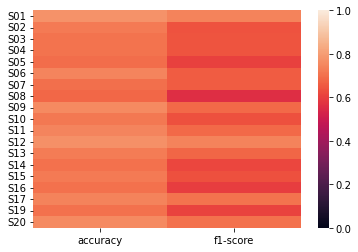

     class0 f1-score  class1 f1-score
S01         0.857143         0.485714
S02         0.829091         0.229508
S03         0.816901         0.235294
S04         0.818482         0.225352
S05         0.814545         0.105263
S06         0.847458         0.181818
S07         0.802867         0.337349
S08         0.809061         0.032787
S09         0.852564         0.281250
S10         0.828479         0.208955
S11         0.842491         0.295082
S12         0.854015         0.487179
S13         0.826855         0.346667
S14         0.818792         0.156250
S15         0.831683         0.190476
S16         0.820847         0.067797
S17         0.833977         0.410959
S19         0.818482         0.153846
S20         0.848276         0.371429


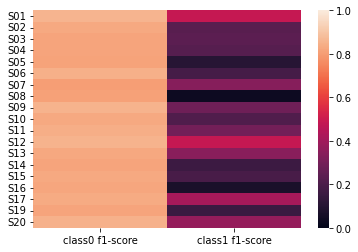

In [9]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [10]:
# pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-EEGNet.pkl","wb"))